In [1]:
from datetime import datetime
from dateutil import parser
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data from a CSV file
file_path = 'delhi15.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
features = ['tempmax', 'tempmin', 'temp', 'humidity', 'windspeed', 'sealevelpressure']
date_input = input("Enter a date (YYYY-MM-DD): ")

# Parse the date input into a datetime object
try:
    user_date = parser.parse(date_input).date()
except ValueError:
    print("Invalid date format. Please enter date in YYYY-MM-DD format.")
    exit()

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tempmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tempmax > 40, else 0

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the enhanced LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves based on user input dates
def predict_heatwave_for_dates(dates):
    new_data = data.loc[dates]
    new_data_scaled = scaler.transform(new_data[features])
    
    # Create sequences from the new data
    new_sequences = []
    for i in range(len(new_data_scaled) - seq_length):
        seq = new_data_scaled[i:i + seq_length]
        new_sequences.append(seq)
    
    new_sequences = np.array(new_sequences)
    
    # Predict heatwaves
    new_predictions = model.predict(new_sequences)
    new_predicted_labels = (new_predictions > 0.5).astype(int).flatten()
    
    result = pd.DataFrame({
        'date': new_data.index[seq_length:],
        'tempmax': new_data['tempmax'][seq_length:],
        'temp': new_data['temp'][seq_length:],
        'humidity': new_data['humidity'][seq_length:],
        'predicted_heatwave': new_predicted_labels
    })
    
    result['heatwave'] = result['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    
    return result

# Example usage with user input dates
user_dates = pd.date_range(start='2024-06-16', end='2024-06-25')
prediction_result = predict_heatwave_for_dates(user_dates)
print(prediction_result)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tempmax'], label='Actual TempMax')
plt.plot(data.index, data['humidity'], label='Humidity')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual TempMax, Humidity and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.6852 - val_accuracy: 1.0000 - val_loss: 0.6739
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.6773 - val_accuracy: 1.0000 - val_loss: 0.6661
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.6739 - val_accuracy: 1.0000 - val_loss: 0.6578
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.6673 - val_accuracy: 1.0000 - val_loss: 0.6496
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.6514 - val_accuracy: 1.0000 - val_loss: 0.6413
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.6481 - val_accuracy: 1.0000 - val_loss: 0.6330
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.6376 - val_accuracy: 1.0000 - val_loss: 0.6242
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.6335 - val_accuracy: 1.0000 - val_loss: 0

KeyError: "[Timestamp('2024-06-23 00:00:00'), Timestamp('2024-06-24 00:00:00'), Timestamp('2024-06-25 00:00:00')] not in index"

In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data from a CSV file
file_path = 'dc100.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
features = ['tempmax', 'tempmin', 'temp', 'humidity', 'windspeed', 'sealevelpressure']

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tempmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tempmax > 40, else 0

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the LSTM model with enhanced regularization
def build_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Use K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_acc = []

for train_index, val_index in kfold.split(X_train):
    model = build_model()
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
    
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold)
    cross_val_acc.append(accuracy)

average_cross_val_acc = np.mean(cross_val_acc)
print(f'Average Cross-Validation Accuracy: {average_cross_val_acc*100:.2f}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves for the next 5 days after the last date in the data
def predict_future_heatwaves(data, model, scaler, features, seq_length=5, days=5):
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days)

    last_seq = data[features].iloc[-seq_length:].values
    future_predictions = []

    for i in range(days):
        seq = scaler.transform(last_seq)
        seq = np.expand_dims(seq, axis=0)
        prediction = model.predict(seq)
        predicted_label = (prediction > 0.5).astype(int).flatten()[0]
        future_predictions.append(predicted_label)
        
        # Create next sequence
        new_entry = np.zeros((1, len(features)))  # Placeholder for new entry
        last_seq = np.vstack([last_seq[1:], new_entry])
        
    future_df = pd.DataFrame({
        'date': future_dates,
        'predicted_heatwave': future_predictions
    })

    future_df['heatwave'] = future_df['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    return future_df

# Predict heatwaves for the next 5 days
future_heatwaves = predict_future_heatwaves(data, model, scaler, features, seq_length, days=5)
print(future_heatwaves)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tempmax'], label='Actual TempMax')
plt.plot(data.index, data['humidity'], label='Humidity')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual TempMax, Humidity and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")


KeyError: 'datetime'

TypeError: Could not convert ['1901-01-011901-01-021901-01-031901-01-041901-01-051901-01-061901-01-071901-01-081901-01-091901-01-101901-01-111901-01-121901-01-131901-01-141901-01-151901-01-161901-01-171901-01-181901-01-191901-01-201901-01-211901-01-221901-01-231901-01-241901-01-251901-01-261901-01-271901-01-281901-01-291901-01-301901-01-311901-02-011901-02-021901-02-031901-02-041901-02-051901-02-061901-02-071901-02-081901-02-091901-02-101901-02-111901-02-121901-02-131901-02-141901-02-151901-02-161901-02-171901-02-181901-02-191901-02-201901-02-211901-02-221901-02-231901-02-241901-02-251901-02-261901-02-271901-02-281901-03-011901-03-021901-03-031901-03-041901-03-051901-03-061901-03-071901-03-081901-03-091901-03-101901-03-111901-03-121901-03-131901-03-141901-03-151901-03-161901-03-171901-03-181901-03-191901-03-201901-03-211901-03-221901-03-231901-03-241901-03-251901-03-261901-03-271901-03-281901-03-291901-03-301901-03-311901-04-011901-04-021901-04-031901-04-041901-04-051901-04-061901-04-071901-04-081901-04-091901-04-101901-04-111901-04-121901-04-131901-04-141901-04-151901-04-161901-04-171901-04-181901-04-191901-04-201901-04-211901-04-221901-04-231901-04-241901-04-251901-04-261901-04-271901-04-281901-04-291901-04-301901-05-011901-05-021901-05-031901-05-041901-05-051901-05-061901-05-071901-05-081901-05-091901-05-101901-05-111901-05-121901-05-131901-05-141901-05-151901-05-161901-05-171901-05-181901-05-191901-05-201901-05-211901-05-221901-05-231901-05-241901-05-251901-05-261901-05-271901-05-281901-05-291901-05-301901-05-311901-06-011901-06-021901-06-031901-06-041901-06-051901-06-061901-06-071901-06-081901-06-091901-06-101901-06-111901-06-121901-06-131901-06-141901-06-151901-06-161901-06-171901-06-181901-06-191901-06-201901-06-211901-06-221901-06-231901-06-241901-06-251901-06-261901-06-271901-06-281901-06-291901-06-301901-07-011901-07-021901-07-031901-07-041901-07-051901-07-061901-07-071901-07-081901-07-091901-07-101901-07-111901-07-121901-07-131901-07-141901-07-151901-07-161901-07-171901-07-181901-07-191901-07-201901-07-211901-07-221901-07-231901-07-241901-07-251901-07-261901-07-271901-07-281901-07-291901-07-301901-07-311901-08-011901-08-021901-08-031901-08-041901-08-051901-08-061901-08-071901-08-081901-08-091901-08-101901-08-111901-08-121901-08-131901-08-141901-08-151901-08-161901-08-171901-08-181901-08-191901-08-201901-08-211901-08-221901-08-231901-08-241901-08-251901-08-261901-08-271901-08-281901-08-291901-08-301901-08-311901-09-011901-09-021901-09-031901-09-041901-09-051901-09-061901-09-071901-09-081901-09-091901-09-101901-09-111901-09-121901-09-131901-09-141901-09-151901-09-161901-09-171901-09-181901-09-191901-09-201901-09-211901-09-221901-09-231901-09-241901-09-251901-09-261901-09-271901-09-281901-09-291901-09-301901-10-011901-10-021901-10-031901-10-041901-10-051901-10-061901-10-071901-10-081901-10-091901-10-101901-10-111901-10-121901-10-131901-10-141901-10-151901-10-161901-10-171901-10-181901-10-191901-10-201901-10-211901-10-221901-10-231901-10-241901-10-251901-10-261901-10-271901-10-281901-10-291901-10-301901-10-311901-11-011901-11-021901-11-031901-11-041901-11-051901-11-061901-11-071901-11-081901-11-091901-11-101901-11-111901-11-121901-11-131901-11-141901-11-151901-11-161901-11-171901-11-181901-11-191901-11-201901-11-211901-11-221901-11-231901-11-241901-11-251901-11-261901-11-271901-11-281901-11-291901-11-301901-12-011901-12-021901-12-031901-12-041901-12-051901-12-061901-12-071901-12-081901-12-091901-12-101901-12-111901-12-121901-12-131901-12-141901-12-151901-12-161901-12-171901-12-181901-12-191901-12-201901-12-211901-12-221901-12-231901-12-241901-12-251901-12-261901-12-271901-12-281901-12-291901-12-301901-12-311902-01-011902-01-021902-01-031902-01-041902-01-051902-01-061902-01-071902-01-081902-01-091902-01-101902-01-111902-01-121902-01-131902-01-141902-01-151902-01-161902-01-171902-01-181902-01-191902-01-201902-01-211902-01-221902-01-231902-01-241902-01-251902-01-261902-01-271902-01-281902-01-291902-01-301902-01-311902-02-011902-02-021902-02-031902-02-041902-02-051902-02-061902-02-071902-02-081902-02-091902-02-101902-02-111902-02-121902-02-131902-02-141902-02-151902-02-161902-02-171902-02-181902-02-191902-02-201902-02-211902-02-221902-02-231902-02-241902-02-251902-02-261902-02-271902-02-281902-03-011902-03-021902-03-031902-03-041902-03-051902-03-061902-03-071902-03-081902-03-091902-03-101902-03-111902-03-121902-03-131902-03-141902-03-151902-03-161902-03-171902-03-181902-03-191902-03-201902-03-211902-03-221902-03-231902-03-241902-03-251902-03-261902-03-271902-03-281902-03-291902-03-301902-03-311902-04-011902-04-021902-04-031902-04-041902-04-051902-04-061902-04-071902-04-081902-04-091902-04-101902-04-111902-04-121902-04-131902-04-141902-04-151902-04-161902-04-171902-04-181902-04-191902-04-201902-04-211902-04-221902-04-231902-04-241902-04-251902-04-261902-04-271902-04-281902-04-291902-04-301902-05-011902-05-021902-05-031902-05-041902-05-051902-05-061902-05-071902-05-081902-05-091902-05-101902-05-111902-05-121902-05-131902-05-141902-05-151902-05-161902-05-171902-05-181902-05-191902-05-201902-05-211902-05-221902-05-231902-05-241902-05-251902-05-261902-05-271902-05-281902-05-291902-05-301902-05-311902-06-011902-06-021902-06-031902-06-041902-06-051902-06-061902-06-071902-06-081902-06-091902-06-101902-06-111902-06-121902-06-131902-06-141902-06-151902-06-161902-06-171902-06-181902-06-191902-06-201902-06-211902-06-221902-06-231902-06-241902-06-251902-06-261902-06-271902-06-281902-06-291902-06-301902-07-011902-07-021902-07-031902-07-041902-07-051902-07-061902-07-071902-07-081902-07-091902-07-101902-07-111902-07-121902-07-131902-07-141902-07-151902-07-161902-07-171902-07-181902-07-191902-07-201902-07-211902-07-221902-07-231902-07-241902-07-251902-07-261902-07-271902-07-281902-07-291902-07-301902-07-311902-08-011902-08-021902-08-031902-08-041902-08-051902-08-061902-08-071902-08-081902-08-091902-08-101902-08-111902-08-121902-08-131902-08-141902-08-151902-08-161902-08-171902-08-181902-08-191902-08-201902-08-211902-08-221902-08-231902-08-241902-08-251902-08-261902-08-271902-08-281902-08-291902-08-301902-08-311902-09-011902-09-021902-09-031902-09-041902-09-051902-09-061902-09-071902-09-081902-09-091902-09-101902-09-111902-09-121902-09-131902-09-141902-09-151902-09-161902-09-171902-09-181902-09-191902-09-201902-09-211902-09-221902-09-231902-09-241902-09-251902-09-261902-09-271902-09-281902-09-291902-09-301902-10-011902-10-021902-10-031902-10-041902-10-051902-10-061902-10-071902-10-081902-10-091902-10-101902-10-111902-10-121902-10-131902-10-141902-10-151902-10-161902-10-171902-10-181902-10-191902-10-201902-10-211902-10-221902-10-231902-10-241902-10-251902-10-261902-10-271902-10-281902-10-291902-10-301902-10-311902-11-011902-11-021902-11-031902-11-041902-11-051902-11-061902-11-071902-11-081902-11-091902-11-101902-11-111902-11-121902-11-131902-11-141902-11-151902-11-161902-11-171902-11-181902-11-191902-11-201902-11-211902-11-221902-11-231902-11-241902-11-251902-11-261902-11-271902-11-281902-11-291902-11-301902-12-011902-12-021902-12-031902-12-041902-12-051902-12-061902-12-071902-12-081902-12-091902-12-101902-12-111902-12-121902-12-131902-12-141902-12-151902-12-161902-12-171902-12-181902-12-191902-12-201902-12-211902-12-221902-12-231902-12-241902-12-251902-12-261902-12-271902-12-281902-12-291902-12-301902-12-311903-01-011903-01-021903-01-031903-01-041903-01-051903-01-061903-01-071903-01-081903-01-091903-01-101903-01-111903-01-121903-01-131903-01-141903-01-151903-01-161903-01-171903-01-181903-01-191903-01-201903-01-211903-01-221903-01-231903-01-241903-01-251903-01-261903-01-271903-01-281903-01-291903-01-301903-01-311903-02-011903-02-021903-02-031903-02-041903-02-051903-02-061903-02-071903-02-081903-02-091903-02-101903-02-111903-02-121903-02-131903-02-141903-02-151903-02-161903-02-171903-02-181903-02-191903-02-201903-02-211903-02-221903-02-231903-02-241903-02-251903-02-261903-02-271903-02-281903-03-011903-03-021903-03-031903-03-041903-03-051903-03-061903-03-071903-03-081903-03-091903-03-101903-03-111903-03-121903-03-131903-03-141903-03-151903-03-161903-03-171903-03-181903-03-191903-03-201903-03-211903-03-221903-03-231903-03-241903-03-251903-03-261903-03-271903-03-281903-03-291903-03-301903-03-311903-04-011903-04-021903-04-031903-04-041903-04-051903-04-061903-04-071903-04-081903-04-091903-04-101903-04-111903-04-121903-04-131903-04-141903-04-151903-04-161903-04-171903-04-181903-04-191903-04-201903-04-211903-04-221903-04-231903-04-241903-04-251903-04-261903-04-271903-04-281903-04-291903-04-301903-05-011903-05-021903-05-031903-05-041903-05-051903-05-061903-05-071903-05-081903-05-091903-05-101903-05-111903-05-121903-05-131903-05-141903-05-151903-05-161903-05-171903-05-181903-05-191903-05-201903-05-211903-05-221903-05-231903-05-241903-05-251903-05-261903-05-271903-05-281903-05-291903-05-301903-05-311903-06-011903-06-021903-06-031903-06-041903-06-051903-06-061903-06-071903-06-081903-06-091903-06-101903-06-111903-06-121903-06-131903-06-141903-06-151903-06-161903-06-171903-06-181903-06-191903-06-201903-06-211903-06-221903-06-231903-06-241903-06-251903-06-261903-06-271903-06-281903-06-291903-06-301903-07-011903-07-021903-07-031903-07-041903-07-051903-07-061903-07-071903-07-081903-07-091903-07-101903-07-111903-07-121903-07-131903-07-141903-07-151903-07-161903-07-171903-07-181903-07-191903-07-201903-07-211903-07-221903-07-231903-07-241903-07-251903-07-261903-07-271903-07-281903-07-291903-07-301903-07-311903-08-011903-08-021903-08-031903-08-041903-08-051903-08-061903-08-071903-08-081903-08-091903-08-101903-08-111903-08-121903-08-131903-08-141903-08-151903-08-161903-08-171903-08-181903-08-191903-08-201903-08-211903-08-221903-08-231903-08-241903-08-251903-08-261903-08-271903-08-281903-08-291903-08-301903-08-311903-09-011903-09-021903-09-031903-09-041903-09-051903-09-061903-09-071903-09-081903-09-091903-09-101903-09-111903-09-121903-09-131903-09-141903-09-151903-09-161903-09-171903-09-181903-09-191903-09-201903-09-211903-09-221903-09-231903-09-241903-09-251903-09-261903-09-271903-09-281903-09-291903-09-301903-10-011903-10-021903-10-031903-10-041903-10-051903-10-061903-10-071903-10-081903-10-091903-10-101903-10-111903-10-121903-10-131903-10-141903-10-151903-10-161903-10-171903-10-181903-10-191903-10-201903-10-211903-10-221903-10-231903-10-241903-10-251903-10-261903-10-271903-10-281903-10-291903-10-301903-10-311903-11-011903-11-021903-11-031903-11-041903-11-051903-11-061903-11-071903-11-081903-11-091903-11-101903-11-111903-11-121903-11-131903-11-141903-11-151903-11-161903-11-171903-11-181903-11-191903-11-201903-11-211903-11-221903-11-231903-11-241903-11-251903-11-261903-11-271903-11-281903-11-291903-11-301903-12-011903-12-021903-12-031903-12-041903-12-051903-12-061903-12-071903-12-081903-12-091903-12-101903-12-111903-12-121903-12-131903-12-141903-12-151903-12-161903-12-171903-12-181903-12-191903-12-201903-12-211903-12-221903-12-231903-12-241903-12-251903-12-261903-12-271903-12-281903-12-291903-12-301903-12-311904-01-011904-01-021904-01-031904-01-041904-01-051904-01-061904-01-071904-01-081904-01-091904-01-101904-01-111904-01-121904-01-131904-01-141904-01-151904-01-161904-01-171904-01-181904-01-191904-01-201904-01-211904-01-221904-01-231904-01-241904-01-251904-01-261904-01-271904-01-281904-01-291904-01-301904-01-311904-02-011904-02-021904-02-031904-02-041904-02-051904-02-061904-02-071904-02-081904-02-091904-02-101904-02-111904-02-121904-02-131904-02-141904-02-151904-02-161904-02-171904-02-181904-02-191904-02-201904-02-211904-02-221904-02-231904-02-241904-02-251904-02-261904-02-271904-02-281904-02-291904-03-011904-03-021904-03-031904-03-041904-03-051904-03-061904-03-071904-03-081904-03-091904-03-101904-03-111904-03-121904-03-131904-03-141904-03-151904-03-161904-03-171904-03-181904-03-191904-03-201904-03-211904-03-221904-03-231904-03-241904-03-251904-03-261904-03-271904-03-281904-03-291904-03-301904-03-311904-04-011904-04-021904-04-031904-04-041904-04-051904-04-061904-04-071904-04-081904-04-091904-04-101904-04-111904-04-121904-04-131904-04-141904-04-151904-04-161904-04-171904-04-181904-04-191904-04-201904-04-211904-04-221904-04-231904-04-241904-04-251904-04-261904-04-271904-04-281904-04-291904-04-301904-05-011904-05-021904-05-031904-05-041904-05-051904-05-061904-05-071904-05-081904-05-091904-05-101904-05-111904-05-121904-05-131904-05-141904-05-151904-05-161904-05-171904-05-181904-05-191904-05-201904-05-211904-05-221904-05-231904-05-241904-05-251904-05-261904-05-271904-05-281904-05-291904-05-301904-05-311904-06-011904-06-021904-06-031904-06-041904-06-051904-06-061904-06-071904-06-081904-06-091904-06-101904-06-111904-06-121904-06-131904-06-141904-06-151904-06-161904-06-171904-06-181904-06-191904-06-201904-06-211904-06-221904-06-231904-06-241904-06-251904-06-261904-06-271904-06-281904-06-291904-06-301904-07-011904-07-021904-07-031904-07-041904-07-051904-07-061904-07-071904-07-081904-07-091904-07-101904-07-111904-07-121904-07-131904-07-141904-07-151904-07-161904-07-171904-07-181904-07-191904-07-201904-07-211904-07-221904-07-231904-07-241904-07-251904-07-261904-07-271904-07-281904-07-291904-07-301904-07-311904-08-011904-08-021904-08-031904-08-041904-08-051904-08-061904-08-071904-08-081904-08-091904-08-101904-08-111904-08-121904-08-131904-08-141904-08-151904-08-161904-08-171904-08-181904-08-191904-08-201904-08-211904-08-221904-08-231904-08-241904-08-251904-08-261904-08-271904-08-281904-08-291904-08-301904-08-311904-09-011904-09-021904-09-031904-09-041904-09-051904-09-061904-09-071904-09-081904-09-091904-09-101904-09-111904-09-121904-09-131904-09-141904-09-151904-09-161904-09-171904-09-181904-09-191904-09-201904-09-211904-09-221904-09-231904-09-241904-09-251904-09-261904-09-271904-09-281904-09-291904-09-301904-10-011904-10-021904-10-031904-10-041904-10-051904-10-061904-10-071904-10-081904-10-091904-10-101904-10-111904-10-121904-10-131904-10-141904-10-151904-10-161904-10-171904-10-181904-10-191904-10-201904-10-211904-10-221904-10-231904-10-241904-10-251904-10-261904-10-271904-10-281904-10-291904-10-301904-10-311904-11-011904-11-021904-11-031904-11-041904-11-051904-11-061904-11-071904-11-081904-11-091904-11-101904-11-111904-11-121904-11-131904-11-141904-11-151904-11-161904-11-171904-11-181904-11-191904-11-201904-11-211904-11-221904-11-231904-11-241904-11-251904-11-261904-11-271904-11-281904-11-291904-11-301904-12-011904-12-021904-12-031904-12-041904-12-051904-12-061904-12-071904-12-081904-12-091904-12-101904-12-111904-12-121904-12-131904-12-141904-12-151904-12-161904-12-171904-12-181904-12-191904-12-201904-12-211904-12-221904-12-231904-12-241904-12-251904-12-261904-12-271904-12-281904-12-291904-12-301904-12-311905-01-011905-01-021905-01-031905-01-041905-01-051905-01-061905-01-071905-01-081905-01-091905-01-101905-01-111905-01-121905-01-131905-01-141905-01-151905-01-161905-01-171905-01-181905-01-191905-01-201905-01-211905-01-221905-01-231905-01-241905-01-251905-01-261905-01-271905-01-281905-01-291905-01-301905-01-311905-02-011905-02-021905-02-031905-02-041905-02-051905-02-061905-02-071905-02-081905-02-091905-02-101905-02-111905-02-121905-02-131905-02-141905-02-151905-02-161905-02-171905-02-181905-02-191905-02-201905-02-211905-02-221905-02-231905-02-241905-02-251905-02-261905-02-271905-02-281905-03-011905-03-021905-03-031905-03-041905-03-051905-03-061905-03-071905-03-081905-03-091905-03-101905-03-111905-03-121905-03-131905-03-141905-03-151905-03-161905-03-171905-03-181905-03-191905-03-201905-03-211905-03-221905-03-231905-03-241905-03-251905-03-261905-03-271905-03-281905-03-291905-03-301905-03-311905-04-011905-04-021905-04-031905-04-041905-04-051905-04-061905-04-071905-04-081905-04-091905-04-101905-04-111905-04-121905-04-131905-04-141905-04-151905-04-161905-04-171905-04-181905-04-191905-04-201905-04-211905-04-221905-04-231905-04-241905-04-251905-04-261905-04-271905-04-281905-04-291905-04-301905-05-011905-05-021905-05-031905-05-041905-05-051905-05-061905-05-071905-05-081905-05-091905-05-101905-05-111905-05-121905-05-131905-05-141905-05-151905-05-161905-05-171905-05-181905-05-191905-05-201905-05-211905-05-221905-05-231905-05-241905-05-251905-05-261905-05-271905-05-281905-05-291905-05-301905-05-311905-06-011905-06-021905-06-031905-06-041905-06-051905-06-061905-06-071905-06-081905-06-091905-06-101905-06-111905-06-121905-06-131905-06-141905-06-151905-06-161905-06-171905-06-181905-06-191905-06-201905-06-211905-06-221905-06-231905-06-241905-06-251905-06-261905-06-271905-06-281905-06-291905-06-301905-07-011905-07-021905-07-031905-07-041905-07-051905-07-061905-07-071905-07-081905-07-091905-07-101905-07-111905-07-121905-07-131905-07-141905-07-151905-07-161905-07-171905-07-181905-07-191905-07-201905-07-211905-07-221905-07-231905-07-241905-07-251905-07-261905-07-271905-07-281905-07-291905-07-301905-07-311905-08-011905-08-021905-08-031905-08-041905-08-051905-08-061905-08-071905-08-081905-08-091905-08-101905-08-111905-08-121905-08-131905-08-141905-08-151905-08-161905-08-171905-08-181905-08-191905-08-201905-08-211905-08-221905-08-231905-08-241905-08-251905-08-261905-08-271905-08-281905-08-291905-08-301905-08-311905-09-011905-09-021905-09-031905-09-041905-09-051905-09-061905-09-071905-09-081905-09-091905-09-101905-09-111905-09-121905-09-131905-09-141905-09-151905-09-161905-09-171905-09-181905-09-191905-09-201905-09-211905-09-221905-09-231905-09-241905-09-251905-09-261905-09-271905-09-281905-09-291905-09-301905-10-011905-10-021905-10-031905-10-041905-10-051905-10-061905-10-071905-10-081905-10-091905-10-101905-10-111905-10-121905-10-131905-10-141905-10-151905-10-161905-10-171905-10-181905-10-191905-10-201905-10-211905-10-221905-10-231905-10-241905-10-251905-10-261905-10-271905-10-281905-10-291905-10-301905-10-311905-11-011905-11-021905-11-031905-11-041905-11-051905-11-061905-11-071905-11-081905-11-091905-11-101905-11-111905-11-121905-11-131905-11-141905-11-151905-11-161905-11-171905-11-181905-11-191905-11-201905-11-211905-11-221905-11-231905-11-241905-11-251905-11-261905-11-271905-11-281905-11-291905-11-301905-12-011905-12-021905-12-031905-12-041905-12-051905-12-061905-12-071905-12-081905-12-091905-12-101905-12-111905-12-121905-12-131905-12-141905-12-151905-12-161905-12-171905-12-181905-12-191905-12-201905-12-211905-12-221905-12-231905-12-241905-12-251905-12-261905-12-271905-12-281905-12-291905-12-301905-12-311906-01-011906-01-021906-01-031906-01-041906-01-051906-01-061906-01-071906-01-081906-01-091906-01-101906-01-111906-01-121906-01-131906-01-141906-01-151906-01-161906-01-171906-01-181906-01-191906-01-201906-01-211906-01-221906-01-231906-01-241906-01-251906-01-261906-01-271906-01-281906-01-291906-01-301906-01-311906-02-011906-02-021906-02-031906-02-041906-02-051906-02-061906-02-071906-02-081906-02-091906-02-101906-02-111906-02-121906-02-131906-02-141906-02-151906-02-161906-02-171906-02-181906-02-191906-02-201906-02-211906-02-221906-02-231906-02-241906-02-251906-02-261906-02-271906-02-281906-03-011906-03-021906-03-031906-03-041906-03-051906-03-061906-03-071906-03-081906-03-091906-03-101906-03-111906-03-121906-03-131906-03-141906-03-151906-03-161906-03-171906-03-181906-03-191906-03-201906-03-211906-03-221906-03-231906-03-241906-03-251906-03-261906-03-271906-03-281906-03-291906-03-301906-03-311906-04-011906-04-021906-04-031906-04-041906-04-051906-04-061906-04-071906-04-081906-04-091906-04-101906-04-111906-04-121906-04-131906-04-141906-04-151906-04-161906-04-171906-04-181906-04-191906-04-201906-04-211906-04-221906-04-231906-04-241906-04-251906-04-261906-04-271906-04-281906-04-291906-04-301906-05-011906-05-021906-05-031906-05-041906-05-051906-05-061906-05-071906-05-081906-05-091906-05-101906-05-111906-05-121906-05-131906-05-141906-05-151906-05-161906-05-171906-05-181906-05-191906-05-201906-05-211906-05-221906-05-231906-05-241906-05-251906-05-261906-05-271906-05-281906-05-291906-05-301906-05-311906-06-011906-06-021906-06-031906-06-041906-06-051906-06-061906-06-071906-06-081906-06-091906-06-101906-06-111906-06-121906-06-131906-06-141906-06-151906-06-161906-06-171906-06-181906-06-191906-06-201906-06-211906-06-221906-06-231906-06-241906-06-251906-06-261906-06-271906-06-281906-06-291906-06-301906-07-011906-07-021906-07-031906-07-041906-07-051906-07-061906-07-071906-07-081906-07-091906-07-101906-07-111906-07-121906-07-131906-07-141906-07-151906-07-161906-07-171906-07-181906-07-191906-07-201906-07-211906-07-221906-07-231906-07-241906-07-251906-07-261906-07-271906-07-281906-07-291906-07-301906-07-311906-08-011906-08-021906-08-031906-08-041906-08-051906-08-061906-08-071906-08-081906-08-091906-08-101906-08-111906-08-121906-08-131906-08-141906-08-151906-08-161906-08-171906-08-181906-08-191906-08-201906-08-211906-08-221906-08-231906-08-241906-08-251906-08-261906-08-271906-08-281906-08-291906-08-301906-08-311906-09-011906-09-021906-09-031906-09-041906-09-051906-09-061906-09-071906-09-081906-09-091906-09-101906-09-111906-09-121906-09-131906-09-141906-09-151906-09-161906-09-171906-09-181906-09-191906-09-201906-09-211906-09-221906-09-231906-09-241906-09-251906-09-261906-09-271906-09-281906-09-291906-09-301906-10-011906-10-021906-10-031906-10-041906-10-051906-10-061906-10-071906-10-081906-10-091906-10-101906-10-111906-10-121906-10-131906-10-141906-10-151906-10-161906-10-171906-10-181906-10-191906-10-201906-10-211906-10-221906-10-231906-10-241906-10-251906-10-261906-10-271906-10-281906-10-291906-10-301906-10-311906-11-011906-11-021906-11-031906-11-041906-11-051906-11-061906-11-071906-11-081906-11-091906-11-101906-11-111906-11-121906-11-131906-11-141906-11-151906-11-161906-11-171906-11-181906-11-191906-11-201906-11-211906-11-221906-11-231906-11-241906-11-251906-11-261906-11-271906-11-281906-11-291906-11-301906-12-011906-12-021906-12-031906-12-041906-12-051906-12-061906-12-071906-12-081906-12-091906-12-101906-12-111906-12-121906-12-131906-12-141906-12-151906-12-161906-12-171906-12-181906-12-191906-12-201906-12-211906-12-221906-12-231906-12-241906-12-251906-12-261906-12-271906-12-281906-12-291906-12-301906-12-311907-01-011907-01-021907-01-031907-01-041907-01-051907-01-061907-01-071907-01-081907-01-091907-01-101907-01-111907-01-121907-01-131907-01-141907-01-151907-01-161907-01-171907-01-181907-01-191907-01-201907-01-211907-01-221907-01-231907-01-241907-01-251907-01-261907-01-271907-01-281907-01-291907-01-301907-01-311907-02-011907-02-021907-02-031907-02-041907-02-051907-02-061907-02-071907-02-081907-02-091907-02-101907-02-111907-02-121907-02-131907-02-141907-02-151907-02-161907-02-171907-02-181907-02-191907-02-201907-02-211907-02-221907-02-231907-02-241907-02-251907-02-261907-02-271907-02-281907-03-011907-03-021907-03-031907-03-041907-03-051907-03-061907-03-071907-03-081907-03-091907-03-101907-03-111907-03-121907-03-131907-03-141907-03-151907-03-161907-03-171907-03-181907-03-191907-03-201907-03-211907-03-221907-03-231907-03-241907-03-251907-03-261907-03-271907-03-281907-03-291907-03-301907-03-311907-04-011907-04-021907-04-031907-04-041907-04-051907-04-061907-04-071907-04-081907-04-091907-04-101907-04-111907-04-121907-04-131907-04-141907-04-151907-04-161907-04-171907-04-181907-04-191907-04-201907-04-211907-04-221907-04-231907-04-241907-04-251907-04-261907-04-271907-04-281907-04-291907-04-301907-05-011907-05-021907-05-031907-05-041907-05-051907-05-061907-05-071907-05-081907-05-091907-05-101907-05-111907-05-121907-05-131907-05-141907-05-151907-05-161907-05-171907-05-181907-05-191907-05-201907-05-211907-05-221907-05-231907-05-241907-05-251907-05-261907-05-271907-05-281907-05-291907-05-301907-05-311907-06-011907-06-021907-06-031907-06-041907-06-051907-06-061907-06-071907-06-081907-06-091907-06-101907-06-111907-06-121907-06-131907-06-141907-06-151907-06-161907-06-171907-06-181907-06-191907-06-201907-06-211907-06-221907-06-231907-06-241907-06-251907-06-261907-06-271907-06-281907-06-291907-06-301907-07-011907-07-021907-07-031907-07-041907-07-051907-07-061907-07-071907-07-081907-07-091907-07-101907-07-111907-07-121907-07-131907-07-141907-07-151907-07-161907-07-171907-07-181907-07-191907-07-201907-07-211907-07-221907-07-231907-07-241907-07-251907-07-261907-07-271907-07-281907-07-291907-07-301907-07-311907-08-011907-08-021907-08-031907-08-041907-08-051907-08-061907-08-071907-08-081907-08-091907-08-101907-08-111907-08-121907-08-131907-08-141907-08-151907-08-161907-08-171907-08-181907-08-191907-08-201907-08-211907-08-221907-08-231907-08-241907-08-251907-08-261907-08-271907-08-281907-08-291907-08-301907-08-311907-09-011907-09-021907-09-031907-09-041907-09-051907-09-061907-09-071907-09-081907-09-091907-09-101907-09-111907-09-121907-09-131907-09-141907-09-151907-09-161907-09-171907-09-181907-09-191907-09-201907-09-211907-09-221907-09-231907-09-241907-09-251907-09-261907-09-271907-09-281907-09-291907-09-301907-10-011907-10-021907-10-031907-10-041907-10-051907-10-061907-10-071907-10-081907-10-091907-10-101907-10-111907-10-121907-10-131907-10-141907-10-151907-10-161907-10-171907-10-181907-10-191907-10-201907-10-211907-10-221907-10-231907-10-241907-10-251907-10-261907-10-271907-10-281907-10-291907-10-301907-10-311907-11-011907-11-021907-11-031907-11-041907-11-051907-11-061907-11-071907-11-081907-11-091907-11-101907-11-111907-11-121907-11-131907-11-141907-11-151907-11-161907-11-171907-11-181907-11-191907-11-201907-11-211907-11-221907-11-231907-11-241907-11-251907-11-261907-11-271907-11-281907-11-291907-11-301907-12-011907-12-021907-12-031907-12-041907-12-051907-12-061907-12-071907-12-081907-12-091907-12-101907-12-111907-12-121907-12-131907-12-141907-12-151907-12-161907-12-171907-12-181907-12-191907-12-201907-12-211907-12-221907-12-231907-12-241907-12-251907-12-261907-12-271907-12-281907-12-291907-12-301907-12-311908-01-011908-01-021908-01-031908-01-041908-01-051908-01-061908-01-071908-01-081908-01-091908-01-101908-01-111908-01-121908-01-131908-01-141908-01-151908-01-161908-01-171908-01-181908-01-191908-01-201908-01-211908-01-221908-01-231908-01-241908-01-251908-01-261908-01-271908-01-281908-01-291908-01-301908-01-311908-02-011908-02-021908-02-031908-02-041908-02-051908-02-061908-02-071908-02-081908-02-091908-02-101908-02-111908-02-121908-02-131908-02-141908-02-151908-02-161908-02-171908-02-181908-02-191908-02-201908-02-211908-02-221908-02-231908-02-241908-02-251908-02-261908-02-271908-02-281908-02-291908-03-011908-03-021908-03-031908-03-041908-03-051908-03-061908-03-071908-03-081908-03-091908-03-101908-03-111908-03-121908-03-131908-03-141908-03-151908-03-161908-03-171908-03-181908-03-191908-03-201908-03-211908-03-221908-03-231908-03-241908-03-251908-03-261908-03-271908-03-281908-03-291908-03-301908-03-311908-04-011908-04-021908-04-031908-04-041908-04-051908-04-061908-04-071908-04-081908-04-091908-04-101908-04-111908-04-121908-04-131908-04-141908-04-151908-04-161908-04-171908-04-181908-04-191908-04-201908-04-211908-04-221908-04-231908-04-241908-04-251908-04-261908-04-271908-04-281908-04-291908-04-301908-05-011908-05-021908-05-031908-05-041908-05-051908-05-061908-05-071908-05-081908-05-091908-05-101908-05-111908-05-121908-05-131908-05-141908-05-151908-05-161908-05-171908-05-181908-05-191908-05-201908-05-211908-05-221908-05-231908-05-241908-05-251908-05-261908-05-271908-05-281908-05-291908-05-301908-05-311908-06-011908-06-021908-06-031908-06-041908-06-051908-06-061908-06-071908-06-081908-06-091908-06-101908-06-111908-06-121908-06-131908-06-141908-06-151908-06-161908-06-171908-06-181908-06-191908-06-201908-06-211908-06-221908-06-231908-06-241908-06-251908-06-261908-06-271908-06-281908-06-291908-06-301908-07-011908-07-021908-07-031908-07-041908-07-051908-07-061908-07-071908-07-081908-07-091908-07-101908-07-111908-07-121908-07-131908-07-141908-07-151908-07-161908-07-171908-07-181908-07-191908-07-201908-07-211908-07-221908-07-231908-07-241908-07-251908-07-261908-07-271908-07-281908-07-291908-07-301908-07-311908-08-011908-08-021908-08-031908-08-041908-08-051908-08-061908-08-071908-08-081908-08-091908-08-101908-08-111908-08-121908-08-131908-08-141908-08-151908-08-161908-08-171908-08-181908-08-191908-08-201908-08-211908-08-221908-08-231908-08-241908-08-251908-08-261908-08-271908-08-281908-08-291908-08-301908-08-311908-09-011908-09-021908-09-031908-09-041908-09-051908-09-061908-09-071908-09-081908-09-091908-09-101908-09-111908-09-121908-09-131908-09-141908-09-151908-09-161908-09-171908-09-181908-09-191908-09-201908-09-211908-09-221908-09-231908-09-241908-09-251908-09-261908-09-271908-09-281908-09-291908-09-301908-10-011908-10-021908-10-031908-10-041908-10-051908-10-061908-10-071908-10-081908-10-091908-10-101908-10-111908-10-121908-10-131908-10-141908-10-151908-10-161908-10-171908-10-181908-10-191908-10-201908-10-211908-10-221908-10-231908-10-241908-10-251908-10-261908-10-271908-10-281908-10-291908-10-301908-10-311908-11-011908-11-021908-11-031908-11-041908-11-051908-11-061908-11-071908-11-081908-11-091908-11-101908-11-111908-11-121908-11-131908-11-141908-11-151908-11-161908-11-171908-11-181908-11-191908-11-201908-11-211908-11-221908-11-231908-11-241908-11-251908-11-261908-11-271908-11-281908-11-291908-11-301908-12-011908-12-021908-12-031908-12-041908-12-051908-12-061908-12-071908-12-081908-12-091908-12-101908-12-111908-12-121908-12-131908-12-141908-12-151908-12-161908-12-171908-12-181908-12-191908-12-201908-12-211908-12-221908-12-231908-12-241908-12-251908-12-261908-12-271908-12-281908-12-291908-12-301908-12-311909-01-011909-01-021909-01-031909-01-041909-01-051909-01-061909-01-071909-01-081909-01-091909-01-101909-01-111909-01-121909-01-131909-01-141909-01-151909-01-161909-01-171909-01-181909-01-191909-01-201909-01-211909-01-221909-01-231909-01-241909-01-251909-01-261909-01-271909-01-281909-01-291909-01-301909-01-311909-02-011909-02-021909-02-031909-02-041909-02-051909-02-061909-02-071909-02-081909-02-091909-02-101909-02-111909-02-121909-02-131909-02-141909-02-151909-02-161909-02-171909-02-181909-02-191909-02-201909-02-211909-02-221909-02-231909-02-241909-02-251909-02-261909-02-271909-02-281909-03-011909-03-021909-03-031909-03-041909-03-051909-03-061909-03-071909-03-081909-03-091909-03-101909-03-111909-03-121909-03-131909-03-141909-03-151909-03-161909-03-171909-03-181909-03-191909-03-201909-03-211909-03-221909-03-231909-03-241909-03-251909-03-261909-03-271909-03-281909-03-291909-03-301909-03-311909-04-011909-04-021909-04-031909-04-041909-04-051909-04-061909-04-071909-04-081909-04-091909-04-101909-04-111909-04-121909-04-131909-04-141909-04-151909-04-161909-04-171909-04-181909-04-191909-04-201909-04-211909-04-221909-04-231909-04-241909-04-251909-04-261909-04-271909-04-281909-04-291909-04-301909-05-011909-05-021909-05-031909-05-041909-05-051909-05-061909-05-071909-05-081909-05-091909-05-101909-05-111909-05-121909-05-131909-05-141909-05-151909-05-161909-05-171909-05-181909-05-191909-05-201909-05-211909-05-221909-05-231909-05-241909-05-251909-05-261909-05-271909-05-281909-05-291909-05-301909-05-311909-06-011909-06-021909-06-031909-06-041909-06-051909-06-061909-06-071909-06-081909-06-091909-06-101909-06-111909-06-121909-06-131909-06-141909-06-151909-06-161909-06-171909-06-181909-06-191909-06-201909-06-211909-06-221909-06-231909-06-241909-06-251909-06-261909-06-271909-06-281909-06-291909-06-301909-07-011909-07-021909-07-031909-07-041909-07-051909-07-061909-07-071909-07-081909-07-091909-07-101909-07-111909-07-121909-07-131909-07-141909-07-151909-07-161909-07-171909-07-181909-07-191909-07-201909-07-211909-07-221909-07-231909-07-241909-07-251909-07-261909-07-271909-07-281909-07-291909-07-301909-07-311909-08-011909-08-021909-08-031909-08-041909-08-051909-08-061909-08-071909-08-081909-08-091909-08-101909-08-111909-08-121909-08-131909-08-141909-08-151909-08-161909-08-171909-08-181909-08-191909-08-201909-08-211909-08-221909-08-231909-08-241909-08-251909-08-261909-08-271909-08-281909-08-291909-08-301909-08-311909-09-011909-09-021909-09-031909-09-041909-09-051909-09-061909-09-071909-09-081909-09-091909-09-101909-09-111909-09-121909-09-131909-09-141909-09-151909-09-161909-09-171909-09-181909-09-191909-09-201909-09-211909-09-221909-09-231909-09-241909-09-251909-09-261909-09-271909-09-281909-09-291909-09-301909-10-011909-10-021909-10-031909-10-041909-10-051909-10-061909-10-071909-10-081909-10-091909-10-101909-10-111909-10-121909-10-131909-10-141909-10-151909-10-161909-10-171909-10-181909-10-191909-10-201909-10-211909-10-221909-10-231909-10-241909-10-251909-10-261909-10-271909-10-281909-10-291909-10-301909-10-311909-11-011909-11-021909-11-031909-11-041909-11-051909-11-061909-11-071909-11-081909-11-091909-11-101909-11-111909-11-121909-11-131909-11-141909-11-151909-11-161909-11-171909-11-181909-11-191909-11-201909-11-211909-11-221909-11-231909-11-241909-11-251909-11-261909-11-271909-11-281909-11-291909-11-301909-12-011909-12-021909-12-031909-12-041909-12-051909-12-061909-12-071909-12-081909-12-091909-12-101909-12-111909-12-121909-12-131909-12-141909-12-151909-12-161909-12-171909-12-181909-12-191909-12-201909-12-211909-12-221909-12-231909-12-241909-12-251909-12-261909-12-271909-12-281909-12-291909-12-301909-12-311910-01-011910-01-021910-01-031910-01-041910-01-051910-01-061910-01-071910-01-081910-01-091910-01-101910-01-111910-01-121910-01-131910-01-141910-01-151910-01-161910-01-171910-01-181910-01-191910-01-201910-01-211910-01-221910-01-231910-01-241910-01-251910-01-261910-01-271910-01-281910-01-291910-01-301910-01-311910-02-011910-02-021910-02-031910-02-041910-02-051910-02-061910-02-071910-02-081910-02-091910-02-101910-02-111910-02-121910-02-131910-02-141910-02-151910-02-161910-02-171910-02-181910-02-191910-02-201910-02-211910-02-221910-02-231910-02-241910-02-251910-02-261910-02-271910-02-281910-03-011910-03-021910-03-031910-03-041910-03-051910-03-061910-03-071910-03-081910-03-091910-03-101910-03-111910-03-121910-03-131910-03-141910-03-151910-03-161910-03-171910-03-181910-03-191910-03-201910-03-211910-03-221910-03-231910-03-241910-03-251910-03-261910-03-271910-03-281910-03-291910-03-301910-03-311910-04-011910-04-021910-04-031910-04-041910-04-051910-04-061910-04-071910-04-081910-04-091910-04-101910-04-111910-04-121910-04-131910-04-141910-04-151910-04-161910-04-171910-04-181910-04-191910-04-201910-04-211910-04-221910-04-231910-04-241910-04-251910-04-261910-04-271910-04-281910-04-291910-04-301910-05-011910-05-021910-05-031910-05-041910-05-051910-05-061910-05-071910-05-081910-05-091910-05-101910-05-111910-05-121910-05-131910-05-141910-05-151910-05-161910-05-171910-05-181910-05-191910-05-201910-05-211910-05-221910-05-231910-05-241910-05-251910-05-261910-05-271910-05-281910-05-291910-05-301910-05-311910-06-011910-06-021910-06-031910-06-041910-06-051910-06-061910-06-071910-06-081910-06-091910-06-101910-06-111910-06-121910-06-131910-06-141910-06-151910-06-161910-06-171910-06-181910-06-191910-06-201910-06-211910-06-221910-06-231910-06-241910-06-251910-06-261910-06-271910-06-281910-06-291910-06-301910-07-011910-07-021910-07-031910-07-041910-07-051910-07-061910-07-071910-07-081910-07-091910-07-101910-07-111910-07-121910-07-131910-07-141910-07-151910-07-161910-07-171910-07-181910-07-191910-07-201910-07-211910-07-221910-07-231910-07-241910-07-251910-07-261910-07-271910-07-281910-07-291910-07-301910-07-311910-08-011910-08-021910-08-031910-08-041910-08-051910-08-061910-08-071910-08-081910-08-091910-08-101910-08-111910-08-121910-08-131910-08-141910-08-151910-08-161910-08-171910-08-181910-08-191910-08-201910-08-211910-08-221910-08-231910-08-241910-08-251910-08-261910-08-271910-08-281910-08-291910-08-301910-08-311910-09-011910-09-021910-09-031910-09-041910-09-051910-09-061910-09-071910-09-081910-09-091910-09-101910-09-111910-09-121910-09-131910-09-141910-09-151910-09-161910-09-171910-09-181910-09-191910-09-201910-09-211910-09-221910-09-231910-09-241910-09-251910-09-261910-09-271910-09-281910-09-291910-09-301910-10-011910-10-021910-10-031910-10-041910-10-051910-10-061910-10-071910-10-081910-10-091910-10-101910-10-111910-10-121910-10-131910-10-141910-10-151910-10-161910-10-171910-10-181910-10-191910-10-201910-10-211910-10-221910-10-231910-10-241910-10-251910-10-261910-10-271910-10-281910-10-291910-10-301910-10-311910-11-011910-11-021910-11-031910-11-041910-11-051910-11-061910-11-071910-11-081910-11-091910-11-101910-11-111910-11-121910-11-131910-11-141910-11-151910-11-161910-11-171910-11-181910-11-191910-11-201910-11-211910-11-221910-11-231910-11-241910-11-251910-11-261910-11-271910-11-281910-11-291910-11-301910-12-011910-12-021910-12-031910-12-041910-12-051910-12-061910-12-071910-12-081910-12-091910-12-101910-12-111910-12-121910-12-131910-12-141910-12-151910-12-161910-12-171910-12-181910-12-191910-12-201910-12-211910-12-221910-12-231910-12-241910-12-251910-12-261910-12-271910-12-281910-12-291910-12-301910-12-311911-01-011911-01-021911-01-031911-01-041911-01-051911-01-061911-01-071911-01-081911-01-091911-01-101911-01-111911-01-121911-01-131911-01-141911-01-151911-01-161911-01-171911-01-181911-01-191911-01-201911-01-211911-01-221911-01-231911-01-241911-01-251911-01-261911-01-271911-01-281911-01-291911-01-301911-01-311911-02-011911-02-021911-02-031911-02-041911-02-051911-02-061911-02-071911-02-081911-02-091911-02-101911-02-111911-02-121911-02-131911-02-141911-02-151911-02-161911-02-171911-02-181911-02-191911-02-201911-02-211911-02-221911-02-231911-02-241911-02-251911-02-261911-02-271911-02-281911-03-011911-03-021911-03-031911-03-041911-03-051911-03-061911-03-071911-03-081911-03-091911-03-101911-03-111911-03-121911-03-131911-03-141911-03-151911-03-161911-03-171911-03-181911-03-191911-03-201911-03-211911-03-221911-03-231911-03-241911-03-251911-03-261911-03-271911-03-281911-03-291911-03-301911-03-311911-04-011911-04-021911-04-031911-04-041911-04-051911-04-061911-04-071911-04-081911-04-091911-04-101911-04-111911-04-121911-04-131911-04-141911-04-151911-04-161911-04-171911-04-181911-04-191911-04-201911-04-211911-04-221911-04-231911-04-241911-04-251911-04-261911-04-271911-04-281911-04-291911-04-301911-05-011911-05-021911-05-031911-05-041911-05-051911-05-061911-05-071911-05-081911-05-091911-05-101911-05-111911-05-121911-05-131911-05-141911-05-151911-05-161911-05-171911-05-181911-05-191911-05-201911-05-211911-05-221911-05-231911-05-241911-05-251911-05-261911-05-271911-05-281911-05-291911-05-301911-05-311911-06-011911-06-021911-06-031911-06-041911-06-051911-06-061911-06-071911-06-081911-06-091911-06-101911-06-111911-06-121911-06-131911-06-141911-06-151911-06-161911-06-171911-06-181911-06-191911-06-201911-06-211911-06-221911-06-231911-06-241911-06-251911-06-261911-06-271911-06-281911-06-291911-06-301911-07-011911-07-021911-07-031911-07-041911-07-051911-07-061911-07-071911-07-081911-07-091911-07-101911-07-111911-07-121911-07-131911-07-141911-07-151911-07-161911-07-171911-07-181911-07-191911-07-201911-07-211911-07-221911-07-231911-07-241911-07-251911-07-261911-07-271911-07-281911-07-291911-07-301911-07-311911-08-011911-08-021911-08-031911-08-041911-08-051911-08-061911-08-071911-08-081911-08-091911-08-101911-08-111911-08-121911-08-131911-08-141911-08-151911-08-161911-08-171911-08-181911-08-191911-08-201911-08-211911-08-221911-08-231911-08-241911-08-251911-08-261911-08-271911-08-281911-08-291911-08-301911-08-311911-09-011911-09-021911-09-031911-09-041911-09-051911-09-061911-09-071911-09-081911-09-091911-09-101911-09-111911-09-121911-09-131911-09-141911-09-151911-09-161911-09-171911-09-181911-09-191911-09-201911-09-211911-09-221911-09-231911-09-241911-09-251911-09-261911-09-271911-09-281911-09-291911-09-301911-10-011911-10-021911-10-031911-10-041911-10-051911-10-061911-10-071911-10-081911-10-091911-10-101911-10-111911-10-121911-10-131911-10-141911-10-151911-10-161911-10-171911-10-181911-10-191911-10-201911-10-211911-10-221911-10-231911-10-241911-10-251911-10-261911-10-271911-10-281911-10-291911-10-301911-10-311911-11-011911-11-021911-11-031911-11-041911-11-051911-11-061911-11-071911-11-081911-11-091911-11-101911-11-111911-11-121911-11-131911-11-141911-11-151911-11-161911-11-171911-11-181911-11-191911-11-201911-11-211911-11-221911-11-231911-11-241911-11-251911-11-261911-11-271911-11-281911-11-291911-11-301911-12-011911-12-021911-12-031911-12-041911-12-051911-12-061911-12-071911-12-081911-12-091911-12-101911-12-111911-12-121911-12-131911-12-141911-12-151911-12-161911-12-171911-12-181911-12-191911-12-201911-12-211911-12-221911-12-231911-12-241911-12-251911-12-261911-12-271911-12-281911-12-291911-12-301911-12-311912-01-011912-01-021912-01-031912-01-041912-01-051912-01-061912-01-071912-01-081912-01-091912-01-101912-01-111912-01-121912-01-131912-01-141912-01-151912-01-161912-01-171912-01-181912-01-191912-01-201912-01-211912-01-221912-01-231912-01-241912-01-251912-01-261912-01-271912-01-281912-01-291912-01-301912-01-311912-02-011912-02-021912-02-031912-02-041912-02-051912-02-061912-02-071912-02-081912-02-091912-02-101912-02-111912-02-121912-02-131912-02-141912-02-151912-02-161912-02-171912-02-181912-02-191912-02-201912-02-211912-02-221912-02-231912-02-241912-02-251912-02-261912-02-271912-02-281912-02-291912-03-011912-03-021912-03-031912-03-041912-03-051912-03-061912-03-071912-03-081912-03-091912-03-101912-03-111912-03-121912-03-131912-03-141912-03-151912-03-161912-03-171912-03-181912-03-191912-03-201912-03-211912-03-221912-03-231912-03-241912-03-251912-03-261912-03-271912-03-281912-03-291912-03-301912-03-311912-04-011912-04-021912-04-031912-04-041912-04-051912-04-061912-04-071912-04-081912-04-091912-04-101912-04-111912-04-121912-04-131912-04-141912-04-151912-04-161912-04-171912-04-181912-04-191912-04-201912-04-211912-04-221912-04-231912-04-241912-04-251912-04-261912-04-271912-04-281912-04-291912-04-301912-05-011912-05-021912-05-031912-05-041912-05-051912-05-061912-05-071912-05-081912-05-091912-05-101912-05-111912-05-121912-05-131912-05-141912-05-151912-05-161912-05-171912-05-181912-05-191912-05-201912-05-211912-05-221912-05-231912-05-241912-05-251912-05-261912-05-271912-05-281912-05-291912-05-301912-05-311912-06-011912-06-021912-06-031912-06-041912-06-051912-06-061912-06-071912-06-081912-06-091912-06-101912-06-111912-06-121912-06-131912-06-141912-06-151912-06-161912-06-171912-06-181912-06-191912-06-201912-06-211912-06-221912-06-231912-06-241912-06-251912-06-261912-06-271912-06-281912-06-291912-06-301912-07-011912-07-021912-07-031912-07-041912-07-051912-07-061912-07-071912-07-081912-07-091912-07-101912-07-111912-07-121912-07-131912-07-141912-07-151912-07-161912-07-171912-07-181912-07-191912-07-201912-07-211912-07-221912-07-231912-07-241912-07-251912-07-261912-07-271912-07-281912-07-291912-07-301912-07-311912-08-011912-08-021912-08-031912-08-041912-08-051912-08-061912-08-071912-08-081912-08-091912-08-101912-08-111912-08-121912-08-131912-08-141912-08-151912-08-161912-08-171912-08-181912-08-191912-08-201912-08-211912-08-221912-08-231912-08-241912-08-251912-08-261912-08-271912-08-281912-08-291912-08-301912-08-311912-09-011912-09-021912-09-031912-09-041912-09-051912-09-061912-09-071912-09-081912-09-091912-09-101912-09-111912-09-121912-09-131912-09-141912-09-151912-09-161912-09-171912-09-181912-09-191912-09-201912-09-211912-09-221912-09-231912-09-241912-09-251912-09-261912-09-271912-09-281912-09-291912-09-301912-10-011912-10-021912-10-031912-10-041912-10-051912-10-061912-10-071912-10-081912-10-091912-10-101912-10-111912-10-121912-10-131912-10-141912-10-151912-10-161912-10-171912-10-181912-10-191912-10-201912-10-211912-10-221912-10-231912-10-241912-10-251912-10-261912-10-271912-10-281912-10-291912-10-301912-10-311912-11-011912-11-021912-11-031912-11-041912-11-051912-11-061912-11-071912-11-081912-11-091912-11-101912-11-111912-11-121912-11-131912-11-141912-11-151912-11-161912-11-171912-11-181912-11-191912-11-201912-11-211912-11-221912-11-231912-11-241912-11-251912-11-261912-11-271912-11-281912-11-291912-11-301912-12-011912-12-021912-12-031912-12-041912-12-051912-12-061912-12-071912-12-081912-12-091912-12-101912-12-111912-12-121912-12-131912-12-141912-12-151912-12-161912-12-171912-12-181912-12-191912-12-201912-12-211912-12-221912-12-231912-12-241912-12-251912-12-261912-12-271912-12-281912-12-291912-12-301912-12-311913-01-011913-01-021913-01-031913-01-041913-01-051913-01-061913-01-071913-01-081913-01-091913-01-101913-01-111913-01-121913-01-131913-01-141913-01-151913-01-161913-01-171913-01-181913-01-191913-01-201913-01-211913-01-221913-01-231913-01-241913-01-251913-01-261913-01-271913-01-281913-01-291913-01-301913-01-311913-02-011913-02-021913-02-031913-02-041913-02-051913-02-061913-02-071913-02-081913-02-091913-02-101913-02-111913-02-121913-02-131913-02-141913-02-151913-02-161913-02-171913-02-181913-02-191913-02-201913-02-211913-02-221913-02-231913-02-241913-02-251913-02-261913-02-271913-02-281913-03-011913-03-021913-03-031913-03-041913-03-051913-03-061913-03-071913-03-081913-03-091913-03-101913-03-111913-03-121913-03-131913-03-141913-03-151913-03-161913-03-171913-03-181913-03-191913-03-201913-03-211913-03-221913-03-231913-03-241913-03-251913-03-261913-03-271913-03-281913-03-291913-03-301913-03-311913-04-011913-04-021913-04-031913-04-041913-04-051913-04-061913-04-071913-04-081913-04-091913-04-101913-04-111913-04-121913-04-131913-04-141913-04-151913-04-161913-04-171913-04-181913-04-191913-04-201913-04-211913-04-221913-04-231913-04-241913-04-251913-04-261913-04-271913-04-281913-04-291913-04-301913-05-011913-05-021913-05-031913-05-041913-05-051913-05-061913-05-071913-05-081913-05-091913-05-101913-05-111913-05-121913-05-131913-05-141913-05-151913-05-161913-05-171913-05-181913-05-191913-05-201913-05-211913-05-221913-05-231913-05-241913-05-251913-05-261913-05-271913-05-281913-05-291913-05-301913-05-311913-06-011913-06-021913-06-031913-06-041913-06-051913-06-061913-06-071913-06-081913-06-091913-06-101913-06-111913-06-121913-06-131913-06-141913-06-151913-06-161913-06-171913-06-181913-06-191913-06-201913-06-211913-06-221913-06-231913-06-241913-06-251913-06-261913-06-271913-06-281913-06-291913-06-301913-07-011913-07-021913-07-031913-07-041913-07-051913-07-061913-07-071913-07-081913-07-091913-07-101913-07-111913-07-121913-07-131913-07-141913-07-151913-07-161913-07-171913-07-181913-07-191913-07-201913-07-211913-07-221913-07-231913-07-241913-07-251913-07-261913-07-271913-07-281913-07-291913-07-301913-07-311913-08-011913-08-021913-08-031913-08-041913-08-051913-08-061913-08-071913-08-081913-08-091913-08-101913-08-111913-08-121913-08-131913-08-141913-08-151913-08-161913-08-171913-08-181913-08-191913-08-201913-08-211913-08-221913-08-231913-08-241913-08-251913-08-261913-08-271913-08-281913-08-291913-08-301913-08-311913-09-011913-09-021913-09-031913-09-041913-09-051913-09-061913-09-071913-09-081913-09-091913-09-101913-09-111913-09-121913-09-131913-09-141913-09-151913-09-161913-09-171913-09-181913-09-191913-09-201913-09-211913-09-221913-09-231913-09-241913-09-251913-09-261913-09-271913-09-281913-09-291913-09-301913-10-011913-10-021913-10-031913-10-041913-10-051913-10-061913-10-071913-10-081913-10-091913-10-101913-10-111913-10-121913-10-131913-10-141913-10-151913-10-161913-10-171913-10-181913-10-191913-10-201913-10-211913-10-221913-10-231913-10-241913-10-251913-10-261913-10-271913-10-281913-10-291913-10-301913-10-311913-11-011913-11-021913-11-031913-11-041913-11-051913-11-061913-11-071913-11-081913-11-091913-11-101913-11-111913-11-121913-11-131913-11-141913-11-151913-11-161913-11-171913-11-181913-11-191913-11-201913-11-211913-11-221913-11-231913-11-241913-11-251913-11-261913-11-271913-11-281913-11-291913-11-301913-12-011913-12-021913-12-031913-12-041913-12-051913-12-061913-12-071913-12-081913-12-091913-12-101913-12-111913-12-121913-12-131913-12-141913-12-151913-12-161913-12-171913-12-181913-12-191913-12-201913-12-211913-12-221913-12-231913-12-241913-12-251913-12-261913-12-271913-12-281913-12-291913-12-301913-12-311914-01-011914-01-021914-01-031914-01-041914-01-051914-01-061914-01-071914-01-081914-01-091914-01-101914-01-111914-01-121914-01-131914-01-141914-01-151914-01-161914-01-171914-01-181914-01-191914-01-201914-01-211914-01-221914-01-231914-01-241914-01-251914-01-261914-01-271914-01-281914-01-291914-01-301914-01-311914-02-011914-02-021914-02-031914-02-041914-02-051914-02-061914-02-071914-02-081914-02-091914-02-101914-02-111914-02-121914-02-131914-02-141914-02-151914-02-161914-02-171914-02-181914-02-191914-02-201914-02-211914-02-221914-02-231914-02-241914-02-251914-02-261914-02-271914-02-281914-03-011914-03-021914-03-031914-03-041914-03-051914-03-061914-03-071914-03-081914-03-091914-03-101914-03-111914-03-121914-03-131914-03-141914-03-151914-03-161914-03-171914-03-181914-03-191914-03-201914-03-211914-03-221914-03-231914-03-241914-03-251914-03-261914-03-271914-03-281914-03-291914-03-301914-03-311914-04-011914-04-021914-04-031914-04-041914-04-051914-04-061914-04-071914-04-081914-04-091914-04-101914-04-111914-04-121914-04-131914-04-141914-04-151914-04-161914-04-171914-04-181914-04-191914-04-201914-04-211914-04-221914-04-231914-04-241914-04-251914-04-261914-04-271914-04-281914-04-291914-04-301914-05-011914-05-021914-05-031914-05-041914-05-051914-05-061914-05-071914-05-081914-05-091914-05-101914-05-111914-05-121914-05-131914-05-141914-05-151914-05-161914-05-171914-05-181914-05-191914-05-201914-05-211914-05-221914-05-231914-05-241914-05-251914-05-261914-05-271914-05-281914-05-291914-05-301914-05-311914-06-011914-06-021914-06-031914-06-041914-06-051914-06-061914-06-071914-06-081914-06-091914-06-101914-06-111914-06-121914-06-131914-06-141914-06-151914-06-161914-06-171914-06-181914-06-191914-06-201914-06-211914-06-221914-06-231914-06-241914-06-251914-06-261914-06-271914-06-281914-06-291914-06-301914-07-011914-07-021914-07-031914-07-041914-07-051914-07-061914-07-071914-07-081914-07-091914-07-101914-07-111914-07-121914-07-131914-07-141914-07-151914-07-161914-07-171914-07-181914-07-191914-07-201914-07-211914-07-221914-07-231914-07-241914-07-251914-07-261914-07-271914-07-281914-07-291914-07-301914-07-311914-08-011914-08-021914-08-031914-08-041914-08-051914-08-061914-08-071914-08-081914-08-091914-08-101914-08-111914-08-121914-08-131914-08-141914-08-151914-08-161914-08-171914-08-181914-08-191914-08-201914-08-211914-08-221914-08-231914-08-241914-08-251914-08-261914-08-271914-08-281914-08-291914-08-301914-08-311914-09-011914-09-021914-09-031914-09-041914-09-051914-09-061914-09-071914-09-081914-09-091914-09-101914-09-111914-09-121914-09-131914-09-141914-09-151914-09-161914-09-171914-09-181914-09-191914-09-201914-09-211914-09-221914-09-231914-09-241914-09-251914-09-261914-09-271914-09-281914-09-291914-09-301914-10-011914-10-021914-10-031914-10-041914-10-051914-10-061914-10-071914-10-081914-10-091914-10-101914-10-111914-10-121914-10-131914-10-141914-10-151914-10-161914-10-171914-10-181914-10-191914-10-201914-10-211914-10-221914-10-231914-10-241914-10-251914-10-261914-10-271914-10-281914-10-291914-10-301914-10-311914-11-011914-11-021914-11-031914-11-041914-11-051914-11-061914-11-071914-11-081914-11-091914-11-101914-11-111914-11-121914-11-131914-11-141914-11-151914-11-161914-11-171914-11-181914-11-191914-11-201914-11-211914-11-221914-11-231914-11-241914-11-251914-11-261914-11-271914-11-281914-11-291914-11-301914-12-011914-12-021914-12-031914-12-041914-12-051914-12-061914-12-071914-12-081914-12-091914-12-101914-12-111914-12-121914-12-131914-12-141914-12-151914-12-161914-12-171914-12-181914-12-191914-12-201914-12-211914-12-221914-12-231914-12-241914-12-251914-12-261914-12-271914-12-281914-12-291914-12-301914-12-311915-01-011915-01-021915-01-031915-01-041915-01-051915-01-061915-01-071915-01-081915-01-091915-01-101915-01-111915-01-121915-01-131915-01-141915-01-151915-01-161915-01-171915-01-181915-01-191915-01-201915-01-211915-01-221915-01-231915-01-241915-01-251915-01-261915-01-271915-01-281915-01-291915-01-301915-01-311915-02-011915-02-021915-02-031915-02-041915-02-051915-02-061915-02-071915-02-081915-02-091915-02-101915-02-111915-02-121915-02-131915-02-141915-02-151915-02-161915-02-171915-02-181915-02-191915-02-201915-02-211915-02-221915-02-231915-02-241915-02-251915-02-261915-02-271915-02-281915-03-011915-03-021915-03-031915-03-041915-03-051915-03-061915-03-071915-03-081915-03-091915-03-101915-03-111915-03-121915-03-131915-03-141915-03-151915-03-161915-03-171915-03-181915-03-191915-03-201915-03-211915-03-221915-03-231915-03-241915-03-251915-03-261915-03-271915-03-281915-03-291915-03-301915-03-311915-04-011915-04-021915-04-031915-04-041915-04-051915-04-061915-04-071915-04-081915-04-091915-04-101915-04-111915-04-121915-04-131915-04-141915-04-151915-04-161915-04-171915-04-181915-04-191915-04-201915-04-211915-04-221915-04-231915-04-241915-04-251915-04-261915-04-271915-04-281915-04-291915-04-301915-05-011915-05-021915-05-031915-05-041915-05-051915-05-061915-05-071915-05-081915-05-091915-05-101915-05-111915-05-121915-05-131915-05-141915-05-151915-05-161915-05-171915-05-181915-05-191915-05-201915-05-211915-05-221915-05-231915-05-241915-05-251915-05-261915-05-271915-05-281915-05-291915-05-301915-05-311915-06-011915-06-021915-06-031915-06-041915-06-051915-06-061915-06-071915-06-081915-06-091915-06-101915-06-111915-06-121915-06-131915-06-141915-06-151915-06-161915-06-171915-06-181915-06-191915-06-201915-06-211915-06-221915-06-231915-06-241915-06-251915-06-261915-06-271915-06-281915-06-291915-06-301915-07-011915-07-021915-07-031915-07-041915-07-051915-07-061915-07-071915-07-081915-07-091915-07-101915-07-111915-07-121915-07-131915-07-141915-07-151915-07-161915-07-171915-07-181915-07-191915-07-201915-07-211915-07-221915-07-231915-07-241915-07-251915-07-261915-07-271915-07-281915-07-291915-07-301915-07-311915-08-011915-08-021915-08-031915-08-041915-08-051915-08-061915-08-071915-08-081915-08-091915-08-101915-08-111915-08-121915-08-131915-08-141915-08-151915-08-161915-08-171915-08-181915-08-191915-08-201915-08-211915-08-221915-08-231915-08-241915-08-251915-08-261915-08-271915-08-281915-08-291915-08-301915-08-311915-09-011915-09-021915-09-031915-09-041915-09-051915-09-061915-09-071915-09-081915-09-091915-09-101915-09-111915-09-121915-09-131915-09-141915-09-151915-09-161915-09-171915-09-181915-09-191915-09-201915-09-211915-09-221915-09-231915-09-241915-09-251915-09-261915-09-271915-09-281915-09-291915-09-301915-10-011915-10-021915-10-031915-10-041915-10-051915-10-061915-10-071915-10-081915-10-091915-10-101915-10-111915-10-121915-10-131915-10-141915-10-151915-10-161915-10-171915-10-181915-10-191915-10-201915-10-211915-10-221915-10-231915-10-241915-10-251915-10-261915-10-271915-10-281915-10-291915-10-301915-10-311915-11-011915-11-021915-11-031915-11-041915-11-051915-11-061915-11-071915-11-081915-11-091915-11-101915-11-111915-11-121915-11-131915-11-141915-11-151915-11-161915-11-171915-11-181915-11-191915-11-201915-11-211915-11-221915-11-231915-11-241915-11-251915-11-261915-11-271915-11-281915-11-291915-11-301915-12-011915-12-021915-12-031915-12-041915-12-051915-12-061915-12-071915-12-081915-12-091915-12-101915-12-111915-12-121915-12-131915-12-141915-12-151915-12-161915-12-171915-12-181915-12-191915-12-201915-12-211915-12-221915-12-231915-12-241915-12-251915-12-261915-12-271915-12-281915-12-291915-12-301915-12-311916-01-011916-01-021916-01-031916-01-041916-01-051916-01-061916-01-071916-01-081916-01-091916-01-101916-01-111916-01-121916-01-131916-01-141916-01-151916-01-161916-01-171916-01-181916-01-191916-01-201916-01-211916-01-221916-01-231916-01-241916-01-251916-01-261916-01-271916-01-281916-01-291916-01-301916-01-311916-02-011916-02-021916-02-031916-02-041916-02-051916-02-061916-02-071916-02-081916-02-091916-02-101916-02-111916-02-121916-02-131916-02-141916-02-151916-02-161916-02-171916-02-181916-02-191916-02-201916-02-211916-02-221916-02-231916-02-241916-02-251916-02-261916-02-271916-02-281916-02-291916-03-011916-03-021916-03-031916-03-041916-03-051916-03-061916-03-071916-03-081916-03-091916-03-101916-03-111916-03-121916-03-131916-03-141916-03-151916-03-161916-03-171916-03-181916-03-191916-03-201916-03-211916-03-221916-03-231916-03-241916-03-251916-03-261916-03-271916-03-281916-03-291916-03-301916-03-311916-04-011916-04-021916-04-031916-04-041916-04-051916-04-061916-04-071916-04-081916-04-091916-04-101916-04-111916-04-121916-04-131916-04-141916-04-151916-04-161916-04-171916-04-181916-04-191916-04-201916-04-211916-04-221916-04-231916-04-241916-04-251916-04-261916-04-271916-04-281916-04-291916-04-301916-05-011916-05-021916-05-031916-05-041916-05-051916-05-061916-05-071916-05-081916-05-091916-05-101916-05-111916-05-121916-05-131916-05-141916-05-151916-05-161916-05-171916-05-181916-05-191916-05-201916-05-211916-05-221916-05-231916-05-241916-05-251916-05-261916-05-271916-05-281916-05-291916-05-301916-05-311916-06-011916-06-021916-06-031916-06-041916-06-051916-06-061916-06-071916-06-081916-06-091916-06-101916-06-111916-06-121916-06-131916-06-141916-06-151916-06-161916-06-171916-06-181916-06-191916-06-201916-06-211916-06-221916-06-231916-06-241916-06-251916-06-261916-06-271916-06-281916-06-291916-06-301916-07-011916-07-021916-07-031916-07-041916-07-051916-07-061916-07-071916-07-081916-07-091916-07-101916-07-111916-07-121916-07-131916-07-141916-07-151916-07-161916-07-171916-07-181916-07-191916-07-201916-07-211916-07-221916-07-231916-07-241916-07-251916-07-261916-07-271916-07-281916-07-291916-07-301916-07-311916-08-011916-08-021916-08-031916-08-041916-08-051916-08-061916-08-071916-08-081916-08-091916-08-101916-08-111916-08-121916-08-131916-08-141916-08-151916-08-161916-08-171916-08-181916-08-191916-08-201916-08-211916-08-221916-08-231916-08-241916-08-251916-08-261916-08-271916-08-281916-08-291916-08-301916-08-311916-09-011916-09-021916-09-031916-09-041916-09-051916-09-061916-09-071916-09-081916-09-091916-09-101916-09-111916-09-121916-09-131916-09-141916-09-151916-09-161916-09-171916-09-181916-09-191916-09-201916-09-211916-09-221916-09-231916-09-241916-09-251916-09-261916-09-271916-09-281916-09-291916-09-301916-10-011916-10-021916-10-031916-10-041916-10-051916-10-061916-10-071916-10-081916-10-091916-10-101916-10-111916-10-121916-10-131916-10-141916-10-151916-10-161916-10-171916-10-181916-10-191916-10-201916-10-211916-10-221916-10-231916-10-241916-10-251916-10-261916-10-271916-10-281916-10-291916-10-301916-10-311916-11-011916-11-021916-11-031916-11-041916-11-051916-11-061916-11-071916-11-081916-11-091916-11-101916-11-111916-11-121916-11-131916-11-141916-11-151916-11-161916-11-171916-11-181916-11-191916-11-201916-11-211916-11-221916-11-231916-11-241916-11-251916-11-261916-11-271916-11-281916-11-291916-11-301916-12-011916-12-021916-12-031916-12-041916-12-051916-12-061916-12-071916-12-081916-12-091916-12-101916-12-111916-12-121916-12-131916-12-141916-12-151916-12-161916-12-171916-12-181916-12-191916-12-201916-12-211916-12-221916-12-231916-12-241916-12-251916-12-261916-12-271916-12-281916-12-291916-12-301916-12-311917-01-011917-01-021917-01-031917-01-041917-01-051917-01-061917-01-071917-01-081917-01-091917-01-101917-01-111917-01-121917-01-131917-01-141917-01-151917-01-161917-01-171917-01-181917-01-191917-01-201917-01-211917-01-221917-01-231917-01-241917-01-251917-01-261917-01-271917-01-281917-01-291917-01-301917-01-311917-02-011917-02-021917-02-031917-02-041917-02-051917-02-061917-02-071917-02-081917-02-091917-02-101917-02-111917-02-121917-02-131917-02-141917-02-151917-02-161917-02-171917-02-181917-02-191917-02-201917-02-211917-02-221917-02-231917-02-241917-02-251917-02-261917-02-271917-02-281917-03-011917-03-021917-03-031917-03-041917-03-051917-03-061917-03-071917-03-081917-03-091917-03-101917-03-111917-03-121917-03-131917-03-141917-03-151917-03-161917-03-171917-03-181917-03-191917-03-201917-03-211917-03-221917-03-231917-03-241917-03-251917-03-261917-03-271917-03-281917-03-291917-03-301917-03-311917-04-011917-04-021917-04-031917-04-041917-04-051917-04-061917-04-071917-04-081917-04-091917-04-101917-04-111917-04-121917-04-131917-04-141917-04-151917-04-161917-04-171917-04-181917-04-191917-04-201917-04-211917-04-221917-04-231917-04-241917-04-251917-04-261917-04-271917-04-281917-04-291917-04-301917-05-011917-05-021917-05-031917-05-041917-05-051917-05-061917-05-071917-05-081917-05-091917-05-101917-05-111917-05-121917-05-131917-05-141917-05-151917-05-161917-05-171917-05-181917-05-191917-05-201917-05-211917-05-221917-05-231917-05-241917-05-251917-05-261917-05-271917-05-281917-05-291917-05-301917-05-311917-06-011917-06-021917-06-031917-06-041917-06-051917-06-061917-06-071917-06-081917-06-091917-06-101917-06-111917-06-121917-06-131917-06-141917-06-151917-06-161917-06-171917-06-181917-06-191917-06-201917-06-211917-06-221917-06-231917-06-241917-06-251917-06-261917-06-271917-06-281917-06-291917-06-301917-07-011917-07-021917-07-031917-07-041917-07-051917-07-061917-07-071917-07-081917-07-091917-07-101917-07-111917-07-121917-07-131917-07-141917-07-151917-07-161917-07-171917-07-181917-07-191917-07-201917-07-211917-07-221917-07-231917-07-241917-07-251917-07-261917-07-271917-07-281917-07-291917-07-301917-07-311917-08-011917-08-021917-08-031917-08-041917-08-051917-08-061917-08-071917-08-081917-08-091917-08-101917-08-111917-08-121917-08-131917-08-141917-08-151917-08-161917-08-171917-08-181917-08-191917-08-201917-08-211917-08-221917-08-231917-08-241917-08-251917-08-261917-08-271917-08-281917-08-291917-08-301917-08-311917-09-011917-09-021917-09-031917-09-041917-09-051917-09-061917-09-071917-09-081917-09-091917-09-101917-09-111917-09-121917-09-131917-09-141917-09-151917-09-161917-09-171917-09-181917-09-191917-09-201917-09-211917-09-221917-09-231917-09-241917-09-251917-09-261917-09-271917-09-281917-09-291917-09-301917-10-011917-10-021917-10-031917-10-041917-10-051917-10-061917-10-071917-10-081917-10-091917-10-101917-10-111917-10-121917-10-131917-10-141917-10-151917-10-161917-10-171917-10-181917-10-191917-10-201917-10-211917-10-221917-10-231917-10-241917-10-251917-10-261917-10-271917-10-281917-10-291917-10-301917-10-311917-11-011917-11-021917-11-031917-11-041917-11-051917-11-061917-11-071917-11-081917-11-091917-11-101917-11-111917-11-121917-11-131917-11-141917-11-151917-11-161917-11-171917-11-181917-11-191917-11-201917-11-211917-11-221917-11-231917-11-241917-11-251917-11-261917-11-271917-11-281917-11-291917-11-301917-12-011917-12-021917-12-031917-12-041917-12-051917-12-061917-12-071917-12-081917-12-091917-12-101917-12-111917-12-121917-12-131917-12-141917-12-151917-12-161917-12-171917-12-181917-12-191917-12-201917-12-211917-12-221917-12-231917-12-241917-12-251917-12-261917-12-271917-12-281917-12-291917-12-301917-12-311918-01-011918-01-021918-01-031918-01-041918-01-051918-01-061918-01-071918-01-081918-01-091918-01-101918-01-111918-01-121918-01-131918-01-141918-01-151918-01-161918-01-171918-01-181918-01-191918-01-201918-01-211918-01-221918-01-231918-01-241918-01-251918-01-261918-01-271918-01-281918-01-291918-01-301918-01-311918-02-011918-02-021918-02-031918-02-041918-02-051918-02-061918-02-071918-02-081918-02-091918-02-101918-02-111918-02-121918-02-131918-02-141918-02-151918-02-161918-02-171918-02-181918-02-191918-02-201918-02-211918-02-221918-02-231918-02-241918-02-251918-02-261918-02-271918-02-281918-03-011918-03-021918-03-031918-03-041918-03-051918-03-061918-03-071918-03-081918-03-091918-03-101918-03-111918-03-121918-03-131918-03-141918-03-151918-03-161918-03-171918-03-181918-03-191918-03-201918-03-211918-03-221918-03-231918-03-241918-03-251918-03-261918-03-271918-03-281918-03-291918-03-301918-03-311918-04-011918-04-021918-04-031918-04-041918-04-051918-04-061918-04-071918-04-081918-04-091918-04-101918-04-111918-04-121918-04-131918-04-141918-04-151918-04-161918-04-171918-04-181918-04-191918-04-201918-04-211918-04-221918-04-231918-04-241918-04-251918-04-261918-04-271918-04-281918-04-291918-04-301918-05-011918-05-021918-05-031918-05-041918-05-051918-05-061918-05-071918-05-081918-05-091918-05-101918-05-111918-05-121918-05-131918-05-141918-05-151918-05-161918-05-171918-05-181918-05-191918-05-201918-05-211918-05-221918-05-231918-05-241918-05-251918-05-261918-05-271918-05-281918-05-291918-05-301918-05-311918-06-011918-06-021918-06-031918-06-041918-06-051918-06-061918-06-071918-06-081918-06-091918-06-101918-06-111918-06-121918-06-131918-06-141918-06-151918-06-161918-06-171918-06-181918-06-191918-06-201918-06-211918-06-221918-06-231918-06-241918-06-251918-06-261918-06-271918-06-281918-06-291918-06-301918-07-011918-07-021918-07-031918-07-041918-07-051918-07-061918-07-071918-07-081918-07-091918-07-101918-07-111918-07-121918-07-131918-07-141918-07-151918-07-161918-07-171918-07-181918-07-191918-07-201918-07-211918-07-221918-07-231918-07-241918-07-251918-07-261918-07-271918-07-281918-07-291918-07-301918-07-311918-08-011918-08-021918-08-031918-08-041918-08-051918-08-061918-08-071918-08-081918-08-091918-08-101918-08-111918-08-121918-08-131918-08-141918-08-151918-08-161918-08-171918-08-181918-08-191918-08-201918-08-211918-08-221918-08-231918-08-241918-08-251918-08-261918-08-271918-08-281918-08-291918-08-301918-08-311918-09-011918-09-021918-09-031918-09-041918-09-051918-09-061918-09-071918-09-081918-09-091918-09-101918-09-111918-09-121918-09-131918-09-141918-09-151918-09-161918-09-171918-09-181918-09-191918-09-201918-09-211918-09-221918-09-231918-09-241918-09-251918-09-261918-09-271918-09-281918-09-291918-09-301918-10-011918-10-021918-10-031918-10-041918-10-051918-10-061918-10-071918-10-081918-10-091918-10-101918-10-111918-10-121918-10-131918-10-141918-10-151918-10-161918-10-171918-10-181918-10-191918-10-201918-10-211918-10-221918-10-231918-10-241918-10-251918-10-261918-10-271918-10-281918-10-291918-10-301918-10-311918-11-011918-11-021918-11-031918-11-041918-11-051918-11-061918-11-071918-11-081918-11-091918-11-101918-11-111918-11-121918-11-131918-11-141918-11-151918-11-161918-11-171918-11-181918-11-191918-11-201918-11-211918-11-221918-11-231918-11-241918-11-251918-11-261918-11-271918-11-281918-11-291918-11-301918-12-011918-12-021918-12-031918-12-041918-12-051918-12-061918-12-071918-12-081918-12-091918-12-101918-12-111918-12-121918-12-131918-12-141918-12-151918-12-161918-12-171918-12-181918-12-191918-12-201918-12-211918-12-221918-12-231918-12-241918-12-251918-12-261918-12-271918-12-281918-12-291918-12-301918-12-311919-01-011919-01-021919-01-031919-01-041919-01-051919-01-061919-01-071919-01-081919-01-091919-01-101919-01-111919-01-121919-01-131919-01-141919-01-151919-01-161919-01-171919-01-181919-01-191919-01-201919-01-211919-01-221919-01-231919-01-241919-01-251919-01-261919-01-271919-01-281919-01-291919-01-301919-01-311919-02-011919-02-021919-02-031919-02-041919-02-051919-02-061919-02-071919-02-081919-02-091919-02-101919-02-111919-02-121919-02-131919-02-141919-02-151919-02-161919-02-171919-02-181919-02-191919-02-201919-02-211919-02-221919-02-231919-02-241919-02-251919-02-261919-02-271919-02-281919-03-011919-03-021919-03-031919-03-041919-03-051919-03-061919-03-071919-03-081919-03-091919-03-101919-03-111919-03-121919-03-131919-03-141919-03-151919-03-161919-03-171919-03-181919-03-191919-03-201919-03-211919-03-221919-03-231919-03-241919-03-251919-03-261919-03-271919-03-281919-03-291919-03-301919-03-311919-04-011919-04-021919-04-031919-04-041919-04-051919-04-061919-04-071919-04-081919-04-091919-04-101919-04-111919-04-121919-04-131919-04-141919-04-151919-04-161919-04-171919-04-181919-04-191919-04-201919-04-211919-04-221919-04-231919-04-241919-04-251919-04-261919-04-271919-04-281919-04-291919-04-301919-05-011919-05-021919-05-031919-05-041919-05-051919-05-061919-05-071919-05-081919-05-091919-05-101919-05-111919-05-121919-05-131919-05-141919-05-151919-05-161919-05-171919-05-181919-05-191919-05-201919-05-211919-05-221919-05-231919-05-241919-05-251919-05-261919-05-271919-05-281919-05-291919-05-301919-05-311919-06-011919-06-021919-06-031919-06-041919-06-051919-06-061919-06-071919-06-081919-06-091919-06-101919-06-111919-06-121919-06-131919-06-141919-06-151919-06-161919-06-171919-06-181919-06-191919-06-201919-06-211919-06-221919-06-231919-06-241919-06-251919-06-261919-06-271919-06-281919-06-291919-06-301919-07-011919-07-021919-07-031919-07-041919-07-051919-07-061919-07-071919-07-081919-07-091919-07-101919-07-111919-07-121919-07-131919-07-141919-07-151919-07-161919-07-171919-07-181919-07-191919-07-201919-07-211919-07-221919-07-231919-07-241919-07-251919-07-261919-07-271919-07-281919-07-291919-07-301919-07-311919-08-011919-08-021919-08-031919-08-041919-08-051919-08-061919-08-071919-08-081919-08-091919-08-101919-08-111919-08-121919-08-131919-08-141919-08-151919-08-161919-08-171919-08-181919-08-191919-08-201919-08-211919-08-221919-08-231919-08-241919-08-251919-08-261919-08-271919-08-281919-08-291919-08-301919-08-311919-09-011919-09-021919-09-031919-09-041919-09-051919-09-061919-09-071919-09-081919-09-091919-09-101919-09-111919-09-121919-09-131919-09-141919-09-151919-09-161919-09-171919-09-181919-09-191919-09-201919-09-211919-09-221919-09-231919-09-241919-09-251919-09-261919-09-271919-09-281919-09-291919-09-301919-10-011919-10-021919-10-031919-10-041919-10-051919-10-061919-10-071919-10-081919-10-091919-10-101919-10-111919-10-121919-10-131919-10-141919-10-151919-10-161919-10-171919-10-181919-10-191919-10-201919-10-211919-10-221919-10-231919-10-241919-10-251919-10-261919-10-271919-10-281919-10-291919-10-301919-10-311919-11-011919-11-021919-11-031919-11-041919-11-051919-11-061919-11-071919-11-081919-11-091919-11-101919-11-111919-11-121919-11-131919-11-141919-11-151919-11-161919-11-171919-11-181919-11-191919-11-201919-11-211919-11-221919-11-231919-11-241919-11-251919-11-261919-11-271919-11-281919-11-291919-11-301919-12-011919-12-021919-12-031919-12-041919-12-051919-12-061919-12-071919-12-081919-12-091919-12-101919-12-111919-12-121919-12-131919-12-141919-12-151919-12-161919-12-171919-12-181919-12-191919-12-201919-12-211919-12-221919-12-231919-12-241919-12-251919-12-261919-12-271919-12-281919-12-291919-12-301919-12-311920-01-011920-01-021920-01-031920-01-041920-01-051920-01-061920-01-071920-01-081920-01-091920-01-101920-01-111920-01-121920-01-131920-01-141920-01-151920-01-161920-01-171920-01-181920-01-191920-01-201920-01-211920-01-221920-01-231920-01-241920-01-251920-01-261920-01-271920-01-281920-01-291920-01-301920-01-311920-02-011920-02-021920-02-031920-02-041920-02-051920-02-061920-02-071920-02-081920-02-091920-02-101920-02-111920-02-121920-02-131920-02-141920-02-151920-02-161920-02-171920-02-181920-02-191920-02-201920-02-211920-02-221920-02-231920-02-241920-02-251920-02-261920-02-271920-02-281920-02-291920-03-011920-03-021920-03-031920-03-041920-03-051920-03-061920-03-071920-03-081920-03-091920-03-101920-03-111920-03-121920-03-131920-03-141920-03-151920-03-161920-03-171920-03-181920-03-191920-03-201920-03-211920-03-221920-03-231920-03-241920-03-251920-03-261920-03-271920-03-281920-03-291920-03-301920-03-311920-04-011920-04-021920-04-031920-04-041920-04-051920-04-061920-04-071920-04-081920-04-091920-04-101920-04-111920-04-121920-04-131920-04-141920-04-151920-04-161920-04-171920-04-181920-04-191920-04-201920-04-211920-04-221920-04-231920-04-241920-04-251920-04-261920-04-271920-04-281920-04-291920-04-301920-05-011920-05-021920-05-031920-05-041920-05-051920-05-061920-05-071920-05-081920-05-091920-05-101920-05-111920-05-121920-05-131920-05-141920-05-151920-05-161920-05-171920-05-181920-05-191920-05-201920-05-211920-05-221920-05-231920-05-241920-05-251920-05-261920-05-271920-05-281920-05-291920-05-301920-05-311920-06-011920-06-021920-06-031920-06-041920-06-051920-06-061920-06-071920-06-081920-06-091920-06-101920-06-111920-06-121920-06-131920-06-141920-06-151920-06-161920-06-171920-06-181920-06-191920-06-201920-06-211920-06-221920-06-231920-06-241920-06-251920-06-261920-06-271920-06-281920-06-291920-06-301920-07-011920-07-021920-07-031920-07-041920-07-051920-07-061920-07-071920-07-081920-07-091920-07-101920-07-111920-07-121920-07-131920-07-141920-07-151920-07-161920-07-171920-07-181920-07-191920-07-201920-07-211920-07-221920-07-231920-07-241920-07-251920-07-261920-07-271920-07-281920-07-291920-07-301920-07-311920-08-011920-08-021920-08-031920-08-041920-08-051920-08-061920-08-071920-08-081920-08-091920-08-101920-08-111920-08-121920-08-131920-08-141920-08-151920-08-161920-08-171920-08-181920-08-191920-08-201920-08-211920-08-221920-08-231920-08-241920-08-251920-08-261920-08-271920-08-281920-08-291920-08-301920-08-311920-09-011920-09-021920-09-031920-09-041920-09-051920-09-061920-09-071920-09-081920-09-091920-09-101920-09-111920-09-121920-09-131920-09-141920-09-151920-09-161920-09-171920-09-181920-09-191920-09-201920-09-211920-09-221920-09-231920-09-241920-09-251920-09-261920-09-271920-09-281920-09-291920-09-301920-10-011920-10-021920-10-031920-10-041920-10-051920-10-061920-10-071920-10-081920-10-091920-10-101920-10-111920-10-121920-10-131920-10-141920-10-151920-10-161920-10-171920-10-181920-10-191920-10-201920-10-211920-10-221920-10-231920-10-241920-10-251920-10-261920-10-271920-10-281920-10-291920-10-301920-10-311920-11-011920-11-021920-11-031920-11-041920-11-051920-11-061920-11-071920-11-081920-11-091920-11-101920-11-111920-11-121920-11-131920-11-141920-11-151920-11-161920-11-171920-11-181920-11-191920-11-201920-11-211920-11-221920-11-231920-11-241920-11-251920-11-261920-11-271920-11-281920-11-291920-11-301920-12-011920-12-021920-12-031920-12-041920-12-051920-12-061920-12-071920-12-081920-12-091920-12-101920-12-111920-12-121920-12-131920-12-141920-12-151920-12-161920-12-171920-12-181920-12-191920-12-201920-12-211920-12-221920-12-231920-12-241920-12-251920-12-261920-12-271920-12-281920-12-291920-12-301920-12-311921-01-011921-01-021921-01-031921-01-041921-01-051921-01-061921-01-071921-01-081921-01-091921-01-101921-01-111921-01-121921-01-131921-01-141921-01-151921-01-161921-01-171921-01-181921-01-191921-01-201921-01-211921-01-221921-01-231921-01-241921-01-251921-01-261921-01-271921-01-281921-01-291921-01-301921-01-311921-02-011921-02-021921-02-031921-02-041921-02-051921-02-061921-02-071921-02-081921-02-091921-02-101921-02-111921-02-121921-02-131921-02-141921-02-151921-02-161921-02-171921-02-181921-02-191921-02-201921-02-211921-02-221921-02-231921-02-241921-02-251921-02-261921-02-271921-02-281921-03-011921-03-021921-03-031921-03-041921-03-051921-03-061921-03-071921-03-081921-03-091921-03-101921-03-111921-03-121921-03-131921-03-141921-03-151921-03-161921-03-171921-03-181921-03-191921-03-201921-03-211921-03-221921-03-231921-03-241921-03-251921-03-261921-03-271921-03-281921-03-291921-03-301921-03-311921-04-011921-04-021921-04-031921-04-041921-04-051921-04-061921-04-071921-04-081921-04-091921-04-101921-04-111921-04-121921-04-131921-04-141921-04-151921-04-161921-04-171921-04-181921-04-191921-04-201921-04-211921-04-221921-04-231921-04-241921-04-251921-04-261921-04-271921-04-281921-04-291921-04-301921-05-011921-05-021921-05-031921-05-041921-05-051921-05-061921-05-071921-05-081921-05-091921-05-101921-05-111921-05-121921-05-131921-05-141921-05-151921-05-161921-05-171921-05-181921-05-191921-05-201921-05-211921-05-221921-05-231921-05-241921-05-251921-05-261921-05-271921-05-281921-05-291921-05-301921-05-311921-06-011921-06-021921-06-031921-06-041921-06-051921-06-061921-06-071921-06-081921-06-091921-06-101921-06-111921-06-121921-06-131921-06-141921-06-151921-06-161921-06-171921-06-181921-06-191921-06-201921-06-211921-06-221921-06-231921-06-241921-06-251921-06-261921-06-271921-06-281921-06-291921-06-301921-07-011921-07-021921-07-031921-07-041921-07-051921-07-061921-07-071921-07-081921-07-091921-07-101921-07-111921-07-121921-07-131921-07-141921-07-151921-07-161921-07-171921-07-181921-07-191921-07-201921-07-211921-07-221921-07-231921-07-241921-07-251921-07-261921-07-271921-07-281921-07-291921-07-301921-07-311921-08-011921-08-021921-08-031921-08-041921-08-051921-08-061921-08-071921-08-081921-08-091921-08-101921-08-111921-08-121921-08-131921-08-141921-08-151921-08-161921-08-171921-08-181921-08-191921-08-201921-08-211921-08-221921-08-231921-08-241921-08-251921-08-261921-08-271921-08-281921-08-291921-08-301921-08-311921-09-011921-09-021921-09-031921-09-041921-09-051921-09-061921-09-071921-09-081921-09-091921-09-101921-09-111921-09-121921-09-131921-09-141921-09-151921-09-161921-09-171921-09-181921-09-191921-09-201921-09-211921-09-221921-09-231921-09-241921-09-251921-09-261921-09-271921-09-281921-09-291921-09-301921-10-011921-10-021921-10-031921-10-041921-10-051921-10-061921-10-071921-10-081921-10-091921-10-101921-10-111921-10-121921-10-131921-10-141921-10-151921-10-161921-10-171921-10-181921-10-191921-10-201921-10-211921-10-221921-10-231921-10-241921-10-251921-10-261921-10-271921-10-281921-10-291921-10-301921-10-311921-11-011921-11-021921-11-031921-11-041921-11-051921-11-061921-11-071921-11-081921-11-091921-11-101921-11-111921-11-121921-11-131921-11-141921-11-151921-11-161921-11-171921-11-181921-11-191921-11-201921-11-211921-11-221921-11-231921-11-241921-11-251921-11-261921-11-271921-11-281921-11-291921-11-301921-12-011921-12-021921-12-031921-12-041921-12-051921-12-061921-12-071921-12-081921-12-091921-12-101921-12-111921-12-121921-12-131921-12-141921-12-151921-12-161921-12-171921-12-181921-12-191921-12-201921-12-211921-12-221921-12-231921-12-241921-12-251921-12-261921-12-271921-12-281921-12-291921-12-301921-12-311922-01-011922-01-021922-01-031922-01-041922-01-051922-01-061922-01-071922-01-081922-01-091922-01-101922-01-111922-01-121922-01-131922-01-141922-01-151922-01-161922-01-171922-01-181922-01-191922-01-201922-01-211922-01-221922-01-231922-01-241922-01-251922-01-261922-01-271922-01-281922-01-291922-01-301922-01-311922-02-011922-02-021922-02-031922-02-041922-02-051922-02-061922-02-071922-02-081922-02-091922-02-101922-02-111922-02-121922-02-131922-02-141922-02-151922-02-161922-02-171922-02-181922-02-191922-02-201922-02-211922-02-221922-02-231922-02-241922-02-251922-02-261922-02-271922-02-281922-03-011922-03-021922-03-031922-03-041922-03-051922-03-061922-03-071922-03-081922-03-091922-03-101922-03-111922-03-121922-03-131922-03-141922-03-151922-03-161922-03-171922-03-181922-03-191922-03-201922-03-211922-03-221922-03-231922-03-241922-03-251922-03-261922-03-271922-03-281922-03-291922-03-301922-03-311922-04-011922-04-021922-04-031922-04-041922-04-051922-04-061922-04-071922-04-081922-04-091922-04-101922-04-111922-04-121922-04-131922-04-141922-04-151922-04-161922-04-171922-04-181922-04-191922-04-201922-04-211922-04-221922-04-231922-04-241922-04-251922-04-261922-04-271922-04-281922-04-291922-04-301922-05-011922-05-021922-05-031922-05-041922-05-051922-05-061922-05-071922-05-081922-05-091922-05-101922-05-111922-05-121922-05-131922-05-141922-05-151922-05-161922-05-171922-05-181922-05-191922-05-201922-05-211922-05-221922-05-231922-05-241922-05-251922-05-261922-05-271922-05-281922-05-291922-05-301922-05-311922-06-011922-06-021922-06-031922-06-041922-06-051922-06-061922-06-071922-06-081922-06-091922-06-101922-06-111922-06-121922-06-131922-06-141922-06-151922-06-161922-06-171922-06-181922-06-191922-06-201922-06-211922-06-221922-06-231922-06-241922-06-251922-06-261922-06-271922-06-281922-06-291922-06-301922-07-011922-07-021922-07-031922-07-041922-07-051922-07-061922-07-071922-07-081922-07-091922-07-101922-07-111922-07-121922-07-131922-07-141922-07-151922-07-161922-07-171922-07-181922-07-191922-07-201922-07-211922-07-221922-07-231922-07-241922-07-251922-07-261922-07-271922-07-281922-07-291922-07-301922-07-311922-08-011922-08-021922-08-031922-08-041922-08-051922-08-061922-08-071922-08-081922-08-091922-08-101922-08-111922-08-121922-08-131922-08-141922-08-151922-08-161922-08-171922-08-181922-08-191922-08-201922-08-211922-08-221922-08-231922-08-241922-08-251922-08-261922-08-271922-08-281922-08-291922-08-301922-08-311922-09-011922-09-021922-09-031922-09-041922-09-051922-09-061922-09-071922-09-081922-09-091922-09-101922-09-111922-09-121922-09-131922-09-141922-09-151922-09-161922-09-171922-09-181922-09-191922-09-201922-09-211922-09-221922-09-231922-09-241922-09-251922-09-261922-09-271922-09-281922-09-291922-09-301922-10-011922-10-021922-10-031922-10-041922-10-051922-10-061922-10-071922-10-081922-10-091922-10-101922-10-111922-10-121922-10-131922-10-141922-10-151922-10-161922-10-171922-10-181922-10-191922-10-201922-10-211922-10-221922-10-231922-10-241922-10-251922-10-261922-10-271922-10-281922-10-291922-10-301922-10-311922-11-011922-11-021922-11-031922-11-041922-11-051922-11-061922-11-071922-11-081922-11-091922-11-101922-11-111922-11-121922-11-131922-11-141922-11-151922-11-161922-11-171922-11-181922-11-191922-11-201922-11-211922-11-221922-11-231922-11-241922-11-251922-11-261922-11-271922-11-281922-11-291922-11-301922-12-011922-12-021922-12-031922-12-041922-12-051922-12-061922-12-071922-12-081922-12-091922-12-101922-12-111922-12-121922-12-131922-12-141922-12-151922-12-161922-12-171922-12-181922-12-191922-12-201922-12-211922-12-221922-12-231922-12-241922-12-251922-12-261922-12-271922-12-281922-12-291922-12-301922-12-311923-01-011923-01-021923-01-031923-01-041923-01-051923-01-061923-01-071923-01-081923-01-091923-01-101923-01-111923-01-121923-01-131923-01-141923-01-151923-01-161923-01-171923-01-181923-01-191923-01-201923-01-211923-01-221923-01-231923-01-241923-01-251923-01-261923-01-271923-01-281923-01-291923-01-301923-01-311923-02-011923-02-021923-02-031923-02-041923-02-051923-02-061923-02-071923-02-081923-02-091923-02-101923-02-111923-02-121923-02-131923-02-141923-02-151923-02-161923-02-171923-02-181923-02-191923-02-201923-02-211923-02-221923-02-231923-02-241923-02-251923-02-261923-02-271923-02-281923-03-011923-03-021923-03-031923-03-041923-03-051923-03-061923-03-071923-03-081923-03-091923-03-101923-03-111923-03-121923-03-131923-03-141923-03-151923-03-161923-03-171923-03-181923-03-191923-03-201923-03-211923-03-221923-03-231923-03-241923-03-251923-03-261923-03-271923-03-281923-03-291923-03-301923-03-311923-04-011923-04-021923-04-031923-04-041923-04-051923-04-061923-04-071923-04-081923-04-091923-04-101923-04-111923-04-121923-04-131923-04-141923-04-151923-04-161923-04-171923-04-181923-04-191923-04-201923-04-211923-04-221923-04-231923-04-241923-04-251923-04-261923-04-271923-04-281923-04-291923-04-301923-05-011923-05-021923-05-031923-05-041923-05-051923-05-061923-05-071923-05-081923-05-091923-05-101923-05-111923-05-121923-05-131923-05-141923-05-151923-05-161923-05-171923-05-181923-05-191923-05-201923-05-211923-05-221923-05-231923-05-241923-05-251923-05-261923-05-271923-05-281923-05-291923-05-301923-05-311923-06-011923-06-021923-06-031923-06-041923-06-051923-06-061923-06-071923-06-081923-06-091923-06-101923-06-111923-06-121923-06-131923-06-141923-06-151923-06-161923-06-171923-06-181923-06-191923-06-201923-06-211923-06-221923-06-231923-06-241923-06-251923-06-261923-06-271923-06-281923-06-291923-06-301923-07-011923-07-021923-07-031923-07-041923-07-051923-07-061923-07-071923-07-081923-07-091923-07-101923-07-111923-07-121923-07-131923-07-141923-07-151923-07-161923-07-171923-07-181923-07-191923-07-201923-07-211923-07-221923-07-231923-07-241923-07-251923-07-261923-07-271923-07-281923-07-291923-07-301923-07-311923-08-011923-08-021923-08-031923-08-041923-08-051923-08-061923-08-071923-08-081923-08-091923-08-101923-08-111923-08-121923-08-131923-08-141923-08-151923-08-161923-08-171923-08-181923-08-191923-08-201923-08-211923-08-221923-08-231923-08-241923-08-251923-08-261923-08-271923-08-281923-08-291923-08-301923-08-311923-09-011923-09-021923-09-031923-09-041923-09-051923-09-061923-09-071923-09-081923-09-091923-09-101923-09-111923-09-121923-09-131923-09-141923-09-151923-09-161923-09-171923-09-181923-09-191923-09-201923-09-211923-09-221923-09-231923-09-241923-09-251923-09-261923-09-271923-09-281923-09-291923-09-301923-10-011923-10-021923-10-031923-10-041923-10-051923-10-061923-10-071923-10-081923-10-091923-10-101923-10-111923-10-121923-10-131923-10-141923-10-151923-10-161923-10-171923-10-181923-10-191923-10-201923-10-211923-10-221923-10-231923-10-241923-10-251923-10-261923-10-271923-10-281923-10-291923-10-301923-10-311923-11-011923-11-021923-11-031923-11-041923-11-051923-11-061923-11-071923-11-081923-11-091923-11-101923-11-111923-11-121923-11-131923-11-141923-11-151923-11-161923-11-171923-11-181923-11-191923-11-201923-11-211923-11-221923-11-231923-11-241923-11-251923-11-261923-11-271923-11-281923-11-291923-11-301923-12-011923-12-021923-12-031923-12-041923-12-051923-12-061923-12-071923-12-081923-12-091923-12-101923-12-111923-12-121923-12-131923-12-141923-12-151923-12-161923-12-171923-12-181923-12-191923-12-201923-12-211923-12-221923-12-231923-12-241923-12-251923-12-261923-12-271923-12-281923-12-291923-12-301923-12-311924-01-011924-01-021924-01-031924-01-041924-01-051924-01-061924-01-071924-01-081924-01-091924-01-101924-01-111924-01-121924-01-131924-01-141924-01-151924-01-161924-01-171924-01-181924-01-191924-01-201924-01-211924-01-221924-01-231924-01-241924-01-251924-01-261924-01-271924-01-281924-01-291924-01-301924-01-311924-02-011924-02-021924-02-031924-02-041924-02-051924-02-061924-02-071924-02-081924-02-091924-02-101924-02-111924-02-121924-02-131924-02-141924-02-151924-02-161924-02-171924-02-181924-02-191924-02-201924-02-211924-02-221924-02-231924-02-241924-02-251924-02-261924-02-271924-02-281924-02-291924-03-011924-03-021924-03-031924-03-041924-03-051924-03-061924-03-071924-03-081924-03-091924-03-101924-03-111924-03-121924-03-131924-03-141924-03-151924-03-161924-03-171924-03-181924-03-191924-03-201924-03-211924-03-221924-03-231924-03-241924-03-251924-03-261924-03-271924-03-281924-03-291924-03-301924-03-311924-04-011924-04-021924-04-031924-04-041924-04-051924-04-061924-04-071924-04-081924-04-091924-04-101924-04-111924-04-121924-04-131924-04-141924-04-151924-04-161924-04-171924-04-181924-04-191924-04-201924-04-211924-04-221924-04-231924-04-241924-04-251924-04-261924-04-271924-04-281924-04-291924-04-301924-05-011924-05-021924-05-031924-05-041924-05-051924-05-061924-05-071924-05-081924-05-091924-05-101924-05-111924-05-121924-05-131924-05-141924-05-151924-05-161924-05-171924-05-181924-05-191924-05-201924-05-211924-05-221924-05-231924-05-241924-05-251924-05-261924-05-271924-05-281924-05-291924-05-301924-05-311924-06-011924-06-021924-06-031924-06-041924-06-051924-06-061924-06-071924-06-081924-06-091924-06-101924-06-111924-06-121924-06-131924-06-141924-06-151924-06-161924-06-171924-06-181924-06-191924-06-201924-06-211924-06-221924-06-231924-06-241924-06-251924-06-261924-06-271924-06-281924-06-291924-06-301924-07-011924-07-021924-07-031924-07-041924-07-051924-07-061924-07-071924-07-081924-07-091924-07-101924-07-111924-07-121924-07-131924-07-141924-07-151924-07-161924-07-171924-07-181924-07-191924-07-201924-07-211924-07-221924-07-231924-07-241924-07-251924-07-261924-07-271924-07-281924-07-291924-07-301924-07-311924-08-011924-08-021924-08-031924-08-041924-08-051924-08-061924-08-071924-08-081924-08-091924-08-101924-08-111924-08-121924-08-131924-08-141924-08-151924-08-161924-08-171924-08-181924-08-191924-08-201924-08-211924-08-221924-08-231924-08-241924-08-251924-08-261924-08-271924-08-281924-08-291924-08-301924-08-311924-09-011924-09-021924-09-031924-09-041924-09-051924-09-061924-09-071924-09-081924-09-091924-09-101924-09-111924-09-121924-09-131924-09-141924-09-151924-09-161924-09-171924-09-181924-09-191924-09-201924-09-211924-09-221924-09-231924-09-241924-09-251924-09-261924-09-271924-09-281924-09-291924-09-301924-10-011924-10-021924-10-031924-10-041924-10-051924-10-061924-10-071924-10-081924-10-091924-10-101924-10-111924-10-121924-10-131924-10-141924-10-151924-10-161924-10-171924-10-181924-10-191924-10-201924-10-211924-10-221924-10-231924-10-241924-10-251924-10-261924-10-271924-10-281924-10-291924-10-301924-10-311924-11-011924-11-021924-11-031924-11-041924-11-051924-11-061924-11-071924-11-081924-11-091924-11-101924-11-111924-11-121924-11-131924-11-141924-11-151924-11-161924-11-171924-11-181924-11-191924-11-201924-11-211924-11-221924-11-231924-11-241924-11-251924-11-261924-11-271924-11-281924-11-291924-11-301924-12-011924-12-021924-12-031924-12-041924-12-051924-12-061924-12-071924-12-081924-12-091924-12-101924-12-111924-12-121924-12-131924-12-141924-12-151924-12-161924-12-171924-12-181924-12-191924-12-201924-12-211924-12-221924-12-231924-12-241924-12-251924-12-261924-12-271924-12-281924-12-291924-12-301924-12-311925-01-011925-01-021925-01-031925-01-041925-01-051925-01-061925-01-071925-01-081925-01-091925-01-101925-01-111925-01-121925-01-131925-01-141925-01-151925-01-161925-01-171925-01-181925-01-191925-01-201925-01-211925-01-221925-01-231925-01-241925-01-251925-01-261925-01-271925-01-281925-01-291925-01-301925-01-311925-02-011925-02-021925-02-031925-02-041925-02-051925-02-061925-02-071925-02-081925-02-091925-02-101925-02-111925-02-121925-02-131925-02-141925-02-151925-02-161925-02-171925-02-181925-02-191925-02-201925-02-211925-02-221925-02-231925-02-241925-02-251925-02-261925-02-271925-02-281925-03-011925-03-021925-03-031925-03-041925-03-051925-03-061925-03-071925-03-081925-03-091925-03-101925-03-111925-03-121925-03-131925-03-141925-03-151925-03-161925-03-171925-03-181925-03-191925-03-201925-03-211925-03-221925-03-231925-03-241925-03-251925-03-261925-03-271925-03-281925-03-291925-03-301925-03-311925-04-011925-04-021925-04-031925-04-041925-04-051925-04-061925-04-071925-04-081925-04-091925-04-101925-04-111925-04-121925-04-131925-04-141925-04-151925-04-161925-04-171925-04-181925-04-191925-04-201925-04-211925-04-221925-04-231925-04-241925-04-251925-04-261925-04-271925-04-281925-04-291925-04-301925-05-011925-05-021925-05-031925-05-041925-05-051925-05-061925-05-071925-05-081925-05-091925-05-101925-05-111925-05-121925-05-131925-05-141925-05-151925-05-161925-05-171925-05-181925-05-191925-05-201925-05-211925-05-221925-05-231925-05-241925-05-251925-05-261925-05-271925-05-281925-05-291925-05-301925-05-311925-06-011925-06-021925-06-031925-06-041925-06-051925-06-061925-06-071925-06-081925-06-091925-06-101925-06-111925-06-121925-06-131925-06-141925-06-151925-06-161925-06-171925-06-181925-06-191925-06-201925-06-211925-06-221925-06-231925-06-241925-06-251925-06-261925-06-271925-06-281925-06-291925-06-301925-07-011925-07-021925-07-031925-07-041925-07-051925-07-061925-07-071925-07-081925-07-091925-07-101925-07-111925-07-121925-07-131925-07-141925-07-151925-07-161925-07-171925-07-181925-07-191925-07-201925-07-211925-07-221925-07-231925-07-241925-07-251925-07-261925-07-271925-07-281925-07-291925-07-301925-07-311925-08-011925-08-021925-08-031925-08-041925-08-051925-08-061925-08-071925-08-081925-08-091925-08-101925-08-111925-08-121925-08-131925-08-141925-08-151925-08-161925-08-171925-08-181925-08-191925-08-201925-08-211925-08-221925-08-231925-08-241925-08-251925-08-261925-08-271925-08-281925-08-291925-08-301925-08-311925-09-011925-09-021925-09-031925-09-041925-09-051925-09-061925-09-071925-09-081925-09-091925-09-101925-09-111925-09-121925-09-131925-09-141925-09-151925-09-161925-09-171925-09-181925-09-191925-09-201925-09-211925-09-221925-09-231925-09-241925-09-251925-09-261925-09-271925-09-281925-09-291925-09-301925-10-011925-10-021925-10-031925-10-041925-10-051925-10-061925-10-071925-10-081925-10-091925-10-101925-10-111925-10-121925-10-131925-10-141925-10-151925-10-161925-10-171925-10-181925-10-191925-10-201925-10-211925-10-221925-10-231925-10-241925-10-251925-10-261925-10-271925-10-281925-10-291925-10-301925-10-311925-11-011925-11-021925-11-031925-11-041925-11-051925-11-061925-11-071925-11-081925-11-091925-11-101925-11-111925-11-121925-11-131925-11-141925-11-151925-11-161925-11-171925-11-181925-11-191925-11-201925-11-211925-11-221925-11-231925-11-241925-11-251925-11-261925-11-271925-11-281925-11-291925-11-301925-12-011925-12-021925-12-031925-12-041925-12-051925-12-061925-12-071925-12-081925-12-091925-12-101925-12-111925-12-121925-12-131925-12-141925-12-151925-12-161925-12-171925-12-181925-12-191925-12-201925-12-211925-12-221925-12-231925-12-241925-12-251925-12-261925-12-271925-12-281925-12-291925-12-301925-12-311926-01-011926-01-021926-01-031926-01-041926-01-051926-01-061926-01-071926-01-081926-01-091926-01-101926-01-111926-01-121926-01-131926-01-141926-01-151926-01-161926-01-171926-01-181926-01-191926-01-201926-01-211926-01-221926-01-231926-01-241926-01-251926-01-261926-01-271926-01-281926-01-291926-01-301926-01-311926-02-011926-02-021926-02-031926-02-041926-02-051926-02-061926-02-071926-02-081926-02-091926-02-101926-02-111926-02-121926-02-131926-02-141926-02-151926-02-161926-02-171926-02-181926-02-191926-02-201926-02-211926-02-221926-02-231926-02-241926-02-251926-02-261926-02-271926-02-281926-03-011926-03-021926-03-031926-03-041926-03-051926-03-061926-03-071926-03-081926-03-091926-03-101926-03-111926-03-121926-03-131926-03-141926-03-151926-03-161926-03-171926-03-181926-03-191926-03-201926-03-211926-03-221926-03-231926-03-241926-03-251926-03-261926-03-271926-03-281926-03-291926-03-301926-03-311926-04-011926-04-021926-04-031926-04-041926-04-051926-04-061926-04-071926-04-081926-04-091926-04-101926-04-111926-04-121926-04-131926-04-141926-04-151926-04-161926-04-171926-04-181926-04-191926-04-201926-04-211926-04-221926-04-231926-04-241926-04-251926-04-261926-04-271926-04-281926-04-291926-04-301926-05-011926-05-021926-05-031926-05-041926-05-051926-05-061926-05-071926-05-081926-05-091926-05-101926-05-111926-05-121926-05-131926-05-141926-05-151926-05-161926-05-171926-05-181926-05-191926-05-201926-05-211926-05-221926-05-231926-05-241926-05-251926-05-261926-05-271926-05-281926-05-291926-05-301926-05-311926-06-011926-06-021926-06-031926-06-041926-06-051926-06-061926-06-071926-06-081926-06-091926-06-101926-06-111926-06-121926-06-131926-06-141926-06-151926-06-161926-06-171926-06-181926-06-191926-06-201926-06-211926-06-221926-06-231926-06-241926-06-251926-06-261926-06-271926-06-281926-06-291926-06-301926-07-011926-07-021926-07-031926-07-041926-07-051926-07-061926-07-071926-07-081926-07-091926-07-101926-07-111926-07-121926-07-131926-07-141926-07-151926-07-161926-07-171926-07-181926-07-191926-07-201926-07-211926-07-221926-07-231926-07-241926-07-251926-07-261926-07-271926-07-281926-07-291926-07-301926-07-311926-08-011926-08-021926-08-031926-08-041926-08-051926-08-061926-08-071926-08-081926-08-091926-08-101926-08-111926-08-121926-08-131926-08-141926-08-151926-08-161926-08-171926-08-181926-08-191926-08-201926-08-211926-08-221926-08-231926-08-241926-08-251926-08-261926-08-271926-08-281926-08-291926-08-301926-08-311926-09-011926-09-021926-09-031926-09-041926-09-051926-09-061926-09-071926-09-081926-09-091926-09-101926-09-111926-09-121926-09-131926-09-141926-09-151926-09-161926-09-171926-09-181926-09-191926-09-201926-09-211926-09-221926-09-231926-09-241926-09-251926-09-261926-09-271926-09-281926-09-291926-09-301926-10-011926-10-021926-10-031926-10-041926-10-051926-10-061926-10-071926-10-081926-10-091926-10-101926-10-111926-10-121926-10-131926-10-141926-10-151926-10-161926-10-171926-10-181926-10-191926-10-201926-10-211926-10-221926-10-231926-10-241926-10-251926-10-261926-10-271926-10-281926-10-291926-10-301926-10-311926-11-011926-11-021926-11-031926-11-041926-11-051926-11-061926-11-071926-11-081926-11-091926-11-101926-11-111926-11-121926-11-131926-11-141926-11-151926-11-161926-11-171926-11-181926-11-191926-11-201926-11-211926-11-221926-11-231926-11-241926-11-251926-11-261926-11-271926-11-281926-11-291926-11-301926-12-011926-12-021926-12-031926-12-041926-12-051926-12-061926-12-071926-12-081926-12-091926-12-101926-12-111926-12-121926-12-131926-12-141926-12-151926-12-161926-12-171926-12-181926-12-191926-12-201926-12-211926-12-221926-12-231926-12-241926-12-251926-12-261926-12-271926-12-281926-12-291926-12-301926-12-311927-01-011927-01-021927-01-031927-01-041927-01-051927-01-061927-01-071927-01-081927-01-091927-01-101927-01-111927-01-121927-01-131927-01-141927-01-151927-01-161927-01-171927-01-181927-01-191927-01-201927-01-211927-01-221927-01-231927-01-241927-01-251927-01-261927-01-271927-01-281927-01-291927-01-301927-01-311927-02-011927-02-021927-02-031927-02-041927-02-051927-02-061927-02-071927-02-081927-02-091927-02-101927-02-111927-02-121927-02-131927-02-141927-02-151927-02-161927-02-171927-02-181927-02-191927-02-201927-02-211927-02-221927-02-231927-02-241927-02-251927-02-261927-02-271927-02-281927-03-011927-03-021927-03-031927-03-041927-03-051927-03-061927-03-071927-03-081927-03-091927-03-101927-03-111927-03-121927-03-131927-03-141927-03-151927-03-161927-03-171927-03-181927-03-191927-03-201927-03-211927-03-221927-03-231927-03-241927-03-251927-03-261927-03-271927-03-281927-03-291927-03-301927-03-311927-04-011927-04-021927-04-031927-04-041927-04-051927-04-061927-04-071927-04-081927-04-091927-04-101927-04-111927-04-121927-04-131927-04-141927-04-151927-04-161927-04-171927-04-181927-04-191927-04-201927-04-211927-04-221927-04-231927-04-241927-04-251927-04-261927-04-271927-04-281927-04-291927-04-301927-05-011927-05-021927-05-031927-05-041927-05-051927-05-061927-05-071927-05-081927-05-091927-05-101927-05-111927-05-121927-05-131927-05-141927-05-151927-05-161927-05-171927-05-181927-05-191927-05-201927-05-211927-05-221927-05-231927-05-241927-05-251927-05-261927-05-271927-05-281927-05-291927-05-301927-05-311927-06-011927-06-021927-06-031927-06-041927-06-051927-06-061927-06-071927-06-081927-06-091927-06-101927-06-111927-06-121927-06-131927-06-141927-06-151927-06-161927-06-171927-06-181927-06-191927-06-201927-06-211927-06-221927-06-231927-06-241927-06-251927-06-261927-06-271927-06-281927-06-291927-06-301927-07-011927-07-021927-07-031927-07-041927-07-051927-07-061927-07-071927-07-081927-07-091927-07-101927-07-111927-07-121927-07-131927-07-141927-07-151927-07-161927-07-171927-07-181927-07-191927-07-201927-07-211927-07-221927-07-231927-07-241927-07-251927-07-261927-07-271927-07-281927-07-291927-07-301927-07-311927-08-011927-08-021927-08-031927-08-041927-08-051927-08-061927-08-071927-08-081927-08-091927-08-101927-08-111927-08-121927-08-131927-08-141927-08-151927-08-161927-08-171927-08-181927-08-191927-08-201927-08-211927-08-221927-08-231927-08-241927-08-251927-08-261927-08-271927-08-281927-08-291927-08-301927-08-311927-09-011927-09-021927-09-031927-09-041927-09-051927-09-061927-09-071927-09-081927-09-091927-09-101927-09-111927-09-121927-09-131927-09-141927-09-151927-09-161927-09-171927-09-181927-09-191927-09-201927-09-211927-09-221927-09-231927-09-241927-09-251927-09-261927-09-271927-09-281927-09-291927-09-301927-10-011927-10-021927-10-031927-10-041927-10-051927-10-061927-10-071927-10-081927-10-091927-10-101927-10-111927-10-121927-10-131927-10-141927-10-151927-10-161927-10-171927-10-181927-10-191927-10-201927-10-211927-10-221927-10-231927-10-241927-10-251927-10-261927-10-271927-10-281927-10-291927-10-301927-10-311927-11-011927-11-021927-11-031927-11-041927-11-051927-11-061927-11-071927-11-081927-11-091927-11-101927-11-111927-11-121927-11-131927-11-141927-11-151927-11-161927-11-171927-11-181927-11-191927-11-201927-11-211927-11-221927-11-231927-11-241927-11-251927-11-261927-11-271927-11-281927-11-291927-11-301927-12-011927-12-021927-12-031927-12-041927-12-051927-12-061927-12-071927-12-081927-12-091927-12-101927-12-111927-12-121927-12-131927-12-141927-12-151927-12-161927-12-171927-12-181927-12-191927-12-201927-12-211927-12-221927-12-231927-12-241927-12-251927-12-261927-12-271927-12-281927-12-291927-12-301927-12-311928-01-011928-01-021928-01-031928-01-041928-01-051928-01-061928-01-071928-01-081928-01-091928-01-101928-01-111928-01-121928-01-131928-01-141928-01-151928-01-161928-01-171928-01-181928-01-191928-01-201928-01-211928-01-221928-01-231928-01-241928-01-251928-01-261928-01-271928-01-281928-01-291928-01-301928-01-311928-02-011928-02-021928-02-031928-02-041928-02-051928-02-061928-02-071928-02-081928-02-091928-02-101928-02-111928-02-121928-02-131928-02-141928-02-151928-02-161928-02-171928-02-181928-02-191928-02-201928-02-211928-02-221928-02-231928-02-241928-02-251928-02-261928-02-271928-02-281928-02-291928-03-011928-03-021928-03-031928-03-041928-03-051928-03-061928-03-071928-03-081928-03-091928-03-101928-03-111928-03-121928-03-131928-03-141928-03-151928-03-161928-03-171928-03-181928-03-191928-03-201928-03-211928-03-221928-03-231928-03-241928-03-251928-03-261928-03-271928-03-281928-03-291928-03-301928-03-311928-04-011928-04-021928-04-031928-04-041928-04-051928-04-061928-04-071928-04-081928-04-091928-04-101928-04-111928-04-121928-04-131928-04-141928-04-151928-04-161928-04-171928-04-181928-04-191928-04-201928-04-211928-04-221928-04-231928-04-241928-04-251928-04-261928-04-271928-04-281928-04-291928-04-301928-05-011928-05-021928-05-031928-05-041928-05-051928-05-061928-05-071928-05-081928-05-091928-05-101928-05-111928-05-121928-05-131928-05-141928-05-151928-05-161928-05-171928-05-181928-05-191928-05-201928-05-211928-05-221928-05-231928-05-241928-05-251928-05-261928-05-271928-05-281928-05-291928-05-301928-05-311928-06-011928-06-021928-06-031928-06-041928-06-051928-06-061928-06-071928-06-081928-06-091928-06-101928-06-111928-06-121928-06-131928-06-141928-06-151928-06-161928-06-171928-06-181928-06-191928-06-201928-06-211928-06-221928-06-231928-06-241928-06-251928-06-261928-06-271928-06-281928-06-291928-06-301928-07-011928-07-021928-07-031928-07-041928-07-051928-07-061928-07-071928-07-081928-07-091928-07-101928-07-111928-07-121928-07-131928-07-141928-07-151928-07-161928-07-171928-07-181928-07-191928-07-201928-07-211928-07-221928-07-231928-07-241928-07-251928-07-261928-07-271928-07-281928-07-291928-07-301928-07-311928-08-011928-08-021928-08-031928-08-041928-08-051928-08-061928-08-071928-08-081928-08-091928-08-101928-08-111928-08-121928-08-131928-08-141928-08-151928-08-161928-08-171928-08-181928-08-191928-08-201928-08-211928-08-221928-08-231928-08-241928-08-251928-08-261928-08-271928-08-281928-08-291928-08-301928-08-311928-09-011928-09-021928-09-031928-09-041928-09-051928-09-061928-09-071928-09-081928-09-091928-09-101928-09-111928-09-121928-09-131928-09-141928-09-151928-09-161928-09-171928-09-181928-09-191928-09-201928-09-211928-09-221928-09-231928-09-241928-09-251928-09-261928-09-271928-09-281928-09-291928-09-301928-10-011928-10-021928-10-031928-10-041928-10-051928-10-061928-10-071928-10-081928-10-091928-10-101928-10-111928-10-121928-10-131928-10-141928-10-151928-10-161928-10-171928-10-181928-10-191928-10-201928-10-211928-10-221928-10-231928-10-241928-10-251928-10-261928-10-271928-10-281928-10-291928-10-301928-10-311928-11-011928-11-021928-11-031928-11-041928-11-051928-11-061928-11-071928-11-081928-11-091928-11-101928-11-111928-11-121928-11-131928-11-141928-11-151928-11-161928-11-171928-11-181928-11-191928-11-201928-11-211928-11-221928-11-231928-11-241928-11-251928-11-261928-11-271928-11-281928-11-291928-11-301928-12-011928-12-021928-12-031928-12-041928-12-051928-12-061928-12-071928-12-081928-12-091928-12-101928-12-111928-12-121928-12-131928-12-141928-12-151928-12-161928-12-171928-12-181928-12-191928-12-201928-12-211928-12-221928-12-231928-12-241928-12-251928-12-261928-12-271928-12-281928-12-291928-12-301928-12-311929-01-011929-01-021929-01-031929-01-041929-01-051929-01-061929-01-071929-01-081929-01-091929-01-101929-01-111929-01-121929-01-131929-01-141929-01-151929-01-161929-01-171929-01-181929-01-191929-01-201929-01-211929-01-221929-01-231929-01-241929-01-251929-01-261929-01-271929-01-281929-01-291929-01-301929-01-311929-02-011929-02-021929-02-031929-02-041929-02-051929-02-061929-02-071929-02-081929-02-091929-02-101929-02-111929-02-121929-02-131929-02-141929-02-151929-02-161929-02-171929-02-181929-02-191929-02-201929-02-211929-02-221929-02-231929-02-241929-02-251929-02-261929-02-271929-02-281929-03-011929-03-021929-03-031929-03-041929-03-051929-03-061929-03-071929-03-081929-03-091929-03-101929-03-111929-03-121929-03-131929-03-141929-03-151929-03-161929-03-171929-03-181929-03-191929-03-201929-03-211929-03-221929-03-231929-03-241929-03-251929-03-261929-03-271929-03-281929-03-291929-03-301929-03-311929-04-011929-04-021929-04-031929-04-041929-04-051929-04-061929-04-071929-04-081929-04-091929-04-101929-04-111929-04-121929-04-131929-04-141929-04-151929-04-161929-04-171929-04-181929-04-191929-04-201929-04-211929-04-221929-04-231929-04-241929-04-251929-04-261929-04-271929-04-281929-04-291929-04-301929-05-011929-05-021929-05-031929-05-041929-05-051929-05-061929-05-071929-05-081929-05-091929-05-101929-05-111929-05-121929-05-131929-05-141929-05-151929-05-161929-05-171929-05-181929-05-191929-05-201929-05-211929-05-221929-05-231929-05-241929-05-251929-05-261929-05-271929-05-281929-05-291929-05-301929-05-311929-06-011929-06-021929-06-031929-06-041929-06-051929-06-061929-06-071929-06-081929-06-091929-06-101929-06-111929-06-121929-06-131929-06-141929-06-151929-06-161929-06-171929-06-181929-06-191929-06-201929-06-211929-06-221929-06-231929-06-241929-06-251929-06-261929-06-271929-06-281929-06-291929-06-301929-07-011929-07-021929-07-031929-07-041929-07-051929-07-061929-07-071929-07-081929-07-091929-07-101929-07-111929-07-121929-07-131929-07-141929-07-151929-07-161929-07-171929-07-181929-07-191929-07-201929-07-211929-07-221929-07-231929-07-241929-07-251929-07-261929-07-271929-07-281929-07-291929-07-301929-07-311929-08-011929-08-021929-08-031929-08-041929-08-051929-08-061929-08-071929-08-081929-08-091929-08-101929-08-111929-08-121929-08-131929-08-141929-08-151929-08-161929-08-171929-08-181929-08-191929-08-201929-08-211929-08-221929-08-231929-08-241929-08-251929-08-261929-08-271929-08-281929-08-291929-08-301929-08-311929-09-011929-09-021929-09-031929-09-041929-09-051929-09-061929-09-071929-09-081929-09-091929-09-101929-09-111929-09-121929-09-131929-09-141929-09-151929-09-161929-09-171929-09-181929-09-191929-09-201929-09-211929-09-221929-09-231929-09-241929-09-251929-09-261929-09-271929-09-281929-09-291929-09-301929-10-011929-10-021929-10-031929-10-041929-10-051929-10-061929-10-071929-10-081929-10-091929-10-101929-10-111929-10-121929-10-131929-10-141929-10-151929-10-161929-10-171929-10-181929-10-191929-10-201929-10-211929-10-221929-10-231929-10-241929-10-251929-10-261929-10-271929-10-281929-10-291929-10-301929-10-311929-11-011929-11-021929-11-031929-11-041929-11-051929-11-061929-11-071929-11-081929-11-091929-11-101929-11-111929-11-121929-11-131929-11-141929-11-151929-11-161929-11-171929-11-181929-11-191929-11-201929-11-211929-11-221929-11-231929-11-241929-11-251929-11-261929-11-271929-11-281929-11-291929-11-301929-12-011929-12-021929-12-031929-12-041929-12-051929-12-061929-12-071929-12-081929-12-091929-12-101929-12-111929-12-121929-12-131929-12-141929-12-151929-12-161929-12-171929-12-181929-12-191929-12-201929-12-211929-12-221929-12-231929-12-241929-12-251929-12-261929-12-271929-12-281929-12-291929-12-301929-12-311930-01-011930-01-021930-01-031930-01-041930-01-051930-01-061930-01-071930-01-081930-01-091930-01-101930-01-111930-01-121930-01-131930-01-141930-01-151930-01-161930-01-171930-01-181930-01-191930-01-201930-01-211930-01-221930-01-231930-01-241930-01-251930-01-261930-01-271930-01-281930-01-291930-01-301930-01-311930-02-011930-02-021930-02-031930-02-041930-02-051930-02-061930-02-071930-02-081930-02-091930-02-101930-02-111930-02-121930-02-131930-02-141930-02-151930-02-161930-02-171930-02-181930-02-191930-02-201930-02-211930-02-221930-02-231930-02-241930-02-251930-02-261930-02-271930-02-281930-03-011930-03-021930-03-031930-03-041930-03-051930-03-061930-03-071930-03-081930-03-091930-03-101930-03-111930-03-121930-03-131930-03-141930-03-151930-03-161930-03-171930-03-181930-03-191930-03-201930-03-211930-03-221930-03-231930-03-241930-03-251930-03-261930-03-271930-03-281930-03-291930-03-301930-03-311930-04-011930-04-021930-04-031930-04-041930-04-051930-04-061930-04-071930-04-081930-04-091930-04-101930-04-111930-04-121930-04-131930-04-141930-04-151930-04-161930-04-171930-04-181930-04-191930-04-201930-04-211930-04-221930-04-231930-04-241930-04-251930-04-261930-04-271930-04-281930-04-291930-04-301930-05-011930-05-021930-05-031930-05-041930-05-051930-05-061930-05-071930-05-081930-05-091930-05-101930-05-111930-05-121930-05-131930-05-141930-05-151930-05-161930-05-171930-05-181930-05-191930-05-201930-05-211930-05-221930-05-231930-05-241930-05-251930-05-261930-05-271930-05-281930-05-291930-05-301930-05-311930-06-011930-06-021930-06-031930-06-041930-06-051930-06-061930-06-071930-06-081930-06-091930-06-101930-06-111930-06-121930-06-131930-06-141930-06-151930-06-161930-06-171930-06-181930-06-191930-06-201930-06-211930-06-221930-06-231930-06-241930-06-251930-06-261930-06-271930-06-281930-06-291930-06-301930-07-011930-07-021930-07-031930-07-041930-07-051930-07-061930-07-071930-07-081930-07-091930-07-101930-07-111930-07-121930-07-131930-07-141930-07-151930-07-161930-07-171930-07-181930-07-191930-07-201930-07-211930-07-221930-07-231930-07-241930-07-251930-07-261930-07-271930-07-281930-07-291930-07-301930-07-311930-08-011930-08-021930-08-031930-08-041930-08-051930-08-061930-08-071930-08-081930-08-091930-08-101930-08-111930-08-121930-08-131930-08-141930-08-151930-08-161930-08-171930-08-181930-08-191930-08-201930-08-211930-08-221930-08-231930-08-241930-08-251930-08-261930-08-271930-08-281930-08-291930-08-301930-08-311930-09-011930-09-021930-09-031930-09-041930-09-051930-09-061930-09-071930-09-081930-09-091930-09-101930-09-111930-09-121930-09-131930-09-141930-09-151930-09-161930-09-171930-09-181930-09-191930-09-201930-09-211930-09-221930-09-231930-09-241930-09-251930-09-261930-09-271930-09-281930-09-291930-09-301930-10-011930-10-021930-10-031930-10-041930-10-051930-10-061930-10-071930-10-081930-10-091930-10-101930-10-111930-10-121930-10-131930-10-141930-10-151930-10-161930-10-171930-10-181930-10-191930-10-201930-10-211930-10-221930-10-231930-10-241930-10-251930-10-261930-10-271930-10-281930-10-291930-10-301930-10-311930-11-011930-11-021930-11-031930-11-041930-11-051930-11-061930-11-071930-11-081930-11-091930-11-101930-11-111930-11-121930-11-131930-11-141930-11-151930-11-161930-11-171930-11-181930-11-191930-11-201930-11-211930-11-221930-11-231930-11-241930-11-251930-11-261930-11-271930-11-281930-11-291930-11-301930-12-011930-12-021930-12-031930-12-041930-12-051930-12-061930-12-071930-12-081930-12-091930-12-101930-12-111930-12-121930-12-131930-12-141930-12-151930-12-161930-12-171930-12-181930-12-191930-12-201930-12-211930-12-221930-12-231930-12-241930-12-251930-12-261930-12-271930-12-281930-12-291930-12-301930-12-311931-01-011931-01-021931-01-031931-01-041931-01-051931-01-061931-01-071931-01-081931-01-091931-01-101931-01-111931-01-121931-01-131931-01-141931-01-151931-01-161931-01-171931-01-181931-01-191931-01-201931-01-211931-01-221931-01-231931-01-241931-01-251931-01-261931-01-271931-01-281931-01-291931-01-301931-01-311931-02-011931-02-021931-02-031931-02-041931-02-051931-02-061931-02-071931-02-081931-02-091931-02-101931-02-111931-02-121931-02-131931-02-141931-02-151931-02-161931-02-171931-02-181931-02-191931-02-201931-02-211931-02-221931-02-231931-02-241931-02-251931-02-261931-02-271931-02-281931-03-011931-03-021931-03-031931-03-041931-03-051931-03-061931-03-071931-03-081931-03-091931-03-101931-03-111931-03-121931-03-131931-03-141931-03-151931-03-161931-03-171931-03-181931-03-191931-03-201931-03-211931-03-221931-03-231931-03-241931-03-251931-03-261931-03-271931-03-281931-03-291931-03-301931-03-311931-04-011931-04-021931-04-031931-04-041931-04-051931-04-061931-04-071931-04-081931-04-091931-04-101931-04-111931-04-121931-04-131931-04-141931-04-151931-04-161931-04-171931-04-181931-04-191931-04-201931-04-211931-04-221931-04-231931-04-241931-04-251931-04-261931-04-271931-04-281931-04-291931-04-301931-05-011931-05-021931-05-031931-05-041931-05-051931-05-061931-05-071931-05-081931-05-091931-05-101931-05-111931-05-121931-05-131931-05-141931-05-151931-05-161931-05-171931-05-181931-05-191931-05-201931-05-211931-05-221931-05-231931-05-241931-05-251931-05-261931-05-271931-05-281931-05-291931-05-301931-05-311931-06-011931-06-021931-06-031931-06-041931-06-051931-06-061931-06-071931-06-081931-06-091931-06-101931-06-111931-06-121931-06-131931-06-141931-06-151931-06-161931-06-171931-06-181931-06-191931-06-201931-06-211931-06-221931-06-231931-06-241931-06-251931-06-261931-06-271931-06-281931-06-291931-06-301931-07-011931-07-021931-07-031931-07-041931-07-051931-07-061931-07-071931-07-081931-07-091931-07-101931-07-111931-07-121931-07-131931-07-141931-07-151931-07-161931-07-171931-07-181931-07-191931-07-201931-07-211931-07-221931-07-231931-07-241931-07-251931-07-261931-07-271931-07-281931-07-291931-07-301931-07-311931-08-011931-08-021931-08-031931-08-041931-08-051931-08-061931-08-071931-08-081931-08-091931-08-101931-08-111931-08-121931-08-131931-08-141931-08-151931-08-161931-08-171931-08-181931-08-191931-08-201931-08-211931-08-221931-08-231931-08-241931-08-251931-08-261931-08-271931-08-281931-08-291931-08-301931-08-311931-09-011931-09-021931-09-031931-09-041931-09-051931-09-061931-09-071931-09-081931-09-091931-09-101931-09-111931-09-121931-09-131931-09-141931-09-151931-09-161931-09-171931-09-181931-09-191931-09-201931-09-211931-09-221931-09-231931-09-241931-09-251931-09-261931-09-271931-09-281931-09-291931-09-301931-10-011931-10-021931-10-031931-10-041931-10-051931-10-061931-10-071931-10-081931-10-091931-10-101931-10-111931-10-121931-10-131931-10-141931-10-151931-10-161931-10-171931-10-181931-10-191931-10-201931-10-211931-10-221931-10-231931-10-241931-10-251931-10-261931-10-271931-10-281931-10-291931-10-301931-10-311931-11-011931-11-021931-11-031931-11-041931-11-051931-11-061931-11-071931-11-081931-11-091931-11-101931-11-111931-11-121931-11-131931-11-141931-11-151931-11-161931-11-171931-11-181931-11-191931-11-201931-11-211931-11-221931-11-231931-11-241931-11-251931-11-261931-11-271931-11-281931-11-291931-11-301931-12-011931-12-021931-12-031931-12-041931-12-051931-12-061931-12-071931-12-081931-12-091931-12-101931-12-111931-12-121931-12-131931-12-141931-12-151931-12-161931-12-171931-12-181931-12-191931-12-201931-12-211931-12-221931-12-231931-12-241931-12-251931-12-261931-12-271931-12-281931-12-291931-12-301931-12-311932-01-011932-01-021932-01-031932-01-041932-01-051932-01-061932-01-071932-01-081932-01-091932-01-101932-01-111932-01-121932-01-131932-01-141932-01-151932-01-161932-01-171932-01-181932-01-191932-01-201932-01-211932-01-221932-01-231932-01-241932-01-251932-01-261932-01-271932-01-281932-01-291932-01-301932-01-311932-02-011932-02-021932-02-031932-02-041932-02-051932-02-061932-02-071932-02-081932-02-091932-02-101932-02-111932-02-121932-02-131932-02-141932-02-151932-02-161932-02-171932-02-181932-02-191932-02-201932-02-211932-02-221932-02-231932-02-241932-02-251932-02-261932-02-271932-02-281932-02-291932-03-011932-03-021932-03-031932-03-041932-03-051932-03-061932-03-071932-03-081932-03-091932-03-101932-03-111932-03-121932-03-131932-03-141932-03-151932-03-161932-03-171932-03-181932-03-191932-03-201932-03-211932-03-221932-03-231932-03-241932-03-251932-03-261932-03-271932-03-281932-03-291932-03-301932-03-311932-04-011932-04-021932-04-031932-04-041932-04-051932-04-061932-04-071932-04-081932-04-091932-04-101932-04-111932-04-121932-04-131932-04-141932-04-151932-04-161932-04-171932-04-181932-04-191932-04-201932-04-211932-04-221932-04-231932-04-241932-04-251932-04-261932-04-271932-04-281932-04-291932-04-301932-05-011932-05-021932-05-031932-05-041932-05-051932-05-061932-05-071932-05-081932-05-091932-05-101932-05-111932-05-121932-05-131932-05-141932-05-151932-05-161932-05-171932-05-181932-05-191932-05-201932-05-211932-05-221932-05-231932-05-241932-05-251932-05-261932-05-271932-05-281932-05-291932-05-301932-05-311932-06-011932-06-021932-06-031932-06-041932-06-051932-06-061932-06-071932-06-081932-06-091932-06-101932-06-111932-06-121932-06-131932-06-141932-06-151932-06-161932-06-171932-06-181932-06-191932-06-201932-06-211932-06-221932-06-231932-06-241932-06-251932-06-261932-06-271932-06-281932-06-291932-06-301932-07-011932-07-021932-07-031932-07-041932-07-051932-07-061932-07-071932-07-081932-07-091932-07-101932-07-111932-07-121932-07-131932-07-141932-07-151932-07-161932-07-171932-07-181932-07-191932-07-201932-07-211932-07-221932-07-231932-07-241932-07-251932-07-261932-07-271932-07-281932-07-291932-07-301932-07-311932-08-011932-08-021932-08-031932-08-041932-08-051932-08-061932-08-071932-08-081932-08-091932-08-101932-08-111932-08-121932-08-131932-08-141932-08-151932-08-161932-08-171932-08-181932-08-191932-08-201932-08-211932-08-221932-08-231932-08-241932-08-251932-08-261932-08-271932-08-281932-08-291932-08-301932-08-311932-09-011932-09-021932-09-031932-09-041932-09-051932-09-061932-09-071932-09-081932-09-091932-09-101932-09-111932-09-121932-09-131932-09-141932-09-151932-09-161932-09-171932-09-181932-09-191932-09-201932-09-211932-09-221932-09-231932-09-241932-09-251932-09-261932-09-271932-09-281932-09-291932-09-301932-10-011932-10-021932-10-031932-10-041932-10-051932-10-061932-10-071932-10-081932-10-091932-10-101932-10-111932-10-121932-10-131932-10-141932-10-151932-10-161932-10-171932-10-181932-10-191932-10-201932-10-211932-10-221932-10-231932-10-241932-10-251932-10-261932-10-271932-10-281932-10-291932-10-301932-10-311932-11-011932-11-021932-11-031932-11-041932-11-051932-11-061932-11-071932-11-081932-11-091932-11-101932-11-111932-11-121932-11-131932-11-141932-11-151932-11-161932-11-171932-11-181932-11-191932-11-201932-11-211932-11-221932-11-231932-11-241932-11-251932-11-261932-11-271932-11-281932-11-291932-11-301932-12-011932-12-021932-12-031932-12-041932-12-051932-12-061932-12-071932-12-081932-12-091932-12-101932-12-111932-12-121932-12-131932-12-141932-12-151932-12-161932-12-171932-12-181932-12-191932-12-201932-12-211932-12-221932-12-231932-12-241932-12-251932-12-261932-12-271932-12-281932-12-291932-12-301932-12-311933-01-011933-01-021933-01-031933-01-041933-01-051933-01-061933-01-071933-01-081933-01-091933-01-101933-01-111933-01-121933-01-131933-01-141933-01-151933-01-161933-01-171933-01-181933-01-191933-01-201933-01-211933-01-221933-01-231933-01-241933-01-251933-01-261933-01-271933-01-281933-01-291933-01-301933-01-311933-02-011933-02-021933-02-031933-02-041933-02-051933-02-061933-02-071933-02-081933-02-091933-02-101933-02-111933-02-121933-02-131933-02-141933-02-151933-02-161933-02-171933-02-181933-02-191933-02-201933-02-211933-02-221933-02-231933-02-241933-02-251933-02-261933-02-271933-02-281933-03-011933-03-021933-03-031933-03-041933-03-051933-03-061933-03-071933-03-081933-03-091933-03-101933-03-111933-03-121933-03-131933-03-141933-03-151933-03-161933-03-171933-03-181933-03-191933-03-201933-03-211933-03-221933-03-231933-03-241933-03-251933-03-261933-03-271933-03-281933-03-291933-03-301933-03-311933-04-011933-04-021933-04-031933-04-041933-04-051933-04-061933-04-071933-04-081933-04-091933-04-101933-04-111933-04-121933-04-131933-04-141933-04-151933-04-161933-04-171933-04-181933-04-191933-04-201933-04-211933-04-221933-04-231933-04-241933-04-251933-04-261933-04-271933-04-281933-04-291933-04-301933-05-011933-05-021933-05-031933-05-041933-05-051933-05-061933-05-071933-05-081933-05-091933-05-101933-05-111933-05-121933-05-131933-05-141933-05-151933-05-161933-05-171933-05-181933-05-191933-05-201933-05-211933-05-221933-05-231933-05-241933-05-251933-05-261933-05-271933-05-281933-05-291933-05-301933-05-311933-06-011933-06-021933-06-031933-06-041933-06-051933-06-061933-06-071933-06-081933-06-091933-06-101933-06-111933-06-121933-06-131933-06-141933-06-151933-06-161933-06-171933-06-181933-06-191933-06-201933-06-211933-06-221933-06-231933-06-241933-06-251933-06-261933-06-271933-06-281933-06-291933-06-301933-07-011933-07-021933-07-031933-07-041933-07-051933-07-061933-07-071933-07-081933-07-091933-07-101933-07-111933-07-121933-07-131933-07-141933-07-151933-07-161933-07-171933-07-181933-07-191933-07-201933-07-211933-07-221933-07-231933-07-241933-07-251933-07-261933-07-271933-07-281933-07-291933-07-301933-07-311933-08-011933-08-021933-08-031933-08-041933-08-051933-08-061933-08-071933-08-081933-08-091933-08-101933-08-111933-08-121933-08-131933-08-141933-08-151933-08-161933-08-171933-08-181933-08-191933-08-201933-08-211933-08-221933-08-231933-08-241933-08-251933-08-261933-08-271933-08-281933-08-291933-08-301933-08-311933-09-011933-09-021933-09-031933-09-041933-09-051933-09-061933-09-071933-09-081933-09-091933-09-101933-09-111933-09-121933-09-131933-09-141933-09-151933-09-161933-09-171933-09-181933-09-191933-09-201933-09-211933-09-221933-09-231933-09-241933-09-251933-09-261933-09-271933-09-281933-09-291933-09-301933-10-011933-10-021933-10-031933-10-041933-10-051933-10-061933-10-071933-10-081933-10-091933-10-101933-10-111933-10-121933-10-131933-10-141933-10-151933-10-161933-10-171933-10-181933-10-191933-10-201933-10-211933-10-221933-10-231933-10-241933-10-251933-10-261933-10-271933-10-281933-10-291933-10-301933-10-311933-11-011933-11-021933-11-031933-11-041933-11-051933-11-061933-11-071933-11-081933-11-091933-11-101933-11-111933-11-121933-11-131933-11-141933-11-151933-11-161933-11-171933-11-181933-11-191933-11-201933-11-211933-11-221933-11-231933-11-241933-11-251933-11-261933-11-271933-11-281933-11-291933-11-301933-12-011933-12-021933-12-031933-12-041933-12-051933-12-061933-12-071933-12-081933-12-091933-12-101933-12-111933-12-121933-12-131933-12-141933-12-151933-12-161933-12-171933-12-181933-12-191933-12-201933-12-211933-12-221933-12-231933-12-241933-12-251933-12-261933-12-271933-12-281933-12-291933-12-301933-12-311934-01-011934-01-021934-01-031934-01-041934-01-051934-01-061934-01-071934-01-081934-01-091934-01-101934-01-111934-01-121934-01-131934-01-141934-01-151934-01-161934-01-171934-01-181934-01-191934-01-201934-01-211934-01-221934-01-231934-01-241934-01-251934-01-261934-01-271934-01-281934-01-291934-01-301934-01-311934-02-011934-02-021934-02-031934-02-041934-02-051934-02-061934-02-071934-02-081934-02-091934-02-101934-02-111934-02-121934-02-131934-02-141934-02-151934-02-161934-02-171934-02-181934-02-191934-02-201934-02-211934-02-221934-02-231934-02-241934-02-251934-02-261934-02-271934-02-281934-03-011934-03-021934-03-031934-03-041934-03-051934-03-061934-03-071934-03-081934-03-091934-03-101934-03-111934-03-121934-03-131934-03-141934-03-151934-03-161934-03-171934-03-181934-03-191934-03-201934-03-211934-03-221934-03-231934-03-241934-03-251934-03-261934-03-271934-03-281934-03-291934-03-301934-03-311934-04-011934-04-021934-04-031934-04-041934-04-051934-04-061934-04-071934-04-081934-04-091934-04-101934-04-111934-04-121934-04-131934-04-141934-04-151934-04-161934-04-171934-04-181934-04-191934-04-201934-04-211934-04-221934-04-231934-04-241934-04-251934-04-261934-04-271934-04-281934-04-291934-04-301934-05-011934-05-021934-05-031934-05-041934-05-051934-05-061934-05-071934-05-081934-05-091934-05-101934-05-111934-05-121934-05-131934-05-141934-05-151934-05-161934-05-171934-05-181934-05-191934-05-201934-05-211934-05-221934-05-231934-05-241934-05-251934-05-261934-05-271934-05-281934-05-291934-05-301934-05-311934-06-011934-06-021934-06-031934-06-041934-06-051934-06-061934-06-071934-06-081934-06-091934-06-101934-06-111934-06-121934-06-131934-06-141934-06-151934-06-161934-06-171934-06-181934-06-191934-06-201934-06-211934-06-221934-06-231934-06-241934-06-251934-06-261934-06-271934-06-281934-06-291934-06-301934-07-011934-07-021934-07-031934-07-041934-07-051934-07-061934-07-071934-07-081934-07-091934-07-101934-07-111934-07-121934-07-131934-07-141934-07-151934-07-161934-07-171934-07-181934-07-191934-07-201934-07-211934-07-221934-07-231934-07-241934-07-251934-07-261934-07-271934-07-281934-07-291934-07-301934-07-311934-08-011934-08-021934-08-031934-08-041934-08-051934-08-061934-08-071934-08-081934-08-091934-08-101934-08-111934-08-121934-08-131934-08-141934-08-151934-08-161934-08-171934-08-181934-08-191934-08-201934-08-211934-08-221934-08-231934-08-241934-08-251934-08-261934-08-271934-08-281934-08-291934-08-301934-08-311934-09-011934-09-021934-09-031934-09-041934-09-051934-09-061934-09-071934-09-081934-09-091934-09-101934-09-111934-09-121934-09-131934-09-141934-09-151934-09-161934-09-171934-09-181934-09-191934-09-201934-09-211934-09-221934-09-231934-09-241934-09-251934-09-261934-09-271934-09-281934-09-291934-09-301934-10-011934-10-021934-10-031934-10-041934-10-051934-10-061934-10-071934-10-081934-10-091934-10-101934-10-111934-10-121934-10-131934-10-141934-10-151934-10-161934-10-171934-10-181934-10-191934-10-201934-10-211934-10-221934-10-231934-10-241934-10-251934-10-261934-10-271934-10-281934-10-291934-10-301934-10-311934-11-011934-11-021934-11-031934-11-041934-11-051934-11-061934-11-071934-11-081934-11-091934-11-101934-11-111934-11-121934-11-131934-11-141934-11-151934-11-161934-11-171934-11-181934-11-191934-11-201934-11-211934-11-221934-11-231934-11-241934-11-251934-11-261934-11-271934-11-281934-11-291934-11-301934-12-011934-12-021934-12-031934-12-041934-12-051934-12-061934-12-071934-12-081934-12-091934-12-101934-12-111934-12-121934-12-131934-12-141934-12-151934-12-161934-12-171934-12-181934-12-191934-12-201934-12-211934-12-221934-12-231934-12-241934-12-251934-12-261934-12-271934-12-281934-12-291934-12-301934-12-311935-01-011935-01-021935-01-031935-01-041935-01-051935-01-061935-01-071935-01-081935-01-091935-01-101935-01-111935-01-121935-01-131935-01-141935-01-151935-01-161935-01-171935-01-181935-01-191935-01-201935-01-211935-01-221935-01-231935-01-241935-01-251935-01-261935-01-271935-01-281935-01-291935-01-301935-01-311935-02-011935-02-021935-02-031935-02-041935-02-051935-02-061935-02-071935-02-081935-02-091935-02-101935-02-111935-02-121935-02-131935-02-141935-02-151935-02-161935-02-171935-02-181935-02-191935-02-201935-02-211935-02-221935-02-231935-02-241935-02-251935-02-261935-02-271935-02-281935-03-011935-03-021935-03-031935-03-041935-03-051935-03-061935-03-071935-03-081935-03-091935-03-101935-03-111935-03-121935-03-131935-03-141935-03-151935-03-161935-03-171935-03-181935-03-191935-03-201935-03-211935-03-221935-03-231935-03-241935-03-251935-03-261935-03-271935-03-281935-03-291935-03-301935-03-311935-04-011935-04-021935-04-031935-04-041935-04-051935-04-061935-04-071935-04-081935-04-091935-04-101935-04-111935-04-121935-04-131935-04-141935-04-151935-04-161935-04-171935-04-181935-04-191935-04-201935-04-211935-04-221935-04-231935-04-241935-04-251935-04-261935-04-271935-04-281935-04-291935-04-301935-05-011935-05-021935-05-031935-05-041935-05-051935-05-061935-05-071935-05-081935-05-091935-05-101935-05-111935-05-121935-05-131935-05-141935-05-151935-05-161935-05-171935-05-181935-05-191935-05-201935-05-211935-05-221935-05-231935-05-241935-05-251935-05-261935-05-271935-05-281935-05-291935-05-301935-05-311935-06-011935-06-021935-06-031935-06-041935-06-051935-06-061935-06-071935-06-081935-06-091935-06-101935-06-111935-06-121935-06-131935-06-141935-06-151935-06-161935-06-171935-06-181935-06-191935-06-201935-06-211935-06-221935-06-231935-06-241935-06-251935-06-261935-06-271935-06-281935-06-291935-06-301935-07-011935-07-021935-07-031935-07-041935-07-051935-07-061935-07-071935-07-081935-07-091935-07-101935-07-111935-07-121935-07-131935-07-141935-07-151935-07-161935-07-171935-07-181935-07-191935-07-201935-07-211935-07-221935-07-231935-07-241935-07-251935-07-261935-07-271935-07-281935-07-291935-07-301935-07-311935-08-011935-08-021935-08-031935-08-041935-08-051935-08-061935-08-071935-08-081935-08-091935-08-101935-08-111935-08-121935-08-131935-08-141935-08-151935-08-161935-08-171935-08-181935-08-191935-08-201935-08-211935-08-221935-08-231935-08-241935-08-251935-08-261935-08-271935-08-281935-08-291935-08-301935-08-311935-09-011935-09-021935-09-031935-09-041935-09-051935-09-061935-09-071935-09-081935-09-091935-09-101935-09-111935-09-121935-09-131935-09-141935-09-151935-09-161935-09-171935-09-181935-09-191935-09-201935-09-211935-09-221935-09-231935-09-241935-09-251935-09-261935-09-271935-09-281935-09-291935-09-301935-10-011935-10-021935-10-031935-10-041935-10-051935-10-061935-10-071935-10-081935-10-091935-10-101935-10-111935-10-121935-10-131935-10-141935-10-151935-10-161935-10-171935-10-181935-10-191935-10-201935-10-211935-10-221935-10-231935-10-241935-10-251935-10-261935-10-271935-10-281935-10-291935-10-301935-10-311935-11-011935-11-021935-11-031935-11-041935-11-051935-11-061935-11-071935-11-081935-11-091935-11-101935-11-111935-11-121935-11-131935-11-141935-11-151935-11-161935-11-171935-11-181935-11-191935-11-201935-11-211935-11-221935-11-231935-11-241935-11-251935-11-261935-11-271935-11-281935-11-291935-11-301935-12-011935-12-021935-12-031935-12-041935-12-051935-12-061935-12-071935-12-081935-12-091935-12-101935-12-111935-12-121935-12-131935-12-141935-12-151935-12-161935-12-171935-12-181935-12-191935-12-201935-12-211935-12-221935-12-231935-12-241935-12-251935-12-261935-12-271935-12-281935-12-291935-12-301935-12-311936-01-011936-01-021936-01-031936-01-041936-01-051936-01-061936-01-071936-01-081936-01-091936-01-101936-01-111936-01-121936-01-131936-01-141936-01-151936-01-161936-01-171936-01-181936-01-191936-01-201936-01-211936-01-221936-01-231936-01-241936-01-251936-01-261936-01-271936-01-281936-01-291936-01-301936-01-311936-02-011936-02-021936-02-031936-02-041936-02-051936-02-061936-02-071936-02-081936-02-091936-02-101936-02-111936-02-121936-02-131936-02-141936-02-151936-02-161936-02-171936-02-181936-02-191936-02-201936-02-211936-02-221936-02-231936-02-241936-02-251936-02-261936-02-271936-02-281936-02-291936-03-011936-03-021936-03-031936-03-041936-03-051936-03-061936-03-071936-03-081936-03-091936-03-101936-03-111936-03-121936-03-131936-03-141936-03-151936-03-161936-03-171936-03-181936-03-191936-03-201936-03-211936-03-221936-03-231936-03-241936-03-251936-03-261936-03-271936-03-281936-03-291936-03-301936-03-311936-04-011936-04-021936-04-031936-04-041936-04-051936-04-061936-04-071936-04-081936-04-091936-04-101936-04-111936-04-121936-04-131936-04-141936-04-151936-04-161936-04-171936-04-181936-04-191936-04-201936-04-211936-04-221936-04-231936-04-241936-04-251936-04-261936-04-271936-04-281936-04-291936-04-301936-05-011936-05-021936-05-031936-05-041936-05-051936-05-061936-05-071936-05-081936-05-091936-05-101936-05-111936-05-121936-05-131936-05-141936-05-151936-05-161936-05-171936-05-181936-05-191936-05-201936-05-211936-05-221936-05-231936-05-241936-05-251936-05-261936-05-271936-05-281936-05-291936-05-301936-05-311936-06-011936-06-021936-06-031936-06-041936-06-051936-06-061936-06-071936-06-081936-06-091936-06-101936-06-111936-06-121936-06-131936-06-141936-06-151936-06-161936-06-171936-06-181936-06-191936-06-201936-06-211936-06-221936-06-231936-06-241936-06-251936-06-261936-06-271936-06-281936-06-291936-06-301936-07-011936-07-021936-07-031936-07-041936-07-051936-07-061936-07-071936-07-081936-07-091936-07-101936-07-111936-07-121936-07-131936-07-141936-07-151936-07-161936-07-171936-07-181936-07-191936-07-201936-07-211936-07-221936-07-231936-07-241936-07-251936-07-261936-07-271936-07-281936-07-291936-07-301936-07-311936-08-011936-08-021936-08-031936-08-041936-08-051936-08-061936-08-071936-08-081936-08-091936-08-101936-08-111936-08-121936-08-131936-08-141936-08-151936-08-161936-08-171936-08-181936-08-191936-08-201936-08-211936-08-221936-08-231936-08-241936-08-251936-08-261936-08-271936-08-281936-08-291936-08-301936-08-311936-09-011936-09-021936-09-031936-09-041936-09-051936-09-061936-09-071936-09-081936-09-091936-09-101936-09-111936-09-121936-09-131936-09-141936-09-151936-09-161936-09-171936-09-181936-09-191936-09-201936-09-211936-09-221936-09-231936-09-241936-09-251936-09-261936-09-271936-09-281936-09-291936-09-301936-10-011936-10-021936-10-031936-10-041936-10-051936-10-061936-10-071936-10-081936-10-091936-10-101936-10-111936-10-121936-10-131936-10-141936-10-151936-10-161936-10-171936-10-181936-10-191936-10-201936-10-211936-10-221936-10-231936-10-241936-10-251936-10-261936-10-271936-10-281936-10-291936-10-301936-10-311936-11-011936-11-021936-11-031936-11-041936-11-051936-11-061936-11-071936-11-081936-11-091936-11-101936-11-111936-11-121936-11-131936-11-141936-11-151936-11-161936-11-171936-11-181936-11-191936-11-201936-11-211936-11-221936-11-231936-11-241936-11-251936-11-261936-11-271936-11-281936-11-291936-11-301936-12-011936-12-021936-12-031936-12-041936-12-051936-12-061936-12-071936-12-081936-12-091936-12-101936-12-111936-12-121936-12-131936-12-141936-12-151936-12-161936-12-171936-12-181936-12-191936-12-201936-12-211936-12-221936-12-231936-12-241936-12-251936-12-261936-12-271936-12-281936-12-291936-12-301936-12-311937-01-011937-01-021937-01-031937-01-041937-01-051937-01-061937-01-071937-01-081937-01-091937-01-101937-01-111937-01-121937-01-131937-01-141937-01-151937-01-161937-01-171937-01-181937-01-191937-01-201937-01-211937-01-221937-01-231937-01-241937-01-251937-01-261937-01-271937-01-281937-01-291937-01-301937-01-311937-02-011937-02-021937-02-031937-02-041937-02-051937-02-061937-02-071937-02-081937-02-091937-02-101937-02-111937-02-121937-02-131937-02-141937-02-151937-02-161937-02-171937-02-181937-02-191937-02-201937-02-211937-02-221937-02-231937-02-241937-02-251937-02-261937-02-271937-02-281937-03-011937-03-021937-03-031937-03-041937-03-051937-03-061937-03-071937-03-081937-03-091937-03-101937-03-111937-03-121937-03-131937-03-141937-03-151937-03-161937-03-171937-03-181937-03-191937-03-201937-03-211937-03-221937-03-231937-03-241937-03-251937-03-261937-03-271937-03-281937-03-291937-03-301937-03-311937-04-011937-04-021937-04-031937-04-041937-04-051937-04-061937-04-071937-04-081937-04-091937-04-101937-04-111937-04-121937-04-131937-04-141937-04-151937-04-161937-04-171937-04-181937-04-191937-04-201937-04-211937-04-221937-04-231937-04-241937-04-251937-04-261937-04-271937-04-281937-04-291937-04-301937-05-011937-05-021937-05-031937-05-041937-05-051937-05-061937-05-071937-05-081937-05-091937-05-101937-05-111937-05-121937-05-131937-05-141937-05-151937-05-161937-05-171937-05-181937-05-191937-05-201937-05-211937-05-221937-05-231937-05-241937-05-251937-05-261937-05-271937-05-281937-05-291937-05-301937-05-311937-06-011937-06-021937-06-031937-06-041937-06-051937-06-061937-06-071937-06-081937-06-091937-06-101937-06-111937-06-121937-06-131937-06-141937-06-151937-06-161937-06-171937-06-181937-06-191937-06-201937-06-211937-06-221937-06-231937-06-241937-06-251937-06-261937-06-271937-06-281937-06-291937-06-301937-07-011937-07-021937-07-031937-07-041937-07-051937-07-061937-07-071937-07-081937-07-091937-07-101937-07-111937-07-121937-07-131937-07-141937-07-151937-07-161937-07-171937-07-181937-07-191937-07-201937-07-211937-07-221937-07-231937-07-241937-07-251937-07-261937-07-271937-07-281937-07-291937-07-301937-07-311937-08-011937-08-021937-08-031937-08-041937-08-051937-08-061937-08-071937-08-081937-08-091937-08-101937-08-111937-08-121937-08-131937-08-141937-08-151937-08-161937-08-171937-08-181937-08-191937-08-201937-08-211937-08-221937-08-231937-08-241937-08-251937-08-261937-08-271937-08-281937-08-291937-08-301937-08-311937-09-011937-09-021937-09-031937-09-041937-09-051937-09-061937-09-071937-09-081937-09-091937-09-101937-09-111937-09-121937-09-131937-09-141937-09-151937-09-161937-09-171937-09-181937-09-191937-09-201937-09-211937-09-221937-09-231937-09-241937-09-251937-09-261937-09-271937-09-281937-09-291937-09-301937-10-011937-10-021937-10-031937-10-041937-10-051937-10-061937-10-071937-10-081937-10-091937-10-101937-10-111937-10-121937-10-131937-10-141937-10-151937-10-161937-10-171937-10-181937-10-191937-10-201937-10-211937-10-221937-10-231937-10-241937-10-251937-10-261937-10-271937-10-281937-10-291937-10-301937-10-311937-11-011937-11-021937-11-031937-11-041937-11-051937-11-061937-11-071937-11-081937-11-091937-11-101937-11-111937-11-121937-11-131937-11-141937-11-151937-11-161937-11-171937-11-181937-11-191937-11-201937-11-211937-11-221937-11-231937-11-241937-11-251937-11-261937-11-271937-11-281937-11-291937-11-301937-12-011937-12-021937-12-031937-12-041937-12-051937-12-061937-12-071937-12-081937-12-091937-12-101937-12-111937-12-121937-12-131937-12-141937-12-151937-12-161937-12-171937-12-181937-12-191937-12-201937-12-211937-12-221937-12-231937-12-241937-12-251937-12-261937-12-271937-12-281937-12-291937-12-301937-12-311938-01-011938-01-021938-01-031938-01-041938-01-051938-01-061938-01-071938-01-081938-01-091938-01-101938-01-111938-01-121938-01-131938-01-141938-01-151938-01-161938-01-171938-01-181938-01-191938-01-201938-01-211938-01-221938-01-231938-01-241938-01-251938-01-261938-01-271938-01-281938-01-291938-01-301938-01-311938-02-011938-02-021938-02-031938-02-041938-02-051938-02-061938-02-071938-02-081938-02-091938-02-101938-02-111938-02-121938-02-131938-02-141938-02-151938-02-161938-02-171938-02-181938-02-191938-02-201938-02-211938-02-221938-02-231938-02-241938-02-251938-02-261938-02-271938-02-281938-03-011938-03-021938-03-031938-03-041938-03-051938-03-061938-03-071938-03-081938-03-091938-03-101938-03-111938-03-121938-03-131938-03-141938-03-151938-03-161938-03-171938-03-181938-03-191938-03-201938-03-211938-03-221938-03-231938-03-241938-03-251938-03-261938-03-271938-03-281938-03-291938-03-301938-03-311938-04-011938-04-021938-04-031938-04-041938-04-051938-04-061938-04-071938-04-081938-04-091938-04-101938-04-111938-04-121938-04-131938-04-141938-04-151938-04-161938-04-171938-04-181938-04-191938-04-201938-04-211938-04-221938-04-231938-04-241938-04-251938-04-261938-04-271938-04-281938-04-291938-04-301938-05-011938-05-021938-05-031938-05-041938-05-051938-05-061938-05-071938-05-081938-05-091938-05-101938-05-111938-05-121938-05-131938-05-141938-05-151938-05-161938-05-171938-05-181938-05-191938-05-201938-05-211938-05-221938-05-231938-05-241938-05-251938-05-261938-05-271938-05-281938-05-291938-05-301938-05-311938-06-011938-06-021938-06-031938-06-041938-06-051938-06-061938-06-071938-06-081938-06-091938-06-101938-06-111938-06-121938-06-131938-06-141938-06-151938-06-161938-06-171938-06-181938-06-191938-06-201938-06-211938-06-221938-06-231938-06-241938-06-251938-06-261938-06-271938-06-281938-06-291938-06-301938-07-011938-07-021938-07-031938-07-041938-07-051938-07-061938-07-071938-07-081938-07-091938-07-101938-07-111938-07-121938-07-131938-07-141938-07-151938-07-161938-07-171938-07-181938-07-191938-07-201938-07-211938-07-221938-07-231938-07-241938-07-251938-07-261938-07-271938-07-281938-07-291938-07-301938-07-311938-08-011938-08-021938-08-031938-08-041938-08-051938-08-061938-08-071938-08-081938-08-091938-08-101938-08-111938-08-121938-08-131938-08-141938-08-151938-08-161938-08-171938-08-181938-08-191938-08-201938-08-211938-08-221938-08-231938-08-241938-08-251938-08-261938-08-271938-08-281938-08-291938-08-301938-08-311938-09-011938-09-021938-09-031938-09-041938-09-051938-09-061938-09-071938-09-081938-09-091938-09-101938-09-111938-09-121938-09-131938-09-141938-09-151938-09-161938-09-171938-09-181938-09-191938-09-201938-09-211938-09-221938-09-231938-09-241938-09-251938-09-261938-09-271938-09-281938-09-291938-09-301938-10-011938-10-021938-10-031938-10-041938-10-051938-10-061938-10-071938-10-081938-10-091938-10-101938-10-111938-10-121938-10-131938-10-141938-10-151938-10-161938-10-171938-10-181938-10-191938-10-201938-10-211938-10-221938-10-231938-10-241938-10-251938-10-261938-10-271938-10-281938-10-291938-10-301938-10-311938-11-011938-11-021938-11-031938-11-041938-11-051938-11-061938-11-071938-11-081938-11-091938-11-101938-11-111938-11-121938-11-131938-11-141938-11-151938-11-161938-11-171938-11-181938-11-191938-11-201938-11-211938-11-221938-11-231938-11-241938-11-251938-11-261938-11-271938-11-281938-11-291938-11-301938-12-011938-12-021938-12-031938-12-041938-12-051938-12-061938-12-071938-12-081938-12-091938-12-101938-12-111938-12-121938-12-131938-12-141938-12-151938-12-161938-12-171938-12-181938-12-191938-12-201938-12-211938-12-221938-12-231938-12-241938-12-251938-12-261938-12-271938-12-281938-12-291938-12-301938-12-311939-01-011939-01-021939-01-031939-01-041939-01-051939-01-061939-01-071939-01-081939-01-091939-01-101939-01-111939-01-121939-01-131939-01-141939-01-151939-01-161939-01-171939-01-181939-01-191939-01-201939-01-211939-01-221939-01-231939-01-241939-01-251939-01-261939-01-271939-01-281939-01-291939-01-301939-01-311939-02-011939-02-021939-02-031939-02-041939-02-051939-02-061939-02-071939-02-081939-02-091939-02-101939-02-111939-02-121939-02-131939-02-141939-02-151939-02-161939-02-171939-02-181939-02-191939-02-201939-02-211939-02-221939-02-231939-02-241939-02-251939-02-261939-02-271939-02-281939-03-011939-03-021939-03-031939-03-041939-03-051939-03-061939-03-071939-03-081939-03-091939-03-101939-03-111939-03-121939-03-131939-03-141939-03-151939-03-161939-03-171939-03-181939-03-191939-03-201939-03-211939-03-221939-03-231939-03-241939-03-251939-03-261939-03-271939-03-281939-03-291939-03-301939-03-311939-04-011939-04-021939-04-031939-04-041939-04-051939-04-061939-04-071939-04-081939-04-091939-04-101939-04-111939-04-121939-04-131939-04-141939-04-151939-04-161939-04-171939-04-181939-04-191939-04-201939-04-211939-04-221939-04-231939-04-241939-04-251939-04-261939-04-271939-04-281939-04-291939-04-301939-05-011939-05-021939-05-031939-05-041939-05-051939-05-061939-05-071939-05-081939-05-091939-05-101939-05-111939-05-121939-05-131939-05-141939-05-151939-05-161939-05-171939-05-181939-05-191939-05-201939-05-211939-05-221939-05-231939-05-241939-05-251939-05-261939-05-271939-05-281939-05-291939-05-301939-05-311939-06-011939-06-021939-06-031939-06-041939-06-051939-06-061939-06-071939-06-081939-06-091939-06-101939-06-111939-06-121939-06-131939-06-141939-06-151939-06-161939-06-171939-06-181939-06-191939-06-201939-06-211939-06-221939-06-231939-06-241939-06-251939-06-261939-06-271939-06-281939-06-291939-06-301939-07-011939-07-021939-07-031939-07-041939-07-051939-07-061939-07-071939-07-081939-07-091939-07-101939-07-111939-07-121939-07-131939-07-141939-07-151939-07-161939-07-171939-07-181939-07-191939-07-201939-07-211939-07-221939-07-231939-07-241939-07-251939-07-261939-07-271939-07-281939-07-291939-07-301939-07-311939-08-011939-08-021939-08-031939-08-041939-08-051939-08-061939-08-071939-08-081939-08-091939-08-101939-08-111939-08-121939-08-131939-08-141939-08-151939-08-161939-08-171939-08-181939-08-191939-08-201939-08-211939-08-221939-08-231939-08-241939-08-251939-08-261939-08-271939-08-281939-08-291939-08-301939-08-311939-09-011939-09-021939-09-031939-09-041939-09-051939-09-061939-09-071939-09-081939-09-091939-09-101939-09-111939-09-121939-09-131939-09-141939-09-151939-09-161939-09-171939-09-181939-09-191939-09-201939-09-211939-09-221939-09-231939-09-241939-09-251939-09-261939-09-271939-09-281939-09-291939-09-301939-10-011939-10-021939-10-031939-10-041939-10-051939-10-061939-10-071939-10-081939-10-091939-10-101939-10-111939-10-121939-10-131939-10-141939-10-151939-10-161939-10-171939-10-181939-10-191939-10-201939-10-211939-10-221939-10-231939-10-241939-10-251939-10-261939-10-271939-10-281939-10-291939-10-301939-10-311939-11-011939-11-021939-11-031939-11-041939-11-051939-11-061939-11-071939-11-081939-11-091939-11-101939-11-111939-11-121939-11-131939-11-141939-11-151939-11-161939-11-171939-11-181939-11-191939-11-201939-11-211939-11-221939-11-231939-11-241939-11-251939-11-261939-11-271939-11-281939-11-291939-11-301939-12-011939-12-021939-12-031939-12-041939-12-051939-12-061939-12-071939-12-081939-12-091939-12-101939-12-111939-12-121939-12-131939-12-141939-12-151939-12-161939-12-171939-12-181939-12-191939-12-201939-12-211939-12-221939-12-231939-12-241939-12-251939-12-261939-12-271939-12-281939-12-291939-12-301939-12-311940-01-011940-01-021940-01-031940-01-041940-01-051940-01-061940-01-071940-01-081940-01-091940-01-101940-01-111940-01-121940-01-131940-01-141940-01-151940-01-161940-01-171940-01-181940-01-191940-01-201940-01-211940-01-221940-01-231940-01-241940-01-251940-01-261940-01-271940-01-281940-01-291940-01-301940-01-311940-02-011940-02-021940-02-031940-02-041940-02-051940-02-061940-02-071940-02-081940-02-091940-02-101940-02-111940-02-121940-02-131940-02-141940-02-151940-02-161940-02-171940-02-181940-02-191940-02-201940-02-211940-02-221940-02-231940-02-241940-02-251940-02-261940-02-271940-02-281940-02-291940-03-011940-03-021940-03-031940-03-041940-03-051940-03-061940-03-071940-03-081940-03-091940-03-101940-03-111940-03-121940-03-131940-03-141940-03-151940-03-161940-03-171940-03-181940-03-191940-03-201940-03-211940-03-221940-03-231940-03-241940-03-251940-03-261940-03-271940-03-281940-03-291940-03-301940-03-311940-04-011940-04-021940-04-031940-04-041940-04-051940-04-061940-04-071940-04-081940-04-091940-04-101940-04-111940-04-121940-04-131940-04-141940-04-151940-04-161940-04-171940-04-181940-04-191940-04-201940-04-211940-04-221940-04-231940-04-241940-04-251940-04-261940-04-271940-04-281940-04-291940-04-301940-05-011940-05-021940-05-031940-05-041940-05-051940-05-061940-05-071940-05-081940-05-091940-05-101940-05-111940-05-121940-05-131940-05-141940-05-151940-05-161940-05-171940-05-181940-05-191940-05-201940-05-211940-05-221940-05-231940-05-241940-05-251940-05-261940-05-271940-05-281940-05-291940-05-301940-05-311940-06-011940-06-021940-06-031940-06-041940-06-051940-06-061940-06-071940-06-081940-06-091940-06-101940-06-111940-06-121940-06-131940-06-141940-06-151940-06-161940-06-171940-06-181940-06-191940-06-201940-06-211940-06-221940-06-231940-06-241940-06-251940-06-261940-06-271940-06-281940-06-291940-06-301940-07-011940-07-021940-07-031940-07-041940-07-051940-07-061940-07-071940-07-081940-07-091940-07-101940-07-111940-07-121940-07-131940-07-141940-07-151940-07-161940-07-171940-07-181940-07-191940-07-201940-07-211940-07-221940-07-231940-07-241940-07-251940-07-261940-07-271940-07-281940-07-291940-07-301940-07-311940-08-011940-08-021940-08-031940-08-041940-08-051940-08-061940-08-071940-08-081940-08-091940-08-101940-08-111940-08-121940-08-131940-08-141940-08-151940-08-161940-08-171940-08-181940-08-191940-08-201940-08-211940-08-221940-08-231940-08-241940-08-251940-08-261940-08-271940-08-281940-08-291940-08-301940-08-311940-09-011940-09-021940-09-031940-09-041940-09-051940-09-061940-09-071940-09-081940-09-091940-09-101940-09-111940-09-121940-09-131940-09-141940-09-151940-09-161940-09-171940-09-181940-09-191940-09-201940-09-211940-09-221940-09-231940-09-241940-09-251940-09-261940-09-271940-09-281940-09-291940-09-301940-10-011940-10-021940-10-031940-10-041940-10-051940-10-061940-10-071940-10-081940-10-091940-10-101940-10-111940-10-121940-10-131940-10-141940-10-151940-10-161940-10-171940-10-181940-10-191940-10-201940-10-211940-10-221940-10-231940-10-241940-10-251940-10-261940-10-271940-10-281940-10-291940-10-301940-10-311940-11-011940-11-021940-11-031940-11-041940-11-051940-11-061940-11-071940-11-081940-11-091940-11-101940-11-111940-11-121940-11-131940-11-141940-11-151940-11-161940-11-171940-11-181940-11-191940-11-201940-11-211940-11-221940-11-231940-11-241940-11-251940-11-261940-11-271940-11-281940-11-291940-11-301940-12-011940-12-021940-12-031940-12-041940-12-051940-12-061940-12-071940-12-081940-12-091940-12-101940-12-111940-12-121940-12-131940-12-141940-12-151940-12-161940-12-171940-12-181940-12-191940-12-201940-12-211940-12-221940-12-231940-12-241940-12-251940-12-261940-12-271940-12-281940-12-291940-12-301940-12-311941-01-011941-01-021941-01-031941-01-041941-01-051941-01-061941-01-071941-01-081941-01-091941-01-101941-01-111941-01-121941-01-131941-01-141941-01-151941-01-161941-01-171941-01-181941-01-191941-01-201941-01-211941-01-221941-01-231941-01-241941-01-251941-01-261941-01-271941-01-281941-01-291941-01-301941-01-311941-02-011941-02-021941-02-031941-02-041941-02-051941-02-061941-02-071941-02-081941-02-091941-02-101941-02-111941-02-121941-02-131941-02-141941-02-151941-02-161941-02-171941-02-181941-02-191941-02-201941-02-211941-02-221941-02-231941-02-241941-02-251941-02-261941-02-271941-02-281941-03-011941-03-021941-03-031941-03-041941-03-051941-03-061941-03-071941-03-081941-03-091941-03-101941-03-111941-03-121941-03-131941-03-141941-03-151941-03-161941-03-171941-03-181941-03-191941-03-201941-03-211941-03-221941-03-231941-03-241941-03-251941-03-261941-03-271941-03-281941-03-291941-03-301941-03-311941-04-011941-04-021941-04-031941-04-041941-04-051941-04-061941-04-071941-04-081941-04-091941-04-101941-04-111941-04-121941-04-131941-04-141941-04-151941-04-161941-04-171941-04-181941-04-191941-04-201941-04-211941-04-221941-04-231941-04-241941-04-251941-04-261941-04-271941-04-281941-04-291941-04-301941-05-011941-05-021941-05-031941-05-041941-05-051941-05-061941-05-071941-05-081941-05-091941-05-101941-05-111941-05-121941-05-131941-05-141941-05-151941-05-161941-05-171941-05-181941-05-191941-05-201941-05-211941-05-221941-05-231941-05-241941-05-251941-05-261941-05-271941-05-281941-05-291941-05-301941-05-311941-06-011941-06-021941-06-031941-06-041941-06-051941-06-061941-06-071941-06-081941-06-091941-06-101941-06-111941-06-121941-06-131941-06-141941-06-151941-06-161941-06-171941-06-181941-06-191941-06-201941-06-211941-06-221941-06-231941-06-241941-06-251941-06-261941-06-271941-06-281941-06-291941-06-301941-07-011941-07-021941-07-031941-07-041941-07-051941-07-061941-07-071941-07-081941-07-091941-07-101941-07-111941-07-121941-07-131941-07-141941-07-151941-07-161941-07-171941-07-181941-07-191941-07-201941-07-211941-07-221941-07-231941-07-241941-07-251941-07-261941-07-271941-07-281941-07-291941-07-301941-07-311941-08-011941-08-021941-08-031941-08-041941-08-051941-08-061941-08-071941-08-081941-08-091941-08-101941-08-111941-08-121941-08-131941-08-141941-08-151941-08-161941-08-171941-08-181941-08-191941-08-201941-08-211941-08-221941-08-231941-08-241941-08-251941-08-261941-08-271941-08-281941-08-291941-08-301941-08-311941-09-011941-09-021941-09-031941-09-041941-09-051941-09-061941-09-071941-09-081941-09-091941-09-101941-09-111941-09-121941-09-131941-09-141941-09-151941-09-161941-09-171941-09-181941-09-191941-09-201941-09-211941-09-221941-09-231941-09-241941-09-251941-09-261941-09-271941-09-281941-09-291941-09-301941-10-011941-10-021941-10-031941-10-041941-10-051941-10-061941-10-071941-10-081941-10-091941-10-101941-10-111941-10-121941-10-131941-10-141941-10-151941-10-161941-10-171941-10-181941-10-191941-10-201941-10-211941-10-221941-10-231941-10-241941-10-251941-10-261941-10-271941-10-281941-10-291941-10-301941-10-311941-11-011941-11-021941-11-031941-11-041941-11-051941-11-061941-11-071941-11-081941-11-091941-11-101941-11-111941-11-121941-11-131941-11-141941-11-151941-11-161941-11-171941-11-181941-11-191941-11-201941-11-211941-11-221941-11-231941-11-241941-11-251941-11-261941-11-271941-11-281941-11-291941-11-301941-12-011941-12-021941-12-031941-12-041941-12-051941-12-061941-12-071941-12-081941-12-091941-12-101941-12-111941-12-121941-12-131941-12-141941-12-151941-12-161941-12-171941-12-181941-12-191941-12-201941-12-211941-12-221941-12-231941-12-241941-12-251941-12-261941-12-271941-12-281941-12-291941-12-301941-12-311942-01-011942-01-021942-01-031942-01-041942-01-051942-01-061942-01-071942-01-081942-01-091942-01-101942-01-111942-01-121942-01-131942-01-141942-01-151942-01-161942-01-171942-01-181942-01-191942-01-201942-01-211942-01-221942-01-231942-01-241942-01-251942-01-261942-01-271942-01-281942-01-291942-01-301942-01-311942-02-011942-02-021942-02-031942-02-041942-02-051942-02-061942-02-071942-02-081942-02-091942-02-101942-02-111942-02-121942-02-131942-02-141942-02-151942-02-161942-02-171942-02-181942-02-191942-02-201942-02-211942-02-221942-02-231942-02-241942-02-251942-02-261942-02-271942-02-281942-03-011942-03-021942-03-031942-03-041942-03-051942-03-061942-03-071942-03-081942-03-091942-03-101942-03-111942-03-121942-03-131942-03-141942-03-151942-03-161942-03-171942-03-181942-03-191942-03-201942-03-211942-03-221942-03-231942-03-241942-03-251942-03-261942-03-271942-03-281942-03-291942-03-301942-03-311942-04-011942-04-021942-04-031942-04-041942-04-051942-04-061942-04-071942-04-081942-04-091942-04-101942-04-111942-04-121942-04-131942-04-141942-04-151942-04-161942-04-171942-04-181942-04-191942-04-201942-04-211942-04-221942-04-231942-04-241942-04-251942-04-261942-04-271942-04-281942-04-291942-04-301942-05-011942-05-021942-05-031942-05-041942-05-051942-05-061942-05-071942-05-081942-05-091942-05-101942-05-111942-05-121942-05-131942-05-141942-05-151942-05-161942-05-171942-05-181942-05-191942-05-201942-05-211942-05-221942-05-231942-05-241942-05-251942-05-261942-05-271942-05-281942-05-291942-05-301942-05-311942-06-011942-06-021942-06-031942-06-041942-06-051942-06-061942-06-071942-06-081942-06-091942-06-101942-06-111942-06-121942-06-131942-06-141942-06-151942-06-161942-06-171942-06-181942-06-191942-06-201942-06-211942-06-221942-06-231942-06-241942-06-251942-06-261942-06-271942-06-281942-06-291942-06-301942-07-011942-07-021942-07-031942-07-041942-07-051942-07-061942-07-071942-07-081942-07-091942-07-101942-07-111942-07-121942-07-131942-07-141942-07-151942-07-161942-07-171942-07-181942-07-191942-07-201942-07-211942-07-221942-07-231942-07-241942-07-251942-07-261942-07-271942-07-281942-07-291942-07-301942-07-311942-08-011942-08-021942-08-031942-08-041942-08-051942-08-061942-08-071942-08-081942-08-091942-08-101942-08-111942-08-121942-08-131942-08-141942-08-151942-08-161942-08-171942-08-181942-08-191942-08-201942-08-211942-08-221942-08-231942-08-241942-08-251942-08-261942-08-271942-08-281942-08-291942-08-301942-08-311942-09-011942-09-021942-09-031942-09-041942-09-051942-09-061942-09-071942-09-081942-09-091942-09-101942-09-111942-09-121942-09-131942-09-141942-09-151942-09-161942-09-171942-09-181942-09-191942-09-201942-09-211942-09-221942-09-231942-09-241942-09-251942-09-261942-09-271942-09-281942-09-291942-09-301942-10-011942-10-021942-10-031942-10-041942-10-051942-10-061942-10-071942-10-081942-10-091942-10-101942-10-111942-10-121942-10-131942-10-141942-10-151942-10-161942-10-171942-10-181942-10-191942-10-201942-10-211942-10-221942-10-231942-10-241942-10-251942-10-261942-10-271942-10-281942-10-291942-10-301942-10-311942-11-011942-11-021942-11-031942-11-041942-11-051942-11-061942-11-071942-11-081942-11-091942-11-101942-11-111942-11-121942-11-131942-11-141942-11-151942-11-161942-11-171942-11-181942-11-191942-11-201942-11-211942-11-221942-11-231942-11-241942-11-251942-11-261942-11-271942-11-281942-11-291942-11-301942-12-011942-12-021942-12-031942-12-041942-12-051942-12-061942-12-071942-12-081942-12-091942-12-101942-12-111942-12-121942-12-131942-12-141942-12-151942-12-161942-12-171942-12-181942-12-191942-12-201942-12-211942-12-221942-12-231942-12-241942-12-251942-12-261942-12-271942-12-281942-12-291942-12-301942-12-311943-01-011943-01-021943-01-031943-01-041943-01-051943-01-061943-01-071943-01-081943-01-091943-01-101943-01-111943-01-121943-01-131943-01-141943-01-151943-01-161943-01-171943-01-181943-01-191943-01-201943-01-211943-01-221943-01-231943-01-241943-01-251943-01-261943-01-271943-01-281943-01-291943-01-301943-01-311943-02-011943-02-021943-02-031943-02-041943-02-051943-02-061943-02-071943-02-081943-02-091943-02-101943-02-111943-02-121943-02-131943-02-141943-02-151943-02-161943-02-171943-02-181943-02-191943-02-201943-02-211943-02-221943-02-231943-02-241943-02-251943-02-261943-02-271943-02-281943-03-011943-03-021943-03-031943-03-041943-03-051943-03-061943-03-071943-03-081943-03-091943-03-101943-03-111943-03-121943-03-131943-03-141943-03-151943-03-161943-03-171943-03-181943-03-191943-03-201943-03-211943-03-221943-03-231943-03-241943-03-251943-03-261943-03-271943-03-281943-03-291943-03-301943-03-311943-04-011943-04-021943-04-031943-04-041943-04-051943-04-061943-04-071943-04-081943-04-091943-04-101943-04-111943-04-121943-04-131943-04-141943-04-151943-04-161943-04-171943-04-181943-04-191943-04-201943-04-211943-04-221943-04-231943-04-241943-04-251943-04-261943-04-271943-04-281943-04-291943-04-301943-05-011943-05-021943-05-031943-05-041943-05-051943-05-061943-05-071943-05-081943-05-091943-05-101943-05-111943-05-121943-05-131943-05-141943-05-151943-05-161943-05-171943-05-181943-05-191943-05-201943-05-211943-05-221943-05-231943-05-241943-05-251943-05-261943-05-271943-05-281943-05-291943-05-301943-05-311943-06-011943-06-021943-06-031943-06-041943-06-051943-06-061943-06-071943-06-081943-06-091943-06-101943-06-111943-06-121943-06-131943-06-141943-06-151943-06-161943-06-171943-06-181943-06-191943-06-201943-06-211943-06-221943-06-231943-06-241943-06-251943-06-261943-06-271943-06-281943-06-291943-06-301943-07-011943-07-021943-07-031943-07-041943-07-051943-07-061943-07-071943-07-081943-07-091943-07-101943-07-111943-07-121943-07-131943-07-141943-07-151943-07-161943-07-171943-07-181943-07-191943-07-201943-07-211943-07-221943-07-231943-07-241943-07-251943-07-261943-07-271943-07-281943-07-291943-07-301943-07-311943-08-011943-08-021943-08-031943-08-041943-08-051943-08-061943-08-071943-08-081943-08-091943-08-101943-08-111943-08-121943-08-131943-08-141943-08-151943-08-161943-08-171943-08-181943-08-191943-08-201943-08-211943-08-221943-08-231943-08-241943-08-251943-08-261943-08-271943-08-281943-08-291943-08-301943-08-311943-09-011943-09-021943-09-031943-09-041943-09-051943-09-061943-09-071943-09-081943-09-091943-09-101943-09-111943-09-121943-09-131943-09-141943-09-151943-09-161943-09-171943-09-181943-09-191943-09-201943-09-211943-09-221943-09-231943-09-241943-09-251943-09-261943-09-271943-09-281943-09-291943-09-301943-10-011943-10-021943-10-031943-10-041943-10-051943-10-061943-10-071943-10-081943-10-091943-10-101943-10-111943-10-121943-10-131943-10-141943-10-151943-10-161943-10-171943-10-181943-10-191943-10-201943-10-211943-10-221943-10-231943-10-241943-10-251943-10-261943-10-271943-10-281943-10-291943-10-301943-10-311943-11-011943-11-021943-11-031943-11-041943-11-051943-11-061943-11-071943-11-081943-11-091943-11-101943-11-111943-11-121943-11-131943-11-141943-11-151943-11-161943-11-171943-11-181943-11-191943-11-201943-11-211943-11-221943-11-231943-11-241943-11-251943-11-261943-11-271943-11-281943-11-291943-11-301943-12-011943-12-021943-12-031943-12-041943-12-051943-12-061943-12-071943-12-081943-12-091943-12-101943-12-111943-12-121943-12-131943-12-141943-12-151943-12-161943-12-171943-12-181943-12-191943-12-201943-12-211943-12-221943-12-231943-12-241943-12-251943-12-261943-12-271943-12-281943-12-291943-12-301943-12-311944-01-011944-01-021944-01-031944-01-041944-01-051944-01-061944-01-071944-01-081944-01-091944-01-101944-01-111944-01-121944-01-131944-01-141944-01-151944-01-161944-01-171944-01-181944-01-191944-01-201944-01-211944-01-221944-01-231944-01-241944-01-251944-01-261944-01-271944-01-281944-01-291944-01-301944-01-311944-02-011944-02-021944-02-031944-02-041944-02-051944-02-061944-02-071944-02-081944-02-091944-02-101944-02-111944-02-121944-02-131944-02-141944-02-151944-02-161944-02-171944-02-181944-02-191944-02-201944-02-211944-02-221944-02-231944-02-241944-02-251944-02-261944-02-271944-02-281944-02-291944-03-011944-03-021944-03-031944-03-041944-03-051944-03-061944-03-071944-03-081944-03-091944-03-101944-03-111944-03-121944-03-131944-03-141944-03-151944-03-161944-03-171944-03-181944-03-191944-03-201944-03-211944-03-221944-03-231944-03-241944-03-251944-03-261944-03-271944-03-281944-03-291944-03-301944-03-311944-04-011944-04-021944-04-031944-04-041944-04-051944-04-061944-04-071944-04-081944-04-091944-04-101944-04-111944-04-121944-04-131944-04-141944-04-151944-04-161944-04-171944-04-181944-04-191944-04-201944-04-211944-04-221944-04-231944-04-241944-04-251944-04-261944-04-271944-04-281944-04-291944-04-301944-05-011944-05-021944-05-031944-05-041944-05-051944-05-061944-05-071944-05-081944-05-091944-05-101944-05-111944-05-121944-05-131944-05-141944-05-151944-05-161944-05-171944-05-181944-05-191944-05-201944-05-211944-05-221944-05-231944-05-241944-05-251944-05-261944-05-271944-05-281944-05-291944-05-301944-05-311944-06-011944-06-021944-06-031944-06-041944-06-051944-06-061944-06-071944-06-081944-06-091944-06-101944-06-111944-06-121944-06-131944-06-141944-06-151944-06-161944-06-171944-06-181944-06-191944-06-201944-06-211944-06-221944-06-231944-06-241944-06-251944-06-261944-06-271944-06-281944-06-291944-06-301944-07-011944-07-021944-07-031944-07-041944-07-051944-07-061944-07-071944-07-081944-07-091944-07-101944-07-111944-07-121944-07-131944-07-141944-07-151944-07-161944-07-171944-07-181944-07-191944-07-201944-07-211944-07-221944-07-231944-07-241944-07-251944-07-261944-07-271944-07-281944-07-291944-07-301944-07-311944-08-011944-08-021944-08-031944-08-041944-08-051944-08-061944-08-071944-08-081944-08-091944-08-101944-08-111944-08-121944-08-131944-08-141944-08-151944-08-161944-08-171944-08-181944-08-191944-08-201944-08-211944-08-221944-08-231944-08-241944-08-251944-08-261944-08-271944-08-281944-08-291944-08-301944-08-311944-09-011944-09-021944-09-031944-09-041944-09-051944-09-061944-09-071944-09-081944-09-091944-09-101944-09-111944-09-121944-09-131944-09-141944-09-151944-09-161944-09-171944-09-181944-09-191944-09-201944-09-211944-09-221944-09-231944-09-241944-09-251944-09-261944-09-271944-09-281944-09-291944-09-301944-10-011944-10-021944-10-031944-10-041944-10-051944-10-061944-10-071944-10-081944-10-091944-10-101944-10-111944-10-121944-10-131944-10-141944-10-151944-10-161944-10-171944-10-181944-10-191944-10-201944-10-211944-10-221944-10-231944-10-241944-10-251944-10-261944-10-271944-10-281944-10-291944-10-301944-10-311944-11-011944-11-021944-11-031944-11-041944-11-051944-11-061944-11-071944-11-081944-11-091944-11-101944-11-111944-11-121944-11-131944-11-141944-11-151944-11-161944-11-171944-11-181944-11-191944-11-201944-11-211944-11-221944-11-231944-11-241944-11-251944-11-261944-11-271944-11-281944-11-291944-11-301944-12-011944-12-021944-12-031944-12-041944-12-051944-12-061944-12-071944-12-081944-12-091944-12-101944-12-111944-12-121944-12-131944-12-141944-12-151944-12-161944-12-171944-12-181944-12-191944-12-201944-12-211944-12-221944-12-231944-12-241944-12-251944-12-261944-12-271944-12-281944-12-291944-12-301944-12-311945-01-011945-01-021945-01-031945-01-041945-01-051945-01-061945-01-071945-01-081945-01-091945-01-101945-01-111945-01-121945-01-131945-01-141945-01-151945-01-161945-01-171945-01-181945-01-191945-01-201945-01-211945-01-221945-01-231945-01-241945-01-251945-01-261945-01-271945-01-281945-01-291945-01-301945-01-311945-02-011945-02-021945-02-031945-02-041945-02-051945-02-061945-02-071945-02-081945-02-091945-02-101945-02-111945-02-121945-02-131945-02-141945-02-151945-02-161945-02-171945-02-181945-02-191945-02-201945-02-211945-02-221945-02-231945-02-241945-02-251945-02-261945-02-271945-02-281945-03-011945-03-021945-03-031945-03-041945-03-051945-03-061945-03-071945-03-081945-03-091945-03-101945-03-111945-03-121945-03-131945-03-141945-03-151945-03-161945-03-171945-03-181945-03-191945-03-201945-03-211945-03-221945-03-231945-03-241945-03-251945-03-261945-03-271945-03-281945-03-291945-03-301945-03-311945-04-011945-04-021945-04-031945-04-041945-04-051945-04-061945-04-071945-04-081945-04-091945-04-101945-04-111945-04-121945-04-131945-04-141945-04-151945-04-161945-04-171945-04-181945-04-191945-04-201945-04-211945-04-221945-04-231945-04-241945-04-251945-04-261945-04-271945-04-281945-04-291945-04-301945-05-011945-05-021945-05-031945-05-041945-05-051945-05-061945-05-071945-05-081945-05-091945-05-101945-05-111945-05-121945-05-131945-05-141945-05-151945-05-161945-05-171945-05-181945-05-191945-05-201945-05-211945-05-221945-05-231945-05-241945-05-251945-05-261945-05-271945-05-281945-05-291945-05-301945-05-311945-06-011945-06-021945-06-031945-06-041945-06-051945-06-061945-06-071945-06-081945-06-091945-06-101945-06-111945-06-121945-06-131945-06-141945-06-151945-06-161945-06-171945-06-181945-06-191945-06-201945-06-211945-06-221945-06-231945-06-241945-06-251945-06-261945-06-271945-06-281945-06-291945-06-301945-07-011945-07-021945-07-031945-07-041945-07-051945-07-061945-07-071945-07-081945-07-091945-07-101945-07-111945-07-121945-07-131945-07-141945-07-151945-07-161945-07-171945-07-181945-07-191945-07-201945-07-211945-07-221945-07-231945-07-241945-07-251945-07-261945-07-271945-07-281945-07-291945-07-301945-07-311945-08-011945-08-021945-08-031945-08-041945-08-051945-08-061945-08-071945-08-081945-08-091945-08-101945-08-111945-08-121945-08-131945-08-141945-08-151945-08-161945-08-171945-08-181945-08-191945-08-201945-08-211945-08-221945-08-231945-08-241945-08-251945-08-261945-08-271945-08-281945-08-291945-08-301945-08-311945-09-011945-09-021945-09-031945-09-041945-09-051945-09-061945-09-071945-09-081945-09-091945-09-101945-09-111945-09-121945-09-131945-09-141945-09-151945-09-161945-09-171945-09-181945-09-191945-09-201945-09-211945-09-221945-09-231945-09-241945-09-251945-09-261945-09-271945-09-281945-09-291945-09-301945-10-011945-10-021945-10-031945-10-041945-10-051945-10-061945-10-071945-10-081945-10-091945-10-101945-10-111945-10-121945-10-131945-10-141945-10-151945-10-161945-10-171945-10-181945-10-191945-10-201945-10-211945-10-221945-10-231945-10-241945-10-251945-10-261945-10-271945-10-281945-10-291945-10-301945-10-311945-11-011945-11-021945-11-031945-11-041945-11-051945-11-061945-11-071945-11-081945-11-091945-11-101945-11-111945-11-121945-11-131945-11-141945-11-151945-11-161945-11-171945-11-181945-11-191945-11-201945-11-211945-11-221945-11-231945-11-241945-11-251945-11-261945-11-271945-11-281945-11-291945-11-301945-12-011945-12-021945-12-031945-12-041945-12-051945-12-061945-12-071945-12-081945-12-091945-12-101945-12-111945-12-121945-12-131945-12-141945-12-151945-12-161945-12-171945-12-181945-12-191945-12-201945-12-211945-12-221945-12-231945-12-241945-12-251945-12-261945-12-271945-12-281945-12-291945-12-301945-12-311946-01-011946-01-021946-01-031946-01-041946-01-051946-01-061946-01-071946-01-081946-01-091946-01-101946-01-111946-01-121946-01-131946-01-141946-01-151946-01-161946-01-171946-01-181946-01-191946-01-201946-01-211946-01-221946-01-231946-01-241946-01-251946-01-261946-01-271946-01-281946-01-291946-01-301946-01-311946-02-011946-02-021946-02-031946-02-041946-02-051946-02-061946-02-071946-02-081946-02-091946-02-101946-02-111946-02-121946-02-131946-02-141946-02-151946-02-161946-02-171946-02-181946-02-191946-02-201946-02-211946-02-221946-02-231946-02-241946-02-251946-02-261946-02-271946-02-281946-03-011946-03-021946-03-031946-03-041946-03-051946-03-061946-03-071946-03-081946-03-091946-03-101946-03-111946-03-121946-03-131946-03-141946-03-151946-03-161946-03-171946-03-181946-03-191946-03-201946-03-211946-03-221946-03-231946-03-241946-03-251946-03-261946-03-271946-03-281946-03-291946-03-301946-03-311946-04-011946-04-021946-04-031946-04-041946-04-051946-04-061946-04-071946-04-081946-04-091946-04-101946-04-111946-04-121946-04-131946-04-141946-04-151946-04-161946-04-171946-04-181946-04-191946-04-201946-04-211946-04-221946-04-231946-04-241946-04-251946-04-261946-04-271946-04-281946-04-291946-04-301946-05-011946-05-021946-05-031946-05-041946-05-051946-05-061946-05-071946-05-081946-05-091946-05-101946-05-111946-05-121946-05-131946-05-141946-05-151946-05-161946-05-171946-05-181946-05-191946-05-201946-05-211946-05-221946-05-231946-05-241946-05-251946-05-261946-05-271946-05-281946-05-291946-05-301946-05-311946-06-011946-06-021946-06-031946-06-041946-06-051946-06-061946-06-071946-06-081946-06-091946-06-101946-06-111946-06-121946-06-131946-06-141946-06-151946-06-161946-06-171946-06-181946-06-191946-06-201946-06-211946-06-221946-06-231946-06-241946-06-251946-06-261946-06-271946-06-281946-06-291946-06-301946-07-011946-07-021946-07-031946-07-041946-07-051946-07-061946-07-071946-07-081946-07-091946-07-101946-07-111946-07-121946-07-131946-07-141946-07-151946-07-161946-07-171946-07-181946-07-191946-07-201946-07-211946-07-221946-07-231946-07-241946-07-251946-07-261946-07-271946-07-281946-07-291946-07-301946-07-311946-08-011946-08-021946-08-031946-08-041946-08-051946-08-061946-08-071946-08-081946-08-091946-08-101946-08-111946-08-121946-08-131946-08-141946-08-151946-08-161946-08-171946-08-181946-08-191946-08-201946-08-211946-08-221946-08-231946-08-241946-08-251946-08-261946-08-271946-08-281946-08-291946-08-301946-08-311946-09-011946-09-021946-09-031946-09-041946-09-051946-09-061946-09-071946-09-081946-09-091946-09-101946-09-111946-09-121946-09-131946-09-141946-09-151946-09-161946-09-171946-09-181946-09-191946-09-201946-09-211946-09-221946-09-231946-09-241946-09-251946-09-261946-09-271946-09-281946-09-291946-09-301946-10-011946-10-021946-10-031946-10-041946-10-051946-10-061946-10-071946-10-081946-10-091946-10-101946-10-111946-10-121946-10-131946-10-141946-10-151946-10-161946-10-171946-10-181946-10-191946-10-201946-10-211946-10-221946-10-231946-10-241946-10-251946-10-261946-10-271946-10-281946-10-291946-10-301946-10-311946-11-011946-11-021946-11-031946-11-041946-11-051946-11-061946-11-071946-11-081946-11-091946-11-101946-11-111946-11-121946-11-131946-11-141946-11-151946-11-161946-11-171946-11-181946-11-191946-11-201946-11-211946-11-221946-11-231946-11-241946-11-251946-11-261946-11-271946-11-281946-11-291946-11-301946-12-011946-12-021946-12-031946-12-041946-12-051946-12-061946-12-071946-12-081946-12-091946-12-101946-12-111946-12-121946-12-131946-12-141946-12-151946-12-161946-12-171946-12-181946-12-191946-12-201946-12-211946-12-221946-12-231946-12-241946-12-251946-12-261946-12-271946-12-281946-12-291946-12-301946-12-311947-01-011947-01-021947-01-031947-01-041947-01-051947-01-061947-01-071947-01-081947-01-091947-01-101947-01-111947-01-121947-01-131947-01-141947-01-151947-01-161947-01-171947-01-181947-01-191947-01-201947-01-211947-01-221947-01-231947-01-241947-01-251947-01-261947-01-271947-01-281947-01-291947-01-301947-01-311947-02-011947-02-021947-02-031947-02-041947-02-051947-02-061947-02-071947-02-081947-02-091947-02-101947-02-111947-02-121947-02-131947-02-141947-02-151947-02-161947-02-171947-02-181947-02-191947-02-201947-02-211947-02-221947-02-231947-02-241947-02-251947-02-261947-02-271947-02-281947-03-011947-03-021947-03-031947-03-041947-03-051947-03-061947-03-071947-03-081947-03-091947-03-101947-03-111947-03-121947-03-131947-03-141947-03-151947-03-161947-03-171947-03-181947-03-191947-03-201947-03-211947-03-221947-03-231947-03-241947-03-251947-03-261947-03-271947-03-281947-03-291947-03-301947-03-311947-04-011947-04-021947-04-031947-04-041947-04-051947-04-061947-04-071947-04-081947-04-091947-04-101947-04-111947-04-121947-04-131947-04-141947-04-151947-04-161947-04-171947-04-181947-04-191947-04-201947-04-211947-04-221947-04-231947-04-241947-04-251947-04-261947-04-271947-04-281947-04-291947-04-301947-05-011947-05-021947-05-031947-05-041947-05-051947-05-061947-05-071947-05-081947-05-091947-05-101947-05-111947-05-121947-05-131947-05-141947-05-151947-05-161947-05-171947-05-181947-05-191947-05-201947-05-211947-05-221947-05-231947-05-241947-05-251947-05-261947-05-271947-05-281947-05-291947-05-301947-05-311947-06-011947-06-021947-06-031947-06-041947-06-051947-06-061947-06-071947-06-081947-06-091947-06-101947-06-111947-06-121947-06-131947-06-141947-06-151947-06-161947-06-171947-06-181947-06-191947-06-201947-06-211947-06-221947-06-231947-06-241947-06-251947-06-261947-06-271947-06-281947-06-291947-06-301947-07-011947-07-021947-07-031947-07-041947-07-051947-07-061947-07-071947-07-081947-07-091947-07-101947-07-111947-07-121947-07-131947-07-141947-07-151947-07-161947-07-171947-07-181947-07-191947-07-201947-07-211947-07-221947-07-231947-07-241947-07-251947-07-261947-07-271947-07-281947-07-291947-07-301947-07-311947-08-011947-08-021947-08-031947-08-041947-08-051947-08-061947-08-071947-08-081947-08-091947-08-101947-08-111947-08-121947-08-131947-08-141947-08-151947-08-161947-08-171947-08-181947-08-191947-08-201947-08-211947-08-221947-08-231947-08-241947-08-251947-08-261947-08-271947-08-281947-08-291947-08-301947-08-311947-09-011947-09-021947-09-031947-09-041947-09-051947-09-061947-09-071947-09-081947-09-091947-09-101947-09-111947-09-121947-09-131947-09-141947-09-151947-09-161947-09-171947-09-181947-09-191947-09-201947-09-211947-09-221947-09-231947-09-241947-09-251947-09-261947-09-271947-09-281947-09-291947-09-301947-10-011947-10-021947-10-031947-10-041947-10-051947-10-061947-10-071947-10-081947-10-091947-10-101947-10-111947-10-121947-10-131947-10-141947-10-151947-10-161947-10-171947-10-181947-10-191947-10-201947-10-211947-10-221947-10-231947-10-241947-10-251947-10-261947-10-271947-10-281947-10-291947-10-301947-10-311947-11-011947-11-021947-11-031947-11-041947-11-051947-11-061947-11-071947-11-081947-11-091947-11-101947-11-111947-11-121947-11-131947-11-141947-11-151947-11-161947-11-171947-11-181947-11-191947-11-201947-11-211947-11-221947-11-231947-11-241947-11-251947-11-261947-11-271947-11-281947-11-291947-11-301947-12-011947-12-021947-12-031947-12-041947-12-051947-12-061947-12-071947-12-081947-12-091947-12-101947-12-111947-12-121947-12-131947-12-141947-12-151947-12-161947-12-171947-12-181947-12-191947-12-201947-12-211947-12-221947-12-231947-12-241947-12-251947-12-261947-12-271947-12-281947-12-291947-12-301947-12-311948-01-011948-01-021948-01-031948-01-041948-01-051948-01-061948-01-071948-01-081948-01-091948-01-101948-01-111948-01-121948-01-131948-01-141948-01-151948-01-161948-01-171948-01-181948-01-191948-01-201948-01-211948-01-221948-01-231948-01-241948-01-251948-01-261948-01-271948-01-281948-01-291948-01-301948-01-311948-02-011948-02-021948-02-031948-02-041948-02-051948-02-061948-02-071948-02-081948-02-091948-02-101948-02-111948-02-121948-02-131948-02-141948-02-151948-02-161948-02-171948-02-181948-02-191948-02-201948-02-211948-02-221948-02-231948-02-241948-02-251948-02-261948-02-271948-02-281948-02-291948-03-011948-03-021948-03-031948-03-041948-03-051948-03-061948-03-071948-03-081948-03-091948-03-101948-03-111948-03-121948-03-131948-03-141948-03-151948-03-161948-03-171948-03-181948-03-191948-03-201948-03-211948-03-221948-03-231948-03-241948-03-251948-03-261948-03-271948-03-281948-03-291948-03-301948-03-311948-04-011948-04-021948-04-031948-04-041948-04-051948-04-061948-04-071948-04-081948-04-091948-04-101948-04-111948-04-121948-04-131948-04-141948-04-151948-04-161948-04-171948-04-181948-04-191948-04-201948-04-211948-04-221948-04-231948-04-241948-04-251948-04-261948-04-271948-04-281948-04-291948-04-301948-05-011948-05-021948-05-031948-05-041948-05-051948-05-061948-05-071948-05-081948-05-091948-05-101948-05-111948-05-121948-05-131948-05-141948-05-151948-05-161948-05-171948-05-181948-05-191948-05-201948-05-211948-05-221948-05-231948-05-241948-05-251948-05-261948-05-271948-05-281948-05-291948-05-301948-05-311948-06-011948-06-021948-06-031948-06-041948-06-051948-06-061948-06-071948-06-081948-06-091948-06-101948-06-111948-06-121948-06-131948-06-141948-06-151948-06-161948-06-171948-06-181948-06-191948-06-201948-06-211948-06-221948-06-231948-06-241948-06-251948-06-261948-06-271948-06-281948-06-291948-06-301948-07-011948-07-021948-07-031948-07-041948-07-051948-07-061948-07-071948-07-081948-07-091948-07-101948-07-111948-07-121948-07-131948-07-141948-07-151948-07-161948-07-171948-07-181948-07-191948-07-201948-07-211948-07-221948-07-231948-07-241948-07-251948-07-261948-07-271948-07-281948-07-291948-07-301948-07-311948-08-011948-08-021948-08-031948-08-041948-08-051948-08-061948-08-071948-08-081948-08-091948-08-101948-08-111948-08-121948-08-131948-08-141948-08-151948-08-161948-08-171948-08-181948-08-191948-08-201948-08-211948-08-221948-08-231948-08-241948-08-251948-08-261948-08-271948-08-281948-08-291948-08-301948-08-311948-09-011948-09-021948-09-031948-09-041948-09-051948-09-061948-09-071948-09-081948-09-091948-09-101948-09-111948-09-121948-09-131948-09-141948-09-151948-09-161948-09-171948-09-181948-09-191948-09-201948-09-211948-09-221948-09-231948-09-241948-09-251948-09-261948-09-271948-09-281948-09-291948-09-301948-10-011948-10-021948-10-031948-10-041948-10-051948-10-061948-10-071948-10-081948-10-091948-10-101948-10-111948-10-121948-10-131948-10-141948-10-151948-10-161948-10-171948-10-181948-10-191948-10-201948-10-211948-10-221948-10-231948-10-241948-10-251948-10-261948-10-271948-10-281948-10-291948-10-301948-10-311948-11-011948-11-021948-11-031948-11-041948-11-051948-11-061948-11-071948-11-081948-11-091948-11-101948-11-111948-11-121948-11-131948-11-141948-11-151948-11-161948-11-171948-11-181948-11-191948-11-201948-11-211948-11-221948-11-231948-11-241948-11-251948-11-261948-11-271948-11-281948-11-291948-11-301948-12-011948-12-021948-12-031948-12-041948-12-051948-12-061948-12-071948-12-081948-12-091948-12-101948-12-111948-12-121948-12-131948-12-141948-12-151948-12-161948-12-171948-12-181948-12-191948-12-201948-12-211948-12-221948-12-231948-12-241948-12-251948-12-261948-12-271948-12-281948-12-291948-12-301948-12-311949-01-011949-01-021949-01-031949-01-041949-01-051949-01-061949-01-071949-01-081949-01-091949-01-101949-01-111949-01-121949-01-131949-01-141949-01-151949-01-161949-01-171949-01-181949-01-191949-01-201949-01-211949-01-221949-01-231949-01-241949-01-251949-01-261949-01-271949-01-281949-01-291949-01-301949-01-311949-02-011949-02-021949-02-031949-02-041949-02-051949-02-061949-02-071949-02-081949-02-091949-02-101949-02-111949-02-121949-02-131949-02-141949-02-151949-02-161949-02-171949-02-181949-02-191949-02-201949-02-211949-02-221949-02-231949-02-241949-02-251949-02-261949-02-271949-02-281949-03-011949-03-021949-03-031949-03-041949-03-051949-03-061949-03-071949-03-081949-03-091949-03-101949-03-111949-03-121949-03-131949-03-141949-03-151949-03-161949-03-171949-03-181949-03-191949-03-201949-03-211949-03-221949-03-231949-03-241949-03-251949-03-261949-03-271949-03-281949-03-291949-03-301949-03-311949-04-011949-04-021949-04-031949-04-041949-04-051949-04-061949-04-071949-04-081949-04-091949-04-101949-04-111949-04-121949-04-131949-04-141949-04-151949-04-161949-04-171949-04-181949-04-191949-04-201949-04-211949-04-221949-04-231949-04-241949-04-251949-04-261949-04-271949-04-281949-04-291949-04-301949-05-011949-05-021949-05-031949-05-041949-05-051949-05-061949-05-071949-05-081949-05-091949-05-101949-05-111949-05-121949-05-131949-05-141949-05-151949-05-161949-05-171949-05-181949-05-191949-05-201949-05-211949-05-221949-05-231949-05-241949-05-251949-05-261949-05-271949-05-281949-05-291949-05-301949-05-311949-06-011949-06-021949-06-031949-06-041949-06-051949-06-061949-06-071949-06-081949-06-091949-06-101949-06-111949-06-121949-06-131949-06-141949-06-151949-06-161949-06-171949-06-181949-06-191949-06-201949-06-211949-06-221949-06-231949-06-241949-06-251949-06-261949-06-271949-06-281949-06-291949-06-301949-07-011949-07-021949-07-031949-07-041949-07-051949-07-061949-07-071949-07-081949-07-091949-07-101949-07-111949-07-121949-07-131949-07-141949-07-151949-07-161949-07-171949-07-181949-07-191949-07-201949-07-211949-07-221949-07-231949-07-241949-07-251949-07-261949-07-271949-07-281949-07-291949-07-301949-07-311949-08-011949-08-021949-08-031949-08-041949-08-051949-08-061949-08-071949-08-081949-08-091949-08-101949-08-111949-08-121949-08-131949-08-141949-08-151949-08-161949-08-171949-08-181949-08-191949-08-201949-08-211949-08-221949-08-231949-08-241949-08-251949-08-261949-08-271949-08-281949-08-291949-08-301949-08-311949-09-011949-09-021949-09-031949-09-041949-09-051949-09-061949-09-071949-09-081949-09-091949-09-101949-09-111949-09-121949-09-131949-09-141949-09-151949-09-161949-09-171949-09-181949-09-191949-09-201949-09-211949-09-221949-09-231949-09-241949-09-251949-09-261949-09-271949-09-281949-09-291949-09-301949-10-011949-10-021949-10-031949-10-041949-10-051949-10-061949-10-071949-10-081949-10-091949-10-101949-10-111949-10-121949-10-131949-10-141949-10-151949-10-161949-10-171949-10-181949-10-191949-10-201949-10-211949-10-221949-10-231949-10-241949-10-251949-10-261949-10-271949-10-281949-10-291949-10-301949-10-311949-11-011949-11-021949-11-031949-11-041949-11-051949-11-061949-11-071949-11-081949-11-091949-11-101949-11-111949-11-121949-11-131949-11-141949-11-151949-11-161949-11-171949-11-181949-11-191949-11-201949-11-211949-11-221949-11-231949-11-241949-11-251949-11-261949-11-271949-11-281949-11-291949-11-301949-12-011949-12-021949-12-031949-12-041949-12-051949-12-061949-12-071949-12-081949-12-091949-12-101949-12-111949-12-121949-12-131949-12-141949-12-151949-12-161949-12-171949-12-181949-12-191949-12-201949-12-211949-12-221949-12-231949-12-241949-12-251949-12-261949-12-271949-12-281949-12-291949-12-301949-12-311950-01-011950-01-021950-01-031950-01-041950-01-051950-01-061950-01-071950-01-081950-01-091950-01-101950-01-111950-01-121950-01-131950-01-141950-01-151950-01-161950-01-171950-01-181950-01-191950-01-201950-01-211950-01-221950-01-231950-01-241950-01-251950-01-261950-01-271950-01-281950-01-291950-01-301950-01-311950-02-011950-02-021950-02-031950-02-041950-02-051950-02-061950-02-071950-02-081950-02-091950-02-101950-02-111950-02-121950-02-131950-02-141950-02-151950-02-161950-02-171950-02-181950-02-191950-02-201950-02-211950-02-221950-02-231950-02-241950-02-251950-02-261950-02-271950-02-281950-03-011950-03-021950-03-031950-03-041950-03-051950-03-061950-03-071950-03-081950-03-091950-03-101950-03-111950-03-121950-03-131950-03-141950-03-151950-03-161950-03-171950-03-181950-03-191950-03-201950-03-211950-03-221950-03-231950-03-241950-03-251950-03-261950-03-271950-03-281950-03-291950-03-301950-03-311950-04-011950-04-021950-04-031950-04-041950-04-051950-04-061950-04-071950-04-081950-04-091950-04-101950-04-111950-04-121950-04-131950-04-141950-04-151950-04-161950-04-171950-04-181950-04-191950-04-201950-04-211950-04-221950-04-231950-04-241950-04-251950-04-261950-04-271950-04-281950-04-291950-04-301950-05-011950-05-021950-05-031950-05-041950-05-051950-05-061950-05-071950-05-081950-05-091950-05-101950-05-111950-05-121950-05-131950-05-141950-05-151950-05-161950-05-171950-05-181950-05-191950-05-201950-05-211950-05-221950-05-231950-05-241950-05-251950-05-261950-05-271950-05-281950-05-291950-05-301950-05-311950-06-011950-06-021950-06-031950-06-041950-06-051950-06-061950-06-071950-06-081950-06-091950-06-101950-06-111950-06-121950-06-131950-06-141950-06-151950-06-161950-06-171950-06-181950-06-191950-06-201950-06-211950-06-221950-06-231950-06-241950-06-251950-06-261950-06-271950-06-281950-06-291950-06-301950-07-011950-07-021950-07-031950-07-041950-07-051950-07-061950-07-071950-07-081950-07-091950-07-101950-07-111950-07-121950-07-131950-07-141950-07-151950-07-161950-07-171950-07-181950-07-191950-07-201950-07-211950-07-221950-07-231950-07-241950-07-251950-07-261950-07-271950-07-281950-07-291950-07-301950-07-311950-08-011950-08-021950-08-031950-08-041950-08-051950-08-061950-08-071950-08-081950-08-091950-08-101950-08-111950-08-121950-08-131950-08-141950-08-151950-08-161950-08-171950-08-181950-08-191950-08-201950-08-211950-08-221950-08-231950-08-241950-08-251950-08-261950-08-271950-08-281950-08-291950-08-301950-08-311950-09-011950-09-021950-09-031950-09-041950-09-051950-09-061950-09-071950-09-081950-09-091950-09-101950-09-111950-09-121950-09-131950-09-141950-09-151950-09-161950-09-171950-09-181950-09-191950-09-201950-09-211950-09-221950-09-231950-09-241950-09-251950-09-261950-09-271950-09-281950-09-291950-09-301950-10-011950-10-021950-10-031950-10-041950-10-051950-10-061950-10-071950-10-081950-10-091950-10-101950-10-111950-10-121950-10-131950-10-141950-10-151950-10-161950-10-171950-10-181950-10-191950-10-201950-10-211950-10-221950-10-231950-10-241950-10-251950-10-261950-10-271950-10-281950-10-291950-10-301950-10-311950-11-011950-11-021950-11-031950-11-041950-11-051950-11-061950-11-071950-11-081950-11-091950-11-101950-11-111950-11-121950-11-131950-11-141950-11-151950-11-161950-11-171950-11-181950-11-191950-11-201950-11-211950-11-221950-11-231950-11-241950-11-251950-11-261950-11-271950-11-281950-11-291950-11-301950-12-011950-12-021950-12-031950-12-041950-12-051950-12-061950-12-071950-12-081950-12-091950-12-101950-12-111950-12-121950-12-131950-12-141950-12-151950-12-161950-12-171950-12-181950-12-191950-12-201950-12-211950-12-221950-12-231950-12-241950-12-251950-12-261950-12-271950-12-281950-12-291950-12-301950-12-311951-01-011951-01-021951-01-031951-01-041951-01-051951-01-061951-01-071951-01-081951-01-091951-01-101951-01-111951-01-121951-01-131951-01-141951-01-151951-01-161951-01-171951-01-181951-01-191951-01-201951-01-211951-01-221951-01-231951-01-241951-01-251951-01-261951-01-271951-01-281951-01-291951-01-301951-01-311951-02-011951-02-021951-02-031951-02-041951-02-051951-02-061951-02-071951-02-081951-02-091951-02-101951-02-111951-02-121951-02-131951-02-141951-02-151951-02-161951-02-171951-02-181951-02-191951-02-201951-02-211951-02-221951-02-231951-02-241951-02-251951-02-261951-02-271951-02-281951-03-011951-03-021951-03-031951-03-041951-03-051951-03-061951-03-071951-03-081951-03-091951-03-101951-03-111951-03-121951-03-131951-03-141951-03-151951-03-161951-03-171951-03-181951-03-191951-03-201951-03-211951-03-221951-03-231951-03-241951-03-251951-03-261951-03-271951-03-281951-03-291951-03-301951-03-311951-04-011951-04-021951-04-031951-04-041951-04-051951-04-061951-04-071951-04-081951-04-091951-04-101951-04-111951-04-121951-04-131951-04-141951-04-151951-04-161951-04-171951-04-181951-04-191951-04-201951-04-211951-04-221951-04-231951-04-241951-04-251951-04-261951-04-271951-04-281951-04-291951-04-301951-05-011951-05-021951-05-031951-05-041951-05-051951-05-061951-05-071951-05-081951-05-091951-05-101951-05-111951-05-121951-05-131951-05-141951-05-151951-05-161951-05-171951-05-181951-05-191951-05-201951-05-211951-05-221951-05-231951-05-241951-05-251951-05-261951-05-271951-05-281951-05-291951-05-301951-05-311951-06-011951-06-021951-06-031951-06-041951-06-051951-06-061951-06-071951-06-081951-06-091951-06-101951-06-111951-06-121951-06-131951-06-141951-06-151951-06-161951-06-171951-06-181951-06-191951-06-201951-06-211951-06-221951-06-231951-06-241951-06-251951-06-261951-06-271951-06-281951-06-291951-06-301951-07-011951-07-021951-07-031951-07-041951-07-051951-07-061951-07-071951-07-081951-07-091951-07-101951-07-111951-07-121951-07-131951-07-141951-07-151951-07-161951-07-171951-07-181951-07-191951-07-201951-07-211951-07-221951-07-231951-07-241951-07-251951-07-261951-07-271951-07-281951-07-291951-07-301951-07-311951-08-011951-08-021951-08-031951-08-041951-08-051951-08-061951-08-071951-08-081951-08-091951-08-101951-08-111951-08-121951-08-131951-08-141951-08-151951-08-161951-08-171951-08-181951-08-191951-08-201951-08-211951-08-221951-08-231951-08-241951-08-251951-08-261951-08-271951-08-281951-08-291951-08-301951-08-311951-09-011951-09-021951-09-031951-09-041951-09-051951-09-061951-09-071951-09-081951-09-091951-09-101951-09-111951-09-121951-09-131951-09-141951-09-151951-09-161951-09-171951-09-181951-09-191951-09-201951-09-211951-09-221951-09-231951-09-241951-09-251951-09-261951-09-271951-09-281951-09-291951-09-301951-10-011951-10-021951-10-031951-10-041951-10-051951-10-061951-10-071951-10-081951-10-091951-10-101951-10-111951-10-121951-10-131951-10-141951-10-151951-10-161951-10-171951-10-181951-10-191951-10-201951-10-211951-10-221951-10-231951-10-241951-10-251951-10-261951-10-271951-10-281951-10-291951-10-301951-10-311951-11-011951-11-021951-11-031951-11-041951-11-051951-11-061951-11-071951-11-081951-11-091951-11-101951-11-111951-11-121951-11-131951-11-141951-11-151951-11-161951-11-171951-11-181951-11-191951-11-201951-11-211951-11-221951-11-231951-11-241951-11-251951-11-261951-11-271951-11-281951-11-291951-11-301951-12-011951-12-021951-12-031951-12-041951-12-051951-12-061951-12-071951-12-081951-12-091951-12-101951-12-111951-12-121951-12-131951-12-141951-12-151951-12-161951-12-171951-12-181951-12-191951-12-201951-12-211951-12-221951-12-231951-12-241951-12-251951-12-261951-12-271951-12-281951-12-291951-12-301951-12-311952-01-011952-01-021952-01-031952-01-041952-01-051952-01-061952-01-071952-01-081952-01-091952-01-101952-01-111952-01-121952-01-131952-01-141952-01-151952-01-161952-01-171952-01-181952-01-191952-01-201952-01-211952-01-221952-01-231952-01-241952-01-251952-01-261952-01-271952-01-281952-01-291952-01-301952-01-311952-02-011952-02-021952-02-031952-02-041952-02-051952-02-061952-02-071952-02-081952-02-091952-02-101952-02-111952-02-121952-02-131952-02-141952-02-151952-02-161952-02-171952-02-181952-02-191952-02-201952-02-211952-02-221952-02-231952-02-241952-02-251952-02-261952-02-271952-02-281952-02-291952-03-011952-03-021952-03-031952-03-041952-03-051952-03-061952-03-071952-03-081952-03-091952-03-101952-03-111952-03-121952-03-131952-03-141952-03-151952-03-161952-03-171952-03-181952-03-191952-03-201952-03-211952-03-221952-03-231952-03-241952-03-251952-03-261952-03-271952-03-281952-03-291952-03-301952-03-311952-04-011952-04-021952-04-031952-04-041952-04-051952-04-061952-04-071952-04-081952-04-091952-04-101952-04-111952-04-121952-04-131952-04-141952-04-151952-04-161952-04-171952-04-181952-04-191952-04-201952-04-211952-04-221952-04-231952-04-241952-04-251952-04-261952-04-271952-04-281952-04-291952-04-301952-05-011952-05-021952-05-031952-05-041952-05-051952-05-061952-05-071952-05-081952-05-091952-05-101952-05-111952-05-121952-05-131952-05-141952-05-151952-05-161952-05-171952-05-181952-05-191952-05-201952-05-211952-05-221952-05-231952-05-241952-05-251952-05-261952-05-271952-05-281952-05-291952-05-301952-05-311952-06-011952-06-021952-06-031952-06-041952-06-051952-06-061952-06-071952-06-081952-06-091952-06-101952-06-111952-06-121952-06-131952-06-141952-06-151952-06-161952-06-171952-06-181952-06-191952-06-201952-06-211952-06-221952-06-231952-06-241952-06-251952-06-261952-06-271952-06-281952-06-291952-06-301952-07-011952-07-021952-07-031952-07-041952-07-051952-07-061952-07-071952-07-081952-07-091952-07-101952-07-111952-07-121952-07-131952-07-141952-07-151952-07-161952-07-171952-07-181952-07-191952-07-201952-07-211952-07-221952-07-231952-07-241952-07-251952-07-261952-07-271952-07-281952-07-291952-07-301952-07-311952-08-011952-08-021952-08-031952-08-041952-08-051952-08-061952-08-071952-08-081952-08-091952-08-101952-08-111952-08-121952-08-131952-08-141952-08-151952-08-161952-08-171952-08-181952-08-191952-08-201952-08-211952-08-221952-08-231952-08-241952-08-251952-08-261952-08-271952-08-281952-08-291952-08-301952-08-311952-09-011952-09-021952-09-031952-09-041952-09-051952-09-061952-09-071952-09-081952-09-091952-09-101952-09-111952-09-121952-09-131952-09-141952-09-151952-09-161952-09-171952-09-181952-09-191952-09-201952-09-211952-09-221952-09-231952-09-241952-09-251952-09-261952-09-271952-09-281952-09-291952-09-301952-10-011952-10-021952-10-031952-10-041952-10-051952-10-061952-10-071952-10-081952-10-091952-10-101952-10-111952-10-121952-10-131952-10-141952-10-151952-10-161952-10-171952-10-181952-10-191952-10-201952-10-211952-10-221952-10-231952-10-241952-10-251952-10-261952-10-271952-10-281952-10-291952-10-301952-10-311952-11-011952-11-021952-11-031952-11-041952-11-051952-11-061952-11-071952-11-081952-11-091952-11-101952-11-111952-11-121952-11-131952-11-141952-11-151952-11-161952-11-171952-11-181952-11-191952-11-201952-11-211952-11-221952-11-231952-11-241952-11-251952-11-261952-11-271952-11-281952-11-291952-11-301952-12-011952-12-021952-12-031952-12-041952-12-051952-12-061952-12-071952-12-081952-12-091952-12-101952-12-111952-12-121952-12-131952-12-141952-12-151952-12-161952-12-171952-12-181952-12-191952-12-201952-12-211952-12-221952-12-231952-12-241952-12-251952-12-261952-12-271952-12-281952-12-291952-12-301952-12-311953-01-011953-01-021953-01-031953-01-041953-01-051953-01-061953-01-071953-01-081953-01-091953-01-101953-01-111953-01-121953-01-131953-01-141953-01-151953-01-161953-01-171953-01-181953-01-191953-01-201953-01-211953-01-221953-01-231953-01-241953-01-251953-01-261953-01-271953-01-281953-01-291953-01-301953-01-311953-02-011953-02-021953-02-031953-02-041953-02-051953-02-061953-02-071953-02-081953-02-091953-02-101953-02-111953-02-121953-02-131953-02-141953-02-151953-02-161953-02-171953-02-181953-02-191953-02-201953-02-211953-02-221953-02-231953-02-241953-02-251953-02-261953-02-271953-02-281953-03-011953-03-021953-03-031953-03-041953-03-051953-03-061953-03-071953-03-081953-03-091953-03-101953-03-111953-03-121953-03-131953-03-141953-03-151953-03-161953-03-171953-03-181953-03-191953-03-201953-03-211953-03-221953-03-231953-03-241953-03-251953-03-261953-03-271953-03-281953-03-291953-03-301953-03-311953-04-011953-04-021953-04-031953-04-041953-04-051953-04-061953-04-071953-04-081953-04-091953-04-101953-04-111953-04-121953-04-131953-04-141953-04-151953-04-161953-04-171953-04-181953-04-191953-04-201953-04-211953-04-221953-04-231953-04-241953-04-251953-04-261953-04-271953-04-281953-04-291953-04-301953-05-011953-05-021953-05-031953-05-041953-05-051953-05-061953-05-071953-05-081953-05-091953-05-101953-05-111953-05-121953-05-131953-05-141953-05-151953-05-161953-05-171953-05-181953-05-191953-05-201953-05-211953-05-221953-05-231953-05-241953-05-251953-05-261953-05-271953-05-281953-05-291953-05-301953-05-311953-06-011953-06-021953-06-031953-06-041953-06-051953-06-061953-06-071953-06-081953-06-091953-06-101953-06-111953-06-121953-06-131953-06-141953-06-151953-06-161953-06-171953-06-181953-06-191953-06-201953-06-211953-06-221953-06-231953-06-241953-06-251953-06-261953-06-271953-06-281953-06-291953-06-301953-07-011953-07-021953-07-031953-07-041953-07-051953-07-061953-07-071953-07-081953-07-091953-07-101953-07-111953-07-121953-07-131953-07-141953-07-151953-07-161953-07-171953-07-181953-07-191953-07-201953-07-211953-07-221953-07-231953-07-241953-07-251953-07-261953-07-271953-07-281953-07-291953-07-301953-07-311953-08-011953-08-021953-08-031953-08-041953-08-051953-08-061953-08-071953-08-081953-08-091953-08-101953-08-111953-08-121953-08-131953-08-141953-08-151953-08-161953-08-171953-08-181953-08-191953-08-201953-08-211953-08-221953-08-231953-08-241953-08-251953-08-261953-08-271953-08-281953-08-291953-08-301953-08-311953-09-011953-09-021953-09-031953-09-041953-09-051953-09-061953-09-071953-09-081953-09-091953-09-101953-09-111953-09-121953-09-131953-09-141953-09-151953-09-161953-09-171953-09-181953-09-191953-09-201953-09-211953-09-221953-09-231953-09-241953-09-251953-09-261953-09-271953-09-281953-09-291953-09-301953-10-011953-10-021953-10-031953-10-041953-10-051953-10-061953-10-071953-10-081953-10-091953-10-101953-10-111953-10-121953-10-131953-10-141953-10-151953-10-161953-10-171953-10-181953-10-191953-10-201953-10-211953-10-221953-10-231953-10-241953-10-251953-10-261953-10-271953-10-281953-10-291953-10-301953-10-311953-11-011953-11-021953-11-031953-11-041953-11-051953-11-061953-11-071953-11-081953-11-091953-11-101953-11-111953-11-121953-11-131953-11-141953-11-151953-11-161953-11-171953-11-181953-11-191953-11-201953-11-211953-11-221953-11-231953-11-241953-11-251953-11-261953-11-271953-11-281953-11-291953-11-301953-12-011953-12-021953-12-031953-12-041953-12-051953-12-061953-12-071953-12-081953-12-091953-12-101953-12-111953-12-121953-12-131953-12-141953-12-151953-12-161953-12-171953-12-181953-12-191953-12-201953-12-211953-12-221953-12-231953-12-241953-12-251953-12-261953-12-271953-12-281953-12-291953-12-301953-12-311954-01-011954-01-021954-01-031954-01-041954-01-051954-01-061954-01-071954-01-081954-01-091954-01-101954-01-111954-01-121954-01-131954-01-141954-01-151954-01-161954-01-171954-01-181954-01-191954-01-201954-01-211954-01-221954-01-231954-01-241954-01-251954-01-261954-01-271954-01-281954-01-291954-01-301954-01-311954-02-011954-02-021954-02-031954-02-041954-02-051954-02-061954-02-071954-02-081954-02-091954-02-101954-02-111954-02-121954-02-131954-02-141954-02-151954-02-161954-02-171954-02-181954-02-191954-02-201954-02-211954-02-221954-02-231954-02-241954-02-251954-02-261954-02-271954-02-281954-03-011954-03-021954-03-031954-03-041954-03-051954-03-061954-03-071954-03-081954-03-091954-03-101954-03-111954-03-121954-03-131954-03-141954-03-151954-03-161954-03-171954-03-181954-03-191954-03-201954-03-211954-03-221954-03-231954-03-241954-03-251954-03-261954-03-271954-03-281954-03-291954-03-301954-03-311954-04-011954-04-021954-04-031954-04-041954-04-051954-04-061954-04-071954-04-081954-04-091954-04-101954-04-111954-04-121954-04-131954-04-141954-04-151954-04-161954-04-171954-04-181954-04-191954-04-201954-04-211954-04-221954-04-231954-04-241954-04-251954-04-261954-04-271954-04-281954-04-291954-04-301954-05-011954-05-021954-05-031954-05-041954-05-051954-05-061954-05-071954-05-081954-05-091954-05-101954-05-111954-05-121954-05-131954-05-141954-05-151954-05-161954-05-171954-05-181954-05-191954-05-201954-05-211954-05-221954-05-231954-05-241954-05-251954-05-261954-05-271954-05-281954-05-291954-05-301954-05-311954-06-011954-06-021954-06-031954-06-041954-06-051954-06-061954-06-071954-06-081954-06-091954-06-101954-06-111954-06-121954-06-131954-06-141954-06-151954-06-161954-06-171954-06-181954-06-191954-06-201954-06-211954-06-221954-06-231954-06-241954-06-251954-06-261954-06-271954-06-281954-06-291954-06-301954-07-011954-07-021954-07-031954-07-041954-07-051954-07-061954-07-071954-07-081954-07-091954-07-101954-07-111954-07-121954-07-131954-07-141954-07-151954-07-161954-07-171954-07-181954-07-191954-07-201954-07-211954-07-221954-07-231954-07-241954-07-251954-07-261954-07-271954-07-281954-07-291954-07-301954-07-311954-08-011954-08-021954-08-031954-08-041954-08-051954-08-061954-08-071954-08-081954-08-091954-08-101954-08-111954-08-121954-08-131954-08-141954-08-151954-08-161954-08-171954-08-181954-08-191954-08-201954-08-211954-08-221954-08-231954-08-241954-08-251954-08-261954-08-271954-08-281954-08-291954-08-301954-08-311954-09-011954-09-021954-09-031954-09-041954-09-051954-09-061954-09-071954-09-081954-09-091954-09-101954-09-111954-09-121954-09-131954-09-141954-09-151954-09-161954-09-171954-09-181954-09-191954-09-201954-09-211954-09-221954-09-231954-09-241954-09-251954-09-261954-09-271954-09-281954-09-291954-09-301954-10-011954-10-021954-10-031954-10-041954-10-051954-10-061954-10-071954-10-081954-10-091954-10-101954-10-111954-10-121954-10-131954-10-141954-10-151954-10-161954-10-171954-10-181954-10-191954-10-201954-10-211954-10-221954-10-231954-10-241954-10-251954-10-261954-10-271954-10-281954-10-291954-10-301954-10-311954-11-011954-11-021954-11-031954-11-041954-11-051954-11-061954-11-071954-11-081954-11-091954-11-101954-11-111954-11-121954-11-131954-11-141954-11-151954-11-161954-11-171954-11-181954-11-191954-11-201954-11-211954-11-221954-11-231954-11-241954-11-251954-11-261954-11-271954-11-281954-11-291954-11-301954-12-011954-12-021954-12-031954-12-041954-12-051954-12-061954-12-071954-12-081954-12-091954-12-101954-12-111954-12-121954-12-131954-12-141954-12-151954-12-161954-12-171954-12-181954-12-191954-12-201954-12-211954-12-221954-12-231954-12-241954-12-251954-12-261954-12-271954-12-281954-12-291954-12-301954-12-311955-01-011955-01-021955-01-031955-01-041955-01-051955-01-061955-01-071955-01-081955-01-091955-01-101955-01-111955-01-121955-01-131955-01-141955-01-151955-01-161955-01-171955-01-181955-01-191955-01-201955-01-211955-01-221955-01-231955-01-241955-01-251955-01-261955-01-271955-01-281955-01-291955-01-301955-01-311955-02-011955-02-021955-02-031955-02-041955-02-051955-02-061955-02-071955-02-081955-02-091955-02-101955-02-111955-02-121955-02-131955-02-141955-02-151955-02-161955-02-171955-02-181955-02-191955-02-201955-02-211955-02-221955-02-231955-02-241955-02-251955-02-261955-02-271955-02-281955-03-011955-03-021955-03-031955-03-041955-03-051955-03-061955-03-071955-03-081955-03-091955-03-101955-03-111955-03-121955-03-131955-03-141955-03-151955-03-161955-03-171955-03-181955-03-191955-03-201955-03-211955-03-221955-03-231955-03-241955-03-251955-03-261955-03-271955-03-281955-03-291955-03-301955-03-311955-04-011955-04-021955-04-031955-04-041955-04-051955-04-061955-04-071955-04-081955-04-091955-04-101955-04-111955-04-121955-04-131955-04-141955-04-151955-04-161955-04-171955-04-181955-04-191955-04-201955-04-211955-04-221955-04-231955-04-241955-04-251955-04-261955-04-271955-04-281955-04-291955-04-301955-05-011955-05-021955-05-031955-05-041955-05-051955-05-061955-05-071955-05-081955-05-091955-05-101955-05-111955-05-121955-05-131955-05-141955-05-151955-05-161955-05-171955-05-181955-05-191955-05-201955-05-211955-05-221955-05-231955-05-241955-05-251955-05-261955-05-271955-05-281955-05-291955-05-301955-05-311955-06-011955-06-021955-06-031955-06-041955-06-051955-06-061955-06-071955-06-081955-06-091955-06-101955-06-111955-06-121955-06-131955-06-141955-06-151955-06-161955-06-171955-06-181955-06-191955-06-201955-06-211955-06-221955-06-231955-06-241955-06-251955-06-261955-06-271955-06-281955-06-291955-06-301955-07-011955-07-021955-07-031955-07-041955-07-051955-07-061955-07-071955-07-081955-07-091955-07-101955-07-111955-07-121955-07-131955-07-141955-07-151955-07-161955-07-171955-07-181955-07-191955-07-201955-07-211955-07-221955-07-231955-07-241955-07-251955-07-261955-07-271955-07-281955-07-291955-07-301955-07-311955-08-011955-08-021955-08-031955-08-041955-08-051955-08-061955-08-071955-08-081955-08-091955-08-101955-08-111955-08-121955-08-131955-08-141955-08-151955-08-161955-08-171955-08-181955-08-191955-08-201955-08-211955-08-221955-08-231955-08-241955-08-251955-08-261955-08-271955-08-281955-08-291955-08-301955-08-311955-09-011955-09-021955-09-031955-09-041955-09-051955-09-061955-09-071955-09-081955-09-091955-09-101955-09-111955-09-121955-09-131955-09-141955-09-151955-09-161955-09-171955-09-181955-09-191955-09-201955-09-211955-09-221955-09-231955-09-241955-09-251955-09-261955-09-271955-09-281955-09-291955-09-301955-10-011955-10-021955-10-031955-10-041955-10-051955-10-061955-10-071955-10-081955-10-091955-10-101955-10-111955-10-121955-10-131955-10-141955-10-151955-10-161955-10-171955-10-181955-10-191955-10-201955-10-211955-10-221955-10-231955-10-241955-10-251955-10-261955-10-271955-10-281955-10-291955-10-301955-10-311955-11-011955-11-021955-11-031955-11-041955-11-051955-11-061955-11-071955-11-081955-11-091955-11-101955-11-111955-11-121955-11-131955-11-141955-11-151955-11-161955-11-171955-11-181955-11-191955-11-201955-11-211955-11-221955-11-231955-11-241955-11-251955-11-261955-11-271955-11-281955-11-291955-11-301955-12-011955-12-021955-12-031955-12-041955-12-051955-12-061955-12-071955-12-081955-12-091955-12-101955-12-111955-12-121955-12-131955-12-141955-12-151955-12-161955-12-171955-12-181955-12-191955-12-201955-12-211955-12-221955-12-231955-12-241955-12-251955-12-261955-12-271955-12-281955-12-291955-12-301955-12-311956-01-011956-01-021956-01-031956-01-041956-01-051956-01-061956-01-071956-01-081956-01-091956-01-101956-01-111956-01-121956-01-131956-01-141956-01-151956-01-161956-01-171956-01-181956-01-191956-01-201956-01-211956-01-221956-01-231956-01-241956-01-251956-01-261956-01-271956-01-281956-01-291956-01-301956-01-311956-02-011956-02-021956-02-031956-02-041956-02-051956-02-061956-02-071956-02-081956-02-091956-02-101956-02-111956-02-121956-02-131956-02-141956-02-151956-02-161956-02-171956-02-181956-02-191956-02-201956-02-211956-02-221956-02-231956-02-241956-02-251956-02-261956-02-271956-02-281956-02-291956-03-011956-03-021956-03-031956-03-041956-03-051956-03-061956-03-071956-03-081956-03-091956-03-101956-03-111956-03-121956-03-131956-03-141956-03-151956-03-161956-03-171956-03-181956-03-191956-03-201956-03-211956-03-221956-03-231956-03-241956-03-251956-03-261956-03-271956-03-281956-03-291956-03-301956-03-311956-04-011956-04-021956-04-031956-04-041956-04-051956-04-061956-04-071956-04-081956-04-091956-04-101956-04-111956-04-121956-04-131956-04-141956-04-151956-04-161956-04-171956-04-181956-04-191956-04-201956-04-211956-04-221956-04-231956-04-241956-04-251956-04-261956-04-271956-04-281956-04-291956-04-301956-05-011956-05-021956-05-031956-05-041956-05-051956-05-061956-05-071956-05-081956-05-091956-05-101956-05-111956-05-121956-05-131956-05-141956-05-151956-05-161956-05-171956-05-181956-05-191956-05-201956-05-211956-05-221956-05-231956-05-241956-05-251956-05-261956-05-271956-05-281956-05-291956-05-301956-05-311956-06-011956-06-021956-06-031956-06-041956-06-051956-06-061956-06-071956-06-081956-06-091956-06-101956-06-111956-06-121956-06-131956-06-141956-06-151956-06-161956-06-171956-06-181956-06-191956-06-201956-06-211956-06-221956-06-231956-06-241956-06-251956-06-261956-06-271956-06-281956-06-291956-06-301956-07-011956-07-021956-07-031956-07-041956-07-051956-07-061956-07-071956-07-081956-07-091956-07-101956-07-111956-07-121956-07-131956-07-141956-07-151956-07-161956-07-171956-07-181956-07-191956-07-201956-07-211956-07-221956-07-231956-07-241956-07-251956-07-261956-07-271956-07-281956-07-291956-07-301956-07-311956-08-011956-08-021956-08-031956-08-041956-08-051956-08-061956-08-071956-08-081956-08-091956-08-101956-08-111956-08-121956-08-131956-08-141956-08-151956-08-161956-08-171956-08-181956-08-191956-08-201956-08-211956-08-221956-08-231956-08-241956-08-251956-08-261956-08-271956-08-281956-08-291956-08-301956-08-311956-09-011956-09-021956-09-031956-09-041956-09-051956-09-061956-09-071956-09-081956-09-091956-09-101956-09-111956-09-121956-09-131956-09-141956-09-151956-09-161956-09-171956-09-181956-09-191956-09-201956-09-211956-09-221956-09-231956-09-241956-09-251956-09-261956-09-271956-09-281956-09-291956-09-301956-10-011956-10-021956-10-031956-10-041956-10-051956-10-061956-10-071956-10-081956-10-091956-10-101956-10-111956-10-121956-10-131956-10-141956-10-151956-10-161956-10-171956-10-181956-10-191956-10-201956-10-211956-10-221956-10-231956-10-241956-10-251956-10-261956-10-271956-10-281956-10-291956-10-301956-10-311956-11-011956-11-021956-11-031956-11-041956-11-051956-11-061956-11-071956-11-081956-11-091956-11-101956-11-111956-11-121956-11-131956-11-141956-11-151956-11-161956-11-171956-11-181956-11-191956-11-201956-11-211956-11-221956-11-231956-11-241956-11-251956-11-261956-11-271956-11-281956-11-291956-11-301956-12-011956-12-021956-12-031956-12-041956-12-051956-12-061956-12-071956-12-081956-12-091956-12-101956-12-111956-12-121956-12-131956-12-141956-12-151956-12-161956-12-171956-12-181956-12-191956-12-201956-12-211956-12-221956-12-231956-12-241956-12-251956-12-261956-12-271956-12-281956-12-291956-12-301956-12-311957-01-011957-01-021957-01-031957-01-041957-01-051957-01-061957-01-071957-01-081957-01-091957-01-101957-01-111957-01-121957-01-131957-01-141957-01-151957-01-161957-01-171957-01-181957-01-191957-01-201957-01-211957-01-221957-01-231957-01-241957-01-251957-01-261957-01-271957-01-281957-01-291957-01-301957-01-311957-02-011957-02-021957-02-031957-02-041957-02-051957-02-061957-02-071957-02-081957-02-091957-02-101957-02-111957-02-121957-02-131957-02-141957-02-151957-02-161957-02-171957-02-181957-02-191957-02-201957-02-211957-02-221957-02-231957-02-241957-02-251957-02-261957-02-271957-02-281957-03-011957-03-021957-03-031957-03-041957-03-051957-03-061957-03-071957-03-081957-03-091957-03-101957-03-111957-03-121957-03-131957-03-141957-03-151957-03-161957-03-171957-03-181957-03-191957-03-201957-03-211957-03-221957-03-231957-03-241957-03-251957-03-261957-03-271957-03-281957-03-291957-03-301957-03-311957-04-011957-04-021957-04-031957-04-041957-04-051957-04-061957-04-071957-04-081957-04-091957-04-101957-04-111957-04-121957-04-131957-04-141957-04-151957-04-161957-04-171957-04-181957-04-191957-04-201957-04-211957-04-221957-04-231957-04-241957-04-251957-04-261957-04-271957-04-281957-04-291957-04-301957-05-011957-05-021957-05-031957-05-041957-05-051957-05-061957-05-071957-05-081957-05-091957-05-101957-05-111957-05-121957-05-131957-05-141957-05-151957-05-161957-05-171957-05-181957-05-191957-05-201957-05-211957-05-221957-05-231957-05-241957-05-251957-05-261957-05-271957-05-281957-05-291957-05-301957-05-311957-06-011957-06-021957-06-031957-06-041957-06-051957-06-061957-06-071957-06-081957-06-091957-06-101957-06-111957-06-121957-06-131957-06-141957-06-151957-06-161957-06-171957-06-181957-06-191957-06-201957-06-211957-06-221957-06-231957-06-241957-06-251957-06-261957-06-271957-06-281957-06-291957-06-301957-07-011957-07-021957-07-031957-07-041957-07-051957-07-061957-07-071957-07-081957-07-091957-07-101957-07-111957-07-121957-07-131957-07-141957-07-151957-07-161957-07-171957-07-181957-07-191957-07-201957-07-211957-07-221957-07-231957-07-241957-07-251957-07-261957-07-271957-07-281957-07-291957-07-301957-07-311957-08-011957-08-021957-08-031957-08-041957-08-051957-08-061957-08-071957-08-081957-08-091957-08-101957-08-111957-08-121957-08-131957-08-141957-08-151957-08-161957-08-171957-08-181957-08-191957-08-201957-08-211957-08-221957-08-231957-08-241957-08-251957-08-261957-08-271957-08-281957-08-291957-08-301957-08-311957-09-011957-09-021957-09-031957-09-041957-09-051957-09-061957-09-071957-09-081957-09-091957-09-101957-09-111957-09-121957-09-131957-09-141957-09-151957-09-161957-09-171957-09-181957-09-191957-09-201957-09-211957-09-221957-09-231957-09-241957-09-251957-09-261957-09-271957-09-281957-09-291957-09-301957-10-011957-10-021957-10-031957-10-041957-10-051957-10-061957-10-071957-10-081957-10-091957-10-101957-10-111957-10-121957-10-131957-10-141957-10-151957-10-161957-10-171957-10-181957-10-191957-10-201957-10-211957-10-221957-10-231957-10-241957-10-251957-10-261957-10-271957-10-281957-10-291957-10-301957-10-311957-11-011957-11-021957-11-031957-11-041957-11-051957-11-061957-11-071957-11-081957-11-091957-11-101957-11-111957-11-121957-11-131957-11-141957-11-151957-11-161957-11-171957-11-181957-11-191957-11-201957-11-211957-11-221957-11-231957-11-241957-11-251957-11-261957-11-271957-11-281957-11-291957-11-301957-12-011957-12-021957-12-031957-12-041957-12-051957-12-061957-12-071957-12-081957-12-091957-12-101957-12-111957-12-121957-12-131957-12-141957-12-151957-12-161957-12-171957-12-181957-12-191957-12-201957-12-211957-12-221957-12-231957-12-241957-12-251957-12-261957-12-271957-12-281957-12-291957-12-301957-12-311958-01-011958-01-021958-01-031958-01-041958-01-051958-01-061958-01-071958-01-081958-01-091958-01-101958-01-111958-01-121958-01-131958-01-141958-01-151958-01-161958-01-171958-01-181958-01-191958-01-201958-01-211958-01-221958-01-231958-01-241958-01-251958-01-261958-01-271958-01-281958-01-291958-01-301958-01-311958-02-011958-02-021958-02-031958-02-041958-02-051958-02-061958-02-071958-02-081958-02-091958-02-101958-02-111958-02-121958-02-131958-02-141958-02-151958-02-161958-02-171958-02-181958-02-191958-02-201958-02-211958-02-221958-02-231958-02-241958-02-251958-02-261958-02-271958-02-281958-03-011958-03-021958-03-031958-03-041958-03-051958-03-061958-03-071958-03-081958-03-091958-03-101958-03-111958-03-121958-03-131958-03-141958-03-151958-03-161958-03-171958-03-181958-03-191958-03-201958-03-211958-03-221958-03-231958-03-241958-03-251958-03-261958-03-271958-03-281958-03-291958-03-301958-03-311958-04-011958-04-021958-04-031958-04-041958-04-051958-04-061958-04-071958-04-081958-04-091958-04-101958-04-111958-04-121958-04-131958-04-141958-04-151958-04-161958-04-171958-04-181958-04-191958-04-201958-04-211958-04-221958-04-231958-04-241958-04-251958-04-261958-04-271958-04-281958-04-291958-04-301958-05-011958-05-021958-05-031958-05-041958-05-051958-05-061958-05-071958-05-081958-05-091958-05-101958-05-111958-05-121958-05-131958-05-141958-05-151958-05-161958-05-171958-05-181958-05-191958-05-201958-05-211958-05-221958-05-231958-05-241958-05-251958-05-261958-05-271958-05-281958-05-291958-05-301958-05-311958-06-011958-06-021958-06-031958-06-041958-06-051958-06-061958-06-071958-06-081958-06-091958-06-101958-06-111958-06-121958-06-131958-06-141958-06-151958-06-161958-06-171958-06-181958-06-191958-06-201958-06-211958-06-221958-06-231958-06-241958-06-251958-06-261958-06-271958-06-281958-06-291958-06-301958-07-011958-07-021958-07-031958-07-041958-07-051958-07-061958-07-071958-07-081958-07-091958-07-101958-07-111958-07-121958-07-131958-07-141958-07-151958-07-161958-07-171958-07-181958-07-191958-07-201958-07-211958-07-221958-07-231958-07-241958-07-251958-07-261958-07-271958-07-281958-07-291958-07-301958-07-311958-08-011958-08-021958-08-031958-08-041958-08-051958-08-061958-08-071958-08-081958-08-091958-08-101958-08-111958-08-121958-08-131958-08-141958-08-151958-08-161958-08-171958-08-181958-08-191958-08-201958-08-211958-08-221958-08-231958-08-241958-08-251958-08-261958-08-271958-08-281958-08-291958-08-301958-08-311958-09-011958-09-021958-09-031958-09-041958-09-051958-09-061958-09-071958-09-081958-09-091958-09-101958-09-111958-09-121958-09-131958-09-141958-09-151958-09-161958-09-171958-09-181958-09-191958-09-201958-09-211958-09-221958-09-231958-09-241958-09-251958-09-261958-09-271958-09-281958-09-291958-09-301958-10-011958-10-021958-10-031958-10-041958-10-051958-10-061958-10-071958-10-081958-10-091958-10-101958-10-111958-10-121958-10-131958-10-141958-10-151958-10-161958-10-171958-10-181958-10-191958-10-201958-10-211958-10-221958-10-231958-10-241958-10-251958-10-261958-10-271958-10-281958-10-291958-10-301958-10-311958-11-011958-11-021958-11-031958-11-041958-11-051958-11-061958-11-071958-11-081958-11-091958-11-101958-11-111958-11-121958-11-131958-11-141958-11-151958-11-161958-11-171958-11-181958-11-191958-11-201958-11-211958-11-221958-11-231958-11-241958-11-251958-11-261958-11-271958-11-281958-11-291958-11-301958-12-011958-12-021958-12-031958-12-041958-12-051958-12-061958-12-071958-12-081958-12-091958-12-101958-12-111958-12-121958-12-131958-12-141958-12-151958-12-161958-12-171958-12-181958-12-191958-12-201958-12-211958-12-221958-12-231958-12-241958-12-251958-12-261958-12-271958-12-281958-12-291958-12-301958-12-311959-01-011959-01-021959-01-031959-01-041959-01-051959-01-061959-01-071959-01-081959-01-091959-01-101959-01-111959-01-121959-01-131959-01-141959-01-151959-01-161959-01-171959-01-181959-01-191959-01-201959-01-211959-01-221959-01-231959-01-241959-01-251959-01-261959-01-271959-01-281959-01-291959-01-301959-01-311959-02-011959-02-021959-02-031959-02-041959-02-051959-02-061959-02-071959-02-081959-02-091959-02-101959-02-111959-02-121959-02-131959-02-141959-02-151959-02-161959-02-171959-02-181959-02-191959-02-201959-02-211959-02-221959-02-231959-02-241959-02-251959-02-261959-02-271959-02-281959-03-011959-03-021959-03-031959-03-041959-03-051959-03-061959-03-071959-03-081959-03-091959-03-101959-03-111959-03-121959-03-131959-03-141959-03-151959-03-161959-03-171959-03-181959-03-191959-03-201959-03-211959-03-221959-03-231959-03-241959-03-251959-03-261959-03-271959-03-281959-03-291959-03-301959-03-311959-04-011959-04-021959-04-031959-04-041959-04-051959-04-061959-04-071959-04-081959-04-091959-04-101959-04-111959-04-121959-04-131959-04-141959-04-151959-04-161959-04-171959-04-181959-04-191959-04-201959-04-211959-04-221959-04-231959-04-241959-04-251959-04-261959-04-271959-04-281959-04-291959-04-301959-05-011959-05-021959-05-031959-05-041959-05-051959-05-061959-05-071959-05-081959-05-091959-05-101959-05-111959-05-121959-05-131959-05-141959-05-151959-05-161959-05-171959-05-181959-05-191959-05-201959-05-211959-05-221959-05-231959-05-241959-05-251959-05-261959-05-271959-05-281959-05-291959-05-301959-05-311959-06-011959-06-021959-06-031959-06-041959-06-051959-06-061959-06-071959-06-081959-06-091959-06-101959-06-111959-06-121959-06-131959-06-141959-06-151959-06-161959-06-171959-06-181959-06-191959-06-201959-06-211959-06-221959-06-231959-06-241959-06-251959-06-261959-06-271959-06-281959-06-291959-06-301959-07-011959-07-021959-07-031959-07-041959-07-051959-07-061959-07-071959-07-081959-07-091959-07-101959-07-111959-07-121959-07-131959-07-141959-07-151959-07-161959-07-171959-07-181959-07-191959-07-201959-07-211959-07-221959-07-231959-07-241959-07-251959-07-261959-07-271959-07-281959-07-291959-07-301959-07-311959-08-011959-08-021959-08-031959-08-041959-08-051959-08-061959-08-071959-08-081959-08-091959-08-101959-08-111959-08-121959-08-131959-08-141959-08-151959-08-161959-08-171959-08-181959-08-191959-08-201959-08-211959-08-221959-08-231959-08-241959-08-251959-08-261959-08-271959-08-281959-08-291959-08-301959-08-311959-09-011959-09-021959-09-031959-09-041959-09-051959-09-061959-09-071959-09-081959-09-091959-09-101959-09-111959-09-121959-09-131959-09-141959-09-151959-09-161959-09-171959-09-181959-09-191959-09-201959-09-211959-09-221959-09-231959-09-241959-09-251959-09-261959-09-271959-09-281959-09-291959-09-301959-10-011959-10-021959-10-031959-10-041959-10-051959-10-061959-10-071959-10-081959-10-091959-10-101959-10-111959-10-121959-10-131959-10-141959-10-151959-10-161959-10-171959-10-181959-10-191959-10-201959-10-211959-10-221959-10-231959-10-241959-10-251959-10-261959-10-271959-10-281959-10-291959-10-301959-10-311959-11-011959-11-021959-11-031959-11-041959-11-051959-11-061959-11-071959-11-081959-11-091959-11-101959-11-111959-11-121959-11-131959-11-141959-11-151959-11-161959-11-171959-11-181959-11-191959-11-201959-11-211959-11-221959-11-231959-11-241959-11-251959-11-261959-11-271959-11-281959-11-291959-11-301959-12-011959-12-021959-12-031959-12-041959-12-051959-12-061959-12-071959-12-081959-12-091959-12-101959-12-111959-12-121959-12-131959-12-141959-12-151959-12-161959-12-171959-12-181959-12-191959-12-201959-12-211959-12-221959-12-231959-12-241959-12-251959-12-261959-12-271959-12-281959-12-291959-12-301959-12-311960-01-011960-01-021960-01-031960-01-041960-01-051960-01-061960-01-071960-01-081960-01-091960-01-101960-01-111960-01-121960-01-131960-01-141960-01-151960-01-161960-01-171960-01-181960-01-191960-01-201960-01-211960-01-221960-01-231960-01-241960-01-251960-01-261960-01-271960-01-281960-01-291960-01-301960-01-311960-02-011960-02-021960-02-031960-02-041960-02-051960-02-061960-02-071960-02-081960-02-091960-02-101960-02-111960-02-121960-02-131960-02-141960-02-151960-02-161960-02-171960-02-181960-02-191960-02-201960-02-211960-02-221960-02-231960-02-241960-02-251960-02-261960-02-271960-02-281960-02-291960-03-011960-03-021960-03-031960-03-041960-03-051960-03-061960-03-071960-03-081960-03-091960-03-101960-03-111960-03-121960-03-131960-03-141960-03-151960-03-161960-03-171960-03-181960-03-191960-03-201960-03-211960-03-221960-03-231960-03-241960-03-251960-03-261960-03-271960-03-281960-03-291960-03-301960-03-311960-04-011960-04-021960-04-031960-04-041960-04-051960-04-061960-04-071960-04-081960-04-091960-04-101960-04-111960-04-121960-04-131960-04-141960-04-151960-04-161960-04-171960-04-181960-04-191960-04-201960-04-211960-04-221960-04-231960-04-241960-04-251960-04-261960-04-271960-04-281960-04-291960-04-301960-05-011960-05-021960-05-031960-05-041960-05-051960-05-061960-05-071960-05-081960-05-091960-05-101960-05-111960-05-121960-05-131960-05-141960-05-151960-05-161960-05-171960-05-181960-05-191960-05-201960-05-211960-05-221960-05-231960-05-241960-05-251960-05-261960-05-271960-05-281960-05-291960-05-301960-05-311960-06-011960-06-021960-06-031960-06-041960-06-051960-06-061960-06-071960-06-081960-06-091960-06-101960-06-111960-06-121960-06-131960-06-141960-06-151960-06-161960-06-171960-06-181960-06-191960-06-201960-06-211960-06-221960-06-231960-06-241960-06-251960-06-261960-06-271960-06-281960-06-291960-06-301960-07-011960-07-021960-07-031960-07-041960-07-051960-07-061960-07-071960-07-081960-07-091960-07-101960-07-111960-07-121960-07-131960-07-141960-07-151960-07-161960-07-171960-07-181960-07-191960-07-201960-07-211960-07-221960-07-231960-07-241960-07-251960-07-261960-07-271960-07-281960-07-291960-07-301960-07-311960-08-011960-08-021960-08-031960-08-041960-08-051960-08-061960-08-071960-08-081960-08-091960-08-101960-08-111960-08-121960-08-131960-08-141960-08-151960-08-161960-08-171960-08-181960-08-191960-08-201960-08-211960-08-221960-08-231960-08-241960-08-251960-08-261960-08-271960-08-281960-08-291960-08-301960-08-311960-09-011960-09-021960-09-031960-09-041960-09-051960-09-061960-09-071960-09-081960-09-091960-09-101960-09-111960-09-121960-09-131960-09-141960-09-151960-09-161960-09-171960-09-181960-09-191960-09-201960-09-211960-09-221960-09-231960-09-241960-09-251960-09-261960-09-271960-09-281960-09-291960-09-301960-10-011960-10-021960-10-031960-10-041960-10-051960-10-061960-10-071960-10-081960-10-091960-10-101960-10-111960-10-121960-10-131960-10-141960-10-151960-10-161960-10-171960-10-181960-10-191960-10-201960-10-211960-10-221960-10-231960-10-241960-10-251960-10-261960-10-271960-10-281960-10-291960-10-301960-10-311960-11-011960-11-021960-11-031960-11-041960-11-051960-11-061960-11-071960-11-081960-11-091960-11-101960-11-111960-11-121960-11-131960-11-141960-11-151960-11-161960-11-171960-11-181960-11-191960-11-201960-11-211960-11-221960-11-231960-11-241960-11-251960-11-261960-11-271960-11-281960-11-291960-11-301960-12-011960-12-021960-12-031960-12-041960-12-051960-12-061960-12-071960-12-081960-12-091960-12-101960-12-111960-12-121960-12-131960-12-141960-12-151960-12-161960-12-171960-12-181960-12-191960-12-201960-12-211960-12-221960-12-231960-12-241960-12-251960-12-261960-12-271960-12-281960-12-291960-12-301960-12-311961-01-011961-01-021961-01-031961-01-041961-01-051961-01-061961-01-071961-01-081961-01-091961-01-101961-01-111961-01-121961-01-131961-01-141961-01-151961-01-161961-01-171961-01-181961-01-191961-01-201961-01-211961-01-221961-01-231961-01-241961-01-251961-01-261961-01-271961-01-281961-01-291961-01-301961-01-311961-02-011961-02-021961-02-031961-02-041961-02-051961-02-061961-02-071961-02-081961-02-091961-02-101961-02-111961-02-121961-02-131961-02-141961-02-151961-02-161961-02-171961-02-181961-02-191961-02-201961-02-211961-02-221961-02-231961-02-241961-02-251961-02-261961-02-271961-02-281961-03-011961-03-021961-03-031961-03-041961-03-051961-03-061961-03-071961-03-081961-03-091961-03-101961-03-111961-03-121961-03-131961-03-141961-03-151961-03-161961-03-171961-03-181961-03-191961-03-201961-03-211961-03-221961-03-231961-03-241961-03-251961-03-261961-03-271961-03-281961-03-291961-03-301961-03-311961-04-011961-04-021961-04-031961-04-041961-04-051961-04-061961-04-071961-04-081961-04-091961-04-101961-04-111961-04-121961-04-131961-04-141961-04-151961-04-161961-04-171961-04-181961-04-191961-04-201961-04-211961-04-221961-04-231961-04-241961-04-251961-04-261961-04-271961-04-281961-04-291961-04-301961-05-011961-05-021961-05-031961-05-041961-05-051961-05-061961-05-071961-05-081961-05-091961-05-101961-05-111961-05-121961-05-131961-05-141961-05-151961-05-161961-05-171961-05-181961-05-191961-05-201961-05-211961-05-221961-05-231961-05-241961-05-251961-05-261961-05-271961-05-281961-05-291961-05-301961-05-311961-06-011961-06-021961-06-031961-06-041961-06-051961-06-061961-06-071961-06-081961-06-091961-06-101961-06-111961-06-121961-06-131961-06-141961-06-151961-06-161961-06-171961-06-181961-06-191961-06-201961-06-211961-06-221961-06-231961-06-241961-06-251961-06-261961-06-271961-06-281961-06-291961-06-301961-07-011961-07-021961-07-031961-07-041961-07-051961-07-061961-07-071961-07-081961-07-091961-07-101961-07-111961-07-121961-07-131961-07-141961-07-151961-07-161961-07-171961-07-181961-07-191961-07-201961-07-211961-07-221961-07-231961-07-241961-07-251961-07-261961-07-271961-07-281961-07-291961-07-301961-07-311961-08-011961-08-021961-08-031961-08-041961-08-051961-08-061961-08-071961-08-081961-08-091961-08-101961-08-111961-08-121961-08-131961-08-141961-08-151961-08-161961-08-171961-08-181961-08-191961-08-201961-08-211961-08-221961-08-231961-08-241961-08-251961-08-261961-08-271961-08-281961-08-291961-08-301961-08-311961-09-011961-09-021961-09-031961-09-041961-09-051961-09-061961-09-071961-09-081961-09-091961-09-101961-09-111961-09-121961-09-131961-09-141961-09-151961-09-161961-09-171961-09-181961-09-191961-09-201961-09-211961-09-221961-09-231961-09-241961-09-251961-09-261961-09-271961-09-281961-09-291961-09-301961-10-011961-10-021961-10-031961-10-041961-10-051961-10-061961-10-071961-10-081961-10-091961-10-101961-10-111961-10-121961-10-131961-10-141961-10-151961-10-161961-10-171961-10-181961-10-191961-10-201961-10-211961-10-221961-10-231961-10-241961-10-251961-10-261961-10-271961-10-281961-10-291961-10-301961-10-311961-11-011961-11-021961-11-031961-11-041961-11-051961-11-061961-11-071961-11-081961-11-091961-11-101961-11-111961-11-121961-11-131961-11-141961-11-151961-11-161961-11-171961-11-181961-11-191961-11-201961-11-211961-11-221961-11-231961-11-241961-11-251961-11-261961-11-271961-11-281961-11-291961-11-301961-12-011961-12-021961-12-031961-12-041961-12-051961-12-061961-12-071961-12-081961-12-091961-12-101961-12-111961-12-121961-12-131961-12-141961-12-151961-12-161961-12-171961-12-181961-12-191961-12-201961-12-211961-12-221961-12-231961-12-241961-12-251961-12-261961-12-271961-12-281961-12-291961-12-301961-12-311962-01-011962-01-021962-01-031962-01-041962-01-051962-01-061962-01-071962-01-081962-01-091962-01-101962-01-111962-01-121962-01-131962-01-141962-01-151962-01-161962-01-171962-01-181962-01-191962-01-201962-01-211962-01-221962-01-231962-01-241962-01-251962-01-261962-01-271962-01-281962-01-291962-01-301962-01-311962-02-011962-02-021962-02-031962-02-041962-02-051962-02-061962-02-071962-02-081962-02-091962-02-101962-02-111962-02-121962-02-131962-02-141962-02-151962-02-161962-02-171962-02-181962-02-191962-02-201962-02-211962-02-221962-02-231962-02-241962-02-251962-02-261962-02-271962-02-281962-03-011962-03-021962-03-031962-03-041962-03-051962-03-061962-03-071962-03-081962-03-091962-03-101962-03-111962-03-121962-03-131962-03-141962-03-151962-03-161962-03-171962-03-181962-03-191962-03-201962-03-211962-03-221962-03-231962-03-241962-03-251962-03-261962-03-271962-03-281962-03-291962-03-301962-03-311962-04-011962-04-021962-04-031962-04-041962-04-051962-04-061962-04-071962-04-081962-04-091962-04-101962-04-111962-04-121962-04-131962-04-141962-04-151962-04-161962-04-171962-04-181962-04-191962-04-201962-04-211962-04-221962-04-231962-04-241962-04-251962-04-261962-04-271962-04-281962-04-291962-04-301962-05-011962-05-021962-05-031962-05-041962-05-051962-05-061962-05-071962-05-081962-05-091962-05-101962-05-111962-05-121962-05-131962-05-141962-05-151962-05-161962-05-171962-05-181962-05-191962-05-201962-05-211962-05-221962-05-231962-05-241962-05-251962-05-261962-05-271962-05-281962-05-291962-05-301962-05-311962-06-011962-06-021962-06-031962-06-041962-06-051962-06-061962-06-071962-06-081962-06-091962-06-101962-06-111962-06-121962-06-131962-06-141962-06-151962-06-161962-06-171962-06-181962-06-191962-06-201962-06-211962-06-221962-06-231962-06-241962-06-251962-06-261962-06-271962-06-281962-06-291962-06-301962-07-011962-07-021962-07-031962-07-041962-07-051962-07-061962-07-071962-07-081962-07-091962-07-101962-07-111962-07-121962-07-131962-07-141962-07-151962-07-161962-07-171962-07-181962-07-191962-07-201962-07-211962-07-221962-07-231962-07-241962-07-251962-07-261962-07-271962-07-281962-07-291962-07-301962-07-311962-08-011962-08-021962-08-031962-08-041962-08-051962-08-061962-08-071962-08-081962-08-091962-08-101962-08-111962-08-121962-08-131962-08-141962-08-151962-08-161962-08-171962-08-181962-08-191962-08-201962-08-211962-08-221962-08-231962-08-241962-08-251962-08-261962-08-271962-08-281962-08-291962-08-301962-08-311962-09-011962-09-021962-09-031962-09-041962-09-051962-09-061962-09-071962-09-081962-09-091962-09-101962-09-111962-09-121962-09-131962-09-141962-09-151962-09-161962-09-171962-09-181962-09-191962-09-201962-09-211962-09-221962-09-231962-09-241962-09-251962-09-261962-09-271962-09-281962-09-291962-09-301962-10-011962-10-021962-10-031962-10-041962-10-051962-10-061962-10-071962-10-081962-10-091962-10-101962-10-111962-10-121962-10-131962-10-141962-10-151962-10-161962-10-171962-10-181962-10-191962-10-201962-10-211962-10-221962-10-231962-10-241962-10-251962-10-261962-10-271962-10-281962-10-291962-10-301962-10-311962-11-011962-11-021962-11-031962-11-041962-11-051962-11-061962-11-071962-11-081962-11-091962-11-101962-11-111962-11-121962-11-131962-11-141962-11-151962-11-161962-11-171962-11-181962-11-191962-11-201962-11-211962-11-221962-11-231962-11-241962-11-251962-11-261962-11-271962-11-281962-11-291962-11-301962-12-011962-12-021962-12-031962-12-041962-12-051962-12-061962-12-071962-12-081962-12-091962-12-101962-12-111962-12-121962-12-131962-12-141962-12-151962-12-161962-12-171962-12-181962-12-191962-12-201962-12-211962-12-221962-12-231962-12-241962-12-251962-12-261962-12-271962-12-281962-12-291962-12-301962-12-311963-01-011963-01-021963-01-031963-01-041963-01-051963-01-061963-01-071963-01-081963-01-091963-01-101963-01-111963-01-121963-01-131963-01-141963-01-151963-01-161963-01-171963-01-181963-01-191963-01-201963-01-211963-01-221963-01-231963-01-241963-01-251963-01-261963-01-271963-01-281963-01-291963-01-301963-01-311963-02-011963-02-021963-02-031963-02-041963-02-051963-02-061963-02-071963-02-081963-02-091963-02-101963-02-111963-02-121963-02-131963-02-141963-02-151963-02-161963-02-171963-02-181963-02-191963-02-201963-02-211963-02-221963-02-231963-02-241963-02-251963-02-261963-02-271963-02-281963-03-011963-03-021963-03-031963-03-041963-03-051963-03-061963-03-071963-03-081963-03-091963-03-101963-03-111963-03-121963-03-131963-03-141963-03-151963-03-161963-03-171963-03-181963-03-191963-03-201963-03-211963-03-221963-03-231963-03-241963-03-251963-03-261963-03-271963-03-281963-03-291963-03-301963-03-311963-04-011963-04-021963-04-031963-04-041963-04-051963-04-061963-04-071963-04-081963-04-091963-04-101963-04-111963-04-121963-04-131963-04-141963-04-151963-04-161963-04-171963-04-181963-04-191963-04-201963-04-211963-04-221963-04-231963-04-241963-04-251963-04-261963-04-271963-04-281963-04-291963-04-301963-05-011963-05-021963-05-031963-05-041963-05-051963-05-061963-05-071963-05-081963-05-091963-05-101963-05-111963-05-121963-05-131963-05-141963-05-151963-05-161963-05-171963-05-181963-05-191963-05-201963-05-211963-05-221963-05-231963-05-241963-05-251963-05-261963-05-271963-05-281963-05-291963-05-301963-05-311963-06-011963-06-021963-06-031963-06-041963-06-051963-06-061963-06-071963-06-081963-06-091963-06-101963-06-111963-06-121963-06-131963-06-141963-06-151963-06-161963-06-171963-06-181963-06-191963-06-201963-06-211963-06-221963-06-231963-06-241963-06-251963-06-261963-06-271963-06-281963-06-291963-06-301963-07-011963-07-021963-07-031963-07-041963-07-051963-07-061963-07-071963-07-081963-07-091963-07-101963-07-111963-07-121963-07-131963-07-141963-07-151963-07-161963-07-171963-07-181963-07-191963-07-201963-07-211963-07-221963-07-231963-07-241963-07-251963-07-261963-07-271963-07-281963-07-291963-07-301963-07-311963-08-011963-08-021963-08-031963-08-041963-08-051963-08-061963-08-071963-08-081963-08-091963-08-101963-08-111963-08-121963-08-131963-08-141963-08-151963-08-161963-08-171963-08-181963-08-191963-08-201963-08-211963-08-221963-08-231963-08-241963-08-251963-08-261963-08-271963-08-281963-08-291963-08-301963-08-311963-09-011963-09-021963-09-031963-09-041963-09-051963-09-061963-09-071963-09-081963-09-091963-09-101963-09-111963-09-121963-09-131963-09-141963-09-151963-09-161963-09-171963-09-181963-09-191963-09-201963-09-211963-09-221963-09-231963-09-241963-09-251963-09-261963-09-271963-09-281963-09-291963-09-301963-10-011963-10-021963-10-031963-10-041963-10-051963-10-061963-10-071963-10-081963-10-091963-10-101963-10-111963-10-121963-10-131963-10-141963-10-151963-10-161963-10-171963-10-181963-10-191963-10-201963-10-211963-10-221963-10-231963-10-241963-10-251963-10-261963-10-271963-10-281963-10-291963-10-301963-10-311963-11-011963-11-021963-11-031963-11-041963-11-051963-11-061963-11-071963-11-081963-11-091963-11-101963-11-111963-11-121963-11-131963-11-141963-11-151963-11-161963-11-171963-11-181963-11-191963-11-201963-11-211963-11-221963-11-231963-11-241963-11-251963-11-261963-11-271963-11-281963-11-291963-11-301963-12-011963-12-021963-12-031963-12-041963-12-051963-12-061963-12-071963-12-081963-12-091963-12-101963-12-111963-12-121963-12-131963-12-141963-12-151963-12-161963-12-171963-12-181963-12-191963-12-201963-12-211963-12-221963-12-231963-12-241963-12-251963-12-261963-12-271963-12-281963-12-291963-12-301963-12-311964-01-011964-01-021964-01-031964-01-041964-01-051964-01-061964-01-071964-01-081964-01-091964-01-101964-01-111964-01-121964-01-131964-01-141964-01-151964-01-161964-01-171964-01-181964-01-191964-01-201964-01-211964-01-221964-01-231964-01-241964-01-251964-01-261964-01-271964-01-281964-01-291964-01-301964-01-311964-02-011964-02-021964-02-031964-02-041964-02-051964-02-061964-02-071964-02-081964-02-091964-02-101964-02-111964-02-121964-02-131964-02-141964-02-151964-02-161964-02-171964-02-181964-02-191964-02-201964-02-211964-02-221964-02-231964-02-241964-02-251964-02-261964-02-271964-02-281964-02-291964-03-011964-03-021964-03-031964-03-041964-03-051964-03-061964-03-071964-03-081964-03-091964-03-101964-03-111964-03-121964-03-131964-03-141964-03-151964-03-161964-03-171964-03-181964-03-191964-03-201964-03-211964-03-221964-03-231964-03-241964-03-251964-03-261964-03-271964-03-281964-03-291964-03-301964-03-311964-04-011964-04-021964-04-031964-04-041964-04-051964-04-061964-04-071964-04-081964-04-091964-04-101964-04-111964-04-121964-04-131964-04-141964-04-151964-04-161964-04-171964-04-181964-04-191964-04-201964-04-211964-04-221964-04-231964-04-241964-04-251964-04-261964-04-271964-04-281964-04-291964-04-301964-05-011964-05-021964-05-031964-05-041964-05-051964-05-061964-05-071964-05-081964-05-091964-05-101964-05-111964-05-121964-05-131964-05-141964-05-151964-05-161964-05-171964-05-181964-05-191964-05-201964-05-211964-05-221964-05-231964-05-241964-05-251964-05-261964-05-271964-05-281964-05-291964-05-301964-05-311964-06-011964-06-021964-06-031964-06-041964-06-051964-06-061964-06-071964-06-081964-06-091964-06-101964-06-111964-06-121964-06-131964-06-141964-06-151964-06-161964-06-171964-06-181964-06-191964-06-201964-06-211964-06-221964-06-231964-06-241964-06-251964-06-261964-06-271964-06-281964-06-291964-06-301964-07-011964-07-021964-07-031964-07-041964-07-051964-07-061964-07-071964-07-081964-07-091964-07-101964-07-111964-07-121964-07-131964-07-141964-07-151964-07-161964-07-171964-07-181964-07-191964-07-201964-07-211964-07-221964-07-231964-07-241964-07-251964-07-261964-07-271964-07-281964-07-291964-07-301964-07-311964-08-011964-08-021964-08-031964-08-041964-08-051964-08-061964-08-071964-08-081964-08-091964-08-101964-08-111964-08-121964-08-131964-08-141964-08-151964-08-161964-08-171964-08-181964-08-191964-08-201964-08-211964-08-221964-08-231964-08-241964-08-251964-08-261964-08-271964-08-281964-08-291964-08-301964-08-311964-09-011964-09-021964-09-031964-09-041964-09-051964-09-061964-09-071964-09-081964-09-091964-09-101964-09-111964-09-121964-09-131964-09-141964-09-151964-09-161964-09-171964-09-181964-09-191964-09-201964-09-211964-09-221964-09-231964-09-241964-09-251964-09-261964-09-271964-09-281964-09-291964-09-301964-10-011964-10-021964-10-031964-10-041964-10-051964-10-061964-10-071964-10-081964-10-091964-10-101964-10-111964-10-121964-10-131964-10-141964-10-151964-10-161964-10-171964-10-181964-10-191964-10-201964-10-211964-10-221964-10-231964-10-241964-10-251964-10-261964-10-271964-10-281964-10-291964-10-301964-10-311964-11-011964-11-021964-11-031964-11-041964-11-051964-11-061964-11-071964-11-081964-11-091964-11-101964-11-111964-11-121964-11-131964-11-141964-11-151964-11-161964-11-171964-11-181964-11-191964-11-201964-11-211964-11-221964-11-231964-11-241964-11-251964-11-261964-11-271964-11-281964-11-291964-11-301964-12-011964-12-021964-12-031964-12-041964-12-051964-12-061964-12-071964-12-081964-12-091964-12-101964-12-111964-12-121964-12-131964-12-141964-12-151964-12-161964-12-171964-12-181964-12-191964-12-201964-12-211964-12-221964-12-231964-12-241964-12-251964-12-261964-12-271964-12-281964-12-291964-12-301964-12-311965-01-011965-01-021965-01-031965-01-041965-01-051965-01-061965-01-071965-01-081965-01-091965-01-101965-01-111965-01-121965-01-131965-01-141965-01-151965-01-161965-01-171965-01-181965-01-191965-01-201965-01-211965-01-221965-01-231965-01-241965-01-251965-01-261965-01-271965-01-281965-01-291965-01-301965-01-311965-02-011965-02-021965-02-031965-02-041965-02-051965-02-061965-02-071965-02-081965-02-091965-02-101965-02-111965-02-121965-02-131965-02-141965-02-151965-02-161965-02-171965-02-181965-02-191965-02-201965-02-211965-02-221965-02-231965-02-241965-02-251965-02-261965-02-271965-02-281965-03-011965-03-021965-03-031965-03-041965-03-051965-03-061965-03-071965-03-081965-03-091965-03-101965-03-111965-03-121965-03-131965-03-141965-03-151965-03-161965-03-171965-03-181965-03-191965-03-201965-03-211965-03-221965-03-231965-03-241965-03-251965-03-261965-03-271965-03-281965-03-291965-03-301965-03-311965-04-011965-04-021965-04-031965-04-041965-04-051965-04-061965-04-071965-04-081965-04-091965-04-101965-04-111965-04-121965-04-131965-04-141965-04-151965-04-161965-04-171965-04-181965-04-191965-04-201965-04-211965-04-221965-04-231965-04-241965-04-251965-04-261965-04-271965-04-281965-04-291965-04-301965-05-011965-05-021965-05-031965-05-041965-05-051965-05-061965-05-071965-05-081965-05-091965-05-101965-05-111965-05-121965-05-131965-05-141965-05-151965-05-161965-05-171965-05-181965-05-191965-05-201965-05-211965-05-221965-05-231965-05-241965-05-251965-05-261965-05-271965-05-281965-05-291965-05-301965-05-311965-06-011965-06-021965-06-031965-06-041965-06-051965-06-061965-06-071965-06-081965-06-091965-06-101965-06-111965-06-121965-06-131965-06-141965-06-151965-06-161965-06-171965-06-181965-06-191965-06-201965-06-211965-06-221965-06-231965-06-241965-06-251965-06-261965-06-271965-06-281965-06-291965-06-301965-07-011965-07-021965-07-031965-07-041965-07-051965-07-061965-07-071965-07-081965-07-091965-07-101965-07-111965-07-121965-07-131965-07-141965-07-151965-07-161965-07-171965-07-181965-07-191965-07-201965-07-211965-07-221965-07-231965-07-241965-07-251965-07-261965-07-271965-07-281965-07-291965-07-301965-07-311965-08-011965-08-021965-08-031965-08-041965-08-051965-08-061965-08-071965-08-081965-08-091965-08-101965-08-111965-08-121965-08-131965-08-141965-08-151965-08-161965-08-171965-08-181965-08-191965-08-201965-08-211965-08-221965-08-231965-08-241965-08-251965-08-261965-08-271965-08-281965-08-291965-08-301965-08-311965-09-011965-09-021965-09-031965-09-041965-09-051965-09-061965-09-071965-09-081965-09-091965-09-101965-09-111965-09-121965-09-131965-09-141965-09-151965-09-161965-09-171965-09-181965-09-191965-09-201965-09-211965-09-221965-09-231965-09-241965-09-251965-09-261965-09-271965-09-281965-09-291965-09-301965-10-011965-10-021965-10-031965-10-041965-10-051965-10-061965-10-071965-10-081965-10-091965-10-101965-10-111965-10-121965-10-131965-10-141965-10-151965-10-161965-10-171965-10-181965-10-191965-10-201965-10-211965-10-221965-10-231965-10-241965-10-251965-10-261965-10-271965-10-281965-10-291965-10-301965-10-311965-11-011965-11-021965-11-031965-11-041965-11-051965-11-061965-11-071965-11-081965-11-091965-11-101965-11-111965-11-121965-11-131965-11-141965-11-151965-11-161965-11-171965-11-181965-11-191965-11-201965-11-211965-11-221965-11-231965-11-241965-11-251965-11-261965-11-271965-11-281965-11-291965-11-301965-12-011965-12-021965-12-031965-12-041965-12-051965-12-061965-12-071965-12-081965-12-091965-12-101965-12-111965-12-121965-12-131965-12-141965-12-151965-12-161965-12-171965-12-181965-12-191965-12-201965-12-211965-12-221965-12-231965-12-241965-12-251965-12-261965-12-271965-12-281965-12-291965-12-301965-12-311966-01-011966-01-021966-01-031966-01-041966-01-051966-01-061966-01-071966-01-081966-01-091966-01-101966-01-111966-01-121966-01-131966-01-141966-01-151966-01-161966-01-171966-01-181966-01-191966-01-201966-01-211966-01-221966-01-231966-01-241966-01-251966-01-261966-01-271966-01-281966-01-291966-01-301966-01-311966-02-011966-02-021966-02-031966-02-041966-02-051966-02-061966-02-071966-02-081966-02-091966-02-101966-02-111966-02-121966-02-131966-02-141966-02-151966-02-161966-02-171966-02-181966-02-191966-02-201966-02-211966-02-221966-02-231966-02-241966-02-251966-02-261966-02-271966-02-281966-03-011966-03-021966-03-031966-03-041966-03-051966-03-061966-03-071966-03-081966-03-091966-03-101966-03-111966-03-121966-03-131966-03-141966-03-151966-03-161966-03-171966-03-181966-03-191966-03-201966-03-211966-03-221966-03-231966-03-241966-03-251966-03-261966-03-271966-03-281966-03-291966-03-301966-03-311966-04-011966-04-021966-04-031966-04-041966-04-051966-04-061966-04-071966-04-081966-04-091966-04-101966-04-111966-04-121966-04-131966-04-141966-04-151966-04-161966-04-171966-04-181966-04-191966-04-201966-04-211966-04-221966-04-231966-04-241966-04-251966-04-261966-04-271966-04-281966-04-291966-04-301966-05-011966-05-021966-05-031966-05-041966-05-051966-05-061966-05-071966-05-081966-05-091966-05-101966-05-111966-05-121966-05-131966-05-141966-05-151966-05-161966-05-171966-05-181966-05-191966-05-201966-05-211966-05-221966-05-231966-05-241966-05-251966-05-261966-05-271966-05-281966-05-291966-05-301966-05-311966-06-011966-06-021966-06-031966-06-041966-06-051966-06-061966-06-071966-06-081966-06-091966-06-101966-06-111966-06-121966-06-131966-06-141966-06-151966-06-161966-06-171966-06-181966-06-191966-06-201966-06-211966-06-221966-06-231966-06-241966-06-251966-06-261966-06-271966-06-281966-06-291966-06-301966-07-011966-07-021966-07-031966-07-041966-07-051966-07-061966-07-071966-07-081966-07-091966-07-101966-07-111966-07-121966-07-131966-07-141966-07-151966-07-161966-07-171966-07-181966-07-191966-07-201966-07-211966-07-221966-07-231966-07-241966-07-251966-07-261966-07-271966-07-281966-07-291966-07-301966-07-311966-08-011966-08-021966-08-031966-08-041966-08-051966-08-061966-08-071966-08-081966-08-091966-08-101966-08-111966-08-121966-08-131966-08-141966-08-151966-08-161966-08-171966-08-181966-08-191966-08-201966-08-211966-08-221966-08-231966-08-241966-08-251966-08-261966-08-271966-08-281966-08-291966-08-301966-08-311966-09-011966-09-021966-09-031966-09-041966-09-051966-09-061966-09-071966-09-081966-09-091966-09-101966-09-111966-09-121966-09-131966-09-141966-09-151966-09-161966-09-171966-09-181966-09-191966-09-201966-09-211966-09-221966-09-231966-09-241966-09-251966-09-261966-09-271966-09-281966-09-291966-09-301966-10-011966-10-021966-10-031966-10-041966-10-051966-10-061966-10-071966-10-081966-10-091966-10-101966-10-111966-10-121966-10-131966-10-141966-10-151966-10-161966-10-171966-10-181966-10-191966-10-201966-10-211966-10-221966-10-231966-10-241966-10-251966-10-261966-10-271966-10-281966-10-291966-10-301966-10-311966-11-011966-11-021966-11-031966-11-041966-11-051966-11-061966-11-071966-11-081966-11-091966-11-101966-11-111966-11-121966-11-131966-11-141966-11-151966-11-161966-11-171966-11-181966-11-191966-11-201966-11-211966-11-221966-11-231966-11-241966-11-251966-11-261966-11-271966-11-281966-11-291966-11-301966-12-011966-12-021966-12-031966-12-041966-12-051966-12-061966-12-071966-12-081966-12-091966-12-101966-12-111966-12-121966-12-131966-12-141966-12-151966-12-161966-12-171966-12-181966-12-191966-12-201966-12-211966-12-221966-12-231966-12-241966-12-251966-12-261966-12-271966-12-281966-12-291966-12-301966-12-311967-01-011967-01-021967-01-031967-01-041967-01-051967-01-061967-01-071967-01-081967-01-091967-01-101967-01-111967-01-121967-01-131967-01-141967-01-151967-01-161967-01-171967-01-181967-01-191967-01-201967-01-211967-01-221967-01-231967-01-241967-01-251967-01-261967-01-271967-01-281967-01-291967-01-301967-01-311967-02-011967-02-021967-02-031967-02-041967-02-051967-02-061967-02-071967-02-081967-02-091967-02-101967-02-111967-02-121967-02-131967-02-141967-02-151967-02-161967-02-171967-02-181967-02-191967-02-201967-02-211967-02-221967-02-231967-02-241967-02-251967-02-261967-02-271967-02-281967-03-011967-03-021967-03-031967-03-041967-03-051967-03-061967-03-071967-03-081967-03-091967-03-101967-03-111967-03-121967-03-131967-03-141967-03-151967-03-161967-03-171967-03-181967-03-191967-03-201967-03-211967-03-221967-03-231967-03-241967-03-251967-03-261967-03-271967-03-281967-03-291967-03-301967-03-311967-04-011967-04-021967-04-031967-04-041967-04-051967-04-061967-04-071967-04-081967-04-091967-04-101967-04-111967-04-121967-04-131967-04-141967-04-151967-04-161967-04-171967-04-181967-04-191967-04-201967-04-211967-04-221967-04-231967-04-241967-04-251967-04-261967-04-271967-04-281967-04-291967-04-301967-05-011967-05-021967-05-031967-05-041967-05-051967-05-061967-05-071967-05-081967-05-091967-05-101967-05-111967-05-121967-05-131967-05-141967-05-151967-05-161967-05-171967-05-181967-05-191967-05-201967-05-211967-05-221967-05-231967-05-241967-05-251967-05-261967-05-271967-05-281967-05-291967-05-301967-05-311967-06-011967-06-021967-06-031967-06-041967-06-051967-06-061967-06-071967-06-081967-06-091967-06-101967-06-111967-06-121967-06-131967-06-141967-06-151967-06-161967-06-171967-06-181967-06-191967-06-201967-06-211967-06-221967-06-231967-06-241967-06-251967-06-261967-06-271967-06-281967-06-291967-06-301967-07-011967-07-021967-07-031967-07-041967-07-051967-07-061967-07-071967-07-081967-07-091967-07-101967-07-111967-07-121967-07-131967-07-141967-07-151967-07-161967-07-171967-07-181967-07-191967-07-201967-07-211967-07-221967-07-231967-07-241967-07-251967-07-261967-07-271967-07-281967-07-291967-07-301967-07-311967-08-011967-08-021967-08-031967-08-041967-08-051967-08-061967-08-071967-08-081967-08-091967-08-101967-08-111967-08-121967-08-131967-08-141967-08-151967-08-161967-08-171967-08-181967-08-191967-08-201967-08-211967-08-221967-08-231967-08-241967-08-251967-08-261967-08-271967-08-281967-08-291967-08-301967-08-311967-09-011967-09-021967-09-031967-09-041967-09-051967-09-061967-09-071967-09-081967-09-091967-09-101967-09-111967-09-121967-09-131967-09-141967-09-151967-09-161967-09-171967-09-181967-09-191967-09-201967-09-211967-09-221967-09-231967-09-241967-09-251967-09-261967-09-271967-09-281967-09-291967-09-301967-10-011967-10-021967-10-031967-10-041967-10-051967-10-061967-10-071967-10-081967-10-091967-10-101967-10-111967-10-121967-10-131967-10-141967-10-151967-10-161967-10-171967-10-181967-10-191967-10-201967-10-211967-10-221967-10-231967-10-241967-10-251967-10-261967-10-271967-10-281967-10-291967-10-301967-10-311967-11-011967-11-021967-11-031967-11-041967-11-051967-11-061967-11-071967-11-081967-11-091967-11-101967-11-111967-11-121967-11-131967-11-141967-11-151967-11-161967-11-171967-11-181967-11-191967-11-201967-11-211967-11-221967-11-231967-11-241967-11-251967-11-261967-11-271967-11-281967-11-291967-11-301967-12-011967-12-021967-12-031967-12-041967-12-051967-12-061967-12-071967-12-081967-12-091967-12-101967-12-111967-12-121967-12-131967-12-141967-12-151967-12-161967-12-171967-12-181967-12-191967-12-201967-12-211967-12-221967-12-231967-12-241967-12-251967-12-261967-12-271967-12-281967-12-291967-12-301967-12-311968-01-011968-01-021968-01-031968-01-041968-01-051968-01-061968-01-071968-01-081968-01-091968-01-101968-01-111968-01-121968-01-131968-01-141968-01-151968-01-161968-01-171968-01-181968-01-191968-01-201968-01-211968-01-221968-01-231968-01-241968-01-251968-01-261968-01-271968-01-281968-01-291968-01-301968-01-311968-02-011968-02-021968-02-031968-02-041968-02-051968-02-061968-02-071968-02-081968-02-091968-02-101968-02-111968-02-121968-02-131968-02-141968-02-151968-02-161968-02-171968-02-181968-02-191968-02-201968-02-211968-02-221968-02-231968-02-241968-02-251968-02-261968-02-271968-02-281968-02-291968-03-011968-03-021968-03-031968-03-041968-03-051968-03-061968-03-071968-03-081968-03-091968-03-101968-03-111968-03-121968-03-131968-03-141968-03-151968-03-161968-03-171968-03-181968-03-191968-03-201968-03-211968-03-221968-03-231968-03-241968-03-251968-03-261968-03-271968-03-281968-03-291968-03-301968-03-311968-04-011968-04-021968-04-031968-04-041968-04-051968-04-061968-04-071968-04-081968-04-091968-04-101968-04-111968-04-121968-04-131968-04-141968-04-151968-04-161968-04-171968-04-181968-04-191968-04-201968-04-211968-04-221968-04-231968-04-241968-04-251968-04-261968-04-271968-04-281968-04-291968-04-301968-05-011968-05-021968-05-031968-05-041968-05-051968-05-061968-05-071968-05-081968-05-091968-05-101968-05-111968-05-121968-05-131968-05-141968-05-151968-05-161968-05-171968-05-181968-05-191968-05-201968-05-211968-05-221968-05-231968-05-241968-05-251968-05-261968-05-271968-05-281968-05-291968-05-301968-05-311968-06-011968-06-021968-06-031968-06-041968-06-051968-06-061968-06-071968-06-081968-06-091968-06-101968-06-111968-06-121968-06-131968-06-141968-06-151968-06-161968-06-171968-06-181968-06-191968-06-201968-06-211968-06-221968-06-231968-06-241968-06-251968-06-261968-06-271968-06-281968-06-291968-06-301968-07-011968-07-021968-07-031968-07-041968-07-051968-07-061968-07-071968-07-081968-07-091968-07-101968-07-111968-07-121968-07-131968-07-141968-07-151968-07-161968-07-171968-07-181968-07-191968-07-201968-07-211968-07-221968-07-231968-07-241968-07-251968-07-261968-07-271968-07-281968-07-291968-07-301968-07-311968-08-011968-08-021968-08-031968-08-041968-08-051968-08-061968-08-071968-08-081968-08-091968-08-101968-08-111968-08-121968-08-131968-08-141968-08-151968-08-161968-08-171968-08-181968-08-191968-08-201968-08-211968-08-221968-08-231968-08-241968-08-251968-08-261968-08-271968-08-281968-08-291968-08-301968-08-311968-09-011968-09-021968-09-031968-09-041968-09-051968-09-061968-09-071968-09-081968-09-091968-09-101968-09-111968-09-121968-09-131968-09-141968-09-151968-09-161968-09-171968-09-181968-09-191968-09-201968-09-211968-09-221968-09-231968-09-241968-09-251968-09-261968-09-271968-09-281968-09-291968-09-301968-10-011968-10-021968-10-031968-10-041968-10-051968-10-061968-10-071968-10-081968-10-091968-10-101968-10-111968-10-121968-10-131968-10-141968-10-151968-10-161968-10-171968-10-181968-10-191968-10-201968-10-211968-10-221968-10-231968-10-241968-10-251968-10-261968-10-271968-10-281968-10-291968-10-301968-10-311968-11-011968-11-021968-11-031968-11-041968-11-051968-11-061968-11-071968-11-081968-11-091968-11-101968-11-111968-11-121968-11-131968-11-141968-11-151968-11-161968-11-171968-11-181968-11-191968-11-201968-11-211968-11-221968-11-231968-11-241968-11-251968-11-261968-11-271968-11-281968-11-291968-11-301968-12-011968-12-021968-12-031968-12-041968-12-051968-12-061968-12-071968-12-081968-12-091968-12-101968-12-111968-12-121968-12-131968-12-141968-12-151968-12-161968-12-171968-12-181968-12-191968-12-201968-12-211968-12-221968-12-231968-12-241968-12-251968-12-261968-12-271968-12-281968-12-291968-12-301968-12-311969-01-011969-01-021969-01-031969-01-041969-01-051969-01-061969-01-071969-01-081969-01-091969-01-101969-01-111969-01-121969-01-131969-01-141969-01-151969-01-161969-01-171969-01-181969-01-191969-01-201969-01-211969-01-221969-01-231969-01-241969-01-251969-01-261969-01-271969-01-281969-01-291969-01-301969-01-311969-02-011969-02-021969-02-031969-02-041969-02-051969-02-061969-02-071969-02-081969-02-091969-02-101969-02-111969-02-121969-02-131969-02-141969-02-151969-02-161969-02-171969-02-181969-02-191969-02-201969-02-211969-02-221969-02-231969-02-241969-02-251969-02-261969-02-271969-02-281969-03-011969-03-021969-03-031969-03-041969-03-051969-03-061969-03-071969-03-081969-03-091969-03-101969-03-111969-03-121969-03-131969-03-141969-03-151969-03-161969-03-171969-03-181969-03-191969-03-201969-03-211969-03-221969-03-231969-03-241969-03-251969-03-261969-03-271969-03-281969-03-291969-03-301969-03-311969-04-011969-04-021969-04-031969-04-041969-04-051969-04-061969-04-071969-04-081969-04-091969-04-101969-04-111969-04-121969-04-131969-04-141969-04-151969-04-161969-04-171969-04-181969-04-191969-04-201969-04-211969-04-221969-04-231969-04-241969-04-251969-04-261969-04-271969-04-281969-04-291969-04-301969-05-011969-05-021969-05-031969-05-041969-05-051969-05-061969-05-071969-05-081969-05-091969-05-101969-05-111969-05-121969-05-131969-05-141969-05-151969-05-161969-05-171969-05-181969-05-191969-05-201969-05-211969-05-221969-05-231969-05-241969-05-251969-05-261969-05-271969-05-281969-05-291969-05-301969-05-311969-06-011969-06-021969-06-031969-06-041969-06-051969-06-061969-06-071969-06-081969-06-091969-06-101969-06-111969-06-121969-06-131969-06-141969-06-151969-06-161969-06-171969-06-181969-06-191969-06-201969-06-211969-06-221969-06-231969-06-241969-06-251969-06-261969-06-271969-06-281969-06-291969-06-301969-07-011969-07-021969-07-031969-07-041969-07-051969-07-061969-07-071969-07-081969-07-091969-07-101969-07-111969-07-121969-07-131969-07-141969-07-151969-07-161969-07-171969-07-181969-07-191969-07-201969-07-211969-07-221969-07-231969-07-241969-07-251969-07-261969-07-271969-07-281969-07-291969-07-301969-07-311969-08-011969-08-021969-08-031969-08-041969-08-051969-08-061969-08-071969-08-081969-08-091969-08-101969-08-111969-08-121969-08-131969-08-141969-08-151969-08-161969-08-171969-08-181969-08-191969-08-201969-08-211969-08-221969-08-231969-08-241969-08-251969-08-261969-08-271969-08-281969-08-291969-08-301969-08-311969-09-011969-09-021969-09-031969-09-041969-09-051969-09-061969-09-071969-09-081969-09-091969-09-101969-09-111969-09-121969-09-131969-09-141969-09-151969-09-161969-09-171969-09-181969-09-191969-09-201969-09-211969-09-221969-09-231969-09-241969-09-251969-09-261969-09-271969-09-281969-09-291969-09-301969-10-011969-10-021969-10-031969-10-041969-10-051969-10-061969-10-071969-10-081969-10-091969-10-101969-10-111969-10-121969-10-131969-10-141969-10-151969-10-161969-10-171969-10-181969-10-191969-10-201969-10-211969-10-221969-10-231969-10-241969-10-251969-10-261969-10-271969-10-281969-10-291969-10-301969-10-311969-11-011969-11-021969-11-031969-11-041969-11-051969-11-061969-11-071969-11-081969-11-091969-11-101969-11-111969-11-121969-11-131969-11-141969-11-151969-11-161969-11-171969-11-181969-11-191969-11-201969-11-211969-11-221969-11-231969-11-241969-11-251969-11-261969-11-271969-11-281969-11-291969-11-301969-12-011969-12-021969-12-031969-12-041969-12-051969-12-061969-12-071969-12-081969-12-091969-12-101969-12-111969-12-121969-12-131969-12-141969-12-151969-12-161969-12-171969-12-181969-12-191969-12-201969-12-211969-12-221969-12-231969-12-241969-12-251969-12-261969-12-271969-12-281969-12-291969-12-301969-12-311970-01-011970-01-021970-01-031970-01-041970-01-051970-01-061970-01-071970-01-081970-01-091970-01-101970-01-111970-01-121970-01-131970-01-141970-01-151970-01-161970-01-171970-01-181970-01-191970-01-201970-01-211970-01-221970-01-231970-01-241970-01-251970-01-261970-01-271970-01-281970-01-291970-01-301970-01-311970-02-011970-02-021970-02-031970-02-041970-02-051970-02-061970-02-071970-02-081970-02-091970-02-101970-02-111970-02-121970-02-131970-02-141970-02-151970-02-161970-02-171970-02-181970-02-191970-02-201970-02-211970-02-221970-02-231970-02-241970-02-251970-02-261970-02-271970-02-281970-03-011970-03-021970-03-031970-03-041970-03-051970-03-061970-03-071970-03-081970-03-091970-03-101970-03-111970-03-121970-03-131970-03-141970-03-151970-03-161970-03-171970-03-181970-03-191970-03-201970-03-211970-03-221970-03-231970-03-241970-03-251970-03-261970-03-271970-03-281970-03-291970-03-301970-03-311970-04-011970-04-021970-04-031970-04-041970-04-051970-04-061970-04-071970-04-081970-04-091970-04-101970-04-111970-04-121970-04-131970-04-141970-04-151970-04-161970-04-171970-04-181970-04-191970-04-201970-04-211970-04-221970-04-231970-04-241970-04-251970-04-261970-04-271970-04-281970-04-291970-04-301970-05-011970-05-021970-05-031970-05-041970-05-051970-05-061970-05-071970-05-081970-05-091970-05-101970-05-111970-05-121970-05-131970-05-141970-05-151970-05-161970-05-171970-05-181970-05-191970-05-201970-05-211970-05-221970-05-231970-05-241970-05-251970-05-261970-05-271970-05-281970-05-291970-05-301970-05-311970-06-011970-06-021970-06-031970-06-041970-06-051970-06-061970-06-071970-06-081970-06-091970-06-101970-06-111970-06-121970-06-131970-06-141970-06-151970-06-161970-06-171970-06-181970-06-191970-06-201970-06-211970-06-221970-06-231970-06-241970-06-251970-06-261970-06-271970-06-281970-06-291970-06-301970-07-011970-07-021970-07-031970-07-041970-07-051970-07-061970-07-071970-07-081970-07-091970-07-101970-07-111970-07-121970-07-131970-07-141970-07-151970-07-161970-07-171970-07-181970-07-191970-07-201970-07-211970-07-221970-07-231970-07-241970-07-251970-07-261970-07-271970-07-281970-07-291970-07-301970-07-311970-08-011970-08-021970-08-031970-08-041970-08-051970-08-061970-08-071970-08-081970-08-091970-08-101970-08-111970-08-121970-08-131970-08-141970-08-151970-08-161970-08-171970-08-181970-08-191970-08-201970-08-211970-08-221970-08-231970-08-241970-08-251970-08-261970-08-271970-08-281970-08-291970-08-301970-08-311970-09-011970-09-021970-09-031970-09-041970-09-051970-09-061970-09-071970-09-081970-09-091970-09-101970-09-111970-09-121970-09-131970-09-141970-09-151970-09-161970-09-171970-09-181970-09-191970-09-201970-09-211970-09-221970-09-231970-09-241970-09-251970-09-261970-09-271970-09-281970-09-291970-09-301970-10-011970-10-021970-10-031970-10-041970-10-051970-10-061970-10-071970-10-081970-10-091970-10-101970-10-111970-10-121970-10-131970-10-141970-10-151970-10-161970-10-171970-10-181970-10-191970-10-201970-10-211970-10-221970-10-231970-10-241970-10-251970-10-261970-10-271970-10-281970-10-291970-10-301970-10-311970-11-011970-11-021970-11-031970-11-041970-11-051970-11-061970-11-071970-11-081970-11-091970-11-101970-11-111970-11-121970-11-131970-11-141970-11-151970-11-161970-11-171970-11-181970-11-191970-11-201970-11-211970-11-221970-11-231970-11-241970-11-251970-11-261970-11-271970-11-281970-11-291970-11-301970-12-011970-12-021970-12-031970-12-041970-12-051970-12-061970-12-071970-12-081970-12-091970-12-101970-12-111970-12-121970-12-131970-12-141970-12-151970-12-161970-12-171970-12-181970-12-191970-12-201970-12-211970-12-221970-12-231970-12-241970-12-251970-12-261970-12-271970-12-281970-12-291970-12-301970-12-311971-01-011971-01-021971-01-031971-01-041971-01-051971-01-061971-01-071971-01-081971-01-091971-01-101971-01-111971-01-121971-01-131971-01-141971-01-151971-01-161971-01-171971-01-181971-01-191971-01-201971-01-211971-01-221971-01-231971-01-241971-01-251971-01-261971-01-271971-01-281971-01-291971-01-301971-01-311971-02-011971-02-021971-02-031971-02-041971-02-051971-02-061971-02-071971-02-081971-02-091971-02-101971-02-111971-02-121971-02-131971-02-141971-02-151971-02-161971-02-171971-02-181971-02-191971-02-201971-02-211971-02-221971-02-231971-02-241971-02-251971-02-261971-02-271971-02-281971-03-011971-03-021971-03-031971-03-041971-03-051971-03-061971-03-071971-03-081971-03-091971-03-101971-03-111971-03-121971-03-131971-03-141971-03-151971-03-161971-03-171971-03-181971-03-191971-03-201971-03-211971-03-221971-03-231971-03-241971-03-251971-03-261971-03-271971-03-281971-03-291971-03-301971-03-311971-04-011971-04-021971-04-031971-04-041971-04-051971-04-061971-04-071971-04-081971-04-091971-04-101971-04-111971-04-121971-04-131971-04-141971-04-151971-04-161971-04-171971-04-181971-04-191971-04-201971-04-211971-04-221971-04-231971-04-241971-04-251971-04-261971-04-271971-04-281971-04-291971-04-301971-05-011971-05-021971-05-031971-05-041971-05-051971-05-061971-05-071971-05-081971-05-091971-05-101971-05-111971-05-121971-05-131971-05-141971-05-151971-05-161971-05-171971-05-181971-05-191971-05-201971-05-211971-05-221971-05-231971-05-241971-05-251971-05-261971-05-271971-05-281971-05-291971-05-301971-05-311971-06-011971-06-021971-06-031971-06-041971-06-051971-06-061971-06-071971-06-081971-06-091971-06-101971-06-111971-06-121971-06-131971-06-141971-06-151971-06-161971-06-171971-06-181971-06-191971-06-201971-06-211971-06-221971-06-231971-06-241971-06-251971-06-261971-06-271971-06-281971-06-291971-06-301971-07-011971-07-021971-07-031971-07-041971-07-051971-07-061971-07-071971-07-081971-07-091971-07-101971-07-111971-07-121971-07-131971-07-141971-07-151971-07-161971-07-171971-07-181971-07-191971-07-201971-07-211971-07-221971-07-231971-07-241971-07-251971-07-261971-07-271971-07-281971-07-291971-07-301971-07-311971-08-011971-08-021971-08-031971-08-041971-08-051971-08-061971-08-071971-08-081971-08-091971-08-101971-08-111971-08-121971-08-131971-08-141971-08-151971-08-161971-08-171971-08-181971-08-191971-08-201971-08-211971-08-221971-08-231971-08-241971-08-251971-08-261971-08-271971-08-281971-08-291971-08-301971-08-311971-09-011971-09-021971-09-031971-09-041971-09-051971-09-061971-09-071971-09-081971-09-091971-09-101971-09-111971-09-121971-09-131971-09-141971-09-151971-09-161971-09-171971-09-181971-09-191971-09-201971-09-211971-09-221971-09-231971-09-241971-09-251971-09-261971-09-271971-09-281971-09-291971-09-301971-10-011971-10-021971-10-031971-10-041971-10-051971-10-061971-10-071971-10-081971-10-091971-10-101971-10-111971-10-121971-10-131971-10-141971-10-151971-10-161971-10-171971-10-181971-10-191971-10-201971-10-211971-10-221971-10-231971-10-241971-10-251971-10-261971-10-271971-10-281971-10-291971-10-301971-10-311971-11-011971-11-021971-11-031971-11-041971-11-051971-11-061971-11-071971-11-081971-11-091971-11-101971-11-111971-11-121971-11-131971-11-141971-11-151971-11-161971-11-171971-11-181971-11-191971-11-201971-11-211971-11-221971-11-231971-11-241971-11-251971-11-261971-11-271971-11-281971-11-291971-11-301971-12-011971-12-021971-12-031971-12-041971-12-051971-12-061971-12-071971-12-081971-12-091971-12-101971-12-111971-12-121971-12-131971-12-141971-12-151971-12-161971-12-171971-12-181971-12-191971-12-201971-12-211971-12-221971-12-231971-12-241971-12-251971-12-261971-12-271971-12-281971-12-291971-12-301971-12-311972-01-011972-01-021972-01-031972-01-041972-01-051972-01-061972-01-071972-01-081972-01-091972-01-101972-01-111972-01-121972-01-131972-01-141972-01-151972-01-161972-01-171972-01-181972-01-191972-01-201972-01-211972-01-221972-01-231972-01-241972-01-251972-01-261972-01-271972-01-281972-01-291972-01-301972-01-311972-02-011972-02-021972-02-031972-02-041972-02-051972-02-061972-02-071972-02-081972-02-091972-02-101972-02-111972-02-121972-02-131972-02-141972-02-151972-02-161972-02-171972-02-181972-02-191972-02-201972-02-211972-02-221972-02-231972-02-241972-02-251972-02-261972-02-271972-02-281972-02-291972-03-011972-03-021972-03-031972-03-041972-03-051972-03-061972-03-071972-03-081972-03-091972-03-101972-03-111972-03-121972-03-131972-03-141972-03-151972-03-161972-03-171972-03-181972-03-191972-03-201972-03-211972-03-221972-03-231972-03-241972-03-251972-03-261972-03-271972-03-281972-03-291972-03-301972-03-311972-04-011972-04-021972-04-031972-04-041972-04-051972-04-061972-04-071972-04-081972-04-091972-04-101972-04-111972-04-121972-04-131972-04-141972-04-151972-04-161972-04-171972-04-181972-04-191972-04-201972-04-211972-04-221972-04-231972-04-241972-04-251972-04-261972-04-271972-04-281972-04-291972-04-301972-05-011972-05-021972-05-031972-05-041972-05-051972-05-061972-05-071972-05-081972-05-091972-05-101972-05-111972-05-121972-05-131972-05-141972-05-151972-05-161972-05-171972-05-181972-05-191972-05-201972-05-211972-05-221972-05-231972-05-241972-05-251972-05-261972-05-271972-05-281972-05-291972-05-301972-05-311972-06-011972-06-021972-06-031972-06-041972-06-051972-06-061972-06-071972-06-081972-06-091972-06-101972-06-111972-06-121972-06-131972-06-141972-06-151972-06-161972-06-171972-06-181972-06-191972-06-201972-06-211972-06-221972-06-231972-06-241972-06-251972-06-261972-06-271972-06-281972-06-291972-06-301972-07-011972-07-021972-07-031972-07-041972-07-051972-07-061972-07-071972-07-081972-07-091972-07-101972-07-111972-07-121972-07-131972-07-141972-07-151972-07-161972-07-171972-07-181972-07-191972-07-201972-07-211972-07-221972-07-231972-07-241972-07-251972-07-261972-07-271972-07-281972-07-291972-07-301972-07-311972-08-011972-08-021972-08-031972-08-041972-08-051972-08-061972-08-071972-08-081972-08-091972-08-101972-08-111972-08-121972-08-131972-08-141972-08-151972-08-161972-08-171972-08-181972-08-191972-08-201972-08-211972-08-221972-08-231972-08-241972-08-251972-08-261972-08-271972-08-281972-08-291972-08-301972-08-311972-09-011972-09-021972-09-031972-09-041972-09-051972-09-061972-09-071972-09-081972-09-091972-09-101972-09-111972-09-121972-09-131972-09-141972-09-151972-09-161972-09-171972-09-181972-09-191972-09-201972-09-211972-09-221972-09-231972-09-241972-09-251972-09-261972-09-271972-09-281972-09-291972-09-301972-10-011972-10-021972-10-031972-10-041972-10-051972-10-061972-10-071972-10-081972-10-091972-10-101972-10-111972-10-121972-10-131972-10-141972-10-151972-10-161972-10-171972-10-181972-10-191972-10-201972-10-211972-10-221972-10-231972-10-241972-10-251972-10-261972-10-271972-10-281972-10-291972-10-301972-10-311972-11-011972-11-021972-11-031972-11-041972-11-051972-11-061972-11-071972-11-081972-11-091972-11-101972-11-111972-11-121972-11-131972-11-141972-11-151972-11-161972-11-171972-11-181972-11-191972-11-201972-11-211972-11-221972-11-231972-11-241972-11-251972-11-261972-11-271972-11-281972-11-291972-11-301972-12-011972-12-021972-12-031972-12-041972-12-051972-12-061972-12-071972-12-081972-12-091972-12-101972-12-111972-12-121972-12-131972-12-141972-12-151972-12-161972-12-171972-12-181972-12-191972-12-201972-12-211972-12-221972-12-231972-12-241972-12-251972-12-261972-12-271972-12-281972-12-291972-12-301972-12-311973-01-011973-01-021973-01-031973-01-041973-01-051973-01-061973-01-071973-01-081973-01-091973-01-101973-01-111973-01-121973-01-131973-01-141973-01-151973-01-161973-01-171973-01-181973-01-191973-01-201973-01-211973-01-221973-01-231973-01-241973-01-251973-01-261973-01-271973-01-281973-01-291973-01-301973-01-311973-02-011973-02-021973-02-031973-02-041973-02-051973-02-061973-02-071973-02-081973-02-091973-02-101973-02-111973-02-121973-02-131973-02-141973-02-151973-02-161973-02-171973-02-181973-02-191973-02-201973-02-211973-02-221973-02-231973-02-241973-02-251973-02-261973-02-271973-02-281973-03-011973-03-021973-03-031973-03-041973-03-051973-03-061973-03-071973-03-081973-03-091973-03-101973-03-111973-03-121973-03-131973-03-141973-03-151973-03-161973-03-171973-03-181973-03-191973-03-201973-03-211973-03-221973-03-231973-03-241973-03-251973-03-261973-03-271973-03-281973-03-291973-03-301973-03-311973-04-011973-04-021973-04-031973-04-041973-04-051973-04-061973-04-071973-04-081973-04-091973-04-101973-04-111973-04-121973-04-131973-04-141973-04-151973-04-161973-04-171973-04-181973-04-191973-04-201973-04-211973-04-221973-04-231973-04-241973-04-251973-04-261973-04-271973-04-281973-04-291973-04-301973-05-011973-05-021973-05-031973-05-041973-05-051973-05-061973-05-071973-05-081973-05-091973-05-101973-05-111973-05-121973-05-131973-05-141973-05-151973-05-161973-05-171973-05-181973-05-191973-05-201973-05-211973-05-221973-05-231973-05-241973-05-251973-05-261973-05-271973-05-281973-05-291973-05-301973-05-311973-06-011973-06-021973-06-031973-06-041973-06-051973-06-061973-06-071973-06-081973-06-091973-06-101973-06-111973-06-121973-06-131973-06-141973-06-151973-06-161973-06-171973-06-181973-06-191973-06-201973-06-211973-06-221973-06-231973-06-241973-06-251973-06-261973-06-271973-06-281973-06-291973-06-301973-07-011973-07-021973-07-031973-07-041973-07-051973-07-061973-07-071973-07-081973-07-091973-07-101973-07-111973-07-121973-07-131973-07-141973-07-151973-07-161973-07-171973-07-181973-07-191973-07-201973-07-211973-07-221973-07-231973-07-241973-07-251973-07-261973-07-271973-07-281973-07-291973-07-301973-07-311973-08-011973-08-021973-08-031973-08-041973-08-051973-08-061973-08-071973-08-081973-08-091973-08-101973-08-111973-08-121973-08-131973-08-141973-08-151973-08-161973-08-171973-08-181973-08-191973-08-201973-08-211973-08-221973-08-231973-08-241973-08-251973-08-261973-08-271973-08-281973-08-291973-08-301973-08-311973-09-011973-09-021973-09-031973-09-041973-09-051973-09-061973-09-071973-09-081973-09-091973-09-101973-09-111973-09-121973-09-131973-09-141973-09-151973-09-161973-09-171973-09-181973-09-191973-09-201973-09-211973-09-221973-09-231973-09-241973-09-251973-09-261973-09-271973-09-281973-09-291973-09-301973-10-011973-10-021973-10-031973-10-041973-10-051973-10-061973-10-071973-10-081973-10-091973-10-101973-10-111973-10-121973-10-131973-10-141973-10-151973-10-161973-10-171973-10-181973-10-191973-10-201973-10-211973-10-221973-10-231973-10-241973-10-251973-10-261973-10-271973-10-281973-10-291973-10-301973-10-311973-11-011973-11-021973-11-031973-11-041973-11-051973-11-061973-11-071973-11-081973-11-091973-11-101973-11-111973-11-121973-11-131973-11-141973-11-151973-11-161973-11-171973-11-181973-11-191973-11-201973-11-211973-11-221973-11-231973-11-241973-11-251973-11-261973-11-271973-11-281973-11-291973-11-301973-12-011973-12-021973-12-031973-12-041973-12-051973-12-061973-12-071973-12-081973-12-091973-12-101973-12-111973-12-121973-12-131973-12-141973-12-151973-12-161973-12-171973-12-181973-12-191973-12-201973-12-211973-12-221973-12-231973-12-241973-12-251973-12-261973-12-271973-12-281973-12-291973-12-301973-12-311974-01-011974-01-021974-01-031974-01-041974-01-051974-01-061974-01-071974-01-081974-01-091974-01-101974-01-111974-01-121974-01-131974-01-141974-01-151974-01-161974-01-171974-01-181974-01-191974-01-201974-01-211974-01-221974-01-231974-01-241974-01-251974-01-261974-01-271974-01-281974-01-291974-01-301974-01-311974-02-011974-02-021974-02-031974-02-041974-02-051974-02-061974-02-071974-02-081974-02-091974-02-101974-02-111974-02-121974-02-131974-02-141974-02-151974-02-161974-02-171974-02-181974-02-191974-02-201974-02-211974-02-221974-02-231974-02-241974-02-251974-02-261974-02-271974-02-281974-03-011974-03-021974-03-031974-03-041974-03-051974-03-061974-03-071974-03-081974-03-091974-03-101974-03-111974-03-121974-03-131974-03-141974-03-151974-03-161974-03-171974-03-181974-03-191974-03-201974-03-211974-03-221974-03-231974-03-241974-03-251974-03-261974-03-271974-03-281974-03-291974-03-301974-03-311974-04-011974-04-021974-04-031974-04-041974-04-051974-04-061974-04-071974-04-081974-04-091974-04-101974-04-111974-04-121974-04-131974-04-141974-04-151974-04-161974-04-171974-04-181974-04-191974-04-201974-04-211974-04-221974-04-231974-04-241974-04-251974-04-261974-04-271974-04-281974-04-291974-04-301974-05-011974-05-021974-05-031974-05-041974-05-051974-05-061974-05-071974-05-081974-05-091974-05-101974-05-111974-05-121974-05-131974-05-141974-05-151974-05-161974-05-171974-05-181974-05-191974-05-201974-05-211974-05-221974-05-231974-05-241974-05-251974-05-261974-05-271974-05-281974-05-291974-05-301974-05-311974-06-011974-06-021974-06-031974-06-041974-06-051974-06-061974-06-071974-06-081974-06-091974-06-101974-06-111974-06-121974-06-131974-06-141974-06-151974-06-161974-06-171974-06-181974-06-191974-06-201974-06-211974-06-221974-06-231974-06-241974-06-251974-06-261974-06-271974-06-281974-06-291974-06-301974-07-011974-07-021974-07-031974-07-041974-07-051974-07-061974-07-071974-07-081974-07-091974-07-101974-07-111974-07-121974-07-131974-07-141974-07-151974-07-161974-07-171974-07-181974-07-191974-07-201974-07-211974-07-221974-07-231974-07-241974-07-251974-07-261974-07-271974-07-281974-07-291974-07-301974-07-311974-08-011974-08-021974-08-031974-08-041974-08-051974-08-061974-08-071974-08-081974-08-091974-08-101974-08-111974-08-121974-08-131974-08-141974-08-151974-08-161974-08-171974-08-181974-08-191974-08-201974-08-211974-08-221974-08-231974-08-241974-08-251974-08-261974-08-271974-08-281974-08-291974-08-301974-08-311974-09-011974-09-021974-09-031974-09-041974-09-051974-09-061974-09-071974-09-081974-09-091974-09-101974-09-111974-09-121974-09-131974-09-141974-09-151974-09-161974-09-171974-09-181974-09-191974-09-201974-09-211974-09-221974-09-231974-09-241974-09-251974-09-261974-09-271974-09-281974-09-291974-09-301974-10-011974-10-021974-10-031974-10-041974-10-051974-10-061974-10-071974-10-081974-10-091974-10-101974-10-111974-10-121974-10-131974-10-141974-10-151974-10-161974-10-171974-10-181974-10-191974-10-201974-10-211974-10-221974-10-231974-10-241974-10-251974-10-261974-10-271974-10-281974-10-291974-10-301974-10-311974-11-011974-11-021974-11-031974-11-041974-11-051974-11-061974-11-071974-11-081974-11-091974-11-101974-11-111974-11-121974-11-131974-11-141974-11-151974-11-161974-11-171974-11-181974-11-191974-11-201974-11-211974-11-221974-11-231974-11-241974-11-251974-11-261974-11-271974-11-281974-11-291974-11-301974-12-011974-12-021974-12-031974-12-041974-12-051974-12-061974-12-071974-12-081974-12-091974-12-101974-12-111974-12-121974-12-131974-12-141974-12-151974-12-161974-12-171974-12-181974-12-191974-12-201974-12-211974-12-221974-12-231974-12-241974-12-251974-12-261974-12-271974-12-281974-12-291974-12-301974-12-311975-01-011975-01-021975-01-031975-01-041975-01-051975-01-061975-01-071975-01-081975-01-091975-01-101975-01-111975-01-121975-01-131975-01-141975-01-151975-01-161975-01-171975-01-181975-01-191975-01-201975-01-211975-01-221975-01-231975-01-241975-01-251975-01-261975-01-271975-01-281975-01-291975-01-301975-01-311975-02-011975-02-021975-02-031975-02-041975-02-051975-02-061975-02-071975-02-081975-02-091975-02-101975-02-111975-02-121975-02-131975-02-141975-02-151975-02-161975-02-171975-02-181975-02-191975-02-201975-02-211975-02-221975-02-231975-02-241975-02-251975-02-261975-02-271975-02-281975-03-011975-03-021975-03-031975-03-041975-03-051975-03-061975-03-071975-03-081975-03-091975-03-101975-03-111975-03-121975-03-131975-03-141975-03-151975-03-161975-03-171975-03-181975-03-191975-03-201975-03-211975-03-221975-03-231975-03-241975-03-251975-03-261975-03-271975-03-281975-03-291975-03-301975-03-311975-04-011975-04-021975-04-031975-04-041975-04-051975-04-061975-04-071975-04-081975-04-091975-04-101975-04-111975-04-121975-04-131975-04-141975-04-151975-04-161975-04-171975-04-181975-04-191975-04-201975-04-211975-04-221975-04-231975-04-241975-04-251975-04-261975-04-271975-04-281975-04-291975-04-301975-05-011975-05-021975-05-031975-05-041975-05-051975-05-061975-05-071975-05-081975-05-091975-05-101975-05-111975-05-121975-05-131975-05-141975-05-151975-05-161975-05-171975-05-181975-05-191975-05-201975-05-211975-05-221975-05-231975-05-241975-05-251975-05-261975-05-271975-05-281975-05-291975-05-301975-05-311975-06-011975-06-021975-06-031975-06-041975-06-051975-06-061975-06-071975-06-081975-06-091975-06-101975-06-111975-06-121975-06-131975-06-141975-06-151975-06-161975-06-171975-06-181975-06-191975-06-201975-06-211975-06-221975-06-231975-06-241975-06-251975-06-261975-06-271975-06-281975-06-291975-06-301975-07-011975-07-021975-07-031975-07-041975-07-051975-07-061975-07-071975-07-081975-07-091975-07-101975-07-111975-07-121975-07-131975-07-141975-07-151975-07-161975-07-171975-07-181975-07-191975-07-201975-07-211975-07-221975-07-231975-07-241975-07-251975-07-261975-07-271975-07-281975-07-291975-07-301975-07-311975-08-011975-08-021975-08-031975-08-041975-08-051975-08-061975-08-071975-08-081975-08-091975-08-101975-08-111975-08-121975-08-131975-08-141975-08-151975-08-161975-08-171975-08-181975-08-191975-08-201975-08-211975-08-221975-08-231975-08-241975-08-251975-08-261975-08-271975-08-281975-08-291975-08-301975-08-311975-09-011975-09-021975-09-031975-09-041975-09-051975-09-061975-09-071975-09-081975-09-091975-09-101975-09-111975-09-121975-09-131975-09-141975-09-151975-09-161975-09-171975-09-181975-09-191975-09-201975-09-211975-09-221975-09-231975-09-241975-09-251975-09-261975-09-271975-09-281975-09-291975-09-301975-10-011975-10-021975-10-031975-10-041975-10-051975-10-061975-10-071975-10-081975-10-091975-10-101975-10-111975-10-121975-10-131975-10-141975-10-151975-10-161975-10-171975-10-181975-10-191975-10-201975-10-211975-10-221975-10-231975-10-241975-10-251975-10-261975-10-271975-10-281975-10-291975-10-301975-10-311975-11-011975-11-021975-11-031975-11-041975-11-051975-11-061975-11-071975-11-081975-11-091975-11-101975-11-111975-11-121975-11-131975-11-141975-11-151975-11-161975-11-171975-11-181975-11-191975-11-201975-11-211975-11-221975-11-231975-11-241975-11-251975-11-261975-11-271975-11-281975-11-291975-11-301975-12-011975-12-021975-12-031975-12-041975-12-051975-12-061975-12-071975-12-081975-12-091975-12-101975-12-111975-12-121975-12-131975-12-141975-12-151975-12-161975-12-171975-12-181975-12-191975-12-201975-12-211975-12-221975-12-231975-12-241975-12-251975-12-261975-12-271975-12-281975-12-291975-12-301975-12-311976-01-011976-01-021976-01-031976-01-041976-01-051976-01-061976-01-071976-01-081976-01-091976-01-101976-01-111976-01-121976-01-131976-01-141976-01-151976-01-161976-01-171976-01-181976-01-191976-01-201976-01-211976-01-221976-01-231976-01-241976-01-251976-01-261976-01-271976-01-281976-01-291976-01-301976-01-311976-02-011976-02-021976-02-031976-02-041976-02-051976-02-061976-02-071976-02-081976-02-091976-02-101976-02-111976-02-121976-02-131976-02-141976-02-151976-02-161976-02-171976-02-181976-02-191976-02-201976-02-211976-02-221976-02-231976-02-241976-02-251976-02-261976-02-271976-02-281976-02-291976-03-011976-03-021976-03-031976-03-041976-03-051976-03-061976-03-071976-03-081976-03-091976-03-101976-03-111976-03-121976-03-131976-03-141976-03-151976-03-161976-03-171976-03-181976-03-191976-03-201976-03-211976-03-221976-03-231976-03-241976-03-251976-03-261976-03-271976-03-281976-03-291976-03-301976-03-311976-04-011976-04-021976-04-031976-04-041976-04-051976-04-061976-04-071976-04-081976-04-091976-04-101976-04-111976-04-121976-04-131976-04-141976-04-151976-04-161976-04-171976-04-181976-04-191976-04-201976-04-211976-04-221976-04-231976-04-241976-04-251976-04-261976-04-271976-04-281976-04-291976-04-301976-05-011976-05-021976-05-031976-05-041976-05-051976-05-061976-05-071976-05-081976-05-091976-05-101976-05-111976-05-121976-05-131976-05-141976-05-151976-05-161976-05-171976-05-181976-05-191976-05-201976-05-211976-05-221976-05-231976-05-241976-05-251976-05-261976-05-271976-05-281976-05-291976-05-301976-05-311976-06-011976-06-021976-06-031976-06-041976-06-051976-06-061976-06-071976-06-081976-06-091976-06-101976-06-111976-06-121976-06-131976-06-141976-06-151976-06-161976-06-171976-06-181976-06-191976-06-201976-06-211976-06-221976-06-231976-06-241976-06-251976-06-261976-06-271976-06-281976-06-291976-06-301976-07-011976-07-021976-07-031976-07-041976-07-051976-07-061976-07-071976-07-081976-07-091976-07-101976-07-111976-07-121976-07-131976-07-141976-07-151976-07-161976-07-171976-07-181976-07-191976-07-201976-07-211976-07-221976-07-231976-07-241976-07-251976-07-261976-07-271976-07-281976-07-291976-07-301976-07-311976-08-011976-08-021976-08-031976-08-041976-08-051976-08-061976-08-071976-08-081976-08-091976-08-101976-08-111976-08-121976-08-131976-08-141976-08-151976-08-161976-08-171976-08-181976-08-191976-08-201976-08-211976-08-221976-08-231976-08-241976-08-251976-08-261976-08-271976-08-281976-08-291976-08-301976-08-311976-09-011976-09-021976-09-031976-09-041976-09-051976-09-061976-09-071976-09-081976-09-091976-09-101976-09-111976-09-121976-09-131976-09-141976-09-151976-09-161976-09-171976-09-181976-09-191976-09-201976-09-211976-09-221976-09-231976-09-241976-09-251976-09-261976-09-271976-09-281976-09-291976-09-301976-10-011976-10-021976-10-031976-10-041976-10-051976-10-061976-10-071976-10-081976-10-091976-10-101976-10-111976-10-121976-10-131976-10-141976-10-151976-10-161976-10-171976-10-181976-10-191976-10-201976-10-211976-10-221976-10-231976-10-241976-10-251976-10-261976-10-271976-10-281976-10-291976-10-301976-10-311976-11-011976-11-021976-11-031976-11-041976-11-051976-11-061976-11-071976-11-081976-11-091976-11-101976-11-111976-11-121976-11-131976-11-141976-11-151976-11-161976-11-171976-11-181976-11-191976-11-201976-11-211976-11-221976-11-231976-11-241976-11-251976-11-261976-11-271976-11-281976-11-291976-11-301976-12-011976-12-021976-12-031976-12-041976-12-051976-12-061976-12-071976-12-081976-12-091976-12-101976-12-111976-12-121976-12-131976-12-141976-12-151976-12-161976-12-171976-12-181976-12-191976-12-201976-12-211976-12-221976-12-231976-12-241976-12-251976-12-261976-12-271976-12-281976-12-291976-12-301976-12-311977-01-011977-01-021977-01-031977-01-041977-01-051977-01-061977-01-071977-01-081977-01-091977-01-101977-01-111977-01-121977-01-131977-01-141977-01-151977-01-161977-01-171977-01-181977-01-191977-01-201977-01-211977-01-221977-01-231977-01-241977-01-251977-01-261977-01-271977-01-281977-01-291977-01-301977-01-311977-02-011977-02-021977-02-031977-02-041977-02-051977-02-061977-02-071977-02-081977-02-091977-02-101977-02-111977-02-121977-02-131977-02-141977-02-151977-02-161977-02-171977-02-181977-02-191977-02-201977-02-211977-02-221977-02-231977-02-241977-02-251977-02-261977-02-271977-02-281977-03-011977-03-021977-03-031977-03-041977-03-051977-03-061977-03-071977-03-081977-03-091977-03-101977-03-111977-03-121977-03-131977-03-141977-03-151977-03-161977-03-171977-03-181977-03-191977-03-201977-03-211977-03-221977-03-231977-03-241977-03-251977-03-261977-03-271977-03-281977-03-291977-03-301977-03-311977-04-011977-04-021977-04-031977-04-041977-04-051977-04-061977-04-071977-04-081977-04-091977-04-101977-04-111977-04-121977-04-131977-04-141977-04-151977-04-161977-04-171977-04-181977-04-191977-04-201977-04-211977-04-221977-04-231977-04-241977-04-251977-04-261977-04-271977-04-281977-04-291977-04-301977-05-011977-05-021977-05-031977-05-041977-05-051977-05-061977-05-071977-05-081977-05-091977-05-101977-05-111977-05-121977-05-131977-05-141977-05-151977-05-161977-05-171977-05-181977-05-191977-05-201977-05-211977-05-221977-05-231977-05-241977-05-251977-05-261977-05-271977-05-281977-05-291977-05-301977-05-311977-06-011977-06-021977-06-031977-06-041977-06-051977-06-061977-06-071977-06-081977-06-091977-06-101977-06-111977-06-121977-06-131977-06-141977-06-151977-06-161977-06-171977-06-181977-06-191977-06-201977-06-211977-06-221977-06-231977-06-241977-06-251977-06-261977-06-271977-06-281977-06-291977-06-301977-07-011977-07-021977-07-031977-07-041977-07-051977-07-061977-07-071977-07-081977-07-091977-07-101977-07-111977-07-121977-07-131977-07-141977-07-151977-07-161977-07-171977-07-181977-07-191977-07-201977-07-211977-07-221977-07-231977-07-241977-07-251977-07-261977-07-271977-07-281977-07-291977-07-301977-07-311977-08-011977-08-021977-08-031977-08-041977-08-051977-08-061977-08-071977-08-081977-08-091977-08-101977-08-111977-08-121977-08-131977-08-141977-08-151977-08-161977-08-171977-08-181977-08-191977-08-201977-08-211977-08-221977-08-231977-08-241977-08-251977-08-261977-08-271977-08-281977-08-291977-08-301977-08-311977-09-011977-09-021977-09-031977-09-041977-09-051977-09-061977-09-071977-09-081977-09-091977-09-101977-09-111977-09-121977-09-131977-09-141977-09-151977-09-161977-09-171977-09-181977-09-191977-09-201977-09-211977-09-221977-09-231977-09-241977-09-251977-09-261977-09-271977-09-281977-09-291977-09-301977-10-011977-10-021977-10-031977-10-041977-10-051977-10-061977-10-071977-10-081977-10-091977-10-101977-10-111977-10-121977-10-131977-10-141977-10-151977-10-161977-10-171977-10-181977-10-191977-10-201977-10-211977-10-221977-10-231977-10-241977-10-251977-10-261977-10-271977-10-281977-10-291977-10-301977-10-311977-11-011977-11-021977-11-031977-11-041977-11-051977-11-061977-11-071977-11-081977-11-091977-11-101977-11-111977-11-121977-11-131977-11-141977-11-151977-11-161977-11-171977-11-181977-11-191977-11-201977-11-211977-11-221977-11-231977-11-241977-11-251977-11-261977-11-271977-11-281977-11-291977-11-301977-12-011977-12-021977-12-031977-12-041977-12-051977-12-061977-12-071977-12-081977-12-091977-12-101977-12-111977-12-121977-12-131977-12-141977-12-151977-12-161977-12-171977-12-181977-12-191977-12-201977-12-211977-12-221977-12-231977-12-241977-12-251977-12-261977-12-271977-12-281977-12-291977-12-301977-12-311978-01-011978-01-021978-01-031978-01-041978-01-051978-01-061978-01-071978-01-081978-01-091978-01-101978-01-111978-01-121978-01-131978-01-141978-01-151978-01-161978-01-171978-01-181978-01-191978-01-201978-01-211978-01-221978-01-231978-01-241978-01-251978-01-261978-01-271978-01-281978-01-291978-01-301978-01-311978-02-011978-02-021978-02-031978-02-041978-02-051978-02-061978-02-071978-02-081978-02-091978-02-101978-02-111978-02-121978-02-131978-02-141978-02-151978-02-161978-02-171978-02-181978-02-191978-02-201978-02-211978-02-221978-02-231978-02-241978-02-251978-02-261978-02-271978-02-281978-03-011978-03-021978-03-031978-03-041978-03-051978-03-061978-03-071978-03-081978-03-091978-03-101978-03-111978-03-121978-03-131978-03-141978-03-151978-03-161978-03-171978-03-181978-03-191978-03-201978-03-211978-03-221978-03-231978-03-241978-03-251978-03-261978-03-271978-03-281978-03-291978-03-301978-03-311978-04-011978-04-021978-04-031978-04-041978-04-051978-04-061978-04-071978-04-081978-04-091978-04-101978-04-111978-04-121978-04-131978-04-141978-04-151978-04-161978-04-171978-04-181978-04-191978-04-201978-04-211978-04-221978-04-231978-04-241978-04-251978-04-261978-04-271978-04-281978-04-291978-04-301978-05-011978-05-021978-05-031978-05-041978-05-051978-05-061978-05-071978-05-081978-05-091978-05-101978-05-111978-05-121978-05-131978-05-141978-05-151978-05-161978-05-171978-05-181978-05-191978-05-201978-05-211978-05-221978-05-231978-05-241978-05-251978-05-261978-05-271978-05-281978-05-291978-05-301978-05-311978-06-011978-06-021978-06-031978-06-041978-06-051978-06-061978-06-071978-06-081978-06-091978-06-101978-06-111978-06-121978-06-131978-06-141978-06-151978-06-161978-06-171978-06-181978-06-191978-06-201978-06-211978-06-221978-06-231978-06-241978-06-251978-06-261978-06-271978-06-281978-06-291978-06-301978-07-011978-07-021978-07-031978-07-041978-07-051978-07-061978-07-071978-07-081978-07-091978-07-101978-07-111978-07-121978-07-131978-07-141978-07-151978-07-161978-07-171978-07-181978-07-191978-07-201978-07-211978-07-221978-07-231978-07-241978-07-251978-07-261978-07-271978-07-281978-07-291978-07-301978-07-311978-08-011978-08-021978-08-031978-08-041978-08-051978-08-061978-08-071978-08-081978-08-091978-08-101978-08-111978-08-121978-08-131978-08-141978-08-151978-08-161978-08-171978-08-181978-08-191978-08-201978-08-211978-08-221978-08-231978-08-241978-08-251978-08-261978-08-271978-08-281978-08-291978-08-301978-08-311978-09-011978-09-021978-09-031978-09-041978-09-051978-09-061978-09-071978-09-081978-09-091978-09-101978-09-111978-09-121978-09-131978-09-141978-09-151978-09-161978-09-171978-09-181978-09-191978-09-201978-09-211978-09-221978-09-231978-09-241978-09-251978-09-261978-09-271978-09-281978-09-291978-09-301978-10-011978-10-021978-10-031978-10-041978-10-051978-10-061978-10-071978-10-081978-10-091978-10-101978-10-111978-10-121978-10-131978-10-141978-10-151978-10-161978-10-171978-10-181978-10-191978-10-201978-10-211978-10-221978-10-231978-10-241978-10-251978-10-261978-10-271978-10-281978-10-291978-10-301978-10-311978-11-011978-11-021978-11-031978-11-041978-11-051978-11-061978-11-071978-11-081978-11-091978-11-101978-11-111978-11-121978-11-131978-11-141978-11-151978-11-161978-11-171978-11-181978-11-191978-11-201978-11-211978-11-221978-11-231978-11-241978-11-251978-11-261978-11-271978-11-281978-11-291978-11-301978-12-011978-12-021978-12-031978-12-041978-12-051978-12-061978-12-071978-12-081978-12-091978-12-101978-12-111978-12-121978-12-131978-12-141978-12-151978-12-161978-12-171978-12-181978-12-191978-12-201978-12-211978-12-221978-12-231978-12-241978-12-251978-12-261978-12-271978-12-281978-12-291978-12-301978-12-311979-01-011979-01-021979-01-031979-01-041979-01-051979-01-061979-01-071979-01-081979-01-091979-01-101979-01-111979-01-121979-01-131979-01-141979-01-151979-01-161979-01-171979-01-181979-01-191979-01-201979-01-211979-01-221979-01-231979-01-241979-01-251979-01-261979-01-271979-01-281979-01-291979-01-301979-01-311979-02-011979-02-021979-02-031979-02-041979-02-051979-02-061979-02-071979-02-081979-02-091979-02-101979-02-111979-02-121979-02-131979-02-141979-02-151979-02-161979-02-171979-02-181979-02-191979-02-201979-02-211979-02-221979-02-231979-02-241979-02-251979-02-261979-02-271979-02-281979-03-011979-03-021979-03-031979-03-041979-03-051979-03-061979-03-071979-03-081979-03-091979-03-101979-03-111979-03-121979-03-131979-03-141979-03-151979-03-161979-03-171979-03-181979-03-191979-03-201979-03-211979-03-221979-03-231979-03-241979-03-251979-03-261979-03-271979-03-281979-03-291979-03-301979-03-311979-04-011979-04-021979-04-031979-04-041979-04-051979-04-061979-04-071979-04-081979-04-091979-04-101979-04-111979-04-121979-04-131979-04-141979-04-151979-04-161979-04-171979-04-181979-04-191979-04-201979-04-211979-04-221979-04-231979-04-241979-04-251979-04-261979-04-271979-04-281979-04-291979-04-301979-05-011979-05-021979-05-031979-05-041979-05-051979-05-061979-05-071979-05-081979-05-091979-05-101979-05-111979-05-121979-05-131979-05-141979-05-151979-05-161979-05-171979-05-181979-05-191979-05-201979-05-211979-05-221979-05-231979-05-241979-05-251979-05-261979-05-271979-05-281979-05-291979-05-301979-05-311979-06-011979-06-021979-06-031979-06-041979-06-051979-06-061979-06-071979-06-081979-06-091979-06-101979-06-111979-06-121979-06-131979-06-141979-06-151979-06-161979-06-171979-06-181979-06-191979-06-201979-06-211979-06-221979-06-231979-06-241979-06-251979-06-261979-06-271979-06-281979-06-291979-06-301979-07-011979-07-021979-07-031979-07-041979-07-051979-07-061979-07-071979-07-081979-07-091979-07-101979-07-111979-07-121979-07-131979-07-141979-07-151979-07-161979-07-171979-07-181979-07-191979-07-201979-07-211979-07-221979-07-231979-07-241979-07-251979-07-261979-07-271979-07-281979-07-291979-07-301979-07-311979-08-011979-08-021979-08-031979-08-041979-08-051979-08-061979-08-071979-08-081979-08-091979-08-101979-08-111979-08-121979-08-131979-08-141979-08-151979-08-161979-08-171979-08-181979-08-191979-08-201979-08-211979-08-221979-08-231979-08-241979-08-251979-08-261979-08-271979-08-281979-08-291979-08-301979-08-311979-09-011979-09-021979-09-031979-09-041979-09-051979-09-061979-09-071979-09-081979-09-091979-09-101979-09-111979-09-121979-09-131979-09-141979-09-151979-09-161979-09-171979-09-181979-09-191979-09-201979-09-211979-09-221979-09-231979-09-241979-09-251979-09-261979-09-271979-09-281979-09-291979-09-301979-10-011979-10-021979-10-031979-10-041979-10-051979-10-061979-10-071979-10-081979-10-091979-10-101979-10-111979-10-121979-10-131979-10-141979-10-151979-10-161979-10-171979-10-181979-10-191979-10-201979-10-211979-10-221979-10-231979-10-241979-10-251979-10-261979-10-271979-10-281979-10-291979-10-301979-10-311979-11-011979-11-021979-11-031979-11-041979-11-051979-11-061979-11-071979-11-081979-11-091979-11-101979-11-111979-11-121979-11-131979-11-141979-11-151979-11-161979-11-171979-11-181979-11-191979-11-201979-11-211979-11-221979-11-231979-11-241979-11-251979-11-261979-11-271979-11-281979-11-291979-11-301979-12-011979-12-021979-12-031979-12-041979-12-051979-12-061979-12-071979-12-081979-12-091979-12-101979-12-111979-12-121979-12-131979-12-141979-12-151979-12-161979-12-171979-12-181979-12-191979-12-201979-12-211979-12-221979-12-231979-12-241979-12-251979-12-261979-12-271979-12-281979-12-291979-12-301979-12-311980-01-011980-01-021980-01-031980-01-041980-01-051980-01-061980-01-071980-01-081980-01-091980-01-101980-01-111980-01-121980-01-131980-01-141980-01-151980-01-161980-01-171980-01-181980-01-191980-01-201980-01-211980-01-221980-01-231980-01-241980-01-251980-01-261980-01-271980-01-281980-01-291980-01-301980-01-311980-02-011980-02-021980-02-031980-02-041980-02-051980-02-061980-02-071980-02-081980-02-091980-02-101980-02-111980-02-121980-02-131980-02-141980-02-151980-02-161980-02-171980-02-181980-02-191980-02-201980-02-211980-02-221980-02-231980-02-241980-02-251980-02-261980-02-271980-02-281980-02-291980-03-011980-03-021980-03-031980-03-041980-03-051980-03-061980-03-071980-03-081980-03-091980-03-101980-03-111980-03-121980-03-131980-03-141980-03-151980-03-161980-03-171980-03-181980-03-191980-03-201980-03-211980-03-221980-03-231980-03-241980-03-251980-03-261980-03-271980-03-281980-03-291980-03-301980-03-311980-04-011980-04-021980-04-031980-04-041980-04-051980-04-061980-04-071980-04-081980-04-091980-04-101980-04-111980-04-121980-04-131980-04-141980-04-151980-04-161980-04-171980-04-181980-04-191980-04-201980-04-211980-04-221980-04-231980-04-241980-04-251980-04-261980-04-271980-04-281980-04-291980-04-301980-05-011980-05-021980-05-031980-05-041980-05-051980-05-061980-05-071980-05-081980-05-091980-05-101980-05-111980-05-121980-05-131980-05-141980-05-151980-05-161980-05-171980-05-181980-05-191980-05-201980-05-211980-05-221980-05-231980-05-241980-05-251980-05-261980-05-271980-05-281980-05-291980-05-301980-05-311980-06-011980-06-021980-06-031980-06-041980-06-051980-06-061980-06-071980-06-081980-06-091980-06-101980-06-111980-06-121980-06-131980-06-141980-06-151980-06-161980-06-171980-06-181980-06-191980-06-201980-06-211980-06-221980-06-231980-06-241980-06-251980-06-261980-06-271980-06-281980-06-291980-06-301980-07-011980-07-021980-07-031980-07-041980-07-051980-07-061980-07-071980-07-081980-07-091980-07-101980-07-111980-07-121980-07-131980-07-141980-07-151980-07-161980-07-171980-07-181980-07-191980-07-201980-07-211980-07-221980-07-231980-07-241980-07-251980-07-261980-07-271980-07-281980-07-291980-07-301980-07-311980-08-011980-08-021980-08-031980-08-041980-08-051980-08-061980-08-071980-08-081980-08-091980-08-101980-08-111980-08-121980-08-131980-08-141980-08-151980-08-161980-08-171980-08-181980-08-191980-08-201980-08-211980-08-221980-08-231980-08-241980-08-251980-08-261980-08-271980-08-281980-08-291980-08-301980-08-311980-09-011980-09-021980-09-031980-09-041980-09-051980-09-061980-09-071980-09-081980-09-091980-09-101980-09-111980-09-121980-09-131980-09-141980-09-151980-09-161980-09-171980-09-181980-09-191980-09-201980-09-211980-09-221980-09-231980-09-241980-09-251980-09-261980-09-271980-09-281980-09-291980-09-301980-10-011980-10-021980-10-031980-10-041980-10-051980-10-061980-10-071980-10-081980-10-091980-10-101980-10-111980-10-121980-10-131980-10-141980-10-151980-10-161980-10-171980-10-181980-10-191980-10-201980-10-211980-10-221980-10-231980-10-241980-10-251980-10-261980-10-271980-10-281980-10-291980-10-301980-10-311980-11-011980-11-021980-11-031980-11-041980-11-051980-11-061980-11-071980-11-081980-11-091980-11-101980-11-111980-11-121980-11-131980-11-141980-11-151980-11-161980-11-171980-11-181980-11-191980-11-201980-11-211980-11-221980-11-231980-11-241980-11-251980-11-261980-11-271980-11-281980-11-291980-11-301980-12-011980-12-021980-12-031980-12-041980-12-051980-12-061980-12-071980-12-081980-12-091980-12-101980-12-111980-12-121980-12-131980-12-141980-12-151980-12-161980-12-171980-12-181980-12-191980-12-201980-12-211980-12-221980-12-231980-12-241980-12-251980-12-261980-12-271980-12-281980-12-291980-12-301980-12-311981-01-011981-01-021981-01-031981-01-041981-01-051981-01-061981-01-071981-01-081981-01-091981-01-101981-01-111981-01-121981-01-131981-01-141981-01-151981-01-161981-01-171981-01-181981-01-191981-01-201981-01-211981-01-221981-01-231981-01-241981-01-251981-01-261981-01-271981-01-281981-01-291981-01-301981-01-311981-02-011981-02-021981-02-031981-02-041981-02-051981-02-061981-02-071981-02-081981-02-091981-02-101981-02-111981-02-121981-02-131981-02-141981-02-151981-02-161981-02-171981-02-181981-02-191981-02-201981-02-211981-02-221981-02-231981-02-241981-02-251981-02-261981-02-271981-02-281981-03-011981-03-021981-03-031981-03-041981-03-051981-03-061981-03-071981-03-081981-03-091981-03-101981-03-111981-03-121981-03-131981-03-141981-03-151981-03-161981-03-171981-03-181981-03-191981-03-201981-03-211981-03-221981-03-231981-03-241981-03-251981-03-261981-03-271981-03-281981-03-291981-03-301981-03-311981-04-011981-04-021981-04-031981-04-041981-04-051981-04-061981-04-071981-04-081981-04-091981-04-101981-04-111981-04-121981-04-131981-04-141981-04-151981-04-161981-04-171981-04-181981-04-191981-04-201981-04-211981-04-221981-04-231981-04-241981-04-251981-04-261981-04-271981-04-281981-04-291981-04-301981-05-011981-05-021981-05-031981-05-041981-05-051981-05-061981-05-071981-05-081981-05-091981-05-101981-05-111981-05-121981-05-131981-05-141981-05-151981-05-161981-05-171981-05-181981-05-191981-05-201981-05-211981-05-221981-05-231981-05-241981-05-251981-05-261981-05-271981-05-281981-05-291981-05-301981-05-311981-06-011981-06-021981-06-031981-06-041981-06-051981-06-061981-06-071981-06-081981-06-091981-06-101981-06-111981-06-121981-06-131981-06-141981-06-151981-06-161981-06-171981-06-181981-06-191981-06-201981-06-211981-06-221981-06-231981-06-241981-06-251981-06-261981-06-271981-06-281981-06-291981-06-301981-07-011981-07-021981-07-031981-07-041981-07-051981-07-061981-07-071981-07-081981-07-091981-07-101981-07-111981-07-121981-07-131981-07-141981-07-151981-07-161981-07-171981-07-181981-07-191981-07-201981-07-211981-07-221981-07-231981-07-241981-07-251981-07-261981-07-271981-07-281981-07-291981-07-301981-07-311981-08-011981-08-021981-08-031981-08-041981-08-051981-08-061981-08-071981-08-081981-08-091981-08-101981-08-111981-08-121981-08-131981-08-141981-08-151981-08-161981-08-171981-08-181981-08-191981-08-201981-08-211981-08-221981-08-231981-08-241981-08-251981-08-261981-08-271981-08-281981-08-291981-08-301981-08-311981-09-011981-09-021981-09-031981-09-041981-09-051981-09-061981-09-071981-09-081981-09-091981-09-101981-09-111981-09-121981-09-131981-09-141981-09-151981-09-161981-09-171981-09-181981-09-191981-09-201981-09-211981-09-221981-09-231981-09-241981-09-251981-09-261981-09-271981-09-281981-09-291981-09-301981-10-011981-10-021981-10-031981-10-041981-10-051981-10-061981-10-071981-10-081981-10-091981-10-101981-10-111981-10-121981-10-131981-10-141981-10-151981-10-161981-10-171981-10-181981-10-191981-10-201981-10-211981-10-221981-10-231981-10-241981-10-251981-10-261981-10-271981-10-281981-10-291981-10-301981-10-311981-11-011981-11-021981-11-031981-11-041981-11-051981-11-061981-11-071981-11-081981-11-091981-11-101981-11-111981-11-121981-11-131981-11-141981-11-151981-11-161981-11-171981-11-181981-11-191981-11-201981-11-211981-11-221981-11-231981-11-241981-11-251981-11-261981-11-271981-11-281981-11-291981-11-301981-12-011981-12-021981-12-031981-12-041981-12-051981-12-061981-12-071981-12-081981-12-091981-12-101981-12-111981-12-121981-12-131981-12-141981-12-151981-12-161981-12-171981-12-181981-12-191981-12-201981-12-211981-12-221981-12-231981-12-241981-12-251981-12-261981-12-271981-12-281981-12-291981-12-301981-12-311982-01-011982-01-021982-01-031982-01-041982-01-051982-01-061982-01-071982-01-081982-01-091982-01-101982-01-111982-01-121982-01-131982-01-141982-01-151982-01-161982-01-171982-01-181982-01-191982-01-201982-01-211982-01-221982-01-231982-01-241982-01-251982-01-261982-01-271982-01-281982-01-291982-01-301982-01-311982-02-011982-02-021982-02-031982-02-041982-02-051982-02-061982-02-071982-02-081982-02-091982-02-101982-02-111982-02-121982-02-131982-02-141982-02-151982-02-161982-02-171982-02-181982-02-191982-02-201982-02-211982-02-221982-02-231982-02-241982-02-251982-02-261982-02-271982-02-281982-03-011982-03-021982-03-031982-03-041982-03-051982-03-061982-03-071982-03-081982-03-091982-03-101982-03-111982-03-121982-03-131982-03-141982-03-151982-03-161982-03-171982-03-181982-03-191982-03-201982-03-211982-03-221982-03-231982-03-241982-03-251982-03-261982-03-271982-03-281982-03-291982-03-301982-03-311982-04-011982-04-021982-04-031982-04-041982-04-051982-04-061982-04-071982-04-081982-04-091982-04-101982-04-111982-04-121982-04-131982-04-141982-04-151982-04-161982-04-171982-04-181982-04-191982-04-201982-04-211982-04-221982-04-231982-04-241982-04-251982-04-261982-04-271982-04-281982-04-291982-04-301982-05-011982-05-021982-05-031982-05-041982-05-051982-05-061982-05-071982-05-081982-05-091982-05-101982-05-111982-05-121982-05-131982-05-141982-05-151982-05-161982-05-171982-05-181982-05-191982-05-201982-05-211982-05-221982-05-231982-05-241982-05-251982-05-261982-05-271982-05-281982-05-291982-05-301982-05-311982-06-011982-06-021982-06-031982-06-041982-06-051982-06-061982-06-071982-06-081982-06-091982-06-101982-06-111982-06-121982-06-131982-06-141982-06-151982-06-161982-06-171982-06-181982-06-191982-06-201982-06-211982-06-221982-06-231982-06-241982-06-251982-06-261982-06-271982-06-281982-06-291982-06-301982-07-011982-07-021982-07-031982-07-041982-07-051982-07-061982-07-071982-07-081982-07-091982-07-101982-07-111982-07-121982-07-131982-07-141982-07-151982-07-161982-07-171982-07-181982-07-191982-07-201982-07-211982-07-221982-07-231982-07-241982-07-251982-07-261982-07-271982-07-281982-07-291982-07-301982-07-311982-08-011982-08-021982-08-031982-08-041982-08-051982-08-061982-08-071982-08-081982-08-091982-08-101982-08-111982-08-121982-08-131982-08-141982-08-151982-08-161982-08-171982-08-181982-08-191982-08-201982-08-211982-08-221982-08-231982-08-241982-08-251982-08-261982-08-271982-08-281982-08-291982-08-301982-08-311982-09-011982-09-021982-09-031982-09-041982-09-051982-09-061982-09-071982-09-081982-09-091982-09-101982-09-111982-09-121982-09-131982-09-141982-09-151982-09-161982-09-171982-09-181982-09-191982-09-201982-09-211982-09-221982-09-231982-09-241982-09-251982-09-261982-09-271982-09-281982-09-291982-09-301982-10-011982-10-021982-10-031982-10-041982-10-051982-10-061982-10-071982-10-081982-10-091982-10-101982-10-111982-10-121982-10-131982-10-141982-10-151982-10-161982-10-171982-10-181982-10-191982-10-201982-10-211982-10-221982-10-231982-10-241982-10-251982-10-261982-10-271982-10-281982-10-291982-10-301982-10-311982-11-011982-11-021982-11-031982-11-041982-11-051982-11-061982-11-071982-11-081982-11-091982-11-101982-11-111982-11-121982-11-131982-11-141982-11-151982-11-161982-11-171982-11-181982-11-191982-11-201982-11-211982-11-221982-11-231982-11-241982-11-251982-11-261982-11-271982-11-281982-11-291982-11-301982-12-011982-12-021982-12-031982-12-041982-12-051982-12-061982-12-071982-12-081982-12-091982-12-101982-12-111982-12-121982-12-131982-12-141982-12-151982-12-161982-12-171982-12-181982-12-191982-12-201982-12-211982-12-221982-12-231982-12-241982-12-251982-12-261982-12-271982-12-281982-12-291982-12-301982-12-311983-01-011983-01-021983-01-031983-01-041983-01-051983-01-061983-01-071983-01-081983-01-091983-01-101983-01-111983-01-121983-01-131983-01-141983-01-151983-01-161983-01-171983-01-181983-01-191983-01-201983-01-211983-01-221983-01-231983-01-241983-01-251983-01-261983-01-271983-01-281983-01-291983-01-301983-01-311983-02-011983-02-021983-02-031983-02-041983-02-051983-02-061983-02-071983-02-081983-02-091983-02-101983-02-111983-02-121983-02-131983-02-141983-02-151983-02-161983-02-171983-02-181983-02-191983-02-201983-02-211983-02-221983-02-231983-02-241983-02-251983-02-261983-02-271983-02-281983-03-011983-03-021983-03-031983-03-041983-03-051983-03-061983-03-071983-03-081983-03-091983-03-101983-03-111983-03-121983-03-131983-03-141983-03-151983-03-161983-03-171983-03-181983-03-191983-03-201983-03-211983-03-221983-03-231983-03-241983-03-251983-03-261983-03-271983-03-281983-03-291983-03-301983-03-311983-04-011983-04-021983-04-031983-04-041983-04-051983-04-061983-04-071983-04-081983-04-091983-04-101983-04-111983-04-121983-04-131983-04-141983-04-151983-04-161983-04-171983-04-181983-04-191983-04-201983-04-211983-04-221983-04-231983-04-241983-04-251983-04-261983-04-271983-04-281983-04-291983-04-301983-05-011983-05-021983-05-031983-05-041983-05-051983-05-061983-05-071983-05-081983-05-091983-05-101983-05-111983-05-121983-05-131983-05-141983-05-151983-05-161983-05-171983-05-181983-05-191983-05-201983-05-211983-05-221983-05-231983-05-241983-05-251983-05-261983-05-271983-05-281983-05-291983-05-301983-05-311983-06-011983-06-021983-06-031983-06-041983-06-051983-06-061983-06-071983-06-081983-06-091983-06-101983-06-111983-06-121983-06-131983-06-141983-06-151983-06-161983-06-171983-06-181983-06-191983-06-201983-06-211983-06-221983-06-231983-06-241983-06-251983-06-261983-06-271983-06-281983-06-291983-06-301983-07-011983-07-021983-07-031983-07-041983-07-051983-07-061983-07-071983-07-081983-07-091983-07-101983-07-111983-07-121983-07-131983-07-141983-07-151983-07-161983-07-171983-07-181983-07-191983-07-201983-07-211983-07-221983-07-231983-07-241983-07-251983-07-261983-07-271983-07-281983-07-291983-07-301983-07-311983-08-011983-08-021983-08-031983-08-041983-08-051983-08-061983-08-071983-08-081983-08-091983-08-101983-08-111983-08-121983-08-131983-08-141983-08-151983-08-161983-08-171983-08-181983-08-191983-08-201983-08-211983-08-221983-08-231983-08-241983-08-251983-08-261983-08-271983-08-281983-08-291983-08-301983-08-311983-09-011983-09-021983-09-031983-09-041983-09-051983-09-061983-09-071983-09-081983-09-091983-09-101983-09-111983-09-121983-09-131983-09-141983-09-151983-09-161983-09-171983-09-181983-09-191983-09-201983-09-211983-09-221983-09-231983-09-241983-09-251983-09-261983-09-271983-09-281983-09-291983-09-301983-10-011983-10-021983-10-031983-10-041983-10-051983-10-061983-10-071983-10-081983-10-091983-10-101983-10-111983-10-121983-10-131983-10-141983-10-151983-10-161983-10-171983-10-181983-10-191983-10-201983-10-211983-10-221983-10-231983-10-241983-10-251983-10-261983-10-271983-10-281983-10-291983-10-301983-10-311983-11-011983-11-021983-11-031983-11-041983-11-051983-11-061983-11-071983-11-081983-11-091983-11-101983-11-111983-11-121983-11-131983-11-141983-11-151983-11-161983-11-171983-11-181983-11-191983-11-201983-11-211983-11-221983-11-231983-11-241983-11-251983-11-261983-11-271983-11-281983-11-291983-11-301983-12-011983-12-021983-12-031983-12-041983-12-051983-12-061983-12-071983-12-081983-12-091983-12-101983-12-111983-12-121983-12-131983-12-141983-12-151983-12-161983-12-171983-12-181983-12-191983-12-201983-12-211983-12-221983-12-231983-12-241983-12-251983-12-261983-12-271983-12-281983-12-291983-12-301983-12-311984-01-011984-01-021984-01-031984-01-041984-01-051984-01-061984-01-071984-01-081984-01-091984-01-101984-01-111984-01-121984-01-131984-01-141984-01-151984-01-161984-01-171984-01-181984-01-191984-01-201984-01-211984-01-221984-01-231984-01-241984-01-251984-01-261984-01-271984-01-281984-01-291984-01-301984-01-311984-02-011984-02-021984-02-031984-02-041984-02-051984-02-061984-02-071984-02-081984-02-091984-02-101984-02-111984-02-121984-02-131984-02-141984-02-151984-02-161984-02-171984-02-181984-02-191984-02-201984-02-211984-02-221984-02-231984-02-241984-02-251984-02-261984-02-271984-02-281984-02-291984-03-011984-03-021984-03-031984-03-041984-03-051984-03-061984-03-071984-03-081984-03-091984-03-101984-03-111984-03-121984-03-131984-03-141984-03-151984-03-161984-03-171984-03-181984-03-191984-03-201984-03-211984-03-221984-03-231984-03-241984-03-251984-03-261984-03-271984-03-281984-03-291984-03-301984-03-311984-04-011984-04-021984-04-031984-04-041984-04-051984-04-061984-04-071984-04-081984-04-091984-04-101984-04-111984-04-121984-04-131984-04-141984-04-151984-04-161984-04-171984-04-181984-04-191984-04-201984-04-211984-04-221984-04-231984-04-241984-04-251984-04-261984-04-271984-04-281984-04-291984-04-301984-05-011984-05-021984-05-031984-05-041984-05-051984-05-061984-05-071984-05-081984-05-091984-05-101984-05-111984-05-121984-05-131984-05-141984-05-151984-05-161984-05-171984-05-181984-05-191984-05-201984-05-211984-05-221984-05-231984-05-241984-05-251984-05-261984-05-271984-05-281984-05-291984-05-301984-05-311984-06-011984-06-021984-06-031984-06-041984-06-051984-06-061984-06-071984-06-081984-06-091984-06-101984-06-111984-06-121984-06-131984-06-141984-06-151984-06-161984-06-171984-06-181984-06-191984-06-201984-06-211984-06-221984-06-231984-06-241984-06-251984-06-261984-06-271984-06-281984-06-291984-06-301984-07-011984-07-021984-07-031984-07-041984-07-051984-07-061984-07-071984-07-081984-07-091984-07-101984-07-111984-07-121984-07-131984-07-141984-07-151984-07-161984-07-171984-07-181984-07-191984-07-201984-07-211984-07-221984-07-231984-07-241984-07-251984-07-261984-07-271984-07-281984-07-291984-07-301984-07-311984-08-011984-08-021984-08-031984-08-041984-08-051984-08-061984-08-071984-08-081984-08-091984-08-101984-08-111984-08-121984-08-131984-08-141984-08-151984-08-161984-08-171984-08-181984-08-191984-08-201984-08-211984-08-221984-08-231984-08-241984-08-251984-08-261984-08-271984-08-281984-08-291984-08-301984-08-311984-09-011984-09-021984-09-031984-09-041984-09-051984-09-061984-09-071984-09-081984-09-091984-09-101984-09-111984-09-121984-09-131984-09-141984-09-151984-09-161984-09-171984-09-181984-09-191984-09-201984-09-211984-09-221984-09-231984-09-241984-09-251984-09-261984-09-271984-09-281984-09-291984-09-301984-10-011984-10-021984-10-031984-10-041984-10-051984-10-061984-10-071984-10-081984-10-091984-10-101984-10-111984-10-121984-10-131984-10-141984-10-151984-10-161984-10-171984-10-181984-10-191984-10-201984-10-211984-10-221984-10-231984-10-241984-10-251984-10-261984-10-271984-10-281984-10-291984-10-301984-10-311984-11-011984-11-021984-11-031984-11-041984-11-051984-11-061984-11-071984-11-081984-11-091984-11-101984-11-111984-11-121984-11-131984-11-141984-11-151984-11-161984-11-171984-11-181984-11-191984-11-201984-11-211984-11-221984-11-231984-11-241984-11-251984-11-261984-11-271984-11-281984-11-291984-11-301984-12-011984-12-021984-12-031984-12-041984-12-051984-12-061984-12-071984-12-081984-12-091984-12-101984-12-111984-12-121984-12-131984-12-141984-12-151984-12-161984-12-171984-12-181984-12-191984-12-201984-12-211984-12-221984-12-231984-12-241984-12-251984-12-261984-12-271984-12-281984-12-291984-12-301984-12-311985-01-011985-01-021985-01-031985-01-041985-01-051985-01-061985-01-071985-01-081985-01-091985-01-101985-01-111985-01-121985-01-131985-01-141985-01-151985-01-161985-01-171985-01-181985-01-191985-01-201985-01-211985-01-221985-01-231985-01-241985-01-251985-01-261985-01-271985-01-281985-01-291985-01-301985-01-311985-02-011985-02-021985-02-031985-02-041985-02-051985-02-061985-02-071985-02-081985-02-091985-02-101985-02-111985-02-121985-02-131985-02-141985-02-151985-02-161985-02-171985-02-181985-02-191985-02-201985-02-211985-02-221985-02-231985-02-241985-02-251985-02-261985-02-271985-02-281985-03-011985-03-021985-03-031985-03-041985-03-051985-03-061985-03-071985-03-081985-03-091985-03-101985-03-111985-03-121985-03-131985-03-141985-03-151985-03-161985-03-171985-03-181985-03-191985-03-201985-03-211985-03-221985-03-231985-03-241985-03-251985-03-261985-03-271985-03-281985-03-291985-03-301985-03-311985-04-011985-04-021985-04-031985-04-041985-04-051985-04-061985-04-071985-04-081985-04-091985-04-101985-04-111985-04-121985-04-131985-04-141985-04-151985-04-161985-04-171985-04-181985-04-191985-04-201985-04-211985-04-221985-04-231985-04-241985-04-251985-04-261985-04-271985-04-281985-04-291985-04-301985-05-011985-05-021985-05-031985-05-041985-05-051985-05-061985-05-071985-05-081985-05-091985-05-101985-05-111985-05-121985-05-131985-05-141985-05-151985-05-161985-05-171985-05-181985-05-191985-05-201985-05-211985-05-221985-05-231985-05-241985-05-251985-05-261985-05-271985-05-281985-05-291985-05-301985-05-311985-06-011985-06-021985-06-031985-06-041985-06-051985-06-061985-06-071985-06-081985-06-091985-06-101985-06-111985-06-121985-06-131985-06-141985-06-151985-06-161985-06-171985-06-181985-06-191985-06-201985-06-211985-06-221985-06-231985-06-241985-06-251985-06-261985-06-271985-06-281985-06-291985-06-301985-07-011985-07-021985-07-031985-07-041985-07-051985-07-061985-07-071985-07-081985-07-091985-07-101985-07-111985-07-121985-07-131985-07-141985-07-151985-07-161985-07-171985-07-181985-07-191985-07-201985-07-211985-07-221985-07-231985-07-241985-07-251985-07-261985-07-271985-07-281985-07-291985-07-301985-07-311985-08-011985-08-021985-08-031985-08-041985-08-051985-08-061985-08-071985-08-081985-08-091985-08-101985-08-111985-08-121985-08-131985-08-141985-08-151985-08-161985-08-171985-08-181985-08-191985-08-201985-08-211985-08-221985-08-231985-08-241985-08-251985-08-261985-08-271985-08-281985-08-291985-08-301985-08-311985-09-011985-09-021985-09-031985-09-041985-09-051985-09-061985-09-071985-09-081985-09-091985-09-101985-09-111985-09-121985-09-131985-09-141985-09-151985-09-161985-09-171985-09-181985-09-191985-09-201985-09-211985-09-221985-09-231985-09-241985-09-251985-09-261985-09-271985-09-281985-09-291985-09-301985-10-011985-10-021985-10-031985-10-041985-10-051985-10-061985-10-071985-10-081985-10-091985-10-101985-10-111985-10-121985-10-131985-10-141985-10-151985-10-161985-10-171985-10-181985-10-191985-10-201985-10-211985-10-221985-10-231985-10-241985-10-251985-10-261985-10-271985-10-281985-10-291985-10-301985-10-311985-11-011985-11-021985-11-031985-11-041985-11-051985-11-061985-11-071985-11-081985-11-091985-11-101985-11-111985-11-121985-11-131985-11-141985-11-151985-11-161985-11-171985-11-181985-11-191985-11-201985-11-211985-11-221985-11-231985-11-241985-11-251985-11-261985-11-271985-11-281985-11-291985-11-301985-12-011985-12-021985-12-031985-12-041985-12-051985-12-061985-12-071985-12-081985-12-091985-12-101985-12-111985-12-121985-12-131985-12-141985-12-151985-12-161985-12-171985-12-181985-12-191985-12-201985-12-211985-12-221985-12-231985-12-241985-12-251985-12-261985-12-271985-12-281985-12-291985-12-301985-12-311986-01-011986-01-021986-01-031986-01-041986-01-051986-01-061986-01-071986-01-081986-01-091986-01-101986-01-111986-01-121986-01-131986-01-141986-01-151986-01-161986-01-171986-01-181986-01-191986-01-201986-01-211986-01-221986-01-231986-01-241986-01-251986-01-261986-01-271986-01-281986-01-291986-01-301986-01-311986-02-011986-02-021986-02-031986-02-041986-02-051986-02-061986-02-071986-02-081986-02-091986-02-101986-02-111986-02-121986-02-131986-02-141986-02-151986-02-161986-02-171986-02-181986-02-191986-02-201986-02-211986-02-221986-02-231986-02-241986-02-251986-02-261986-02-271986-02-281986-03-011986-03-021986-03-031986-03-041986-03-051986-03-061986-03-071986-03-081986-03-091986-03-101986-03-111986-03-121986-03-131986-03-141986-03-151986-03-161986-03-171986-03-181986-03-191986-03-201986-03-211986-03-221986-03-231986-03-241986-03-251986-03-261986-03-271986-03-281986-03-291986-03-301986-03-311986-04-011986-04-021986-04-031986-04-041986-04-051986-04-061986-04-071986-04-081986-04-091986-04-101986-04-111986-04-121986-04-131986-04-141986-04-151986-04-161986-04-171986-04-181986-04-191986-04-201986-04-211986-04-221986-04-231986-04-241986-04-251986-04-261986-04-271986-04-281986-04-291986-04-301986-05-011986-05-021986-05-031986-05-041986-05-051986-05-061986-05-071986-05-081986-05-091986-05-101986-05-111986-05-121986-05-131986-05-141986-05-151986-05-161986-05-171986-05-181986-05-191986-05-201986-05-211986-05-221986-05-231986-05-241986-05-251986-05-261986-05-271986-05-281986-05-291986-05-301986-05-311986-06-011986-06-021986-06-031986-06-041986-06-051986-06-061986-06-071986-06-081986-06-091986-06-101986-06-111986-06-121986-06-131986-06-141986-06-151986-06-161986-06-171986-06-181986-06-191986-06-201986-06-211986-06-221986-06-231986-06-241986-06-251986-06-261986-06-271986-06-281986-06-291986-06-301986-07-011986-07-021986-07-031986-07-041986-07-051986-07-061986-07-071986-07-081986-07-091986-07-101986-07-111986-07-121986-07-131986-07-141986-07-151986-07-161986-07-171986-07-181986-07-191986-07-201986-07-211986-07-221986-07-231986-07-241986-07-251986-07-261986-07-271986-07-281986-07-291986-07-301986-07-311986-08-011986-08-021986-08-031986-08-041986-08-051986-08-061986-08-071986-08-081986-08-091986-08-101986-08-111986-08-121986-08-131986-08-141986-08-151986-08-161986-08-171986-08-181986-08-191986-08-201986-08-211986-08-221986-08-231986-08-241986-08-251986-08-261986-08-271986-08-281986-08-291986-08-301986-08-311986-09-011986-09-021986-09-031986-09-041986-09-051986-09-061986-09-071986-09-081986-09-091986-09-101986-09-111986-09-121986-09-131986-09-141986-09-151986-09-161986-09-171986-09-181986-09-191986-09-201986-09-211986-09-221986-09-231986-09-241986-09-251986-09-261986-09-271986-09-281986-09-291986-09-301986-10-011986-10-021986-10-031986-10-041986-10-051986-10-061986-10-071986-10-081986-10-091986-10-101986-10-111986-10-121986-10-131986-10-141986-10-151986-10-161986-10-171986-10-181986-10-191986-10-201986-10-211986-10-221986-10-231986-10-241986-10-251986-10-261986-10-271986-10-281986-10-291986-10-301986-10-311986-11-011986-11-021986-11-031986-11-041986-11-051986-11-061986-11-071986-11-081986-11-091986-11-101986-11-111986-11-121986-11-131986-11-141986-11-151986-11-161986-11-171986-11-181986-11-191986-11-201986-11-211986-11-221986-11-231986-11-241986-11-251986-11-261986-11-271986-11-281986-11-291986-11-301986-12-011986-12-021986-12-031986-12-041986-12-051986-12-061986-12-071986-12-081986-12-091986-12-101986-12-111986-12-121986-12-131986-12-141986-12-151986-12-161986-12-171986-12-181986-12-191986-12-201986-12-211986-12-221986-12-231986-12-241986-12-251986-12-261986-12-271986-12-281986-12-291986-12-301986-12-311987-01-011987-01-021987-01-031987-01-041987-01-051987-01-061987-01-071987-01-081987-01-091987-01-101987-01-111987-01-121987-01-131987-01-141987-01-151987-01-161987-01-171987-01-181987-01-191987-01-201987-01-211987-01-221987-01-231987-01-241987-01-251987-01-261987-01-271987-01-281987-01-291987-01-301987-01-311987-02-011987-02-021987-02-031987-02-041987-02-051987-02-061987-02-071987-02-081987-02-091987-02-101987-02-111987-02-121987-02-131987-02-141987-02-151987-02-161987-02-171987-02-181987-02-191987-02-201987-02-211987-02-221987-02-231987-02-241987-02-251987-02-261987-02-271987-02-281987-03-011987-03-021987-03-031987-03-041987-03-051987-03-061987-03-071987-03-081987-03-091987-03-101987-03-111987-03-121987-03-131987-03-141987-03-151987-03-161987-03-171987-03-181987-03-191987-03-201987-03-211987-03-221987-03-231987-03-241987-03-251987-03-261987-03-271987-03-281987-03-291987-03-301987-03-311987-04-011987-04-021987-04-031987-04-041987-04-051987-04-061987-04-071987-04-081987-04-091987-04-101987-04-111987-04-121987-04-131987-04-141987-04-151987-04-161987-04-171987-04-181987-04-191987-04-201987-04-211987-04-221987-04-231987-04-241987-04-251987-04-261987-04-271987-04-281987-04-291987-04-301987-05-011987-05-021987-05-031987-05-041987-05-051987-05-061987-05-071987-05-081987-05-091987-05-101987-05-111987-05-121987-05-131987-05-141987-05-151987-05-161987-05-171987-05-181987-05-191987-05-201987-05-211987-05-221987-05-231987-05-241987-05-251987-05-261987-05-271987-05-281987-05-291987-05-301987-05-311987-06-011987-06-021987-06-031987-06-041987-06-051987-06-061987-06-071987-06-081987-06-091987-06-101987-06-111987-06-121987-06-131987-06-141987-06-151987-06-161987-06-171987-06-181987-06-191987-06-201987-06-211987-06-221987-06-231987-06-241987-06-251987-06-261987-06-271987-06-281987-06-291987-06-301987-07-011987-07-021987-07-031987-07-041987-07-051987-07-061987-07-071987-07-081987-07-091987-07-101987-07-111987-07-121987-07-131987-07-141987-07-151987-07-161987-07-171987-07-181987-07-191987-07-201987-07-211987-07-221987-07-231987-07-241987-07-251987-07-261987-07-271987-07-281987-07-291987-07-301987-07-311987-08-011987-08-021987-08-031987-08-041987-08-051987-08-061987-08-071987-08-081987-08-091987-08-101987-08-111987-08-121987-08-131987-08-141987-08-151987-08-161987-08-171987-08-181987-08-191987-08-201987-08-211987-08-221987-08-231987-08-241987-08-251987-08-261987-08-271987-08-281987-08-291987-08-301987-08-311987-09-011987-09-021987-09-031987-09-041987-09-051987-09-061987-09-071987-09-081987-09-091987-09-101987-09-111987-09-121987-09-131987-09-141987-09-151987-09-161987-09-171987-09-181987-09-191987-09-201987-09-211987-09-221987-09-231987-09-241987-09-251987-09-261987-09-271987-09-281987-09-291987-09-301987-10-011987-10-021987-10-031987-10-041987-10-051987-10-061987-10-071987-10-081987-10-091987-10-101987-10-111987-10-121987-10-131987-10-141987-10-151987-10-161987-10-171987-10-181987-10-191987-10-201987-10-211987-10-221987-10-231987-10-241987-10-251987-10-261987-10-271987-10-281987-10-291987-10-301987-10-311987-11-011987-11-021987-11-031987-11-041987-11-051987-11-061987-11-071987-11-081987-11-091987-11-101987-11-111987-11-121987-11-131987-11-141987-11-151987-11-161987-11-171987-11-181987-11-191987-11-201987-11-211987-11-221987-11-231987-11-241987-11-251987-11-261987-11-271987-11-281987-11-291987-11-301987-12-011987-12-021987-12-031987-12-041987-12-051987-12-061987-12-071987-12-081987-12-091987-12-101987-12-111987-12-121987-12-131987-12-141987-12-151987-12-161987-12-171987-12-181987-12-191987-12-201987-12-211987-12-221987-12-231987-12-241987-12-251987-12-261987-12-271987-12-281987-12-291987-12-301987-12-311988-01-011988-01-021988-01-031988-01-041988-01-051988-01-061988-01-071988-01-081988-01-091988-01-101988-01-111988-01-121988-01-131988-01-141988-01-151988-01-161988-01-171988-01-181988-01-191988-01-201988-01-211988-01-221988-01-231988-01-241988-01-251988-01-261988-01-271988-01-281988-01-291988-01-301988-01-311988-02-011988-02-021988-02-031988-02-041988-02-051988-02-061988-02-071988-02-081988-02-091988-02-101988-02-111988-02-121988-02-131988-02-141988-02-151988-02-161988-02-171988-02-181988-02-191988-02-201988-02-211988-02-221988-02-231988-02-241988-02-251988-02-261988-02-271988-02-281988-02-291988-03-011988-03-021988-03-031988-03-041988-03-051988-03-061988-03-071988-03-081988-03-091988-03-101988-03-111988-03-121988-03-131988-03-141988-03-151988-03-161988-03-171988-03-181988-03-191988-03-201988-03-211988-03-221988-03-231988-03-241988-03-251988-03-261988-03-271988-03-281988-03-291988-03-301988-03-311988-04-011988-04-021988-04-031988-04-041988-04-051988-04-061988-04-071988-04-081988-04-091988-04-101988-04-111988-04-121988-04-131988-04-141988-04-151988-04-161988-04-171988-04-181988-04-191988-04-201988-04-211988-04-221988-04-231988-04-241988-04-251988-04-261988-04-271988-04-281988-04-291988-04-301988-05-011988-05-021988-05-031988-05-041988-05-051988-05-061988-05-071988-05-081988-05-091988-05-101988-05-111988-05-121988-05-131988-05-141988-05-151988-05-161988-05-171988-05-181988-05-191988-05-201988-05-211988-05-221988-05-231988-05-241988-05-251988-05-261988-05-271988-05-281988-05-291988-05-301988-05-311988-06-011988-06-021988-06-031988-06-041988-06-051988-06-061988-06-071988-06-081988-06-091988-06-101988-06-111988-06-121988-06-131988-06-141988-06-151988-06-161988-06-171988-06-181988-06-191988-06-201988-06-211988-06-221988-06-231988-06-241988-06-251988-06-261988-06-271988-06-281988-06-291988-06-301988-07-011988-07-021988-07-031988-07-041988-07-051988-07-061988-07-071988-07-081988-07-091988-07-101988-07-111988-07-121988-07-131988-07-141988-07-151988-07-161988-07-171988-07-181988-07-191988-07-201988-07-211988-07-221988-07-231988-07-241988-07-251988-07-261988-07-271988-07-281988-07-291988-07-301988-07-311988-08-011988-08-021988-08-031988-08-041988-08-051988-08-061988-08-071988-08-081988-08-091988-08-101988-08-111988-08-121988-08-131988-08-141988-08-151988-08-161988-08-171988-08-181988-08-191988-08-201988-08-211988-08-221988-08-231988-08-241988-08-251988-08-261988-08-271988-08-281988-08-291988-08-301988-08-311988-09-011988-09-021988-09-031988-09-041988-09-051988-09-061988-09-071988-09-081988-09-091988-09-101988-09-111988-09-121988-09-131988-09-141988-09-151988-09-161988-09-171988-09-181988-09-191988-09-201988-09-211988-09-221988-09-231988-09-241988-09-251988-09-261988-09-271988-09-281988-09-291988-09-301988-10-011988-10-021988-10-031988-10-041988-10-051988-10-061988-10-071988-10-081988-10-091988-10-101988-10-111988-10-121988-10-131988-10-141988-10-151988-10-161988-10-171988-10-181988-10-191988-10-201988-10-211988-10-221988-10-231988-10-241988-10-251988-10-261988-10-271988-10-281988-10-291988-10-301988-10-311988-11-011988-11-021988-11-031988-11-041988-11-051988-11-061988-11-071988-11-081988-11-091988-11-101988-11-111988-11-121988-11-131988-11-141988-11-151988-11-161988-11-171988-11-181988-11-191988-11-201988-11-211988-11-221988-11-231988-11-241988-11-251988-11-261988-11-271988-11-281988-11-291988-11-301988-12-011988-12-021988-12-031988-12-041988-12-051988-12-061988-12-071988-12-081988-12-091988-12-101988-12-111988-12-121988-12-131988-12-141988-12-151988-12-161988-12-171988-12-181988-12-191988-12-201988-12-211988-12-221988-12-231988-12-241988-12-251988-12-261988-12-271988-12-281988-12-291988-12-301988-12-311989-01-011989-01-021989-01-031989-01-041989-01-051989-01-061989-01-071989-01-081989-01-091989-01-101989-01-111989-01-121989-01-131989-01-141989-01-151989-01-161989-01-171989-01-181989-01-191989-01-201989-01-211989-01-221989-01-231989-01-241989-01-251989-01-261989-01-271989-01-281989-01-291989-01-301989-01-311989-02-011989-02-021989-02-031989-02-041989-02-051989-02-061989-02-071989-02-081989-02-091989-02-101989-02-111989-02-121989-02-131989-02-141989-02-151989-02-161989-02-171989-02-181989-02-191989-02-201989-02-211989-02-221989-02-231989-02-241989-02-251989-02-261989-02-271989-02-281989-03-011989-03-021989-03-031989-03-041989-03-051989-03-061989-03-071989-03-081989-03-091989-03-101989-03-111989-03-121989-03-131989-03-141989-03-151989-03-161989-03-171989-03-181989-03-191989-03-201989-03-211989-03-221989-03-231989-03-241989-03-251989-03-261989-03-271989-03-281989-03-291989-03-301989-03-311989-04-011989-04-021989-04-031989-04-041989-04-051989-04-061989-04-071989-04-081989-04-091989-04-101989-04-111989-04-121989-04-131989-04-141989-04-151989-04-161989-04-171989-04-181989-04-191989-04-201989-04-211989-04-221989-04-231989-04-241989-04-251989-04-261989-04-271989-04-281989-04-291989-04-301989-05-011989-05-021989-05-031989-05-041989-05-051989-05-061989-05-071989-05-081989-05-091989-05-101989-05-111989-05-121989-05-131989-05-141989-05-151989-05-161989-05-171989-05-181989-05-191989-05-201989-05-211989-05-221989-05-231989-05-241989-05-251989-05-261989-05-271989-05-281989-05-291989-05-301989-05-311989-06-011989-06-021989-06-031989-06-041989-06-051989-06-061989-06-071989-06-081989-06-091989-06-101989-06-111989-06-121989-06-131989-06-141989-06-151989-06-161989-06-171989-06-181989-06-191989-06-201989-06-211989-06-221989-06-231989-06-241989-06-251989-06-261989-06-271989-06-281989-06-291989-06-301989-07-011989-07-021989-07-031989-07-041989-07-051989-07-061989-07-071989-07-081989-07-091989-07-101989-07-111989-07-121989-07-131989-07-141989-07-151989-07-161989-07-171989-07-181989-07-191989-07-201989-07-211989-07-221989-07-231989-07-241989-07-251989-07-261989-07-271989-07-281989-07-291989-07-301989-07-311989-08-011989-08-021989-08-031989-08-041989-08-051989-08-061989-08-071989-08-081989-08-091989-08-101989-08-111989-08-121989-08-131989-08-141989-08-151989-08-161989-08-171989-08-181989-08-191989-08-201989-08-211989-08-221989-08-231989-08-241989-08-251989-08-261989-08-271989-08-281989-08-291989-08-301989-08-311989-09-011989-09-021989-09-031989-09-041989-09-051989-09-061989-09-071989-09-081989-09-091989-09-101989-09-111989-09-121989-09-131989-09-141989-09-151989-09-161989-09-171989-09-181989-09-191989-09-201989-09-211989-09-221989-09-231989-09-241989-09-251989-09-261989-09-271989-09-281989-09-291989-09-301989-10-011989-10-021989-10-031989-10-041989-10-051989-10-061989-10-071989-10-081989-10-091989-10-101989-10-111989-10-121989-10-131989-10-141989-10-151989-10-161989-10-171989-10-181989-10-191989-10-201989-10-211989-10-221989-10-231989-10-241989-10-251989-10-261989-10-271989-10-281989-10-291989-10-301989-10-311989-11-011989-11-021989-11-031989-11-041989-11-051989-11-061989-11-071989-11-081989-11-091989-11-101989-11-111989-11-121989-11-131989-11-141989-11-151989-11-161989-11-171989-11-181989-11-191989-11-201989-11-211989-11-221989-11-231989-11-241989-11-251989-11-261989-11-271989-11-281989-11-291989-11-301989-12-011989-12-021989-12-031989-12-041989-12-051989-12-061989-12-071989-12-081989-12-091989-12-101989-12-111989-12-121989-12-131989-12-141989-12-151989-12-161989-12-171989-12-181989-12-191989-12-201989-12-211989-12-221989-12-231989-12-241989-12-251989-12-261989-12-271989-12-281989-12-291989-12-301989-12-311990-01-011990-01-021990-01-031990-01-041990-01-051990-01-061990-01-071990-01-081990-01-091990-01-101990-01-111990-01-121990-01-131990-01-141990-01-151990-01-161990-01-171990-01-181990-01-191990-01-201990-01-211990-01-221990-01-231990-01-241990-01-251990-01-261990-01-271990-01-281990-01-291990-01-301990-01-311990-02-011990-02-021990-02-031990-02-041990-02-051990-02-061990-02-071990-02-081990-02-091990-02-101990-02-111990-02-121990-02-131990-02-141990-02-151990-02-161990-02-171990-02-181990-02-191990-02-201990-02-211990-02-221990-02-231990-02-241990-02-251990-02-261990-02-271990-02-281990-03-011990-03-021990-03-031990-03-041990-03-051990-03-061990-03-071990-03-081990-03-091990-03-101990-03-111990-03-121990-03-131990-03-141990-03-151990-03-161990-03-171990-03-181990-03-191990-03-201990-03-211990-03-221990-03-231990-03-241990-03-251990-03-261990-03-271990-03-281990-03-291990-03-301990-03-311990-04-011990-04-021990-04-031990-04-041990-04-051990-04-061990-04-071990-04-081990-04-091990-04-101990-04-111990-04-121990-04-131990-04-141990-04-151990-04-161990-04-171990-04-181990-04-191990-04-201990-04-211990-04-221990-04-231990-04-241990-04-251990-04-261990-04-271990-04-281990-04-291990-04-301990-05-011990-05-021990-05-031990-05-041990-05-051990-05-061990-05-071990-05-081990-05-091990-05-101990-05-111990-05-121990-05-131990-05-141990-05-151990-05-161990-05-171990-05-181990-05-191990-05-201990-05-211990-05-221990-05-231990-05-241990-05-251990-05-261990-05-271990-05-281990-05-291990-05-301990-05-311990-06-011990-06-021990-06-031990-06-041990-06-051990-06-061990-06-071990-06-081990-06-091990-06-101990-06-111990-06-121990-06-131990-06-141990-06-151990-06-161990-06-171990-06-181990-06-191990-06-201990-06-211990-06-221990-06-231990-06-241990-06-251990-06-261990-06-271990-06-281990-06-291990-06-301990-07-011990-07-021990-07-031990-07-041990-07-051990-07-061990-07-071990-07-081990-07-091990-07-101990-07-111990-07-121990-07-131990-07-141990-07-151990-07-161990-07-171990-07-181990-07-191990-07-201990-07-211990-07-221990-07-231990-07-241990-07-251990-07-261990-07-271990-07-281990-07-291990-07-301990-07-311990-08-011990-08-021990-08-031990-08-041990-08-051990-08-061990-08-071990-08-081990-08-091990-08-101990-08-111990-08-121990-08-131990-08-141990-08-151990-08-161990-08-171990-08-181990-08-191990-08-201990-08-211990-08-221990-08-231990-08-241990-08-251990-08-261990-08-271990-08-281990-08-291990-08-301990-08-311990-09-011990-09-021990-09-031990-09-041990-09-051990-09-061990-09-071990-09-081990-09-091990-09-101990-09-111990-09-121990-09-131990-09-141990-09-151990-09-161990-09-171990-09-181990-09-191990-09-201990-09-211990-09-221990-09-231990-09-241990-09-251990-09-261990-09-271990-09-281990-09-291990-09-301990-10-011990-10-021990-10-031990-10-041990-10-051990-10-061990-10-071990-10-081990-10-091990-10-101990-10-111990-10-121990-10-131990-10-141990-10-151990-10-161990-10-171990-10-181990-10-191990-10-201990-10-211990-10-221990-10-231990-10-241990-10-251990-10-261990-10-271990-10-281990-10-291990-10-301990-10-311990-11-011990-11-021990-11-031990-11-041990-11-051990-11-061990-11-071990-11-081990-11-091990-11-101990-11-111990-11-121990-11-131990-11-141990-11-151990-11-161990-11-171990-11-181990-11-191990-11-201990-11-211990-11-221990-11-231990-11-241990-11-251990-11-261990-11-271990-11-281990-11-291990-11-301990-12-011990-12-021990-12-031990-12-041990-12-051990-12-061990-12-071990-12-081990-12-091990-12-101990-12-111990-12-121990-12-131990-12-141990-12-151990-12-161990-12-171990-12-181990-12-191990-12-201990-12-211990-12-221990-12-231990-12-241990-12-251990-12-261990-12-271990-12-281990-12-291990-12-301990-12-311991-01-011991-01-021991-01-031991-01-041991-01-051991-01-061991-01-071991-01-081991-01-091991-01-101991-01-111991-01-121991-01-131991-01-141991-01-151991-01-161991-01-171991-01-181991-01-191991-01-201991-01-211991-01-221991-01-231991-01-241991-01-251991-01-261991-01-271991-01-281991-01-291991-01-301991-01-311991-02-011991-02-021991-02-031991-02-041991-02-051991-02-061991-02-071991-02-081991-02-091991-02-101991-02-111991-02-121991-02-131991-02-141991-02-151991-02-161991-02-171991-02-181991-02-191991-02-201991-02-211991-02-221991-02-231991-02-241991-02-251991-02-261991-02-271991-02-281991-03-011991-03-021991-03-031991-03-041991-03-051991-03-061991-03-071991-03-081991-03-091991-03-101991-03-111991-03-121991-03-131991-03-141991-03-151991-03-161991-03-171991-03-181991-03-191991-03-201991-03-211991-03-221991-03-231991-03-241991-03-251991-03-261991-03-271991-03-281991-03-291991-03-301991-03-311991-04-011991-04-021991-04-031991-04-041991-04-051991-04-061991-04-071991-04-081991-04-091991-04-101991-04-111991-04-121991-04-131991-04-141991-04-151991-04-161991-04-171991-04-181991-04-191991-04-201991-04-211991-04-221991-04-231991-04-241991-04-251991-04-261991-04-271991-04-281991-04-291991-04-301991-05-011991-05-021991-05-031991-05-041991-05-051991-05-061991-05-071991-05-081991-05-091991-05-101991-05-111991-05-121991-05-131991-05-141991-05-151991-05-161991-05-171991-05-181991-05-191991-05-201991-05-211991-05-221991-05-231991-05-241991-05-251991-05-261991-05-271991-05-281991-05-291991-05-301991-05-311991-06-011991-06-021991-06-031991-06-041991-06-051991-06-061991-06-071991-06-081991-06-091991-06-101991-06-111991-06-121991-06-131991-06-141991-06-151991-06-161991-06-171991-06-181991-06-191991-06-201991-06-211991-06-221991-06-231991-06-241991-06-251991-06-261991-06-271991-06-281991-06-291991-06-301991-07-011991-07-021991-07-031991-07-041991-07-051991-07-061991-07-071991-07-081991-07-091991-07-101991-07-111991-07-121991-07-131991-07-141991-07-151991-07-161991-07-171991-07-181991-07-191991-07-201991-07-211991-07-221991-07-231991-07-241991-07-251991-07-261991-07-271991-07-281991-07-291991-07-301991-07-311991-08-011991-08-021991-08-031991-08-041991-08-051991-08-061991-08-071991-08-081991-08-091991-08-101991-08-111991-08-121991-08-131991-08-141991-08-151991-08-161991-08-171991-08-181991-08-191991-08-201991-08-211991-08-221991-08-231991-08-241991-08-251991-08-261991-08-271991-08-281991-08-291991-08-301991-08-311991-09-011991-09-021991-09-031991-09-041991-09-051991-09-061991-09-071991-09-081991-09-091991-09-101991-09-111991-09-121991-09-131991-09-141991-09-151991-09-161991-09-171991-09-181991-09-191991-09-201991-09-211991-09-221991-09-231991-09-241991-09-251991-09-261991-09-271991-09-281991-09-291991-09-301991-10-011991-10-021991-10-031991-10-041991-10-051991-10-061991-10-071991-10-081991-10-091991-10-101991-10-111991-10-121991-10-131991-10-141991-10-151991-10-161991-10-171991-10-181991-10-191991-10-201991-10-211991-10-221991-10-231991-10-241991-10-251991-10-261991-10-271991-10-281991-10-291991-10-301991-10-311991-11-011991-11-021991-11-031991-11-041991-11-051991-11-061991-11-071991-11-081991-11-091991-11-101991-11-111991-11-121991-11-131991-11-141991-11-151991-11-161991-11-171991-11-181991-11-191991-11-201991-11-211991-11-221991-11-231991-11-241991-11-251991-11-261991-11-271991-11-281991-11-291991-11-301991-12-011991-12-021991-12-031991-12-041991-12-051991-12-061991-12-071991-12-081991-12-091991-12-101991-12-111991-12-121991-12-131991-12-141991-12-151991-12-161991-12-171991-12-181991-12-191991-12-201991-12-211991-12-221991-12-231991-12-241991-12-251991-12-261991-12-271991-12-281991-12-291991-12-301991-12-311992-01-011992-01-021992-01-031992-01-041992-01-051992-01-061992-01-071992-01-081992-01-091992-01-101992-01-111992-01-121992-01-131992-01-141992-01-151992-01-161992-01-171992-01-181992-01-191992-01-201992-01-211992-01-221992-01-231992-01-241992-01-251992-01-261992-01-271992-01-281992-01-291992-01-301992-01-311992-02-011992-02-021992-02-031992-02-041992-02-051992-02-061992-02-071992-02-081992-02-091992-02-101992-02-111992-02-121992-02-131992-02-141992-02-151992-02-161992-02-171992-02-181992-02-191992-02-201992-02-211992-02-221992-02-231992-02-241992-02-251992-02-261992-02-271992-02-281992-02-291992-03-011992-03-021992-03-031992-03-041992-03-051992-03-061992-03-071992-03-081992-03-091992-03-101992-03-111992-03-121992-03-131992-03-141992-03-151992-03-161992-03-171992-03-181992-03-191992-03-201992-03-211992-03-221992-03-231992-03-241992-03-251992-03-261992-03-271992-03-281992-03-291992-03-301992-03-311992-04-011992-04-021992-04-031992-04-041992-04-051992-04-061992-04-071992-04-081992-04-091992-04-101992-04-111992-04-121992-04-131992-04-141992-04-151992-04-161992-04-171992-04-181992-04-191992-04-201992-04-211992-04-221992-04-231992-04-241992-04-251992-04-261992-04-271992-04-281992-04-291992-04-301992-05-011992-05-021992-05-031992-05-041992-05-051992-05-061992-05-071992-05-081992-05-091992-05-101992-05-111992-05-121992-05-131992-05-141992-05-151992-05-161992-05-171992-05-181992-05-191992-05-201992-05-211992-05-221992-05-231992-05-241992-05-251992-05-261992-05-271992-05-281992-05-291992-05-301992-05-311992-06-011992-06-021992-06-031992-06-041992-06-051992-06-061992-06-071992-06-081992-06-091992-06-101992-06-111992-06-121992-06-131992-06-141992-06-151992-06-161992-06-171992-06-181992-06-191992-06-201992-06-211992-06-221992-06-231992-06-241992-06-251992-06-261992-06-271992-06-281992-06-291992-06-301992-07-011992-07-021992-07-031992-07-041992-07-051992-07-061992-07-071992-07-081992-07-091992-07-101992-07-111992-07-121992-07-131992-07-141992-07-151992-07-161992-07-171992-07-181992-07-191992-07-201992-07-211992-07-221992-07-231992-07-241992-07-251992-07-261992-07-271992-07-281992-07-291992-07-301992-07-311992-08-011992-08-021992-08-031992-08-041992-08-051992-08-061992-08-071992-08-081992-08-091992-08-101992-08-111992-08-121992-08-131992-08-141992-08-151992-08-161992-08-171992-08-181992-08-191992-08-201992-08-211992-08-221992-08-231992-08-241992-08-251992-08-261992-08-271992-08-281992-08-291992-08-301992-08-311992-09-011992-09-021992-09-031992-09-041992-09-051992-09-061992-09-071992-09-081992-09-091992-09-101992-09-111992-09-121992-09-131992-09-141992-09-151992-09-161992-09-171992-09-181992-09-191992-09-201992-09-211992-09-221992-09-231992-09-241992-09-251992-09-261992-09-271992-09-281992-09-291992-09-301992-10-011992-10-021992-10-031992-10-041992-10-051992-10-061992-10-071992-10-081992-10-091992-10-101992-10-111992-10-121992-10-131992-10-141992-10-151992-10-161992-10-171992-10-181992-10-191992-10-201992-10-211992-10-221992-10-231992-10-241992-10-251992-10-261992-10-271992-10-281992-10-291992-10-301992-10-311992-11-011992-11-021992-11-031992-11-041992-11-051992-11-061992-11-071992-11-081992-11-091992-11-101992-11-111992-11-121992-11-131992-11-141992-11-151992-11-161992-11-171992-11-181992-11-191992-11-201992-11-211992-11-221992-11-231992-11-241992-11-251992-11-261992-11-271992-11-281992-11-291992-11-301992-12-011992-12-021992-12-031992-12-041992-12-051992-12-061992-12-071992-12-081992-12-091992-12-101992-12-111992-12-121992-12-131992-12-141992-12-151992-12-161992-12-171992-12-181992-12-191992-12-201992-12-211992-12-221992-12-231992-12-241992-12-251992-12-261992-12-271992-12-281992-12-291992-12-301992-12-311993-01-011993-01-021993-01-031993-01-041993-01-051993-01-061993-01-071993-01-081993-01-091993-01-101993-01-111993-01-121993-01-131993-01-141993-01-151993-01-161993-01-171993-01-181993-01-191993-01-201993-01-211993-01-221993-01-231993-01-241993-01-251993-01-261993-01-271993-01-281993-01-291993-01-301993-01-311993-02-011993-02-021993-02-031993-02-041993-02-051993-02-061993-02-071993-02-081993-02-091993-02-101993-02-111993-02-121993-02-131993-02-141993-02-151993-02-161993-02-171993-02-181993-02-191993-02-201993-02-211993-02-221993-02-231993-02-241993-02-251993-02-261993-02-271993-02-281993-03-011993-03-021993-03-031993-03-041993-03-051993-03-061993-03-071993-03-081993-03-091993-03-101993-03-111993-03-121993-03-131993-03-141993-03-151993-03-161993-03-171993-03-181993-03-191993-03-201993-03-211993-03-221993-03-231993-03-241993-03-251993-03-261993-03-271993-03-281993-03-291993-03-301993-03-311993-04-011993-04-021993-04-031993-04-041993-04-051993-04-061993-04-071993-04-081993-04-091993-04-101993-04-111993-04-121993-04-131993-04-141993-04-151993-04-161993-04-171993-04-181993-04-191993-04-201993-04-211993-04-221993-04-231993-04-241993-04-251993-04-261993-04-271993-04-281993-04-291993-04-301993-05-011993-05-021993-05-031993-05-041993-05-051993-05-061993-05-071993-05-081993-05-091993-05-101993-05-111993-05-121993-05-131993-05-141993-05-151993-05-161993-05-171993-05-181993-05-191993-05-201993-05-211993-05-221993-05-231993-05-241993-05-251993-05-261993-05-271993-05-281993-05-291993-05-301993-05-311993-06-011993-06-021993-06-031993-06-041993-06-051993-06-061993-06-071993-06-081993-06-091993-06-101993-06-111993-06-121993-06-131993-06-141993-06-151993-06-161993-06-171993-06-181993-06-191993-06-201993-06-211993-06-221993-06-231993-06-241993-06-251993-06-261993-06-271993-06-281993-06-291993-06-301993-07-011993-07-021993-07-031993-07-041993-07-051993-07-061993-07-071993-07-081993-07-091993-07-101993-07-111993-07-121993-07-131993-07-141993-07-151993-07-161993-07-171993-07-181993-07-191993-07-201993-07-211993-07-221993-07-231993-07-241993-07-251993-07-261993-07-271993-07-281993-07-291993-07-301993-07-311993-08-011993-08-021993-08-031993-08-041993-08-051993-08-061993-08-071993-08-081993-08-091993-08-101993-08-111993-08-121993-08-131993-08-141993-08-151993-08-161993-08-171993-08-181993-08-191993-08-201993-08-211993-08-221993-08-231993-08-241993-08-251993-08-261993-08-271993-08-281993-08-291993-08-301993-08-311993-09-011993-09-021993-09-031993-09-041993-09-051993-09-061993-09-071993-09-081993-09-091993-09-101993-09-111993-09-121993-09-131993-09-141993-09-151993-09-161993-09-171993-09-181993-09-191993-09-201993-09-211993-09-221993-09-231993-09-241993-09-251993-09-261993-09-271993-09-281993-09-291993-09-301993-10-011993-10-021993-10-031993-10-041993-10-051993-10-061993-10-071993-10-081993-10-091993-10-101993-10-111993-10-121993-10-131993-10-141993-10-151993-10-161993-10-171993-10-181993-10-191993-10-201993-10-211993-10-221993-10-231993-10-241993-10-251993-10-261993-10-271993-10-281993-10-291993-10-301993-10-311993-11-011993-11-021993-11-031993-11-041993-11-051993-11-061993-11-071993-11-081993-11-091993-11-101993-11-111993-11-121993-11-131993-11-141993-11-151993-11-161993-11-171993-11-181993-11-191993-11-201993-11-211993-11-221993-11-231993-11-241993-11-251993-11-261993-11-271993-11-281993-11-291993-11-301993-12-011993-12-021993-12-031993-12-041993-12-051993-12-061993-12-071993-12-081993-12-091993-12-101993-12-111993-12-121993-12-131993-12-141993-12-151993-12-161993-12-171993-12-181993-12-191993-12-201993-12-211993-12-221993-12-231993-12-241993-12-251993-12-261993-12-271993-12-281993-12-291993-12-301993-12-311994-01-011994-01-021994-01-031994-01-041994-01-051994-01-061994-01-071994-01-081994-01-091994-01-101994-01-111994-01-121994-01-131994-01-141994-01-151994-01-161994-01-171994-01-181994-01-191994-01-201994-01-211994-01-221994-01-231994-01-241994-01-251994-01-261994-01-271994-01-281994-01-291994-01-301994-01-311994-02-011994-02-021994-02-031994-02-041994-02-051994-02-061994-02-071994-02-081994-02-091994-02-101994-02-111994-02-121994-02-131994-02-141994-02-151994-02-161994-02-171994-02-181994-02-191994-02-201994-02-211994-02-221994-02-231994-02-241994-02-251994-02-261994-02-271994-02-281994-03-011994-03-021994-03-031994-03-041994-03-051994-03-061994-03-071994-03-081994-03-091994-03-101994-03-111994-03-121994-03-131994-03-141994-03-151994-03-161994-03-171994-03-181994-03-191994-03-201994-03-211994-03-221994-03-231994-03-241994-03-251994-03-261994-03-271994-03-281994-03-291994-03-301994-03-311994-04-011994-04-021994-04-031994-04-041994-04-051994-04-061994-04-071994-04-081994-04-091994-04-101994-04-111994-04-121994-04-131994-04-141994-04-151994-04-161994-04-171994-04-181994-04-191994-04-201994-04-211994-04-221994-04-231994-04-241994-04-251994-04-261994-04-271994-04-281994-04-291994-04-301994-05-011994-05-021994-05-031994-05-041994-05-051994-05-061994-05-071994-05-081994-05-091994-05-101994-05-111994-05-121994-05-131994-05-141994-05-151994-05-161994-05-171994-05-181994-05-191994-05-201994-05-211994-05-221994-05-231994-05-241994-05-251994-05-261994-05-271994-05-281994-05-291994-05-301994-05-311994-06-011994-06-021994-06-031994-06-041994-06-051994-06-061994-06-071994-06-081994-06-091994-06-101994-06-111994-06-121994-06-131994-06-141994-06-151994-06-161994-06-171994-06-181994-06-191994-06-201994-06-211994-06-221994-06-231994-06-241994-06-251994-06-261994-06-271994-06-281994-06-291994-06-301994-07-011994-07-021994-07-031994-07-041994-07-051994-07-061994-07-071994-07-081994-07-091994-07-101994-07-111994-07-121994-07-131994-07-141994-07-151994-07-161994-07-171994-07-181994-07-191994-07-201994-07-211994-07-221994-07-231994-07-241994-07-251994-07-261994-07-271994-07-281994-07-291994-07-301994-07-311994-08-011994-08-021994-08-031994-08-041994-08-051994-08-061994-08-071994-08-081994-08-091994-08-101994-08-111994-08-121994-08-131994-08-141994-08-151994-08-161994-08-171994-08-181994-08-191994-08-201994-08-211994-08-221994-08-231994-08-241994-08-251994-08-261994-08-271994-08-281994-08-291994-08-301994-08-311994-09-011994-09-021994-09-031994-09-041994-09-051994-09-061994-09-071994-09-081994-09-091994-09-101994-09-111994-09-121994-09-131994-09-141994-09-151994-09-161994-09-171994-09-181994-09-191994-09-201994-09-211994-09-221994-09-231994-09-241994-09-251994-09-261994-09-271994-09-281994-09-291994-09-301994-10-011994-10-021994-10-031994-10-041994-10-051994-10-061994-10-071994-10-081994-10-091994-10-101994-10-111994-10-121994-10-131994-10-141994-10-151994-10-161994-10-171994-10-181994-10-191994-10-201994-10-211994-10-221994-10-231994-10-241994-10-251994-10-261994-10-271994-10-281994-10-291994-10-301994-10-311994-11-011994-11-021994-11-031994-11-041994-11-051994-11-061994-11-071994-11-081994-11-091994-11-101994-11-111994-11-121994-11-131994-11-141994-11-151994-11-161994-11-171994-11-181994-11-191994-11-201994-11-211994-11-221994-11-231994-11-241994-11-251994-11-261994-11-271994-11-281994-11-291994-11-301994-12-011994-12-021994-12-031994-12-041994-12-051994-12-061994-12-071994-12-081994-12-091994-12-101994-12-111994-12-121994-12-131994-12-141994-12-151994-12-161994-12-171994-12-181994-12-191994-12-201994-12-211994-12-221994-12-231994-12-241994-12-251994-12-261994-12-271994-12-281994-12-291994-12-301994-12-311995-01-011995-01-021995-01-031995-01-041995-01-051995-01-061995-01-071995-01-081995-01-091995-01-101995-01-111995-01-121995-01-131995-01-141995-01-151995-01-161995-01-171995-01-181995-01-191995-01-201995-01-211995-01-221995-01-231995-01-241995-01-251995-01-261995-01-271995-01-281995-01-291995-01-301995-01-311995-02-011995-02-021995-02-031995-02-041995-02-051995-02-061995-02-071995-02-081995-02-091995-02-101995-02-111995-02-121995-02-131995-02-141995-02-151995-02-161995-02-171995-02-181995-02-191995-02-201995-02-211995-02-221995-02-231995-02-241995-02-251995-02-261995-02-271995-02-281995-03-011995-03-021995-03-031995-03-041995-03-051995-03-061995-03-071995-03-081995-03-091995-03-101995-03-111995-03-121995-03-131995-03-141995-03-151995-03-161995-03-171995-03-181995-03-191995-03-201995-03-211995-03-221995-03-231995-03-241995-03-251995-03-261995-03-271995-03-281995-03-291995-03-301995-03-311995-04-011995-04-021995-04-031995-04-041995-04-051995-04-061995-04-071995-04-081995-04-091995-04-101995-04-111995-04-121995-04-131995-04-141995-04-151995-04-161995-04-171995-04-181995-04-191995-04-201995-04-211995-04-221995-04-231995-04-241995-04-251995-04-261995-04-271995-04-281995-04-291995-04-301995-05-011995-05-021995-05-031995-05-041995-05-051995-05-061995-05-071995-05-081995-05-091995-05-101995-05-111995-05-121995-05-131995-05-141995-05-151995-05-161995-05-171995-05-181995-05-191995-05-201995-05-211995-05-221995-05-231995-05-241995-05-251995-05-261995-05-271995-05-281995-05-291995-05-301995-05-311995-06-011995-06-021995-06-031995-06-041995-06-051995-06-061995-06-071995-06-081995-06-091995-06-101995-06-111995-06-121995-06-131995-06-141995-06-151995-06-161995-06-171995-06-181995-06-191995-06-201995-06-211995-06-221995-06-231995-06-241995-06-251995-06-261995-06-271995-06-281995-06-291995-06-301995-07-011995-07-021995-07-031995-07-041995-07-051995-07-061995-07-071995-07-081995-07-091995-07-101995-07-111995-07-121995-07-131995-07-141995-07-151995-07-161995-07-171995-07-181995-07-191995-07-201995-07-211995-07-221995-07-231995-07-241995-07-251995-07-261995-07-271995-07-281995-07-291995-07-301995-07-311995-08-011995-08-021995-08-031995-08-041995-08-051995-08-061995-08-071995-08-081995-08-091995-08-101995-08-111995-08-121995-08-131995-08-141995-08-151995-08-161995-08-171995-08-181995-08-191995-08-201995-08-211995-08-221995-08-231995-08-241995-08-251995-08-261995-08-271995-08-281995-08-291995-08-301995-08-311995-09-011995-09-021995-09-031995-09-041995-09-051995-09-061995-09-071995-09-081995-09-091995-09-101995-09-111995-09-121995-09-131995-09-141995-09-151995-09-161995-09-171995-09-181995-09-191995-09-201995-09-211995-09-221995-09-231995-09-241995-09-251995-09-261995-09-271995-09-281995-09-291995-09-301995-10-011995-10-021995-10-031995-10-041995-10-051995-10-061995-10-071995-10-081995-10-091995-10-101995-10-111995-10-121995-10-131995-10-141995-10-151995-10-161995-10-171995-10-181995-10-191995-10-201995-10-211995-10-221995-10-231995-10-241995-10-251995-10-261995-10-271995-10-281995-10-291995-10-301995-10-311995-11-011995-11-021995-11-031995-11-041995-11-051995-11-061995-11-071995-11-081995-11-091995-11-101995-11-111995-11-121995-11-131995-11-141995-11-151995-11-161995-11-171995-11-181995-11-191995-11-201995-11-211995-11-221995-11-231995-11-241995-11-251995-11-261995-11-271995-11-281995-11-291995-11-301995-12-011995-12-021995-12-031995-12-041995-12-051995-12-061995-12-071995-12-081995-12-091995-12-101995-12-111995-12-121995-12-131995-12-141995-12-151995-12-161995-12-171995-12-181995-12-191995-12-201995-12-211995-12-221995-12-231995-12-241995-12-251995-12-261995-12-271995-12-281995-12-291995-12-301995-12-311996-01-011996-01-021996-01-031996-01-041996-01-051996-01-061996-01-071996-01-081996-01-091996-01-101996-01-111996-01-121996-01-131996-01-141996-01-151996-01-161996-01-171996-01-181996-01-191996-01-201996-01-211996-01-221996-01-231996-01-241996-01-251996-01-261996-01-271996-01-281996-01-291996-01-301996-01-311996-02-011996-02-021996-02-031996-02-041996-02-051996-02-061996-02-071996-02-081996-02-091996-02-101996-02-111996-02-121996-02-131996-02-141996-02-151996-02-161996-02-171996-02-181996-02-191996-02-201996-02-211996-02-221996-02-231996-02-241996-02-251996-02-261996-02-271996-02-281996-02-291996-03-011996-03-021996-03-031996-03-041996-03-051996-03-061996-03-071996-03-081996-03-091996-03-101996-03-111996-03-121996-03-131996-03-141996-03-151996-03-161996-03-171996-03-181996-03-191996-03-201996-03-211996-03-221996-03-231996-03-241996-03-251996-03-261996-03-271996-03-281996-03-291996-03-301996-03-311996-04-011996-04-021996-04-031996-04-041996-04-051996-04-061996-04-071996-04-081996-04-091996-04-101996-04-111996-04-121996-04-131996-04-141996-04-151996-04-161996-04-171996-04-181996-04-191996-04-201996-04-211996-04-221996-04-231996-04-241996-04-251996-04-261996-04-271996-04-281996-04-291996-04-301996-05-011996-05-021996-05-031996-05-041996-05-051996-05-061996-05-071996-05-081996-05-091996-05-101996-05-111996-05-121996-05-131996-05-141996-05-151996-05-161996-05-171996-05-181996-05-191996-05-201996-05-211996-05-221996-05-231996-05-241996-05-251996-05-261996-05-271996-05-281996-05-291996-05-301996-05-311996-06-011996-06-021996-06-031996-06-041996-06-051996-06-061996-06-071996-06-081996-06-091996-06-101996-06-111996-06-121996-06-131996-06-141996-06-151996-06-161996-06-171996-06-181996-06-191996-06-201996-06-211996-06-221996-06-231996-06-241996-06-251996-06-261996-06-271996-06-281996-06-291996-06-301996-07-011996-07-021996-07-031996-07-041996-07-051996-07-061996-07-071996-07-081996-07-091996-07-101996-07-111996-07-121996-07-131996-07-141996-07-151996-07-161996-07-171996-07-181996-07-191996-07-201996-07-211996-07-221996-07-231996-07-241996-07-251996-07-261996-07-271996-07-281996-07-291996-07-301996-07-311996-08-011996-08-021996-08-031996-08-041996-08-051996-08-061996-08-071996-08-081996-08-091996-08-101996-08-111996-08-121996-08-131996-08-141996-08-151996-08-161996-08-171996-08-181996-08-191996-08-201996-08-211996-08-221996-08-231996-08-241996-08-251996-08-261996-08-271996-08-281996-08-291996-08-301996-08-311996-09-011996-09-021996-09-031996-09-041996-09-051996-09-061996-09-071996-09-081996-09-091996-09-101996-09-111996-09-121996-09-131996-09-141996-09-151996-09-161996-09-171996-09-181996-09-191996-09-201996-09-211996-09-221996-09-231996-09-241996-09-251996-09-261996-09-271996-09-281996-09-291996-09-301996-10-011996-10-021996-10-031996-10-041996-10-051996-10-061996-10-071996-10-081996-10-091996-10-101996-10-111996-10-121996-10-131996-10-141996-10-151996-10-161996-10-171996-10-181996-10-191996-10-201996-10-211996-10-221996-10-231996-10-241996-10-251996-10-261996-10-271996-10-281996-10-291996-10-301996-10-311996-11-011996-11-021996-11-031996-11-041996-11-051996-11-061996-11-071996-11-081996-11-091996-11-101996-11-111996-11-121996-11-131996-11-141996-11-151996-11-161996-11-171996-11-181996-11-191996-11-201996-11-211996-11-221996-11-231996-11-241996-11-251996-11-261996-11-271996-11-281996-11-291996-11-301996-12-011996-12-021996-12-031996-12-041996-12-051996-12-061996-12-071996-12-081996-12-091996-12-101996-12-111996-12-121996-12-131996-12-141996-12-151996-12-161996-12-171996-12-181996-12-191996-12-201996-12-211996-12-221996-12-231996-12-241996-12-251996-12-261996-12-271996-12-281996-12-291996-12-301996-12-311997-01-011997-01-021997-01-031997-01-041997-01-051997-01-061997-01-071997-01-081997-01-091997-01-101997-01-111997-01-121997-01-131997-01-141997-01-151997-01-161997-01-171997-01-181997-01-191997-01-201997-01-211997-01-221997-01-231997-01-241997-01-251997-01-261997-01-271997-01-281997-01-291997-01-301997-01-311997-02-011997-02-021997-02-031997-02-041997-02-051997-02-061997-02-071997-02-081997-02-091997-02-101997-02-111997-02-121997-02-131997-02-141997-02-151997-02-161997-02-171997-02-181997-02-191997-02-201997-02-211997-02-221997-02-231997-02-241997-02-251997-02-261997-02-271997-02-281997-03-011997-03-021997-03-031997-03-041997-03-051997-03-061997-03-071997-03-081997-03-091997-03-101997-03-111997-03-121997-03-131997-03-141997-03-151997-03-161997-03-171997-03-181997-03-191997-03-201997-03-211997-03-221997-03-231997-03-241997-03-251997-03-261997-03-271997-03-281997-03-291997-03-301997-03-311997-04-011997-04-021997-04-031997-04-041997-04-051997-04-061997-04-071997-04-081997-04-091997-04-101997-04-111997-04-121997-04-131997-04-141997-04-151997-04-161997-04-171997-04-181997-04-191997-04-201997-04-211997-04-221997-04-231997-04-241997-04-251997-04-261997-04-271997-04-281997-04-291997-04-301997-05-011997-05-021997-05-031997-05-041997-05-051997-05-061997-05-071997-05-081997-05-091997-05-101997-05-111997-05-121997-05-131997-05-141997-05-151997-05-161997-05-171997-05-181997-05-191997-05-201997-05-211997-05-221997-05-231997-05-241997-05-251997-05-261997-05-271997-05-281997-05-291997-05-301997-05-311997-06-011997-06-021997-06-031997-06-041997-06-051997-06-061997-06-071997-06-081997-06-091997-06-101997-06-111997-06-121997-06-131997-06-141997-06-151997-06-161997-06-171997-06-181997-06-191997-06-201997-06-211997-06-221997-06-231997-06-241997-06-251997-06-261997-06-271997-06-281997-06-291997-06-301997-07-011997-07-021997-07-031997-07-041997-07-051997-07-061997-07-071997-07-081997-07-091997-07-101997-07-111997-07-121997-07-131997-07-141997-07-151997-07-161997-07-171997-07-181997-07-191997-07-201997-07-211997-07-221997-07-231997-07-241997-07-251997-07-261997-07-271997-07-281997-07-291997-07-301997-07-311997-08-011997-08-021997-08-031997-08-041997-08-051997-08-061997-08-071997-08-081997-08-091997-08-101997-08-111997-08-121997-08-131997-08-141997-08-151997-08-161997-08-171997-08-181997-08-191997-08-201997-08-211997-08-221997-08-231997-08-241997-08-251997-08-261997-08-271997-08-281997-08-291997-08-301997-08-311997-09-011997-09-021997-09-031997-09-041997-09-051997-09-061997-09-071997-09-081997-09-091997-09-101997-09-111997-09-121997-09-131997-09-141997-09-151997-09-161997-09-171997-09-181997-09-191997-09-201997-09-211997-09-221997-09-231997-09-241997-09-251997-09-261997-09-271997-09-281997-09-291997-09-301997-10-011997-10-021997-10-031997-10-041997-10-051997-10-061997-10-071997-10-081997-10-091997-10-101997-10-111997-10-121997-10-131997-10-141997-10-151997-10-161997-10-171997-10-181997-10-191997-10-201997-10-211997-10-221997-10-231997-10-241997-10-251997-10-261997-10-271997-10-281997-10-291997-10-301997-10-311997-11-011997-11-021997-11-031997-11-041997-11-051997-11-061997-11-071997-11-081997-11-091997-11-101997-11-111997-11-121997-11-131997-11-141997-11-151997-11-161997-11-171997-11-181997-11-191997-11-201997-11-211997-11-221997-11-231997-11-241997-11-251997-11-261997-11-271997-11-281997-11-291997-11-301997-12-011997-12-021997-12-031997-12-041997-12-051997-12-061997-12-071997-12-081997-12-091997-12-101997-12-111997-12-121997-12-131997-12-141997-12-151997-12-161997-12-171997-12-181997-12-191997-12-201997-12-211997-12-221997-12-231997-12-241997-12-251997-12-261997-12-271997-12-281997-12-291997-12-301997-12-311998-01-011998-01-021998-01-031998-01-041998-01-051998-01-061998-01-071998-01-081998-01-091998-01-101998-01-111998-01-121998-01-131998-01-141998-01-151998-01-161998-01-171998-01-181998-01-191998-01-201998-01-211998-01-221998-01-231998-01-241998-01-251998-01-261998-01-271998-01-281998-01-291998-01-301998-01-311998-02-011998-02-021998-02-031998-02-041998-02-051998-02-061998-02-071998-02-081998-02-091998-02-101998-02-111998-02-121998-02-131998-02-141998-02-151998-02-161998-02-171998-02-181998-02-191998-02-201998-02-211998-02-221998-02-231998-02-241998-02-251998-02-261998-02-271998-02-281998-03-011998-03-021998-03-031998-03-041998-03-051998-03-061998-03-071998-03-081998-03-091998-03-101998-03-111998-03-121998-03-131998-03-141998-03-151998-03-161998-03-171998-03-181998-03-191998-03-201998-03-211998-03-221998-03-231998-03-241998-03-251998-03-261998-03-271998-03-281998-03-291998-03-301998-03-311998-04-011998-04-021998-04-031998-04-041998-04-051998-04-061998-04-071998-04-081998-04-091998-04-101998-04-111998-04-121998-04-131998-04-141998-04-151998-04-161998-04-171998-04-181998-04-191998-04-201998-04-211998-04-221998-04-231998-04-241998-04-251998-04-261998-04-271998-04-281998-04-291998-04-301998-05-011998-05-021998-05-031998-05-041998-05-051998-05-061998-05-071998-05-081998-05-091998-05-101998-05-111998-05-121998-05-131998-05-141998-05-151998-05-161998-05-171998-05-181998-05-191998-05-201998-05-211998-05-221998-05-231998-05-241998-05-251998-05-261998-05-271998-05-281998-05-291998-05-301998-05-311998-06-011998-06-021998-06-031998-06-041998-06-051998-06-061998-06-071998-06-081998-06-091998-06-101998-06-111998-06-121998-06-131998-06-141998-06-151998-06-161998-06-171998-06-181998-06-191998-06-201998-06-211998-06-221998-06-231998-06-241998-06-251998-06-261998-06-271998-06-281998-06-291998-06-301998-07-011998-07-021998-07-031998-07-041998-07-051998-07-061998-07-071998-07-081998-07-091998-07-101998-07-111998-07-121998-07-131998-07-141998-07-151998-07-161998-07-171998-07-181998-07-191998-07-201998-07-211998-07-221998-07-231998-07-241998-07-251998-07-261998-07-271998-07-281998-07-291998-07-301998-07-311998-08-011998-08-021998-08-031998-08-041998-08-051998-08-061998-08-071998-08-081998-08-091998-08-101998-08-111998-08-121998-08-131998-08-141998-08-151998-08-161998-08-171998-08-181998-08-191998-08-201998-08-211998-08-221998-08-231998-08-241998-08-251998-08-261998-08-271998-08-281998-08-291998-08-301998-08-311998-09-011998-09-021998-09-031998-09-041998-09-051998-09-061998-09-071998-09-081998-09-091998-09-101998-09-111998-09-121998-09-131998-09-141998-09-151998-09-161998-09-171998-09-181998-09-191998-09-201998-09-211998-09-221998-09-231998-09-241998-09-251998-09-261998-09-271998-09-281998-09-291998-09-301998-10-011998-10-021998-10-031998-10-041998-10-051998-10-061998-10-071998-10-081998-10-091998-10-101998-10-111998-10-121998-10-131998-10-141998-10-151998-10-161998-10-171998-10-181998-10-191998-10-201998-10-211998-10-221998-10-231998-10-241998-10-251998-10-261998-10-271998-10-281998-10-291998-10-301998-10-311998-11-011998-11-021998-11-031998-11-041998-11-051998-11-061998-11-071998-11-081998-11-091998-11-101998-11-111998-11-121998-11-131998-11-141998-11-151998-11-161998-11-171998-11-181998-11-191998-11-201998-11-211998-11-221998-11-231998-11-241998-11-251998-11-261998-11-271998-11-281998-11-291998-11-301998-12-011998-12-021998-12-031998-12-041998-12-051998-12-061998-12-071998-12-081998-12-091998-12-101998-12-111998-12-121998-12-131998-12-141998-12-151998-12-161998-12-171998-12-181998-12-191998-12-201998-12-211998-12-221998-12-231998-12-241998-12-251998-12-261998-12-271998-12-281998-12-291998-12-301998-12-311999-01-011999-01-021999-01-031999-01-041999-01-051999-01-061999-01-071999-01-081999-01-091999-01-101999-01-111999-01-121999-01-131999-01-141999-01-151999-01-161999-01-171999-01-181999-01-191999-01-201999-01-211999-01-221999-01-231999-01-241999-01-251999-01-261999-01-271999-01-281999-01-291999-01-301999-01-311999-02-011999-02-021999-02-031999-02-041999-02-051999-02-061999-02-071999-02-081999-02-091999-02-101999-02-111999-02-121999-02-131999-02-141999-02-151999-02-161999-02-171999-02-181999-02-191999-02-201999-02-211999-02-221999-02-231999-02-241999-02-251999-02-261999-02-271999-02-281999-03-011999-03-021999-03-031999-03-041999-03-051999-03-061999-03-071999-03-081999-03-091999-03-101999-03-111999-03-121999-03-131999-03-141999-03-151999-03-161999-03-171999-03-181999-03-191999-03-201999-03-211999-03-221999-03-231999-03-241999-03-251999-03-261999-03-271999-03-281999-03-291999-03-301999-03-311999-04-011999-04-021999-04-031999-04-041999-04-051999-04-061999-04-071999-04-081999-04-091999-04-101999-04-111999-04-121999-04-131999-04-141999-04-151999-04-161999-04-171999-04-181999-04-191999-04-201999-04-211999-04-221999-04-231999-04-241999-04-251999-04-261999-04-271999-04-281999-04-291999-04-301999-05-011999-05-021999-05-031999-05-041999-05-051999-05-061999-05-071999-05-081999-05-091999-05-101999-05-111999-05-121999-05-131999-05-141999-05-151999-05-161999-05-171999-05-181999-05-191999-05-201999-05-211999-05-221999-05-231999-05-241999-05-251999-05-261999-05-271999-05-281999-05-291999-05-301999-05-311999-06-011999-06-021999-06-031999-06-041999-06-051999-06-061999-06-071999-06-081999-06-091999-06-101999-06-111999-06-121999-06-131999-06-141999-06-151999-06-161999-06-171999-06-181999-06-191999-06-201999-06-211999-06-221999-06-231999-06-241999-06-251999-06-261999-06-271999-06-281999-06-291999-06-301999-07-011999-07-021999-07-031999-07-041999-07-051999-07-061999-07-071999-07-081999-07-091999-07-101999-07-111999-07-121999-07-131999-07-141999-07-151999-07-161999-07-171999-07-181999-07-191999-07-201999-07-211999-07-221999-07-231999-07-241999-07-251999-07-261999-07-271999-07-281999-07-291999-07-301999-07-311999-08-011999-08-021999-08-031999-08-041999-08-051999-08-061999-08-071999-08-081999-08-091999-08-101999-08-111999-08-121999-08-131999-08-141999-08-151999-08-161999-08-171999-08-181999-08-191999-08-201999-08-211999-08-221999-08-231999-08-241999-08-251999-08-261999-08-271999-08-281999-08-291999-08-301999-08-311999-09-011999-09-021999-09-031999-09-041999-09-051999-09-061999-09-071999-09-081999-09-091999-09-101999-09-111999-09-121999-09-131999-09-141999-09-151999-09-161999-09-171999-09-181999-09-191999-09-201999-09-211999-09-221999-09-231999-09-241999-09-251999-09-261999-09-271999-09-281999-09-291999-09-301999-10-011999-10-021999-10-031999-10-041999-10-051999-10-061999-10-071999-10-081999-10-091999-10-101999-10-111999-10-121999-10-131999-10-141999-10-151999-10-161999-10-171999-10-181999-10-191999-10-201999-10-211999-10-221999-10-231999-10-241999-10-251999-10-261999-10-271999-10-281999-10-291999-10-301999-10-311999-11-011999-11-021999-11-031999-11-041999-11-051999-11-061999-11-071999-11-081999-11-091999-11-101999-11-111999-11-121999-11-131999-11-141999-11-151999-11-161999-11-171999-11-181999-11-191999-11-201999-11-211999-11-221999-11-231999-11-241999-11-251999-11-261999-11-271999-11-281999-11-291999-11-301999-12-011999-12-021999-12-031999-12-041999-12-051999-12-061999-12-071999-12-081999-12-091999-12-101999-12-111999-12-121999-12-131999-12-141999-12-151999-12-161999-12-171999-12-181999-12-191999-12-201999-12-211999-12-221999-12-231999-12-241999-12-251999-12-261999-12-271999-12-281999-12-291999-12-301999-12-312000-01-012000-01-022000-01-032000-01-042000-01-052000-01-062000-01-072000-01-082000-01-092000-01-102000-01-112000-01-122000-01-132000-01-142000-01-152000-01-162000-01-172000-01-182000-01-192000-01-202000-01-212000-01-222000-01-232000-01-242000-01-252000-01-262000-01-272000-01-282000-01-292000-01-302000-01-312000-02-012000-02-022000-02-032000-02-042000-02-052000-02-062000-02-072000-02-082000-02-092000-02-102000-02-112000-02-122000-02-132000-02-142000-02-152000-02-162000-02-172000-02-182000-02-192000-02-202000-02-212000-02-222000-02-232000-02-242000-02-252000-02-262000-02-272000-02-282000-02-292000-03-012000-03-022000-03-032000-03-042000-03-052000-03-062000-03-072000-03-082000-03-092000-03-102000-03-112000-03-122000-03-132000-03-142000-03-152000-03-162000-03-172000-03-182000-03-192000-03-202000-03-212000-03-222000-03-232000-03-242000-03-252000-03-262000-03-272000-03-282000-03-292000-03-302000-03-312000-04-012000-04-022000-04-032000-04-042000-04-052000-04-062000-04-072000-04-082000-04-092000-04-102000-04-112000-04-122000-04-132000-04-142000-04-152000-04-162000-04-172000-04-182000-04-192000-04-202000-04-212000-04-222000-04-232000-04-242000-04-252000-04-262000-04-272000-04-282000-04-292000-04-302000-05-012000-05-022000-05-032000-05-042000-05-052000-05-062000-05-072000-05-082000-05-092000-05-102000-05-112000-05-122000-05-132000-05-142000-05-152000-05-162000-05-172000-05-182000-05-192000-05-202000-05-212000-05-222000-05-232000-05-242000-05-252000-05-262000-05-272000-05-282000-05-292000-05-302000-05-312000-06-012000-06-022000-06-032000-06-042000-06-052000-06-062000-06-072000-06-082000-06-092000-06-102000-06-112000-06-122000-06-132000-06-142000-06-152000-06-162000-06-172000-06-182000-06-192000-06-202000-06-212000-06-222000-06-232000-06-242000-06-252000-06-262000-06-272000-06-282000-06-292000-06-302000-07-012000-07-022000-07-032000-07-042000-07-052000-07-062000-07-072000-07-082000-07-092000-07-102000-07-112000-07-122000-07-132000-07-142000-07-152000-07-162000-07-172000-07-182000-07-192000-07-202000-07-212000-07-222000-07-232000-07-242000-07-252000-07-262000-07-272000-07-282000-07-292000-07-302000-07-312000-08-012000-08-022000-08-032000-08-042000-08-052000-08-062000-08-072000-08-082000-08-092000-08-102000-08-112000-08-122000-08-132000-08-142000-08-152000-08-162000-08-172000-08-182000-08-192000-08-202000-08-212000-08-222000-08-232000-08-242000-08-252000-08-262000-08-272000-08-282000-08-292000-08-302000-08-312000-09-012000-09-022000-09-032000-09-042000-09-052000-09-062000-09-072000-09-082000-09-092000-09-102000-09-112000-09-122000-09-132000-09-142000-09-152000-09-162000-09-172000-09-182000-09-192000-09-202000-09-212000-09-222000-09-232000-09-242000-09-252000-09-262000-09-272000-09-282000-09-292000-09-302000-10-012000-10-022000-10-032000-10-042000-10-052000-10-062000-10-072000-10-082000-10-092000-10-102000-10-112000-10-122000-10-132000-10-142000-10-152000-10-162000-10-172000-10-182000-10-192000-10-202000-10-212000-10-222000-10-232000-10-242000-10-252000-10-262000-10-272000-10-282000-10-292000-10-302000-10-312000-11-012000-11-022000-11-032000-11-042000-11-052000-11-062000-11-072000-11-082000-11-092000-11-102000-11-112000-11-122000-11-132000-11-142000-11-152000-11-162000-11-172000-11-182000-11-192000-11-202000-11-212000-11-222000-11-232000-11-242000-11-252000-11-262000-11-272000-11-282000-11-292000-11-302000-12-012000-12-022000-12-032000-12-042000-12-052000-12-062000-12-072000-12-082000-12-092000-12-102000-12-112000-12-122000-12-132000-12-142000-12-152000-12-162000-12-172000-12-182000-12-192000-12-202000-12-212000-12-222000-12-232000-12-242000-12-252000-12-262000-12-272000-12-282000-12-292000-12-302000-12-312001-01-012001-01-022001-01-032001-01-042001-01-052001-01-062001-01-072001-01-082001-01-092001-01-102001-01-112001-01-122001-01-132001-01-142001-01-152001-01-162001-01-172001-01-182001-01-192001-01-202001-01-212001-01-222001-01-232001-01-242001-01-252001-01-262001-01-272001-01-282001-01-292001-01-302001-01-312001-02-012001-02-022001-02-032001-02-042001-02-052001-02-062001-02-072001-02-082001-02-092001-02-102001-02-112001-02-122001-02-132001-02-142001-02-152001-02-162001-02-172001-02-182001-02-192001-02-202001-02-212001-02-222001-02-232001-02-242001-02-252001-02-262001-02-272001-02-282001-03-012001-03-022001-03-032001-03-042001-03-052001-03-062001-03-072001-03-082001-03-092001-03-102001-03-112001-03-122001-03-132001-03-142001-03-152001-03-162001-03-172001-03-182001-03-192001-03-202001-03-212001-03-222001-03-232001-03-242001-03-252001-03-262001-03-272001-03-282001-03-292001-03-302001-03-312001-04-012001-04-022001-04-032001-04-042001-04-052001-04-062001-04-072001-04-082001-04-092001-04-102001-04-112001-04-122001-04-132001-04-142001-04-152001-04-162001-04-172001-04-182001-04-192001-04-202001-04-212001-04-222001-04-232001-04-242001-04-252001-04-262001-04-272001-04-282001-04-292001-04-302001-05-012001-05-022001-05-032001-05-042001-05-052001-05-062001-05-072001-05-082001-05-092001-05-102001-05-112001-05-122001-05-132001-05-142001-05-152001-05-162001-05-172001-05-182001-05-192001-05-202001-05-212001-05-222001-05-232001-05-242001-05-252001-05-262001-05-272001-05-282001-05-292001-05-302001-05-312001-06-012001-06-022001-06-032001-06-042001-06-052001-06-062001-06-072001-06-082001-06-092001-06-102001-06-112001-06-122001-06-132001-06-142001-06-152001-06-162001-06-172001-06-182001-06-192001-06-202001-06-212001-06-222001-06-232001-06-242001-06-252001-06-262001-06-272001-06-282001-06-292001-06-302001-07-012001-07-022001-07-032001-07-042001-07-052001-07-062001-07-072001-07-082001-07-092001-07-102001-07-112001-07-122001-07-132001-07-142001-07-152001-07-162001-07-172001-07-182001-07-192001-07-202001-07-212001-07-222001-07-232001-07-242001-07-252001-07-262001-07-272001-07-282001-07-292001-07-302001-07-312001-08-012001-08-022001-08-032001-08-042001-08-052001-08-062001-08-072001-08-082001-08-092001-08-102001-08-112001-08-122001-08-132001-08-142001-08-152001-08-162001-08-172001-08-182001-08-192001-08-202001-08-212001-08-222001-08-232001-08-242001-08-252001-08-262001-08-272001-08-282001-08-292001-08-302001-08-312001-09-012001-09-022001-09-032001-09-042001-09-052001-09-062001-09-072001-09-082001-09-092001-09-102001-09-112001-09-122001-09-132001-09-142001-09-152001-09-162001-09-172001-09-182001-09-192001-09-202001-09-212001-09-222001-09-232001-09-242001-09-252001-09-262001-09-272001-09-282001-09-292001-09-302001-10-012001-10-022001-10-032001-10-042001-10-052001-10-062001-10-072001-10-082001-10-092001-10-102001-10-112001-10-122001-10-132001-10-142001-10-152001-10-162001-10-172001-10-182001-10-192001-10-202001-10-212001-10-222001-10-232001-10-242001-10-252001-10-262001-10-272001-10-282001-10-292001-10-302001-10-312001-11-012001-11-022001-11-032001-11-042001-11-052001-11-062001-11-072001-11-082001-11-092001-11-102001-11-112001-11-122001-11-132001-11-142001-11-152001-11-162001-11-172001-11-182001-11-192001-11-202001-11-212001-11-222001-11-232001-11-242001-11-252001-11-262001-11-272001-11-282001-11-292001-11-302001-12-012001-12-022001-12-032001-12-042001-12-052001-12-062001-12-072001-12-082001-12-092001-12-102001-12-112001-12-122001-12-132001-12-142001-12-152001-12-162001-12-172001-12-182001-12-192001-12-202001-12-212001-12-222001-12-232001-12-242001-12-252001-12-262001-12-272001-12-282001-12-292001-12-302001-12-312002-01-012002-01-022002-01-032002-01-042002-01-052002-01-062002-01-072002-01-082002-01-092002-01-102002-01-112002-01-122002-01-132002-01-142002-01-152002-01-162002-01-172002-01-182002-01-192002-01-202002-01-212002-01-222002-01-232002-01-242002-01-252002-01-262002-01-272002-01-282002-01-292002-01-302002-01-312002-02-012002-02-022002-02-032002-02-042002-02-052002-02-062002-02-072002-02-082002-02-092002-02-102002-02-112002-02-122002-02-132002-02-142002-02-152002-02-162002-02-172002-02-182002-02-192002-02-202002-02-212002-02-222002-02-232002-02-242002-02-252002-02-262002-02-272002-02-282002-03-012002-03-022002-03-032002-03-042002-03-052002-03-062002-03-072002-03-082002-03-092002-03-102002-03-112002-03-122002-03-132002-03-142002-03-152002-03-162002-03-172002-03-182002-03-192002-03-202002-03-212002-03-222002-03-232002-03-242002-03-252002-03-262002-03-272002-03-282002-03-292002-03-302002-03-312002-04-012002-04-022002-04-032002-04-042002-04-052002-04-062002-04-072002-04-082002-04-092002-04-102002-04-112002-04-122002-04-132002-04-142002-04-152002-04-162002-04-172002-04-182002-04-192002-04-202002-04-212002-04-222002-04-232002-04-242002-04-252002-04-262002-04-272002-04-282002-04-292002-04-302002-05-012002-05-022002-05-032002-05-042002-05-052002-05-062002-05-072002-05-082002-05-092002-05-102002-05-112002-05-122002-05-132002-05-142002-05-152002-05-162002-05-172002-05-182002-05-192002-05-202002-05-212002-05-222002-05-232002-05-242002-05-252002-05-262002-05-272002-05-282002-05-292002-05-302002-05-312002-06-012002-06-022002-06-032002-06-042002-06-052002-06-062002-06-072002-06-082002-06-092002-06-102002-06-112002-06-122002-06-132002-06-142002-06-152002-06-162002-06-172002-06-182002-06-192002-06-202002-06-212002-06-222002-06-232002-06-242002-06-252002-06-262002-06-272002-06-282002-06-292002-06-302002-07-012002-07-022002-07-032002-07-042002-07-052002-07-062002-07-072002-07-082002-07-092002-07-102002-07-112002-07-122002-07-132002-07-142002-07-152002-07-162002-07-172002-07-182002-07-192002-07-202002-07-212002-07-222002-07-232002-07-242002-07-252002-07-262002-07-272002-07-282002-07-292002-07-302002-07-312002-08-012002-08-022002-08-032002-08-042002-08-052002-08-062002-08-072002-08-082002-08-092002-08-102002-08-112002-08-122002-08-132002-08-142002-08-152002-08-162002-08-172002-08-182002-08-192002-08-202002-08-212002-08-222002-08-232002-08-242002-08-252002-08-262002-08-272002-08-282002-08-292002-08-302002-08-312002-09-012002-09-022002-09-032002-09-042002-09-052002-09-062002-09-072002-09-082002-09-092002-09-102002-09-112002-09-122002-09-132002-09-142002-09-152002-09-162002-09-172002-09-182002-09-192002-09-202002-09-212002-09-222002-09-232002-09-242002-09-252002-09-262002-09-272002-09-282002-09-292002-09-302002-10-012002-10-022002-10-032002-10-042002-10-052002-10-062002-10-072002-10-082002-10-092002-10-102002-10-112002-10-122002-10-132002-10-142002-10-152002-10-162002-10-172002-10-182002-10-192002-10-202002-10-212002-10-222002-10-232002-10-242002-10-252002-10-262002-10-272002-10-282002-10-292002-10-302002-10-312002-11-012002-11-022002-11-032002-11-042002-11-052002-11-062002-11-072002-11-082002-11-092002-11-102002-11-112002-11-122002-11-132002-11-142002-11-152002-11-162002-11-172002-11-182002-11-192002-11-202002-11-212002-11-222002-11-232002-11-242002-11-252002-11-262002-11-272002-11-282002-11-292002-11-302002-12-012002-12-022002-12-032002-12-042002-12-052002-12-062002-12-072002-12-082002-12-092002-12-102002-12-112002-12-122002-12-132002-12-142002-12-152002-12-162002-12-172002-12-182002-12-192002-12-202002-12-212002-12-222002-12-232002-12-242002-12-252002-12-262002-12-272002-12-282002-12-292002-12-302002-12-312003-01-012003-01-022003-01-032003-01-042003-01-052003-01-062003-01-072003-01-082003-01-092003-01-102003-01-112003-01-122003-01-132003-01-142003-01-152003-01-162003-01-172003-01-182003-01-192003-01-202003-01-212003-01-222003-01-232003-01-242003-01-252003-01-262003-01-272003-01-282003-01-292003-01-302003-01-312003-02-012003-02-022003-02-032003-02-042003-02-052003-02-062003-02-072003-02-082003-02-092003-02-102003-02-112003-02-122003-02-132003-02-142003-02-152003-02-162003-02-172003-02-182003-02-192003-02-202003-02-212003-02-222003-02-232003-02-242003-02-252003-02-262003-02-272003-02-282003-03-012003-03-022003-03-032003-03-042003-03-052003-03-062003-03-072003-03-082003-03-092003-03-102003-03-112003-03-122003-03-132003-03-142003-03-152003-03-162003-03-172003-03-182003-03-192003-03-202003-03-212003-03-222003-03-232003-03-242003-03-252003-03-262003-03-272003-03-282003-03-292003-03-302003-03-312003-04-012003-04-022003-04-032003-04-042003-04-052003-04-062003-04-072003-04-082003-04-092003-04-102003-04-112003-04-122003-04-132003-04-142003-04-152003-04-162003-04-172003-04-182003-04-192003-04-202003-04-212003-04-222003-04-232003-04-242003-04-252003-04-262003-04-272003-04-282003-04-292003-04-302003-05-012003-05-022003-05-032003-05-042003-05-052003-05-062003-05-072003-05-082003-05-092003-05-102003-05-112003-05-122003-05-132003-05-142003-05-152003-05-162003-05-172003-05-182003-05-192003-05-202003-05-212003-05-222003-05-232003-05-242003-05-252003-05-262003-05-272003-05-282003-05-292003-05-302003-05-312003-06-012003-06-022003-06-032003-06-042003-06-052003-06-062003-06-072003-06-082003-06-092003-06-102003-06-112003-06-122003-06-132003-06-142003-06-152003-06-162003-06-172003-06-182003-06-192003-06-202003-06-212003-06-222003-06-232003-06-242003-06-252003-06-262003-06-272003-06-282003-06-292003-06-302003-07-012003-07-022003-07-032003-07-042003-07-052003-07-062003-07-072003-07-082003-07-092003-07-102003-07-112003-07-122003-07-132003-07-142003-07-152003-07-162003-07-172003-07-182003-07-192003-07-202003-07-212003-07-222003-07-232003-07-242003-07-252003-07-262003-07-272003-07-282003-07-292003-07-302003-07-312003-08-012003-08-022003-08-032003-08-042003-08-052003-08-062003-08-072003-08-082003-08-092003-08-102003-08-112003-08-122003-08-132003-08-142003-08-152003-08-162003-08-172003-08-182003-08-192003-08-202003-08-212003-08-222003-08-232003-08-242003-08-252003-08-262003-08-272003-08-282003-08-292003-08-302003-08-312003-09-012003-09-022003-09-032003-09-042003-09-052003-09-062003-09-072003-09-082003-09-092003-09-102003-09-112003-09-122003-09-132003-09-142003-09-152003-09-162003-09-172003-09-182003-09-192003-09-202003-09-212003-09-222003-09-232003-09-242003-09-252003-09-262003-09-272003-09-282003-09-292003-09-302003-10-012003-10-022003-10-032003-10-042003-10-052003-10-062003-10-072003-10-082003-10-092003-10-102003-10-112003-10-122003-10-132003-10-142003-10-152003-10-162003-10-172003-10-182003-10-192003-10-202003-10-212003-10-222003-10-232003-10-242003-10-252003-10-262003-10-272003-10-282003-10-292003-10-302003-10-312003-11-012003-11-022003-11-032003-11-042003-11-052003-11-062003-11-072003-11-082003-11-092003-11-102003-11-112003-11-122003-11-132003-11-142003-11-152003-11-162003-11-172003-11-182003-11-192003-11-202003-11-212003-11-222003-11-232003-11-242003-11-252003-11-262003-11-272003-11-282003-11-292003-11-302003-12-012003-12-022003-12-032003-12-042003-12-052003-12-062003-12-072003-12-082003-12-092003-12-102003-12-112003-12-122003-12-132003-12-142003-12-152003-12-162003-12-172003-12-182003-12-192003-12-202003-12-212003-12-222003-12-232003-12-242003-12-252003-12-262003-12-272003-12-282003-12-292003-12-302003-12-312004-01-012004-01-022004-01-032004-01-042004-01-052004-01-062004-01-072004-01-082004-01-092004-01-102004-01-112004-01-122004-01-132004-01-142004-01-152004-01-162004-01-172004-01-182004-01-192004-01-202004-01-212004-01-222004-01-232004-01-242004-01-252004-01-262004-01-272004-01-282004-01-292004-01-302004-01-312004-02-012004-02-022004-02-032004-02-042004-02-052004-02-062004-02-072004-02-082004-02-092004-02-102004-02-112004-02-122004-02-132004-02-142004-02-152004-02-162004-02-172004-02-182004-02-192004-02-202004-02-212004-02-222004-02-232004-02-242004-02-252004-02-262004-02-272004-02-282004-02-292004-03-012004-03-022004-03-032004-03-042004-03-052004-03-062004-03-072004-03-082004-03-092004-03-102004-03-112004-03-122004-03-132004-03-142004-03-152004-03-162004-03-172004-03-182004-03-192004-03-202004-03-212004-03-222004-03-232004-03-242004-03-252004-03-262004-03-272004-03-282004-03-292004-03-302004-03-312004-04-012004-04-022004-04-032004-04-042004-04-052004-04-062004-04-072004-04-082004-04-092004-04-102004-04-112004-04-122004-04-132004-04-142004-04-152004-04-162004-04-172004-04-182004-04-192004-04-202004-04-212004-04-222004-04-232004-04-242004-04-252004-04-262004-04-272004-04-282004-04-292004-04-302004-05-012004-05-022004-05-032004-05-042004-05-052004-05-062004-05-072004-05-082004-05-092004-05-102004-05-112004-05-122004-05-132004-05-142004-05-152004-05-162004-05-172004-05-182004-05-192004-05-202004-05-212004-05-222004-05-232004-05-242004-05-252004-05-262004-05-272004-05-282004-05-292004-05-302004-05-312004-06-012004-06-022004-06-032004-06-042004-06-052004-06-062004-06-072004-06-082004-06-092004-06-102004-06-112004-06-122004-06-132004-06-142004-06-152004-06-162004-06-172004-06-182004-06-192004-06-202004-06-212004-06-222004-06-232004-06-242004-06-252004-06-262004-06-272004-06-282004-06-292004-06-302004-07-012004-07-022004-07-032004-07-042004-07-052004-07-062004-07-072004-07-082004-07-092004-07-102004-07-112004-07-122004-07-132004-07-142004-07-152004-07-162004-07-172004-07-182004-07-192004-07-202004-07-212004-07-222004-07-232004-07-242004-07-252004-07-262004-07-272004-07-282004-07-292004-07-302004-07-312004-08-012004-08-022004-08-032004-08-042004-08-052004-08-062004-08-072004-08-082004-08-092004-08-102004-08-112004-08-122004-08-132004-08-142004-08-152004-08-162004-08-172004-08-182004-08-192004-08-202004-08-212004-08-222004-08-232004-08-242004-08-252004-08-262004-08-272004-08-282004-08-292004-08-302004-08-312004-09-012004-09-022004-09-032004-09-042004-09-052004-09-062004-09-072004-09-082004-09-092004-09-102004-09-112004-09-122004-09-132004-09-142004-09-152004-09-162004-09-172004-09-182004-09-192004-09-202004-09-212004-09-222004-09-232004-09-242004-09-252004-09-262004-09-272004-09-282004-09-292004-09-302004-10-012004-10-022004-10-032004-10-042004-10-052004-10-062004-10-072004-10-082004-10-092004-10-102004-10-112004-10-122004-10-132004-10-142004-10-152004-10-162004-10-172004-10-182004-10-192004-10-202004-10-212004-10-222004-10-232004-10-242004-10-252004-10-262004-10-272004-10-282004-10-292004-10-302004-10-312004-11-012004-11-022004-11-032004-11-042004-11-052004-11-062004-11-072004-11-082004-11-092004-11-102004-11-112004-11-122004-11-132004-11-142004-11-152004-11-162004-11-172004-11-182004-11-192004-11-202004-11-212004-11-222004-11-232004-11-242004-11-252004-11-262004-11-272004-11-282004-11-292004-11-302004-12-012004-12-022004-12-032004-12-042004-12-052004-12-062004-12-072004-12-082004-12-092004-12-102004-12-112004-12-122004-12-132004-12-142004-12-152004-12-162004-12-172004-12-182004-12-192004-12-202004-12-212004-12-222004-12-232004-12-242004-12-252004-12-262004-12-272004-12-282004-12-292004-12-302004-12-312005-01-012005-01-022005-01-032005-01-042005-01-052005-01-062005-01-072005-01-082005-01-092005-01-102005-01-112005-01-122005-01-132005-01-142005-01-152005-01-162005-01-172005-01-182005-01-192005-01-202005-01-212005-01-222005-01-232005-01-242005-01-252005-01-262005-01-272005-01-282005-01-292005-01-302005-01-312005-02-012005-02-022005-02-032005-02-042005-02-052005-02-062005-02-072005-02-082005-02-092005-02-102005-02-112005-02-122005-02-132005-02-142005-02-152005-02-162005-02-172005-02-182005-02-192005-02-202005-02-212005-02-222005-02-232005-02-242005-02-252005-02-262005-02-272005-02-282005-03-012005-03-022005-03-032005-03-042005-03-052005-03-062005-03-072005-03-082005-03-092005-03-102005-03-112005-03-122005-03-132005-03-142005-03-152005-03-162005-03-172005-03-182005-03-192005-03-202005-03-212005-03-222005-03-232005-03-242005-03-252005-03-262005-03-272005-03-282005-03-292005-03-302005-03-312005-04-012005-04-022005-04-032005-04-042005-04-052005-04-062005-04-072005-04-082005-04-092005-04-102005-04-112005-04-122005-04-132005-04-142005-04-152005-04-162005-04-172005-04-182005-04-192005-04-202005-04-212005-04-222005-04-232005-04-242005-04-252005-04-262005-04-272005-04-282005-04-292005-04-302005-05-012005-05-022005-05-032005-05-042005-05-052005-05-062005-05-072005-05-082005-05-092005-05-102005-05-112005-05-122005-05-132005-05-142005-05-152005-05-162005-05-172005-05-182005-05-192005-05-202005-05-212005-05-222005-05-232005-05-242005-05-252005-05-262005-05-272005-05-282005-05-292005-05-302005-05-312005-06-012005-06-022005-06-032005-06-042005-06-052005-06-062005-06-072005-06-082005-06-092005-06-102005-06-112005-06-122005-06-132005-06-142005-06-152005-06-162005-06-172005-06-182005-06-192005-06-202005-06-212005-06-222005-06-232005-06-242005-06-252005-06-262005-06-272005-06-282005-06-292005-06-302005-07-012005-07-022005-07-032005-07-042005-07-052005-07-062005-07-072005-07-082005-07-092005-07-102005-07-112005-07-122005-07-132005-07-142005-07-152005-07-162005-07-172005-07-182005-07-192005-07-202005-07-212005-07-222005-07-232005-07-242005-07-252005-07-262005-07-272005-07-282005-07-292005-07-302005-07-312005-08-012005-08-022005-08-032005-08-042005-08-052005-08-062005-08-072005-08-082005-08-092005-08-102005-08-112005-08-122005-08-132005-08-142005-08-152005-08-162005-08-172005-08-182005-08-192005-08-202005-08-212005-08-222005-08-232005-08-242005-08-252005-08-262005-08-272005-08-282005-08-292005-08-302005-08-312005-09-012005-09-022005-09-032005-09-042005-09-052005-09-062005-09-072005-09-082005-09-092005-09-102005-09-112005-09-122005-09-132005-09-142005-09-152005-09-162005-09-172005-09-182005-09-192005-09-202005-09-212005-09-222005-09-232005-09-242005-09-252005-09-262005-09-272005-09-282005-09-292005-09-302005-10-012005-10-022005-10-032005-10-042005-10-052005-10-062005-10-072005-10-082005-10-092005-10-102005-10-112005-10-122005-10-132005-10-142005-10-152005-10-162005-10-172005-10-182005-10-192005-10-202005-10-212005-10-222005-10-232005-10-242005-10-252005-10-262005-10-272005-10-282005-10-292005-10-302005-10-312005-11-012005-11-022005-11-032005-11-042005-11-052005-11-062005-11-072005-11-082005-11-092005-11-102005-11-112005-11-122005-11-132005-11-142005-11-152005-11-162005-11-172005-11-182005-11-192005-11-202005-11-212005-11-222005-11-232005-11-242005-11-252005-11-262005-11-272005-11-282005-11-292005-11-302005-12-012005-12-022005-12-032005-12-042005-12-052005-12-062005-12-072005-12-082005-12-092005-12-102005-12-112005-12-122005-12-132005-12-142005-12-152005-12-162005-12-172005-12-182005-12-192005-12-202005-12-212005-12-222005-12-232005-12-242005-12-252005-12-262005-12-272005-12-282005-12-292005-12-302005-12-312006-01-012006-01-022006-01-032006-01-042006-01-052006-01-062006-01-072006-01-082006-01-092006-01-102006-01-112006-01-122006-01-132006-01-142006-01-152006-01-162006-01-172006-01-182006-01-192006-01-202006-01-212006-01-222006-01-232006-01-242006-01-252006-01-262006-01-272006-01-282006-01-292006-01-302006-01-312006-02-012006-02-022006-02-032006-02-042006-02-052006-02-062006-02-072006-02-082006-02-092006-02-102006-02-112006-02-122006-02-132006-02-142006-02-152006-02-162006-02-172006-02-182006-02-192006-02-202006-02-212006-02-222006-02-232006-02-242006-02-252006-02-262006-02-272006-02-282006-03-012006-03-022006-03-032006-03-042006-03-052006-03-062006-03-072006-03-082006-03-092006-03-102006-03-112006-03-122006-03-132006-03-142006-03-152006-03-162006-03-172006-03-182006-03-192006-03-202006-03-212006-03-222006-03-232006-03-242006-03-252006-03-262006-03-272006-03-282006-03-292006-03-302006-03-312006-04-012006-04-022006-04-032006-04-042006-04-052006-04-062006-04-072006-04-082006-04-092006-04-102006-04-112006-04-122006-04-132006-04-142006-04-152006-04-162006-04-172006-04-182006-04-192006-04-202006-04-212006-04-222006-04-232006-04-242006-04-252006-04-262006-04-272006-04-282006-04-292006-04-302006-05-012006-05-022006-05-032006-05-042006-05-052006-05-062006-05-072006-05-082006-05-092006-05-102006-05-112006-05-122006-05-132006-05-142006-05-152006-05-162006-05-172006-05-182006-05-192006-05-202006-05-212006-05-222006-05-232006-05-242006-05-252006-05-262006-05-272006-05-282006-05-292006-05-302006-05-312006-06-012006-06-022006-06-032006-06-042006-06-052006-06-062006-06-072006-06-082006-06-092006-06-102006-06-112006-06-122006-06-132006-06-142006-06-152006-06-162006-06-172006-06-182006-06-192006-06-202006-06-212006-06-222006-06-232006-06-242006-06-252006-06-262006-06-272006-06-282006-06-292006-06-302006-07-012006-07-022006-07-032006-07-042006-07-052006-07-062006-07-072006-07-082006-07-092006-07-102006-07-112006-07-122006-07-132006-07-142006-07-152006-07-162006-07-172006-07-182006-07-192006-07-202006-07-212006-07-222006-07-232006-07-242006-07-252006-07-262006-07-272006-07-282006-07-292006-07-302006-07-312006-08-012006-08-022006-08-032006-08-042006-08-052006-08-062006-08-072006-08-082006-08-092006-08-102006-08-112006-08-122006-08-132006-08-142006-08-152006-08-162006-08-172006-08-182006-08-192006-08-202006-08-212006-08-222006-08-232006-08-242006-08-252006-08-262006-08-272006-08-282006-08-292006-08-302006-08-312006-09-012006-09-022006-09-032006-09-042006-09-052006-09-062006-09-072006-09-082006-09-092006-09-102006-09-112006-09-122006-09-132006-09-142006-09-152006-09-162006-09-172006-09-182006-09-192006-09-202006-09-212006-09-222006-09-232006-09-242006-09-252006-09-262006-09-272006-09-282006-09-292006-09-302006-10-012006-10-022006-10-032006-10-042006-10-052006-10-062006-10-072006-10-082006-10-092006-10-102006-10-112006-10-122006-10-132006-10-142006-10-152006-10-162006-10-172006-10-182006-10-192006-10-202006-10-212006-10-222006-10-232006-10-242006-10-252006-10-262006-10-272006-10-282006-10-292006-10-302006-10-312006-11-012006-11-022006-11-032006-11-042006-11-052006-11-062006-11-072006-11-082006-11-092006-11-102006-11-112006-11-122006-11-132006-11-142006-11-152006-11-162006-11-172006-11-182006-11-192006-11-202006-11-212006-11-222006-11-232006-11-242006-11-252006-11-262006-11-272006-11-282006-11-292006-11-302006-12-012006-12-022006-12-032006-12-042006-12-052006-12-062006-12-072006-12-082006-12-092006-12-102006-12-112006-12-122006-12-132006-12-142006-12-152006-12-162006-12-172006-12-182006-12-192006-12-202006-12-212006-12-222006-12-232006-12-242006-12-252006-12-262006-12-272006-12-282006-12-292006-12-302006-12-312007-01-012007-01-022007-01-032007-01-042007-01-052007-01-062007-01-072007-01-082007-01-092007-01-102007-01-112007-01-122007-01-132007-01-142007-01-152007-01-162007-01-172007-01-182007-01-192007-01-202007-01-212007-01-222007-01-232007-01-242007-01-252007-01-262007-01-272007-01-282007-01-292007-01-302007-01-312007-02-012007-02-022007-02-032007-02-042007-02-052007-02-062007-02-072007-02-082007-02-092007-02-102007-02-112007-02-122007-02-132007-02-142007-02-152007-02-162007-02-172007-02-182007-02-192007-02-202007-02-212007-02-222007-02-232007-02-242007-02-252007-02-262007-02-272007-02-282007-03-012007-03-022007-03-032007-03-042007-03-052007-03-062007-03-072007-03-082007-03-092007-03-102007-03-112007-03-122007-03-132007-03-142007-03-152007-03-162007-03-172007-03-182007-03-192007-03-202007-03-212007-03-222007-03-232007-03-242007-03-252007-03-262007-03-272007-03-282007-03-292007-03-302007-03-312007-04-012007-04-022007-04-032007-04-042007-04-052007-04-062007-04-072007-04-082007-04-092007-04-102007-04-112007-04-122007-04-132007-04-142007-04-152007-04-162007-04-172007-04-182007-04-192007-04-202007-04-212007-04-222007-04-232007-04-242007-04-252007-04-262007-04-272007-04-282007-04-292007-04-302007-05-012007-05-022007-05-032007-05-042007-05-052007-05-062007-05-072007-05-082007-05-092007-05-102007-05-112007-05-122007-05-132007-05-142007-05-152007-05-162007-05-172007-05-182007-05-192007-05-202007-05-212007-05-222007-05-232007-05-242007-05-252007-05-262007-05-272007-05-282007-05-292007-05-302007-05-312007-06-012007-06-022007-06-032007-06-042007-06-052007-06-062007-06-072007-06-082007-06-092007-06-102007-06-112007-06-122007-06-132007-06-142007-06-152007-06-162007-06-172007-06-182007-06-192007-06-202007-06-212007-06-222007-06-232007-06-242007-06-252007-06-262007-06-272007-06-282007-06-292007-06-302007-07-012007-07-022007-07-032007-07-042007-07-052007-07-062007-07-072007-07-082007-07-092007-07-102007-07-112007-07-122007-07-132007-07-142007-07-152007-07-162007-07-172007-07-182007-07-192007-07-202007-07-212007-07-222007-07-232007-07-242007-07-252007-07-262007-07-272007-07-282007-07-292007-07-302007-07-312007-08-012007-08-022007-08-032007-08-042007-08-052007-08-062007-08-072007-08-082007-08-092007-08-102007-08-112007-08-122007-08-132007-08-142007-08-152007-08-162007-08-172007-08-182007-08-192007-08-202007-08-212007-08-222007-08-232007-08-242007-08-252007-08-262007-08-272007-08-282007-08-292007-08-302007-08-312007-09-012007-09-022007-09-032007-09-042007-09-052007-09-062007-09-072007-09-082007-09-092007-09-102007-09-112007-09-122007-09-132007-09-142007-09-152007-09-162007-09-172007-09-182007-09-192007-09-202007-09-212007-09-222007-09-232007-09-242007-09-252007-09-262007-09-272007-09-282007-09-292007-09-302007-10-012007-10-022007-10-032007-10-042007-10-052007-10-062007-10-072007-10-082007-10-092007-10-102007-10-112007-10-122007-10-132007-10-142007-10-152007-10-162007-10-172007-10-182007-10-192007-10-202007-10-212007-10-222007-10-232007-10-242007-10-252007-10-262007-10-272007-10-282007-10-292007-10-302007-10-312007-11-012007-11-022007-11-032007-11-042007-11-052007-11-062007-11-072007-11-082007-11-092007-11-102007-11-112007-11-122007-11-132007-11-142007-11-152007-11-162007-11-172007-11-182007-11-192007-11-202007-11-212007-11-222007-11-232007-11-242007-11-252007-11-262007-11-272007-11-282007-11-292007-11-302007-12-012007-12-022007-12-032007-12-042007-12-052007-12-062007-12-072007-12-082007-12-092007-12-102007-12-112007-12-122007-12-132007-12-142007-12-152007-12-162007-12-172007-12-182007-12-192007-12-202007-12-212007-12-222007-12-232007-12-242007-12-252007-12-262007-12-272007-12-282007-12-292007-12-302007-12-312008-01-012008-01-022008-01-032008-01-042008-01-052008-01-062008-01-072008-01-082008-01-092008-01-102008-01-112008-01-122008-01-132008-01-142008-01-152008-01-162008-01-172008-01-182008-01-192008-01-202008-01-212008-01-222008-01-232008-01-242008-01-252008-01-262008-01-272008-01-282008-01-292008-01-302008-01-312008-02-012008-02-022008-02-032008-02-042008-02-052008-02-062008-02-072008-02-082008-02-092008-02-102008-02-112008-02-122008-02-132008-02-142008-02-152008-02-162008-02-172008-02-182008-02-192008-02-202008-02-212008-02-222008-02-232008-02-242008-02-252008-02-262008-02-272008-02-282008-02-292008-03-012008-03-022008-03-032008-03-042008-03-052008-03-062008-03-072008-03-082008-03-092008-03-102008-03-112008-03-122008-03-132008-03-142008-03-152008-03-162008-03-172008-03-182008-03-192008-03-202008-03-212008-03-222008-03-232008-03-242008-03-252008-03-262008-03-272008-03-282008-03-292008-03-302008-03-312008-04-012008-04-022008-04-032008-04-042008-04-052008-04-062008-04-072008-04-082008-04-092008-04-102008-04-112008-04-122008-04-132008-04-142008-04-152008-04-162008-04-172008-04-182008-04-192008-04-202008-04-212008-04-222008-04-232008-04-242008-04-252008-04-262008-04-272008-04-282008-04-292008-04-302008-05-012008-05-022008-05-032008-05-042008-05-052008-05-062008-05-072008-05-082008-05-092008-05-102008-05-112008-05-122008-05-132008-05-142008-05-152008-05-162008-05-172008-05-182008-05-192008-05-202008-05-212008-05-222008-05-232008-05-242008-05-252008-05-262008-05-272008-05-282008-05-292008-05-302008-05-312008-06-012008-06-022008-06-032008-06-042008-06-052008-06-062008-06-072008-06-082008-06-092008-06-102008-06-112008-06-122008-06-132008-06-142008-06-152008-06-162008-06-172008-06-182008-06-192008-06-202008-06-212008-06-222008-06-232008-06-242008-06-252008-06-262008-06-272008-06-282008-06-292008-06-302008-07-012008-07-022008-07-032008-07-042008-07-052008-07-062008-07-072008-07-082008-07-092008-07-102008-07-112008-07-122008-07-132008-07-142008-07-152008-07-162008-07-172008-07-182008-07-192008-07-202008-07-212008-07-222008-07-232008-07-242008-07-252008-07-262008-07-272008-07-282008-07-292008-07-302008-07-312008-08-012008-08-022008-08-032008-08-042008-08-052008-08-062008-08-072008-08-082008-08-092008-08-102008-08-112008-08-122008-08-132008-08-142008-08-152008-08-162008-08-172008-08-182008-08-192008-08-202008-08-212008-08-222008-08-232008-08-242008-08-252008-08-262008-08-272008-08-282008-08-292008-08-302008-08-312008-09-012008-09-022008-09-032008-09-042008-09-052008-09-062008-09-072008-09-082008-09-092008-09-102008-09-112008-09-122008-09-132008-09-142008-09-152008-09-162008-09-172008-09-182008-09-192008-09-202008-09-212008-09-222008-09-232008-09-242008-09-252008-09-262008-09-272008-09-282008-09-292008-09-302008-10-012008-10-022008-10-032008-10-042008-10-052008-10-062008-10-072008-10-082008-10-092008-10-102008-10-112008-10-122008-10-132008-10-142008-10-152008-10-162008-10-172008-10-182008-10-192008-10-202008-10-212008-10-222008-10-232008-10-242008-10-252008-10-262008-10-272008-10-282008-10-292008-10-302008-10-312008-11-012008-11-022008-11-032008-11-042008-11-052008-11-062008-11-072008-11-082008-11-092008-11-102008-11-112008-11-122008-11-132008-11-142008-11-152008-11-162008-11-172008-11-182008-11-192008-11-202008-11-212008-11-222008-11-232008-11-242008-11-252008-11-262008-11-272008-11-282008-11-292008-11-302008-12-012008-12-022008-12-032008-12-042008-12-052008-12-062008-12-072008-12-082008-12-092008-12-102008-12-112008-12-122008-12-132008-12-142008-12-152008-12-162008-12-172008-12-182008-12-192008-12-202008-12-212008-12-222008-12-232008-12-242008-12-252008-12-262008-12-272008-12-282008-12-292008-12-302008-12-312009-01-012009-01-022009-01-032009-01-042009-01-052009-01-062009-01-072009-01-082009-01-092009-01-102009-01-112009-01-122009-01-132009-01-142009-01-152009-01-162009-01-172009-01-182009-01-192009-01-202009-01-212009-01-222009-01-232009-01-242009-01-252009-01-262009-01-272009-01-282009-01-292009-01-302009-01-312009-02-012009-02-022009-02-032009-02-042009-02-052009-02-062009-02-072009-02-082009-02-092009-02-102009-02-112009-02-122009-02-132009-02-142009-02-152009-02-162009-02-172009-02-182009-02-192009-02-202009-02-212009-02-222009-02-232009-02-242009-02-252009-02-262009-02-272009-02-282009-03-012009-03-022009-03-032009-03-042009-03-052009-03-062009-03-072009-03-082009-03-092009-03-102009-03-112009-03-122009-03-132009-03-142009-03-152009-03-162009-03-172009-03-182009-03-192009-03-202009-03-212009-03-222009-03-232009-03-242009-03-252009-03-262009-03-272009-03-282009-03-292009-03-302009-03-312009-04-012009-04-022009-04-032009-04-042009-04-052009-04-062009-04-072009-04-082009-04-092009-04-102009-04-112009-04-122009-04-132009-04-142009-04-152009-04-162009-04-172009-04-182009-04-192009-04-202009-04-212009-04-222009-04-232009-04-242009-04-252009-04-262009-04-272009-04-282009-04-292009-04-302009-05-012009-05-022009-05-032009-05-042009-05-052009-05-062009-05-072009-05-082009-05-092009-05-102009-05-112009-05-122009-05-132009-05-142009-05-152009-05-162009-05-172009-05-182009-05-192009-05-202009-05-212009-05-222009-05-232009-05-242009-05-252009-05-262009-05-272009-05-282009-05-292009-05-302009-05-312009-06-012009-06-022009-06-032009-06-042009-06-052009-06-062009-06-072009-06-082009-06-092009-06-102009-06-112009-06-122009-06-132009-06-142009-06-152009-06-162009-06-172009-06-182009-06-192009-06-202009-06-212009-06-222009-06-232009-06-242009-06-252009-06-262009-06-272009-06-282009-06-292009-06-302009-07-012009-07-022009-07-032009-07-042009-07-052009-07-062009-07-072009-07-082009-07-092009-07-102009-07-112009-07-122009-07-132009-07-142009-07-152009-07-162009-07-172009-07-182009-07-192009-07-202009-07-212009-07-222009-07-232009-07-242009-07-252009-07-262009-07-272009-07-282009-07-292009-07-302009-07-312009-08-012009-08-022009-08-032009-08-042009-08-052009-08-062009-08-072009-08-082009-08-092009-08-102009-08-112009-08-122009-08-132009-08-142009-08-152009-08-162009-08-172009-08-182009-08-192009-08-202009-08-212009-08-222009-08-232009-08-242009-08-252009-08-262009-08-272009-08-282009-08-292009-08-302009-08-312009-09-012009-09-022009-09-032009-09-042009-09-052009-09-062009-09-072009-09-082009-09-092009-09-102009-09-112009-09-122009-09-132009-09-142009-09-152009-09-162009-09-172009-09-182009-09-192009-09-202009-09-212009-09-222009-09-232009-09-242009-09-252009-09-262009-09-272009-09-282009-09-292009-09-302009-10-012009-10-022009-10-032009-10-042009-10-052009-10-062009-10-072009-10-082009-10-092009-10-102009-10-112009-10-122009-10-132009-10-142009-10-152009-10-162009-10-172009-10-182009-10-192009-10-202009-10-212009-10-222009-10-232009-10-242009-10-252009-10-262009-10-272009-10-282009-10-292009-10-302009-10-312009-11-012009-11-022009-11-032009-11-042009-11-052009-11-062009-11-072009-11-082009-11-092009-11-102009-11-112009-11-122009-11-132009-11-142009-11-152009-11-162009-11-172009-11-182009-11-192009-11-202009-11-212009-11-222009-11-232009-11-242009-11-252009-11-262009-11-272009-11-282009-11-292009-11-302009-12-012009-12-022009-12-032009-12-042009-12-052009-12-062009-12-072009-12-082009-12-092009-12-102009-12-112009-12-122009-12-132009-12-142009-12-152009-12-162009-12-172009-12-182009-12-192009-12-202009-12-212009-12-222009-12-232009-12-242009-12-252009-12-262009-12-272009-12-282009-12-292009-12-302009-12-312010-01-012010-01-022010-01-032010-01-042010-01-052010-01-062010-01-072010-01-082010-01-092010-01-102010-01-112010-01-122010-01-132010-01-142010-01-152010-01-162010-01-172010-01-182010-01-192010-01-202010-01-212010-01-222010-01-232010-01-242010-01-252010-01-262010-01-272010-01-282010-01-292010-01-302010-01-312010-02-012010-02-022010-02-032010-02-042010-02-052010-02-062010-02-072010-02-082010-02-092010-02-102010-02-112010-02-122010-02-132010-02-142010-02-152010-02-162010-02-172010-02-182010-02-192010-02-202010-02-212010-02-222010-02-232010-02-242010-02-252010-02-262010-02-272010-02-282010-03-012010-03-022010-03-032010-03-042010-03-052010-03-062010-03-072010-03-082010-03-092010-03-102010-03-112010-03-122010-03-132010-03-142010-03-152010-03-162010-03-172010-03-182010-03-192010-03-202010-03-212010-03-222010-03-232010-03-242010-03-252010-03-262010-03-272010-03-282010-03-292010-03-302010-03-312010-04-012010-04-022010-04-032010-04-042010-04-052010-04-062010-04-072010-04-082010-04-092010-04-102010-04-112010-04-122010-04-132010-04-142010-04-152010-04-162010-04-172010-04-182010-04-192010-04-202010-04-212010-04-222010-04-232010-04-242010-04-252010-04-262010-04-272010-04-282010-04-292010-04-302010-05-012010-05-022010-05-032010-05-042010-05-052010-05-062010-05-072010-05-082010-05-092010-05-102010-05-112010-05-122010-05-132010-05-142010-05-152010-05-162010-05-172010-05-182010-05-192010-05-202010-05-212010-05-222010-05-232010-05-242010-05-252010-05-262010-05-272010-05-282010-05-292010-05-302010-05-312010-06-012010-06-022010-06-032010-06-042010-06-052010-06-062010-06-072010-06-082010-06-092010-06-102010-06-112010-06-122010-06-132010-06-142010-06-152010-06-162010-06-172010-06-182010-06-192010-06-202010-06-212010-06-222010-06-232010-06-242010-06-252010-06-262010-06-272010-06-282010-06-292010-06-302010-07-012010-07-022010-07-032010-07-042010-07-052010-07-062010-07-072010-07-082010-07-092010-07-102010-07-112010-07-122010-07-132010-07-142010-07-152010-07-162010-07-172010-07-182010-07-192010-07-202010-07-212010-07-222010-07-232010-07-242010-07-252010-07-262010-07-272010-07-282010-07-292010-07-302010-07-312010-08-012010-08-022010-08-032010-08-042010-08-052010-08-062010-08-072010-08-082010-08-092010-08-102010-08-112010-08-122010-08-132010-08-142010-08-152010-08-162010-08-172010-08-182010-08-192010-08-202010-08-212010-08-222010-08-232010-08-242010-08-252010-08-262010-08-272010-08-282010-08-292010-08-302010-08-312010-09-012010-09-022010-09-032010-09-042010-09-052010-09-062010-09-072010-09-082010-09-092010-09-102010-09-112010-09-122010-09-132010-09-142010-09-152010-09-162010-09-172010-09-182010-09-192010-09-202010-09-212010-09-222010-09-232010-09-242010-09-252010-09-262010-09-272010-09-282010-09-292010-09-302010-10-012010-10-022010-10-032010-10-042010-10-052010-10-062010-10-072010-10-082010-10-092010-10-102010-10-112010-10-122010-10-132010-10-142010-10-152010-10-162010-10-172010-10-182010-10-192010-10-202010-10-212010-10-222010-10-232010-10-242010-10-252010-10-262010-10-272010-10-282010-10-292010-10-302010-10-312010-11-012010-11-022010-11-032010-11-042010-11-052010-11-062010-11-072010-11-082010-11-092010-11-102010-11-112010-11-122010-11-132010-11-142010-11-152010-11-162010-11-172010-11-182010-11-192010-11-202010-11-212010-11-222010-11-232010-11-242010-11-252010-11-262010-11-272010-11-282010-11-292010-11-302010-12-012010-12-022010-12-032010-12-042010-12-052010-12-062010-12-072010-12-082010-12-092010-12-102010-12-112010-12-122010-12-132010-12-142010-12-152010-12-162010-12-172010-12-182010-12-192010-12-202010-12-212010-12-222010-12-232010-12-242010-12-252010-12-262010-12-272010-12-282010-12-292010-12-302010-12-312011-01-012011-01-022011-01-032011-01-042011-01-052011-01-062011-01-072011-01-082011-01-092011-01-102011-01-112011-01-122011-01-132011-01-142011-01-152011-01-162011-01-172011-01-182011-01-192011-01-202011-01-212011-01-222011-01-232011-01-242011-01-252011-01-262011-01-272011-01-282011-01-292011-01-302011-01-312011-02-012011-02-022011-02-032011-02-042011-02-052011-02-062011-02-072011-02-082011-02-092011-02-102011-02-112011-02-122011-02-132011-02-142011-02-152011-02-162011-02-172011-02-182011-02-192011-02-202011-02-212011-02-222011-02-232011-02-242011-02-252011-02-262011-02-272011-02-282011-03-012011-03-022011-03-032011-03-042011-03-052011-03-062011-03-072011-03-082011-03-092011-03-102011-03-112011-03-122011-03-132011-03-142011-03-152011-03-162011-03-172011-03-182011-03-192011-03-202011-03-212011-03-222011-03-232011-03-242011-03-252011-03-262011-03-272011-03-282011-03-292011-03-302011-03-312011-04-012011-04-022011-04-032011-04-042011-04-052011-04-062011-04-072011-04-082011-04-092011-04-102011-04-112011-04-122011-04-132011-04-142011-04-152011-04-162011-04-172011-04-182011-04-192011-04-202011-04-212011-04-222011-04-232011-04-242011-04-252011-04-262011-04-272011-04-282011-04-292011-04-302011-05-012011-05-022011-05-032011-05-042011-05-052011-05-062011-05-072011-05-082011-05-092011-05-102011-05-112011-05-122011-05-132011-05-142011-05-152011-05-162011-05-172011-05-182011-05-192011-05-202011-05-212011-05-222011-05-232011-05-242011-05-252011-05-262011-05-272011-05-282011-05-292011-05-302011-05-312011-06-012011-06-022011-06-032011-06-042011-06-052011-06-062011-06-072011-06-082011-06-092011-06-102011-06-112011-06-122011-06-132011-06-142011-06-152011-06-162011-06-172011-06-182011-06-192011-06-202011-06-212011-06-222011-06-232011-06-242011-06-252011-06-262011-06-272011-06-282011-06-292011-06-302011-07-012011-07-022011-07-032011-07-042011-07-052011-07-062011-07-072011-07-082011-07-092011-07-102011-07-112011-07-122011-07-132011-07-142011-07-152011-07-162011-07-172011-07-182011-07-192011-07-202011-07-212011-07-222011-07-232011-07-242011-07-252011-07-262011-07-272011-07-282011-07-292011-07-302011-07-312011-08-012011-08-022011-08-032011-08-042011-08-052011-08-062011-08-072011-08-082011-08-092011-08-102011-08-112011-08-122011-08-132011-08-142011-08-152011-08-162011-08-172011-08-182011-08-192011-08-202011-08-212011-08-222011-08-232011-08-242011-08-252011-08-262011-08-272011-08-282011-08-292011-08-302011-08-312011-09-012011-09-022011-09-032011-09-042011-09-052011-09-062011-09-072011-09-082011-09-092011-09-102011-09-112011-09-122011-09-132011-09-142011-09-152011-09-162011-09-172011-09-182011-09-192011-09-202011-09-212011-09-222011-09-232011-09-242011-09-252011-09-262011-09-272011-09-282011-09-292011-09-302011-10-012011-10-022011-10-032011-10-042011-10-052011-10-062011-10-072011-10-082011-10-092011-10-102011-10-112011-10-122011-10-132011-10-142011-10-152011-10-162011-10-172011-10-182011-10-192011-10-202011-10-212011-10-222011-10-232011-10-242011-10-252011-10-262011-10-272011-10-282011-10-292011-10-302011-10-312011-11-012011-11-022011-11-032011-11-042011-11-052011-11-062011-11-072011-11-082011-11-092011-11-102011-11-112011-11-122011-11-132011-11-142011-11-152011-11-162011-11-172011-11-182011-11-192011-11-202011-11-212011-11-222011-11-232011-11-242011-11-252011-11-262011-11-272011-11-282011-11-292011-11-302011-12-012011-12-022011-12-032011-12-042011-12-052011-12-062011-12-072011-12-082011-12-092011-12-102011-12-112011-12-122011-12-132011-12-142011-12-152011-12-162011-12-172011-12-182011-12-192011-12-202011-12-212011-12-222011-12-232011-12-242011-12-252011-12-262011-12-272011-12-282011-12-292011-12-302011-12-312012-01-012012-01-022012-01-032012-01-042012-01-052012-01-062012-01-072012-01-082012-01-092012-01-102012-01-112012-01-122012-01-132012-01-142012-01-152012-01-162012-01-172012-01-182012-01-192012-01-202012-01-212012-01-222012-01-232012-01-242012-01-252012-01-262012-01-272012-01-282012-01-292012-01-302012-01-312012-02-012012-02-022012-02-032012-02-042012-02-052012-02-062012-02-072012-02-082012-02-092012-02-102012-02-112012-02-122012-02-132012-02-142012-02-152012-02-162012-02-172012-02-182012-02-192012-02-202012-02-212012-02-222012-02-232012-02-242012-02-252012-02-262012-02-272012-02-282012-02-292012-03-012012-03-022012-03-032012-03-042012-03-052012-03-062012-03-072012-03-082012-03-092012-03-102012-03-112012-03-122012-03-132012-03-142012-03-152012-03-162012-03-172012-03-182012-03-192012-03-202012-03-212012-03-222012-03-232012-03-242012-03-252012-03-262012-03-272012-03-282012-03-292012-03-302012-03-312012-04-012012-04-022012-04-032012-04-042012-04-052012-04-062012-04-072012-04-082012-04-092012-04-102012-04-112012-04-122012-04-132012-04-142012-04-152012-04-162012-04-172012-04-182012-04-192012-04-202012-04-212012-04-222012-04-232012-04-242012-04-252012-04-262012-04-272012-04-282012-04-292012-04-302012-05-012012-05-022012-05-032012-05-042012-05-052012-05-062012-05-072012-05-082012-05-092012-05-102012-05-112012-05-122012-05-132012-05-142012-05-152012-05-162012-05-172012-05-182012-05-192012-05-202012-05-212012-05-222012-05-232012-05-242012-05-252012-05-262012-05-272012-05-282012-05-292012-05-302012-05-312012-06-012012-06-022012-06-032012-06-042012-06-052012-06-062012-06-072012-06-082012-06-092012-06-102012-06-112012-06-122012-06-132012-06-142012-06-152012-06-162012-06-172012-06-182012-06-192012-06-202012-06-212012-06-222012-06-232012-06-242012-06-252012-06-262012-06-272012-06-282012-06-292012-06-302012-07-012012-07-022012-07-032012-07-042012-07-052012-07-062012-07-072012-07-082012-07-092012-07-102012-07-112012-07-122012-07-132012-07-142012-07-152012-07-162012-07-172012-07-182012-07-192012-07-202012-07-212012-07-222012-07-232012-07-242012-07-252012-07-262012-07-272012-07-282012-07-292012-07-302012-07-312012-08-012012-08-022012-08-032012-08-042012-08-052012-08-062012-08-072012-08-082012-08-092012-08-102012-08-112012-08-122012-08-132012-08-142012-08-152012-08-162012-08-172012-08-182012-08-192012-08-202012-08-212012-08-222012-08-232012-08-242012-08-252012-08-262012-08-272012-08-282012-08-292012-08-302012-08-312012-09-012012-09-022012-09-032012-09-042012-09-052012-09-062012-09-072012-09-082012-09-092012-09-102012-09-112012-09-122012-09-132012-09-142012-09-152012-09-162012-09-172012-09-182012-09-192012-09-202012-09-212012-09-222012-09-232012-09-242012-09-252012-09-262012-09-272012-09-282012-09-292012-09-302012-10-012012-10-022012-10-032012-10-042012-10-052012-10-062012-10-072012-10-082012-10-092012-10-102012-10-112012-10-122012-10-132012-10-142012-10-152012-10-162012-10-172012-10-182012-10-192012-10-202012-10-212012-10-222012-10-232012-10-242012-10-252012-10-262012-10-272012-10-282012-10-292012-10-302012-10-312012-11-012012-11-022012-11-032012-11-042012-11-052012-11-062012-11-072012-11-082012-11-092012-11-102012-11-112012-11-122012-11-132012-11-142012-11-152012-11-162012-11-172012-11-182012-11-192012-11-202012-11-212012-11-222012-11-232012-11-242012-11-252012-11-262012-11-272012-11-282012-11-292012-11-302012-12-012012-12-022012-12-032012-12-042012-12-052012-12-062012-12-072012-12-082012-12-092012-12-102012-12-112012-12-122012-12-132012-12-142012-12-152012-12-162012-12-172012-12-182012-12-192012-12-202012-12-212012-12-222012-12-232012-12-242012-12-252012-12-262012-12-272012-12-282012-12-292012-12-302012-12-312013-01-012013-01-022013-01-032013-01-042013-01-052013-01-062013-01-072013-01-082013-01-092013-01-102013-01-112013-01-122013-01-132013-01-142013-01-152013-01-162013-01-172013-01-182013-01-192013-01-202013-01-212013-01-222013-01-232013-01-242013-01-252013-01-262013-01-272013-01-282013-01-292013-01-302013-01-312013-02-012013-02-022013-02-032013-02-042013-02-052013-02-062013-02-072013-02-082013-02-092013-02-102013-02-112013-02-122013-02-132013-02-142013-02-152013-02-162013-02-172013-02-182013-02-192013-02-202013-02-212013-02-222013-02-232013-02-242013-02-252013-02-262013-02-272013-02-282013-03-012013-03-022013-03-032013-03-042013-03-052013-03-062013-03-072013-03-082013-03-092013-03-102013-03-112013-03-122013-03-132013-03-142013-03-152013-03-162013-03-172013-03-182013-03-192013-03-202013-03-212013-03-222013-03-232013-03-242013-03-252013-03-262013-03-272013-03-282013-03-292013-03-302013-03-312013-04-012013-04-022013-04-032013-04-042013-04-052013-04-062013-04-072013-04-082013-04-092013-04-102013-04-112013-04-122013-04-132013-04-142013-04-152013-04-162013-04-172013-04-182013-04-192013-04-202013-04-212013-04-222013-04-232013-04-242013-04-252013-04-262013-04-272013-04-282013-04-292013-04-302013-05-012013-05-022013-05-032013-05-042013-05-052013-05-062013-05-072013-05-082013-05-092013-05-102013-05-112013-05-122013-05-132013-05-142013-05-152013-05-162013-05-172013-05-182013-05-192013-05-202013-05-212013-05-222013-05-232013-05-242013-05-252013-05-262013-05-272013-05-282013-05-292013-05-302013-05-312013-06-012013-06-022013-06-032013-06-042013-06-052013-06-062013-06-072013-06-082013-06-092013-06-102013-06-112013-06-122013-06-132013-06-142013-06-152013-06-162013-06-172013-06-182013-06-192013-06-202013-06-212013-06-222013-06-232013-06-242013-06-252013-06-262013-06-272013-06-282013-06-292013-06-302013-07-012013-07-022013-07-032013-07-042013-07-052013-07-062013-07-072013-07-082013-07-092013-07-102013-07-112013-07-122013-07-132013-07-142013-07-152013-07-162013-07-172013-07-182013-07-192013-07-202013-07-212013-07-222013-07-232013-07-242013-07-252013-07-262013-07-272013-07-282013-07-292013-07-302013-07-312013-08-012013-08-022013-08-032013-08-042013-08-052013-08-062013-08-072013-08-082013-08-092013-08-102013-08-112013-08-122013-08-132013-08-142013-08-152013-08-162013-08-172013-08-182013-08-192013-08-202013-08-212013-08-222013-08-232013-08-242013-08-252013-08-262013-08-272013-08-282013-08-292013-08-302013-08-312013-09-012013-09-022013-09-032013-09-042013-09-052013-09-062013-09-072013-09-082013-09-092013-09-102013-09-112013-09-122013-09-132013-09-142013-09-152013-09-162013-09-172013-09-182013-09-192013-09-202013-09-212013-09-222013-09-232013-09-242013-09-252013-09-262013-09-272013-09-282013-09-292013-09-302013-10-012013-10-022013-10-032013-10-042013-10-052013-10-062013-10-072013-10-082013-10-092013-10-102013-10-112013-10-122013-10-132013-10-142013-10-152013-10-162013-10-172013-10-182013-10-192013-10-202013-10-212013-10-222013-10-232013-10-242013-10-252013-10-262013-10-272013-10-282013-10-292013-10-302013-10-312013-11-012013-11-022013-11-032013-11-042013-11-052013-11-062013-11-072013-11-082013-11-092013-11-102013-11-112013-11-122013-11-132013-11-142013-11-152013-11-162013-11-172013-11-182013-11-192013-11-202013-11-212013-11-222013-11-232013-11-242013-11-252013-11-262013-11-272013-11-282013-11-292013-11-302013-12-012013-12-022013-12-032013-12-042013-12-052013-12-062013-12-072013-12-082013-12-092013-12-102013-12-112013-12-122013-12-132013-12-142013-12-152013-12-162013-12-172013-12-182013-12-192013-12-202013-12-212013-12-222013-12-232013-12-242013-12-252013-12-262013-12-272013-12-282013-12-292013-12-302013-12-312014-01-012014-01-022014-01-032014-01-042014-01-052014-01-062014-01-072014-01-082014-01-092014-01-102014-01-112014-01-122014-01-132014-01-142014-01-152014-01-162014-01-172014-01-182014-01-192014-01-202014-01-212014-01-222014-01-232014-01-242014-01-252014-01-262014-01-272014-01-282014-01-292014-01-302014-01-312014-02-012014-02-022014-02-032014-02-042014-02-052014-02-062014-02-072014-02-082014-02-092014-02-102014-02-112014-02-122014-02-132014-02-142014-02-152014-02-162014-02-172014-02-182014-02-192014-02-202014-02-212014-02-222014-02-232014-02-242014-02-252014-02-262014-02-272014-02-282014-03-012014-03-022014-03-032014-03-042014-03-052014-03-062014-03-072014-03-082014-03-092014-03-102014-03-112014-03-122014-03-132014-03-142014-03-152014-03-162014-03-172014-03-182014-03-192014-03-202014-03-212014-03-222014-03-232014-03-242014-03-252014-03-262014-03-272014-03-282014-03-292014-03-302014-03-312014-04-012014-04-022014-04-032014-04-042014-04-052014-04-062014-04-072014-04-082014-04-092014-04-102014-04-112014-04-122014-04-132014-04-142014-04-152014-04-162014-04-172014-04-182014-04-192014-04-202014-04-212014-04-222014-04-232014-04-242014-04-252014-04-262014-04-272014-04-282014-04-292014-04-302014-05-012014-05-022014-05-032014-05-042014-05-052014-05-062014-05-072014-05-082014-05-092014-05-102014-05-112014-05-122014-05-132014-05-142014-05-152014-05-162014-05-172014-05-182014-05-192014-05-202014-05-212014-05-222014-05-232014-05-242014-05-252014-05-262014-05-272014-05-282014-05-292014-05-302014-05-312014-06-012014-06-022014-06-032014-06-042014-06-052014-06-062014-06-072014-06-082014-06-092014-06-102014-06-112014-06-122014-06-132014-06-142014-06-152014-06-162014-06-172014-06-182014-06-192014-06-202014-06-212014-06-222014-06-232014-06-242014-06-252014-06-262014-06-272014-06-282014-06-292014-06-302014-07-012014-07-022014-07-032014-07-042014-07-052014-07-062014-07-072014-07-082014-07-092014-07-102014-07-112014-07-122014-07-132014-07-142014-07-152014-07-162014-07-172014-07-182014-07-192014-07-202014-07-212014-07-222014-07-232014-07-242014-07-252014-07-262014-07-272014-07-282014-07-292014-07-302014-07-312014-08-012014-08-022014-08-032014-08-042014-08-052014-08-062014-08-072014-08-082014-08-092014-08-102014-08-112014-08-122014-08-132014-08-142014-08-152014-08-162014-08-172014-08-182014-08-192014-08-202014-08-212014-08-222014-08-232014-08-242014-08-252014-08-262014-08-272014-08-282014-08-292014-08-302014-08-312014-09-012014-09-022014-09-032014-09-042014-09-052014-09-062014-09-072014-09-082014-09-092014-09-102014-09-112014-09-122014-09-132014-09-142014-09-152014-09-162014-09-172014-09-182014-09-192014-09-202014-09-212014-09-222014-09-232014-09-242014-09-252014-09-262014-09-272014-09-282014-09-292014-09-302014-10-012014-10-022014-10-032014-10-042014-10-052014-10-062014-10-072014-10-082014-10-092014-10-102014-10-112014-10-122014-10-132014-10-142014-10-152014-10-162014-10-172014-10-182014-10-192014-10-202014-10-212014-10-222014-10-232014-10-242014-10-252014-10-262014-10-272014-10-282014-10-292014-10-302014-10-312014-11-012014-11-022014-11-032014-11-042014-11-052014-11-062014-11-072014-11-082014-11-092014-11-102014-11-112014-11-122014-11-132014-11-142014-11-152014-11-162014-11-172014-11-182014-11-192014-11-202014-11-212014-11-222014-11-232014-11-242014-11-252014-11-262014-11-272014-11-282014-11-292014-11-302014-12-012014-12-022014-12-032014-12-042014-12-052014-12-062014-12-072014-12-082014-12-092014-12-102014-12-112014-12-122014-12-132014-12-142014-12-152014-12-162014-12-172014-12-182014-12-192014-12-202014-12-212014-12-222014-12-232014-12-242014-12-252014-12-262014-12-272014-12-282014-12-292014-12-302014-12-312015-01-012015-01-022015-01-032015-01-042015-01-052015-01-062015-01-072015-01-082015-01-092015-01-102015-01-112015-01-122015-01-132015-01-142015-01-152015-01-162015-01-172015-01-182015-01-192015-01-202015-01-212015-01-222015-01-232015-01-242015-01-252015-01-262015-01-272015-01-282015-01-292015-01-302015-01-312015-02-012015-02-022015-02-032015-02-042015-02-052015-02-062015-02-072015-02-082015-02-092015-02-102015-02-112015-02-122015-02-132015-02-142015-02-152015-02-162015-02-172015-02-182015-02-192015-02-202015-02-212015-02-222015-02-232015-02-242015-02-252015-02-262015-02-272015-02-282015-03-012015-03-022015-03-032015-03-042015-03-052015-03-062015-03-072015-03-082015-03-092015-03-102015-03-112015-03-122015-03-132015-03-142015-03-152015-03-162015-03-172015-03-182015-03-192015-03-202015-03-212015-03-222015-03-232015-03-242015-03-252015-03-262015-03-272015-03-282015-03-292015-03-302015-03-312015-04-012015-04-022015-04-032015-04-042015-04-052015-04-062015-04-072015-04-082015-04-092015-04-102015-04-112015-04-122015-04-132015-04-142015-04-152015-04-162015-04-172015-04-182015-04-192015-04-202015-04-212015-04-222015-04-232015-04-242015-04-252015-04-262015-04-272015-04-282015-04-292015-04-302015-05-012015-05-022015-05-032015-05-042015-05-052015-05-062015-05-072015-05-082015-05-092015-05-102015-05-112015-05-122015-05-132015-05-142015-05-152015-05-162015-05-172015-05-182015-05-192015-05-202015-05-212015-05-222015-05-232015-05-242015-05-252015-05-262015-05-272015-05-282015-05-292015-05-302015-05-312015-06-012015-06-022015-06-032015-06-042015-06-052015-06-062015-06-072015-06-082015-06-092015-06-102015-06-112015-06-122015-06-132015-06-142015-06-152015-06-162015-06-172015-06-182015-06-192015-06-202015-06-212015-06-222015-06-232015-06-242015-06-252015-06-262015-06-272015-06-282015-06-292015-06-302015-07-012015-07-022015-07-032015-07-042015-07-052015-07-062015-07-072015-07-082015-07-092015-07-102015-07-112015-07-122015-07-132015-07-142015-07-152015-07-162015-07-172015-07-182015-07-192015-07-202015-07-212015-07-222015-07-232015-07-242015-07-252015-07-262015-07-272015-07-282015-07-292015-07-302015-07-312015-08-012015-08-022015-08-032015-08-042015-08-052015-08-062015-08-072015-08-082015-08-092015-08-102015-08-112015-08-122015-08-132015-08-142015-08-152015-08-162015-08-172015-08-182015-08-192015-08-202015-08-212015-08-222015-08-232015-08-242015-08-252015-08-262015-08-272015-08-282015-08-292015-08-302015-08-312015-09-012015-09-022015-09-032015-09-042015-09-052015-09-062015-09-072015-09-082015-09-092015-09-102015-09-112015-09-122015-09-132015-09-142015-09-152015-09-162015-09-172015-09-182015-09-192015-09-202015-09-212015-09-222015-09-232015-09-242015-09-252015-09-262015-09-272015-09-282015-09-292015-09-302015-10-012015-10-022015-10-032015-10-042015-10-052015-10-062015-10-072015-10-082015-10-092015-10-102015-10-112015-10-122015-10-132015-10-142015-10-152015-10-162015-10-172015-10-182015-10-192015-10-202015-10-212015-10-222015-10-232015-10-242015-10-252015-10-262015-10-272015-10-282015-10-292015-10-302015-10-312015-11-012015-11-022015-11-032015-11-042015-11-052015-11-062015-11-072015-11-082015-11-092015-11-102015-11-112015-11-122015-11-132015-11-142015-11-152015-11-162015-11-172015-11-182015-11-192015-11-202015-11-212015-11-222015-11-232015-11-242015-11-252015-11-262015-11-272015-11-282015-11-292015-11-302015-12-012015-12-022015-12-032015-12-042015-12-052015-12-062015-12-072015-12-082015-12-092015-12-102015-12-112015-12-122015-12-132015-12-142015-12-152015-12-162015-12-172015-12-182015-12-192015-12-202015-12-212015-12-222015-12-232015-12-242015-12-252015-12-262015-12-272015-12-282015-12-292015-12-302015-12-312016-01-012016-01-022016-01-032016-01-042016-01-052016-01-062016-01-072016-01-082016-01-092016-01-102016-01-112016-01-122016-01-132016-01-142016-01-152016-01-162016-01-172016-01-182016-01-192016-01-202016-01-212016-01-222016-01-232016-01-242016-01-252016-01-262016-01-272016-01-282016-01-292016-01-302016-01-312016-02-012016-02-022016-02-032016-02-042016-02-052016-02-062016-02-072016-02-082016-02-092016-02-102016-02-112016-02-122016-02-132016-02-142016-02-152016-02-162016-02-172016-02-182016-02-192016-02-202016-02-212016-02-222016-02-232016-02-242016-02-252016-02-262016-02-272016-02-282016-02-292016-03-012016-03-022016-03-032016-03-042016-03-052016-03-062016-03-072016-03-082016-03-092016-03-102016-03-112016-03-122016-03-132016-03-142016-03-152016-03-162016-03-172016-03-182016-03-192016-03-202016-03-212016-03-222016-03-232016-03-242016-03-252016-03-262016-03-272016-03-282016-03-292016-03-302016-03-312016-04-012016-04-022016-04-032016-04-042016-04-052016-04-062016-04-072016-04-082016-04-092016-04-102016-04-112016-04-122016-04-132016-04-142016-04-152016-04-162016-04-172016-04-182016-04-192016-04-202016-04-212016-04-222016-04-232016-04-242016-04-252016-04-262016-04-272016-04-282016-04-292016-04-302016-05-012016-05-022016-05-032016-05-042016-05-052016-05-062016-05-072016-05-082016-05-092016-05-102016-05-112016-05-122016-05-132016-05-142016-05-152016-05-162016-05-172016-05-182016-05-192016-05-202016-05-212016-05-222016-05-232016-05-242016-05-252016-05-262016-05-272016-05-282016-05-292016-05-302016-05-312016-06-012016-06-022016-06-032016-06-042016-06-052016-06-062016-06-072016-06-082016-06-092016-06-102016-06-112016-06-122016-06-132016-06-142016-06-152016-06-162016-06-172016-06-182016-06-192016-06-202016-06-212016-06-222016-06-232016-06-242016-06-252016-06-262016-06-272016-06-282016-06-292016-06-302016-07-012016-07-022016-07-032016-07-042016-07-052016-07-062016-07-072016-07-082016-07-092016-07-102016-07-112016-07-122016-07-132016-07-142016-07-152016-07-162016-07-172016-07-182016-07-192016-07-202016-07-212016-07-222016-07-232016-07-242016-07-252016-07-262016-07-272016-07-282016-07-292016-07-302016-07-312016-08-012016-08-022016-08-032016-08-042016-08-052016-08-062016-08-072016-08-082016-08-092016-08-102016-08-112016-08-122016-08-132016-08-142016-08-152016-08-162016-08-172016-08-182016-08-192016-08-202016-08-212016-08-222016-08-232016-08-242016-08-252016-08-262016-08-272016-08-282016-08-292016-08-302016-08-312016-09-012016-09-022016-09-032016-09-042016-09-052016-09-062016-09-072016-09-082016-09-092016-09-102016-09-112016-09-122016-09-132016-09-142016-09-152016-09-162016-09-172016-09-182016-09-192016-09-202016-09-212016-09-222016-09-232016-09-242016-09-252016-09-262016-09-272016-09-282016-09-292016-09-302016-10-012016-10-022016-10-032016-10-042016-10-052016-10-062016-10-072016-10-082016-10-092016-10-102016-10-112016-10-122016-10-132016-10-142016-10-152016-10-162016-10-172016-10-182016-10-192016-10-202016-10-212016-10-222016-10-232016-10-242016-10-252016-10-262016-10-272016-10-282016-10-292016-10-302016-10-312016-11-012016-11-022016-11-032016-11-042016-11-052016-11-062016-11-072016-11-082016-11-092016-11-102016-11-112016-11-122016-11-132016-11-142016-11-152016-11-162016-11-172016-11-182016-11-192016-11-202016-11-212016-11-222016-11-232016-11-242016-11-252016-11-262016-11-272016-11-282016-11-292016-11-302016-12-012016-12-022016-12-032016-12-042016-12-052016-12-062016-12-072016-12-082016-12-092016-12-102016-12-112016-12-122016-12-132016-12-142016-12-152016-12-162016-12-172016-12-182016-12-192016-12-202016-12-212016-12-222016-12-232016-12-242016-12-252016-12-262016-12-272016-12-282016-12-292016-12-302016-12-312017-01-012017-01-022017-01-032017-01-042017-01-052017-01-062017-01-072017-01-082017-01-092017-01-102017-01-112017-01-122017-01-132017-01-142017-01-152017-01-162017-01-172017-01-182017-01-192017-01-202017-01-212017-01-222017-01-232017-01-242017-01-252017-01-262017-01-272017-01-282017-01-292017-01-302017-01-312017-02-012017-02-022017-02-032017-02-042017-02-052017-02-062017-02-072017-02-082017-02-092017-02-102017-02-112017-02-122017-02-132017-02-142017-02-152017-02-162017-02-172017-02-182017-02-192017-02-202017-02-212017-02-222017-02-232017-02-242017-02-252017-02-262017-02-272017-02-282017-03-012017-03-022017-03-032017-03-042017-03-052017-03-062017-03-072017-03-082017-03-092017-03-102017-03-112017-03-122017-03-132017-03-142017-03-152017-03-162017-03-172017-03-182017-03-192017-03-202017-03-212017-03-222017-03-232017-03-242017-03-252017-03-262017-03-272017-03-282017-03-292017-03-302017-03-312017-04-012017-04-022017-04-032017-04-042017-04-052017-04-062017-04-072017-04-082017-04-092017-04-102017-04-112017-04-122017-04-132017-04-142017-04-152017-04-162017-04-172017-04-182017-04-192017-04-202017-04-212017-04-222017-04-232017-04-242017-04-252017-04-262017-04-272017-04-282017-04-292017-04-302017-05-012017-05-022017-05-032017-05-042017-05-052017-05-062017-05-072017-05-082017-05-092017-05-102017-05-112017-05-122017-05-132017-05-142017-05-152017-05-162017-05-172017-05-182017-05-192017-05-202017-05-212017-05-222017-05-232017-05-242017-05-252017-05-262017-05-272017-05-282017-05-292017-05-302017-05-312017-06-012017-06-022017-06-032017-06-042017-06-052017-06-062017-06-072017-06-082017-06-092017-06-102017-06-112017-06-122017-06-132017-06-142017-06-152017-06-162017-06-172017-06-182017-06-192017-06-202017-06-212017-06-222017-06-232017-06-242017-06-252017-06-262017-06-272017-06-282017-06-292017-06-302017-07-012017-07-022017-07-032017-07-042017-07-052017-07-062017-07-072017-07-082017-07-092017-07-102017-07-112017-07-122017-07-132017-07-142017-07-152017-07-162017-07-172017-07-182017-07-192017-07-202017-07-212017-07-222017-07-232017-07-242017-07-252017-07-262017-07-272017-07-282017-07-292017-07-302017-07-312017-08-012017-08-022017-08-032017-08-042017-08-052017-08-062017-08-072017-08-082017-08-092017-08-102017-08-112017-08-122017-08-132017-08-142017-08-152017-08-162017-08-172017-08-182017-08-192017-08-202017-08-212017-08-222017-08-232017-08-242017-08-252017-08-262017-08-272017-08-282017-08-292017-08-302017-08-312017-09-012017-09-022017-09-032017-09-042017-09-052017-09-062017-09-072017-09-082017-09-092017-09-102017-09-112017-09-122017-09-132017-09-142017-09-152017-09-162017-09-172017-09-182017-09-192017-09-202017-09-212017-09-222017-09-232017-09-242017-09-252017-09-262017-09-272017-09-282017-09-292017-09-302017-10-012017-10-022017-10-032017-10-042017-10-052017-10-062017-10-072017-10-082017-10-092017-10-102017-10-112017-10-122017-10-132017-10-142017-10-152017-10-162017-10-172017-10-182017-10-192017-10-202017-10-212017-10-222017-10-232017-10-242017-10-252017-10-262017-10-272017-10-282017-10-292017-10-302017-10-312017-11-012017-11-022017-11-032017-11-042017-11-052017-11-062017-11-072017-11-082017-11-092017-11-102017-11-112017-11-122017-11-132017-11-142017-11-152017-11-162017-11-172017-11-182017-11-192017-11-202017-11-212017-11-222017-11-232017-11-242017-11-252017-11-262017-11-272017-11-282017-11-292017-11-302017-12-012017-12-022017-12-032017-12-042017-12-052017-12-062017-12-072017-12-082017-12-092017-12-102017-12-112017-12-122017-12-132017-12-142017-12-152017-12-162017-12-172017-12-182017-12-192017-12-202017-12-212017-12-222017-12-232017-12-242017-12-252017-12-262017-12-272017-12-282017-12-292017-12-302017-12-312018-01-012018-01-022018-01-032018-01-042018-01-052018-01-062018-01-072018-01-082018-01-092018-01-102018-01-112018-01-122018-01-132018-01-142018-01-152018-01-162018-01-172018-01-182018-01-192018-01-202018-01-212018-01-222018-01-232018-01-242018-01-252018-01-262018-01-272018-01-282018-01-292018-01-302018-01-312018-02-012018-02-022018-02-032018-02-042018-02-052018-02-062018-02-072018-02-082018-02-092018-02-102018-02-112018-02-122018-02-132018-02-142018-02-152018-02-162018-02-172018-02-182018-02-192018-02-202018-02-212018-02-222018-02-232018-02-242018-02-252018-02-262018-02-272018-02-282018-03-012018-03-022018-03-032018-03-042018-03-052018-03-062018-03-072018-03-082018-03-092018-03-102018-03-112018-03-122018-03-132018-03-142018-03-152018-03-162018-03-172018-03-182018-03-192018-03-202018-03-212018-03-222018-03-232018-03-242018-03-252018-03-262018-03-272018-03-282018-03-292018-03-302018-03-312018-04-012018-04-022018-04-032018-04-042018-04-052018-04-062018-04-072018-04-082018-04-092018-04-102018-04-112018-04-122018-04-132018-04-142018-04-152018-04-162018-04-172018-04-182018-04-192018-04-202018-04-212018-04-222018-04-232018-04-242018-04-252018-04-262018-04-272018-04-282018-04-292018-04-302018-05-012018-05-022018-05-032018-05-042018-05-052018-05-062018-05-072018-05-082018-05-092018-05-102018-05-112018-05-122018-05-132018-05-142018-05-152018-05-162018-05-172018-05-182018-05-192018-05-202018-05-212018-05-222018-05-232018-05-242018-05-252018-05-262018-05-272018-05-282018-05-292018-05-302018-05-312018-06-012018-06-022018-06-032018-06-042018-06-052018-06-062018-06-072018-06-082018-06-092018-06-102018-06-112018-06-122018-06-132018-06-142018-06-152018-06-162018-06-172018-06-182018-06-192018-06-202018-06-212018-06-222018-06-232018-06-242018-06-252018-06-262018-06-272018-06-282018-06-292018-06-302018-07-012018-07-022018-07-032018-07-042018-07-052018-07-062018-07-072018-07-082018-07-092018-07-102018-07-112018-07-122018-07-132018-07-142018-07-152018-07-162018-07-172018-07-182018-07-192018-07-202018-07-212018-07-222018-07-232018-07-242018-07-252018-07-262018-07-272018-07-282018-07-292018-07-302018-07-312018-08-012018-08-022018-08-032018-08-042018-08-052018-08-062018-08-072018-08-082018-08-092018-08-102018-08-112018-08-122018-08-132018-08-142018-08-152018-08-162018-08-172018-08-182018-08-192018-08-202018-08-212018-08-222018-08-232018-08-242018-08-252018-08-262018-08-272018-08-282018-08-292018-08-302018-08-312018-09-012018-09-022018-09-032018-09-042018-09-052018-09-062018-09-072018-09-082018-09-092018-09-102018-09-112018-09-122018-09-132018-09-142018-09-152018-09-162018-09-172018-09-182018-09-192018-09-202018-09-212018-09-222018-09-232018-09-242018-09-252018-09-262018-09-272018-09-282018-09-292018-09-302018-10-012018-10-022018-10-032018-10-042018-10-052018-10-062018-10-072018-10-082018-10-092018-10-102018-10-112018-10-122018-10-132018-10-142018-10-152018-10-162018-10-172018-10-182018-10-192018-10-202018-10-212018-10-222018-10-232018-10-242018-10-252018-10-262018-10-272018-10-282018-10-292018-10-302018-10-312018-11-012018-11-022018-11-032018-11-042018-11-052018-11-062018-11-072018-11-082018-11-092018-11-102018-11-112018-11-122018-11-132018-11-142018-11-152018-11-162018-11-172018-11-182018-11-192018-11-202018-11-212018-11-222018-11-232018-11-242018-11-252018-11-262018-11-272018-11-282018-11-292018-11-302018-12-012018-12-022018-12-032018-12-042018-12-052018-12-062018-12-072018-12-082018-12-092018-12-102018-12-112018-12-122018-12-132018-12-142018-12-152018-12-162018-12-172018-12-182018-12-192018-12-202018-12-212018-12-222018-12-232018-12-242018-12-252018-12-262018-12-272018-12-282018-12-292018-12-302018-12-312019-01-012019-01-022019-01-032019-01-042019-01-052019-01-062019-01-072019-01-082019-01-092019-01-102019-01-112019-01-122019-01-132019-01-142019-01-152019-01-162019-01-172019-01-182019-01-192019-01-202019-01-212019-01-222019-01-232019-01-242019-01-252019-01-262019-01-272019-01-282019-01-292019-01-302019-01-312019-02-012019-02-022019-02-032019-02-042019-02-052019-02-062019-02-072019-02-082019-02-092019-02-102019-02-112019-02-122019-02-132019-02-142019-02-152019-02-162019-02-172019-02-182019-02-192019-02-202019-02-212019-02-222019-02-232019-02-242019-02-252019-02-262019-02-272019-02-282019-03-012019-03-022019-03-032019-03-042019-03-052019-03-062019-03-072019-03-082019-03-092019-03-102019-03-112019-03-122019-03-132019-03-142019-03-152019-03-162019-03-172019-03-182019-03-192019-03-202019-03-212019-03-222019-03-232019-03-242019-03-252019-03-262019-03-272019-03-282019-03-292019-03-302019-03-312019-04-012019-04-022019-04-032019-04-042019-04-052019-04-062019-04-072019-04-082019-04-092019-04-102019-04-112019-04-122019-04-132019-04-142019-04-152019-04-162019-04-172019-04-182019-04-192019-04-202019-04-212019-04-222019-04-232019-04-242019-04-252019-04-262019-04-272019-04-282019-04-292019-04-302019-05-012019-05-022019-05-032019-05-042019-05-052019-05-062019-05-072019-05-082019-05-092019-05-102019-05-112019-05-122019-05-132019-05-142019-05-152019-05-162019-05-172019-05-182019-05-192019-05-202019-05-212019-05-222019-05-232019-05-242019-05-252019-05-262019-05-272019-05-282019-05-292019-05-302019-05-312019-06-012019-06-022019-06-032019-06-042019-06-052019-06-062019-06-072019-06-082019-06-092019-06-102019-06-112019-06-122019-06-132019-06-142019-06-152019-06-162019-06-172019-06-182019-06-192019-06-202019-06-212019-06-222019-06-232019-06-242019-06-252019-06-262019-06-272019-06-282019-06-292019-06-302019-07-012019-07-022019-07-032019-07-042019-07-052019-07-062019-07-072019-07-082019-07-092019-07-102019-07-112019-07-122019-07-132019-07-142019-07-152019-07-162019-07-172019-07-182019-07-192019-07-202019-07-212019-07-222019-07-232019-07-242019-07-252019-07-262019-07-272019-07-282019-07-292019-07-302019-07-312019-08-012019-08-022019-08-032019-08-042019-08-052019-08-062019-08-072019-08-082019-08-092019-08-102019-08-112019-08-122019-08-132019-08-142019-08-152019-08-162019-08-172019-08-182019-08-192019-08-202019-08-212019-08-222019-08-232019-08-242019-08-252019-08-262019-08-272019-08-282019-08-292019-08-302019-08-312019-09-012019-09-022019-09-032019-09-042019-09-052019-09-062019-09-072019-09-082019-09-092019-09-102019-09-112019-09-122019-09-132019-09-142019-09-152019-09-162019-09-172019-09-182019-09-192019-09-202019-09-212019-09-222019-09-232019-09-242019-09-252019-09-262019-09-272019-09-282019-09-292019-09-302019-10-012019-10-022019-10-032019-10-042019-10-052019-10-062019-10-072019-10-082019-10-092019-10-102019-10-112019-10-122019-10-132019-10-142019-10-152019-10-162019-10-172019-10-182019-10-192019-10-202019-10-212019-10-222019-10-232019-10-242019-10-252019-10-262019-10-272019-10-282019-10-292019-10-302019-10-312019-11-012019-11-022019-11-032019-11-042019-11-052019-11-062019-11-072019-11-082019-11-092019-11-102019-11-112019-11-122019-11-132019-11-142019-11-152019-11-162019-11-172019-11-182019-11-192019-11-202019-11-212019-11-222019-11-232019-11-242019-11-252019-11-262019-11-272019-11-282019-11-292019-11-302019-12-012019-12-022019-12-032019-12-042019-12-052019-12-062019-12-072019-12-082019-12-092019-12-102019-12-112019-12-122019-12-132019-12-142019-12-152019-12-162019-12-172019-12-182019-12-192019-12-202019-12-212019-12-222019-12-232019-12-242019-12-252019-12-262019-12-272019-12-282019-12-292019-12-302019-12-312020-01-012020-01-022020-01-032020-01-042020-01-052020-01-062020-01-072020-01-082020-01-092020-01-102020-01-112020-01-122020-01-132020-01-142020-01-152020-01-162020-01-172020-01-182020-01-192020-01-202020-01-212020-01-222020-01-232020-01-242020-01-252020-01-262020-01-272020-01-282020-01-292020-01-302020-01-312020-02-012020-02-022020-02-032020-02-042020-02-052020-02-062020-02-072020-02-082020-02-092020-02-102020-02-112020-02-122020-02-132020-02-142020-02-152020-02-162020-02-172020-02-182020-02-192020-02-202020-02-212020-02-222020-02-232020-02-242020-02-252020-02-262020-02-272020-02-282020-02-292020-03-012020-03-022020-03-032020-03-042020-03-052020-03-062020-03-072020-03-082020-03-092020-03-102020-03-112020-03-122020-03-132020-03-142020-03-152020-03-162020-03-172020-03-182020-03-192020-03-202020-03-212020-03-222020-03-232020-03-242020-03-252020-03-262020-03-272020-03-282020-03-292020-03-302020-03-312020-04-012020-04-022020-04-032020-04-042020-04-052020-04-062020-04-072020-04-082020-04-092020-04-102020-04-112020-04-122020-04-132020-04-142020-04-152020-04-162020-04-172020-04-182020-04-192020-04-202020-04-212020-04-222020-04-232020-04-242020-04-252020-04-262020-04-272020-04-282020-04-292020-04-302020-05-012020-05-022020-05-032020-05-042020-05-052020-05-062020-05-072020-05-082020-05-092020-05-102020-05-112020-05-122020-05-132020-05-142020-05-152020-05-162020-05-172020-05-182020-05-192020-05-202020-05-212020-05-222020-05-232020-05-242020-05-252020-05-262020-05-272020-05-282020-05-292020-05-302020-05-312020-06-012020-06-022020-06-032020-06-042020-06-052020-06-062020-06-072020-06-082020-06-092020-06-102020-06-112020-06-122020-06-132020-06-142020-06-152020-06-162020-06-172020-06-182020-06-192020-06-202020-06-212020-06-222020-06-232020-06-242020-06-252020-06-262020-06-272020-06-282020-06-292020-06-302020-07-012020-07-022020-07-032020-07-042020-07-052020-07-062020-07-072020-07-082020-07-092020-07-102020-07-112020-07-122020-07-132020-07-142020-07-152020-07-162020-07-172020-07-182020-07-192020-07-202020-07-212020-07-222020-07-232020-07-242020-07-252020-07-262020-07-272020-07-282020-07-292020-07-302020-07-312020-08-012020-08-022020-08-032020-08-042020-08-052020-08-062020-08-072020-08-082020-08-092020-08-102020-08-112020-08-122020-08-132020-08-142020-08-152020-08-162020-08-172020-08-182020-08-192020-08-202020-08-212020-08-222020-08-232020-08-242020-08-252020-08-262020-08-272020-08-282020-08-292020-08-302020-08-312020-09-012020-09-022020-09-032020-09-042020-09-052020-09-062020-09-072020-09-082020-09-092020-09-102020-09-112020-09-122020-09-132020-09-142020-09-152020-09-162020-09-172020-09-182020-09-192020-09-202020-09-212020-09-222020-09-232020-09-242020-09-252020-09-262020-09-272020-09-282020-09-292020-09-302020-10-012020-10-022020-10-032020-10-042020-10-052020-10-062020-10-072020-10-082020-10-092020-10-102020-10-112020-10-122020-10-132020-10-142020-10-152020-10-162020-10-172020-10-182020-10-192020-10-202020-10-212020-10-222020-10-232020-10-242020-10-252020-10-262020-10-272020-10-282020-10-292020-10-302020-10-312020-11-012020-11-022020-11-032020-11-042020-11-052020-11-062020-11-072020-11-082020-11-092020-11-102020-11-112020-11-122020-11-132020-11-142020-11-152020-11-162020-11-172020-11-182020-11-192020-11-202020-11-212020-11-222020-11-232020-11-242020-11-252020-11-262020-11-272020-11-282020-11-292020-11-302020-12-012020-12-022020-12-032020-12-042020-12-052020-12-062020-12-072020-12-082020-12-092020-12-102020-12-112020-12-122020-12-132020-12-142020-12-152020-12-162020-12-172020-12-182020-12-192020-12-202020-12-212020-12-222020-12-232020-12-242020-12-252020-12-262020-12-272020-12-282020-12-292020-12-302020-12-312021-01-012021-01-022021-01-032021-01-042021-01-052021-01-062021-01-072021-01-082021-01-092021-01-102021-01-112021-01-122021-01-132021-01-142021-01-152021-01-162021-01-172021-01-182021-01-192021-01-202021-01-212021-01-222021-01-232021-01-242021-01-252021-01-262021-01-272021-01-282021-01-292021-01-302021-01-312021-02-012021-02-022021-02-032021-02-042021-02-052021-02-062021-02-072021-02-082021-02-092021-02-102021-02-112021-02-122021-02-132021-02-142021-02-152021-02-162021-02-172021-02-182021-02-192021-02-202021-02-212021-02-222021-02-232021-02-242021-02-252021-02-262021-02-272021-02-282021-03-012021-03-022021-03-032021-03-042021-03-052021-03-062021-03-072021-03-082021-03-092021-03-102021-03-112021-03-122021-03-132021-03-142021-03-152021-03-162021-03-172021-03-182021-03-192021-03-202021-03-212021-03-222021-03-232021-03-242021-03-252021-03-262021-03-272021-03-282021-03-292021-03-302021-03-312021-04-012021-04-022021-04-032021-04-042021-04-052021-04-062021-04-072021-04-082021-04-092021-04-102021-04-112021-04-122021-04-132021-04-142021-04-152021-04-162021-04-172021-04-182021-04-192021-04-202021-04-212021-04-222021-04-232021-04-242021-04-252021-04-262021-04-272021-04-282021-04-292021-04-302021-05-012021-05-022021-05-032021-05-042021-05-052021-05-062021-05-072021-05-082021-05-092021-05-102021-05-112021-05-122021-05-132021-05-142021-05-152021-05-162021-05-172021-05-182021-05-192021-05-202021-05-212021-05-222021-05-232021-05-242021-05-252021-05-262021-05-272021-05-282021-05-292021-05-302021-05-312021-06-012021-06-022021-06-032021-06-042021-06-052021-06-062021-06-072021-06-082021-06-092021-06-102021-06-112021-06-122021-06-132021-06-142021-06-152021-06-162021-06-172021-06-182021-06-192021-06-202021-06-212021-06-222021-06-232021-06-242021-06-252021-06-262021-06-272021-06-282021-06-292021-06-302021-07-012021-07-022021-07-032021-07-042021-07-052021-07-062021-07-072021-07-082021-07-092021-07-102021-07-112021-07-122021-07-132021-07-142021-07-152021-07-162021-07-172021-07-182021-07-192021-07-202021-07-212021-07-222021-07-232021-07-242021-07-252021-07-262021-07-272021-07-282021-07-292021-07-302021-07-312021-08-012021-08-022021-08-032021-08-042021-08-052021-08-062021-08-072021-08-082021-08-092021-08-102021-08-112021-08-122021-08-132021-08-142021-08-152021-08-162021-08-172021-08-182021-08-192021-08-202021-08-212021-08-222021-08-232021-08-242021-08-252021-08-262021-08-272021-08-282021-08-292021-08-302021-08-312021-09-012021-09-022021-09-032021-09-042021-09-052021-09-062021-09-072021-09-082021-09-092021-09-102021-09-112021-09-122021-09-132021-09-142021-09-152021-09-162021-09-172021-09-182021-09-192021-09-202021-09-212021-09-222021-09-232021-09-242021-09-252021-09-262021-09-272021-09-282021-09-292021-09-302021-10-012021-10-022021-10-032021-10-042021-10-052021-10-062021-10-072021-10-082021-10-092021-10-102021-10-112021-10-122021-10-132021-10-142021-10-152021-10-162021-10-172021-10-182021-10-192021-10-202021-10-212021-10-222021-10-232021-10-242021-10-252021-10-262021-10-272021-10-282021-10-292021-10-302021-10-312021-11-012021-11-022021-11-032021-11-042021-11-052021-11-062021-11-072021-11-082021-11-092021-11-102021-11-112021-11-122021-11-132021-11-142021-11-152021-11-162021-11-172021-11-182021-11-192021-11-202021-11-212021-11-222021-11-232021-11-242021-11-252021-11-262021-11-272021-11-282021-11-292021-11-302021-12-012021-12-022021-12-032021-12-042021-12-052021-12-062021-12-072021-12-082021-12-092021-12-102021-12-112021-12-122021-12-132021-12-142021-12-152021-12-162021-12-172021-12-182021-12-192021-12-202021-12-212021-12-222021-12-232021-12-242021-12-252021-12-262021-12-272021-12-282021-12-292021-12-302021-12-312022-01-012022-01-022022-01-032022-01-042022-01-052022-01-062022-01-072022-01-082022-01-092022-01-102022-01-112022-01-122022-01-132022-01-142022-01-152022-01-162022-01-172022-01-182022-01-192022-01-202022-01-212022-01-222022-01-232022-01-242022-01-252022-01-262022-01-272022-01-282022-01-292022-01-302022-01-312022-02-012022-02-022022-02-032022-02-042022-02-052022-02-062022-02-072022-02-082022-02-092022-02-102022-02-112022-02-122022-02-132022-02-142022-02-152022-02-162022-02-172022-02-182022-02-192022-02-202022-02-212022-02-222022-02-232022-02-242022-02-252022-02-262022-02-272022-02-282022-03-012022-03-022022-03-032022-03-042022-03-052022-03-062022-03-072022-03-082022-03-092022-03-102022-03-112022-03-122022-03-132022-03-142022-03-152022-03-162022-03-172022-03-182022-03-192022-03-202022-03-212022-03-222022-03-232022-03-242022-03-252022-03-262022-03-272022-03-282022-03-292022-03-302022-03-312022-04-012022-04-022022-04-032022-04-042022-04-052022-04-062022-04-072022-04-082022-04-092022-04-102022-04-112022-04-122022-04-132022-04-142022-04-152022-04-162022-04-172022-04-182022-04-192022-04-202022-04-212022-04-222022-04-232022-04-242022-04-252022-04-262022-04-272022-04-282022-04-292022-04-302022-05-012022-05-022022-05-032022-05-042022-05-052022-05-062022-05-072022-05-082022-05-092022-05-102022-05-112022-05-122022-05-132022-05-142022-05-152022-05-162022-05-172022-05-182022-05-192022-05-202022-05-212022-05-222022-05-232022-05-242022-05-252022-05-262022-05-272022-05-282022-05-292022-05-302022-05-312022-06-012022-06-022022-06-032022-06-042022-06-052022-06-062022-06-072022-06-082022-06-092022-06-102022-06-112022-06-122022-06-132022-06-142022-06-152022-06-162022-06-172022-06-182022-06-192022-06-202022-06-212022-06-222022-06-232022-06-242022-06-252022-06-262022-06-272022-06-282022-06-292022-06-302022-07-012022-07-022022-07-032022-07-042022-07-052022-07-062022-07-072022-07-082022-07-092022-07-102022-07-112022-07-122022-07-132022-07-142022-07-152022-07-162022-07-172022-07-182022-07-192022-07-202022-07-212022-07-222022-07-232022-07-242022-07-252022-07-262022-07-272022-07-282022-07-292022-07-302022-07-312022-08-012022-08-022022-08-032022-08-042022-08-052022-08-062022-08-072022-08-082022-08-092022-08-102022-08-112022-08-122022-08-132022-08-142022-08-152022-08-162022-08-172022-08-182022-08-192022-08-202022-08-212022-08-222022-08-232022-08-242022-08-252022-08-262022-08-272022-08-282022-08-292022-08-302022-08-312022-09-012022-09-022022-09-032022-09-042022-09-052022-09-062022-09-072022-09-082022-09-092022-09-102022-09-112022-09-122022-09-132022-09-142022-09-152022-09-162022-09-172022-09-182022-09-192022-09-202022-09-212022-09-222022-09-232022-09-242022-09-252022-09-262022-09-272022-09-282022-09-292022-09-302022-10-012022-10-022022-10-032022-10-042022-10-052022-10-062022-10-072022-10-082022-10-092022-10-102022-10-112022-10-122022-10-132022-10-142022-10-152022-10-162022-10-172022-10-182022-10-192022-10-202022-10-212022-10-222022-10-232022-10-242022-10-252022-10-262022-10-272022-10-282022-10-292022-10-302022-10-312022-11-012022-11-022022-11-032022-11-042022-11-052022-11-062022-11-072022-11-082022-11-092022-11-102022-11-112022-11-122022-11-132022-11-142022-11-152022-11-162022-11-172022-11-182022-11-192022-11-202022-11-212022-11-222022-11-232022-11-242022-11-252022-11-262022-11-272022-11-282022-11-292022-11-302022-12-012022-12-022022-12-032022-12-042022-12-052022-12-062022-12-072022-12-082022-12-092022-12-102022-12-112022-12-122022-12-132022-12-142022-12-152022-12-162022-12-172022-12-182022-12-192022-12-202022-12-212022-12-222022-12-232022-12-242022-12-252022-12-262022-12-272022-12-282022-12-292022-12-302022-12-312023-01-012023-01-022023-01-032023-01-042023-01-052023-01-062023-01-072023-01-082023-01-092023-01-102023-01-112023-01-122023-01-132023-01-142023-01-152023-01-162023-01-172023-01-182023-01-192023-01-202023-01-212023-01-222023-01-232023-01-242023-01-252023-01-262023-01-272023-01-282023-01-292023-01-302023-01-312023-02-012023-02-022023-02-032023-02-042023-02-052023-02-062023-02-072023-02-082023-02-092023-02-102023-02-112023-02-122023-02-132023-02-142023-02-152023-02-162023-02-172023-02-182023-02-192023-02-202023-02-212023-02-222023-02-232023-02-242023-02-252023-02-262023-02-272023-02-282023-03-012023-03-022023-03-032023-03-042023-03-052023-03-062023-03-072023-03-082023-03-092023-03-102023-03-112023-03-122023-03-132023-03-142023-03-152023-03-162023-03-172023-03-182023-03-192023-03-202023-03-212023-03-222023-03-232023-03-242023-03-252023-03-262023-03-272023-03-282023-03-292023-03-302023-03-312023-04-012023-04-022023-04-032023-04-042023-04-052023-04-062023-04-072023-04-082023-04-092023-04-102023-04-112023-04-122023-04-132023-04-142023-04-152023-04-162023-04-172023-04-182023-04-192023-04-202023-04-212023-04-222023-04-232023-04-242023-04-252023-04-262023-04-272023-04-282023-04-292023-04-302023-05-012023-05-022023-05-032023-05-042023-05-052023-05-062023-05-072023-05-082023-05-092023-05-102023-05-112023-05-122023-05-132023-05-142023-05-152023-05-162023-05-172023-05-182023-05-192023-05-202023-05-212023-05-222023-05-232023-05-242023-05-252023-05-262023-05-272023-05-282023-05-292023-05-302023-05-312023-06-012023-06-022023-06-032023-06-042023-06-052023-06-062023-06-072023-06-082023-06-092023-06-102023-06-112023-06-122023-06-132023-06-142023-06-152023-06-162023-06-172023-06-182023-06-192023-06-202023-06-212023-06-222023-06-232023-06-242023-06-252023-06-262023-06-272023-06-282023-06-292023-06-302023-07-012023-07-022023-07-032023-07-042023-07-052023-07-062023-07-072023-07-082023-07-092023-07-102023-07-112023-07-122023-07-132023-07-142023-07-152023-07-162023-07-172023-07-182023-07-192023-07-202023-07-212023-07-222023-07-232023-07-242023-07-252023-07-262023-07-272023-07-282023-07-292023-07-302023-07-312023-08-012023-08-022023-08-032023-08-042023-08-052023-08-062023-08-072023-08-082023-08-092023-08-102023-08-112023-08-122023-08-132023-08-142023-08-152023-08-162023-08-172023-08-182023-08-192023-08-202023-08-212023-08-222023-08-232023-08-242023-08-252023-08-262023-08-272023-08-282023-08-292023-08-302023-08-312023-09-012023-09-022023-09-032023-09-042023-09-052023-09-062023-09-072023-09-082023-09-092023-09-102023-09-112023-09-122023-09-132023-09-142023-09-152023-09-162023-09-172023-09-182023-09-192023-09-202023-09-212023-09-222023-09-232023-09-242023-09-252023-09-262023-09-272023-09-282023-09-292023-09-302023-10-012023-10-022023-10-032023-10-042023-10-052023-10-062023-10-072023-10-082023-10-092023-10-102023-10-112023-10-122023-10-132023-10-142023-10-152023-10-162023-10-172023-10-182023-10-192023-10-202023-10-212023-10-222023-10-232023-10-242023-10-252023-10-262023-10-272023-10-282023-10-292023-10-302023-10-312023-11-012023-11-022023-11-032023-11-042023-11-052023-11-062023-11-072023-11-082023-11-092023-11-102023-11-112023-11-122023-11-132023-11-142023-11-152023-11-162023-11-172023-11-182023-11-192023-11-202023-11-212023-11-222023-11-232023-11-242023-11-252023-11-262023-11-272023-11-282023-11-292023-11-302023-12-012023-12-022023-12-032023-12-042023-12-052023-12-062023-12-072023-12-082023-12-092023-12-102023-12-112023-12-122023-12-132023-12-142023-12-152023-12-162023-12-172023-12-182023-12-192023-12-202023-12-212023-12-222023-12-232023-12-242023-12-252023-12-262023-12-272023-12-282023-12-292023-12-302023-12-312024-01-012024-01-022024-01-032024-01-042024-01-052024-01-062024-01-072024-01-082024-01-092024-01-102024-01-112024-01-122024-01-132024-01-142024-01-152024-01-162024-01-172024-01-182024-01-192024-01-202024-01-212024-01-222024-01-232024-01-242024-01-252024-01-262024-01-272024-01-282024-01-292024-01-302024-01-312024-02-012024-02-022024-02-032024-02-042024-02-052024-02-062024-02-072024-02-082024-02-092024-02-102024-02-112024-02-122024-02-132024-02-142024-02-152024-02-162024-02-172024-02-182024-02-192024-02-202024-02-212024-02-222024-02-232024-02-242024-02-252024-02-262024-02-272024-02-282024-02-292024-03-012024-03-022024-03-032024-03-042024-03-052024-03-062024-03-072024-03-082024-03-092024-03-102024-03-112024-03-122024-03-132024-03-142024-03-152024-03-162024-03-172024-03-182024-03-192024-03-202024-03-212024-03-222024-03-232024-03-242024-03-252024-03-262024-03-272024-03-282024-03-292024-03-302024-03-312024-04-012024-04-022024-04-032024-04-042024-04-052024-04-062024-04-072024-04-082024-04-092024-04-102024-04-112024-04-122024-04-132024-04-142024-04-152024-04-162024-04-172024-04-182024-04-192024-04-202024-04-212024-04-222024-04-232024-04-242024-04-252024-04-262024-04-272024-04-282024-04-292024-04-302024-05-012024-05-022024-05-032024-05-042024-05-052024-05-062024-05-072024-05-082024-05-092024-05-102024-05-112024-05-122024-05-132024-05-142024-05-152024-05-162024-05-172024-05-182024-05-192024-05-202024-05-212024-05-222024-05-232024-05-242024-05-252024-05-262024-05-272024-05-282024-05-292024-05-302024-05-312024-06-012024-06-022024-06-032024-06-042024-06-052024-06-062024-06-072024-06-08'] to numeric

Epoch 1/5


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1127/1127 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 0.0093 - val_loss: 0.0057
Epoch 2/5
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.0011 - val_loss: 0.0079
Epoch 3/5
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 3.9934e-04 - val_loss: 0.0096
Epoch 4/5
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 1.0182e-04 - val_loss: 0.0113
Epoch 5/5
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 1.3776e-05 - val_loss: 0.0121
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


Mean Squared Error: 35.968340693142295


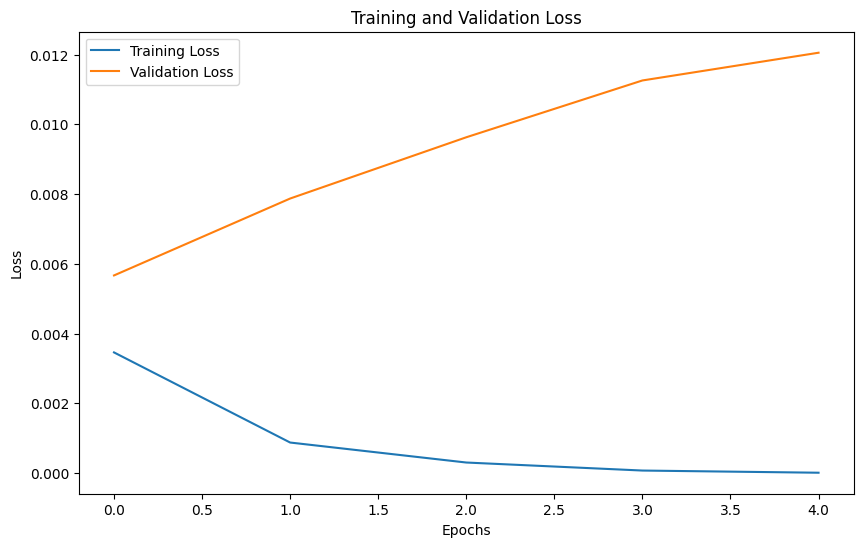

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Step 1: Preprocess the Data

# Load the dataset
df = pd.read_csv('dc100.csv')

# Drop columns with all missing values
df.dropna(axis=1, how='all', inplace=True)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Fill missing numeric values with column means
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Extract relevant features for modeling
data = df[['TAVG (Degrees Fahrenheit)', 'TMAX (Degrees Fahrenheit)', 'TMIN (Degrees Fahrenheit)']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Step 2: Prepare the Data for the LSTM Model

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
SEQ_LENGTH = 30  # Example sequence length

# Create sequences
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into training and testing datasets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape input to be 3D [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Step 3: Build and Train the LSTM Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(X_train.shape[2]))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Step 4: Make Predictions and Evaluate the Model

# Make predictions
predicted_temps = model.predict(X_test)

# Inverse transform predictions and true values
predicted_temps = scaler.inverse_transform(predicted_temps)
y_test = scaler.inverse_transform(y_test)

# Evaluate the model
mse = np.mean((predicted_temps - y_test) ** 2)
print(f'Mean Squared Error: {mse}')

# Save the model
model.save('heatwave_lstm_model.h5')

# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load and preprocess data
df = pd.read_csv('12delhi_cleaned.csv')

# Define labels for heatwave classification
threshold_temp = 90  # Example threshold for classifying a day as heatwave
df['Heatwave'] = np.where(df['TMAX (Degrees Fahrenheit)'] > threshold_temp, 1, 0)

# Prepare data
features = ['TAVG (Degrees Fahrenheit)', 'TMAX (Degrees Fahrenheit)', 'TMIN (Degrees Fahrenheit)']
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Classification report
print(classification_report(y_test, y_pred))



KeyError: 'TMAX (Degrees Fahrenheit)'

Epoch 1/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0784 - val_loss: 0.0685
Epoch 2/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0696 - val_loss: 0.0685
Epoch 3/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0688 - val_loss: 0.0682
Epoch 4/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0686 - val_loss: 0.0681
Epoch 5/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0683 - val_loss: 0.0680
Epoch 6/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0680 - val_loss: 0.0679
Epoch 7/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0679 - val_loss: 0.0678
Epoch 8/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0676 - val_loss: 0.0677
Epoch 9/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0675 - val_loss: 0.0676
Epoch 10/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0673 - val_loss: 0.0676
Epoch 11/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0674 - val_loss: 0.0677
Epoch 12/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 

ValueError: non-broadcastable output operand with shape (2374,1) doesn't match the broadcast shape (2374,4)

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import timedelta

# Load the data from a CSV file
file_path = '12delhi_cleaned.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['time'] = pd.to_datetime(data['time'], format="%d-%m-%Y")
data.set_index('time', inplace=True)
features = ['tavg', 'tmin', 'tmax', 'prcp']

# Function to fill NaNs with random values within the range of each column
def fill_na_randomly(df, columns):
    for column in columns:
        min_val = df[column].min()
        max_val = df[column].max()
        df[column] = df[column].apply(
            lambda x: np.random.uniform(min_val, max_val) if pd.isna(x) else x
        )
    return df

# Fill NaNs with random values within the range of each column
data = fill_na_randomly(data, features)

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tmax > 40, else 0

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the LSTM model with enhanced regularization
def build_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Use K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_acc = []

for train_index, val_index in kfold.split(X_train):
    model = build_model()
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=100, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
    
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold)
    cross_val_acc.append(accuracy)

average_cross_val_acc = np.mean(cross_val_acc)
print(f'Average Cross-Validation Accuracy: {average_cross_val_acc*100:.2f}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves for the next 5 days after the last date in the data
def predict_future_heatwaves(data, model, scaler, features, seq_length=5, days=5):
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days)

    last_seq = data[features].iloc[-seq_length:].values
    future_predictions = []

    for i in range(days):
        seq = scaler.transform(last_seq)
        seq = np.expand_dims(seq, axis=0)
        prediction = model.predict(seq)
        predicted_label = (prediction > 0.5).astype(int).flatten()[0]
        future_predictions.append(predicted_label)
        
        # Create next sequence with the new prediction (assuming the same range for tavg, tmin, tmax, prcp)
        new_entry = np.random.uniform(scaler.data_min_, scaler.data_max_, (1, len(features)))
        last_seq = np.vstack([last_seq[1:], new_entry])
        
    future_df = pd.DataFrame({
        'date': future_dates,
        'predicted_heatwave': future_predictions
    })

    future_df['heatwave'] = future_df['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    return future_df

# Predict heatwaves for the next 5 days
future_heatwaves = predict_future_heatwaves(data, model, scaler, features, seq_length, days=5)
print(future_heatwaves)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tmax'], label='Actual tmax')
plt.plot(data.index, data['prcp'], label='Precipitation')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual tmax, Precipitation and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")


Epoch 1/50


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5629 - loss: 0.7614 - val_accuracy: 1.0000 - val_loss: 0.4375
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8249 - loss: 0.4515 - val_accuracy: 1.0000 - val_loss: 0.2135
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9935 - loss: 0.1817 - val_accuracy: 1.0000 - val_loss: 0.0736
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0641 - val_accuracy: 1.0000 - val_loss: 0.0352
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0314 - val_accuracy: 1.0000 - val_loss: 0.0205
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0182 - val_accuracy: 1.0000 - val_loss: 0.0133
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 0.0093
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 1.0000 - val_loss: 0.0069
Ep

Epoch 1/100


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: nan
Epoch 1/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 1.0000 - loss: 

C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
        date  predicted_heatwave heatwave
0 2022-07-26                   0       No
1 2022-07-27                   0       No
2 2022-07-28                   0       No
3 2022-07-29                   0       No
4 2022-07-30                   0       No


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


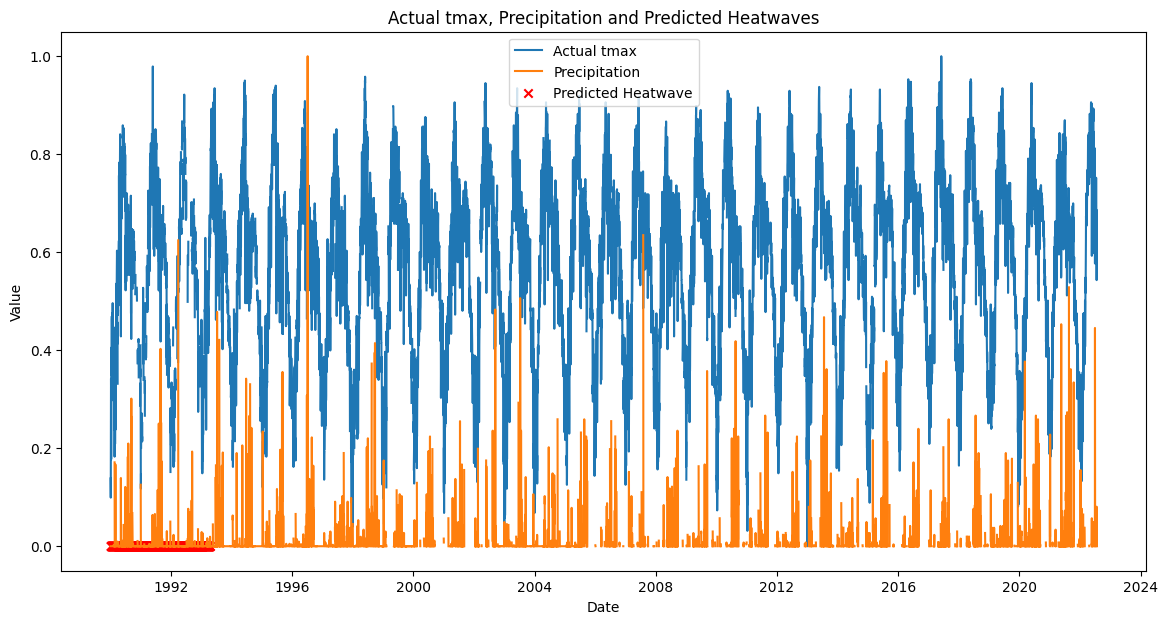

In [13]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data from a CSV file
file_path = '12delhi.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['time'] = pd.to_datetime(data['time'], format="%d-%m-%Y")
data.set_index('time', inplace=True)
features = ['tavg', 'tmin', 'tmax', 'prcp']

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tmax > 40, else 0

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the LSTM model with enhanced regularization
def build_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Use K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_acc = []

for train_index, val_index in kfold.split(X_train):
    model = build_model()
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
    
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold)
    cross_val_acc.append(accuracy)

average_cross_val_acc = np.mean(cross_val_acc)
print(f'Average Cross-Validation Accuracy: {average_cross_val_acc*100:.2f}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves for the next 5 days after the last date in the data
def predict_future_heatwaves(data, model, scaler, features, seq_length=5, days=5):
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days)

    last_seq = data[features].iloc[-seq_length:].values
    future_predictions = []

    for i in range(days):
        seq = scaler.transform(last_seq)
        seq = np.expand_dims(seq, axis=0)
        prediction = model.predict(seq)
        predicted_label = (prediction > 0.5).astype(int).flatten()[0]
        future_predictions.append(predicted_label)
        
        # Create next sequence
        new_entry = np.zeros((1, len(features)))  # Placeholder for new entry
        last_seq = np.vstack([last_seq[1:], new_entry])
        
    future_df = pd.DataFrame({
        'date': future_dates,
        'predicted_heatwave': future_predictions
    })

    future_df['heatwave'] = future_df['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    return future_df

# Predict heatwaves for the next 5 days
future_heatwaves = predict_future_heatwaves(data, model, scaler, features, seq_length, days=5)
print(future_heatwaves)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tmax'], label='Actual tmax')
plt.plot(data.index, data['prcp'], label='Precipitation')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual tmax, Precipitation and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")
